In [11]:
#1) Import libraries
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import Environments
from collections import OrderedDict
import pandas as pd

In [12]:
#2) Set up exploration class and replay buffer.

class ActionNoise:
    """
        Class: Add noise to our action for exploration
        :param mean: mean of the gaussian noise
        :param std_dev: standard deviation of the gaussian noise
        :param total_episodes: number of steps for training
    """
    def __init__(self, mean, std_deviation,total_episodes):
        self.mean = mean
        self.std_dev = std_deviation
        self.change_ep = std_deviation/(total_episodes)
        
    
    def __call__(self,size):
        """
        Getting noise
        :param size: size of the Tensor with noise values
        :return: Tensor with gaussian noise
        """
        return torch.normal(torch.tensor(self.mean).repeat(size),torch.tensor(self.std_dev).repeat(size))
    
    
    def change_std(self):
        """
        Changing the standard deviation to reduce exploration over time
        """   
        self.std_dev=max(self.std_dev-self.change_ep,0.1)

Transition = namedtuple('Transition',('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory(object):
    """
        Class: Replay Buffer (RB)
        :param capacity: capacity in memory
    """
    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    
    def push(self, *args):
        """
        Save a transition object in RB
        :param args: elements in Transition object
        """
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        """
        Get a sample from RB
        :param batch_size: number of objets in sample
        :return: sample of Transition object
        """
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        """
        Get number of saved objets
        :return: number of saved objets
        """
        return len(self.memory)



In [13]:
#3) Set up Neural Network functions and classes

def soft_update(target, source, tau):
    """
        Soft update for a neural network (NN) from an other NN
        :param source: NN used for weights copy
        :param tau: ratio parameter for copy
    """
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    """
        Hard update for a neural network (NN) from an other NN
        :param source: NN used for weights copy ( like soft update with tau=1.0)
    """ 
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

class DDPG_actor(nn.Module):
    """
        Class: actor NN
        :param np_inputs: size input of the NN (size state)
        :param nb_outputs: size output of the NN (size action)
        :param model: name of the NN
    """   
    def __init__(self, np_inputs, nb_outputs, model):
        super(DDPG_actor, self).__init__()  
        self.layer1=nn.Linear(np_inputs, 64)
        self.layer2=nn.Linear(64, 64)
        self.layer3=nn.Linear(64, nb_outputs)
        #self.Tanh=nn.Tanh()
        torch.nn.init.uniform_(self.layer3.weight,-0.003, 0.003)
        self.name=model
    
      
    def forward(self, input1):
        """
        Forward NN : compute the NN with respect the current state
        :param input1: state
        :return: output of the NN, action
        """ 
        if isinstance(input1, np.ndarray):
            input1 = torch.tensor(input1, dtype=torch.float)
        output=F.relu(self.layer1(input1))
        output=F.relu(self.layer2(output))
        output=torch.tanh(self.layer3(output))
        return output
    
class DDPG_critic(nn.Module):
    """
        Class : critic NN
        :param nb_input1: size input state part of the NN (size state)
        :param nb_input2: size input actor part of the NN (size action)
        :param nb_outputs: size output of the NN (size Q_value =1)
        :param model: name of the NN
    """
    def __init__(self, nb_input1, nb_input2, nb_outputs, model):
        
        super(DDPG_critic, self).__init__()  
        self.state_net1=nn.Linear(nb_input1, 48)
        self.state_net2=nn.Linear(48, 48)
        self.action_net1=nn.Linear(nb_input2, 48)
        self.merge_net1=nn.Linear(96, 48)
        self.merge_net2=nn.Linear(48, nb_outputs)
        torch.nn.init.uniform_(self.merge_net2.weight,-0.003, 0.003)
        self.name=model
        
      
    def forward(self, input1, input2):
        """
        Forward NN : compute the NN with respect the current state and action
        :param input1: state
        :param input2: action
        :return: output of the NN, Q_value
        """ 
        if isinstance(input1, np.ndarray):
            input1 = torch.tensor(input1, dtype=torch.float)
        if isinstance(input2, np.ndarray):
            input2 = torch.tensor(input2, dtype=torch.float)
            
        output1=F.relu(self.state_net1(input1))
        output1=F.relu(self.state_net2(output1))
        output2=F.relu(self.action_net1(input2))
        output3=torch.cat((output1,output2),dim=1)
        output_final=F.relu(self.merge_net1(output3))
        output_final=self.merge_net2(output_final)
        return output_final

In [14]:
#4) Rollout on the environment:
class Env_rollout:
    """ 
        Class : iterate on the environment
        :param env: our environment
        :param max_steps: max steps per episode
    """
    def __init__(self, env, max_steps):
        self.env = env
        self.max_steps = max_steps
        self.prev_state = env.reset()
    
    
    def select_action(self, actor_net, state):
        """ 
        Get a new action
        :param actor_net: current policy (actor NN)
        :param state: current state
        :return: action NN, action NN clipped
        """
        actor_net.eval()
        action=torch.squeeze(actor_net(torch.unsqueeze(torch.tensor(state), dim=0)))
        if(action.dim()==0):
            action=torch.unsqueeze(action,dim=0)
        legal_action=torch.clamp(action, min=-1e0, max=1e0)
        return action, legal_action
    
    """ 
        Get a new action
        :param actor_net: current policy (actor NN)
        :param state: current state
        :return: action NN, action NN clipped
    """
    def iterations(self,actor_net, nbr_episodes):
        """
        Iterate on the environment.
        :param actor_net: current policy (actor NN)
        :param nbr_episodes: episode number
        :return: Tensors; state batch, action batch, reward batch
        """
        batch_obs=[]
        batch_acts=[]
        batch_rews=[]
        for ep in range(nbr_episodes):
            prev_state = env.reset()
            for step_ep in range(self.max_steps): 
                with torch.no_grad():
                    action, legal_action = self.select_action(actor_net, prev_state)
                    state, reward, done, _ = self.env.step(legal_action.detach().numpy())
                    batch_obs.append(prev_state)
                    batch_acts.append(legal_action.detach().numpy())
                    batch_rews.append(reward)
                    prev_state = state
                if done:
                    break
        return torch.tensor(batch_obs, dtype=torch.float), torch.tensor(batch_acts, dtype=torch.float), torch.tensor(batch_rews, dtype=torch.float)



In [15]:
#5) Algorithm DDPG:
class Algo_DDPG():
    """ 
        PPO algorithm : training and testing
        :param policy_class_a: policy (actor model)
        :param policy_class_c: policy (critic model)
        :param env: environment
        :param hyperparameters: other hyperparameters
    """
    def __init__(self, policy_class_a, policy_class_c, env, **hyperparameters):
        
        self._init_hyperparameters(hyperparameters)
        self.actor_net = policy_class_a(num_states, num_actions, "online")
        self.critic_net = policy_class_c(num_states, num_actions, 1, "online")
        self.target_actor_net = policy_class_a(num_states, num_actions, "target")
        self.target_critic_net = policy_class_c(num_states, num_actions, 1, "target")
        hard_update(self.target_critic_net,self.critic_net)
        hard_update(self.target_actor_net,self.actor_net)
        self.optimizer_critic = optim.Adam(self.critic_net.parameters(), self.critic_lr,weight_decay=0.01)
        self.optimizer_actor = optim.Adam(self.actor_net.parameters(), self.actor_lr)
        self.rollout = Env_rollout(env, self.max_steps)
    
    def evaluate(self, nbr_episodes, selection):
        """
        Testing
        :param nbr_episodes: episode number 
        :param selection: target or current policy NN
        :return: state batch, action batch, and reward batch
        """
        if(selection=="target"):
            state_batch, action_batch, rewards_batch = self.rollout.iterations(self.target_actor_net, nbr_episodes)
        else:
            state_batch, action_batch, rewards_batch = self.rollout.iterations(self.actor_net, nbr_episodes)
        return state_batch, action_batch, rewards_batch
    
    def optimize_model(self):
        """
        Model Optimization
        :return: batch reward
        """
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        criterion=nn.MSELoss(reduction='mean')

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        next_state_batch = torch.cat(batch.next_state)
        done_batch = torch.cat(batch.done)
        #Critic optimization
        self.optimizer_critic.zero_grad()
        target_actor_batch = self.target_actor_net.forward(next_state_batch)
        target_critic_batch = self.target_critic_net.forward(next_state_batch,target_actor_batch.detach())
        critic_action_batch = self.critic_net.forward(state_batch,action_batch)
        #print('OHO')
        #print("next_state_batch"+str(next_state_batch.shape))
        #print("target_actor_batch"+str(target_actor_batch.shape))
        #print("state_batch"+str(state_batch.shape))
        #print("action_batch"+str(action_batch.shape))
        #print("done_batch"+str(done_batch.shape))
        #print("target_critic_batch"+str(target_critic_batch.shape))
        #print("critic_action_batch"+str(critic_action_batch.shape)) 
        expected_state_action_values = (torch.mul(target_critic_batch, 1 - done_batch) * self.gamma) + reward_batch
        critic_loss = criterion(expected_state_action_values.detach(),critic_action_batch)
        critic_loss.backward()
        self.optimizer_critic.step()

        #Actor optimization
        #see if i can optimize only some times
        actor_batch = self.actor_net.forward(state_batch)
        critic_actor_batch = self.critic_net.forward(state_batch,actor_batch)
        actor_loss = - critic_actor_batch.mean()
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()
        return reward_batch
    
    def select_action(self, actor_net, state, noise):
        """ 
        Get a new action
        :param actor_net: current policy (actor NN)
        :param state: current state
        :param noise: noise object
        :return: action NN, action NN clipped
        """
        actor_net.eval()
        action=torch.squeeze(actor_net(torch.unsqueeze(torch.tensor(state), dim=0)))
        actor_net.train()
        if(action.dim()==0):
            action=torch.unsqueeze(action,dim=0)
        if(noise is not None):
            action=action+noise(1)
        legal_action=torch.clamp(action, min=-1e0, max=1e0)
        return action, legal_action
    
    def train(self, nb_loop):
        """ 
        Training
        :param nb_loop: step number
        """
        self.noise = ActionNoise(self.mean_dev, self.std_dev, nb_loop)
        for i in range(10):
            prev_state = env.reset()
            #episodic_reward = torch.tensor([0.0], device=device).float()
            for step_ep in range(self.max_steps):
                action, legal_action = self.select_action(self.actor_net, prev_state, self.noise)
                state, reward, done, _ = env.step(legal_action.detach().numpy())
                episodic_reward = torch.tensor([reward], device=device)#+episodic_reward
                done_t = torch.tensor([int(done)])
                self.memory.push(torch.unsqueeze(torch.tensor(prev_state), dim=0),
                                 torch.unsqueeze(action.detach(), dim=0).float(),
                                 torch.unsqueeze(episodic_reward, dim=0).float(),
                                 torch.unsqueeze(torch.tensor(state), dim=0).float(),
                                 torch.unsqueeze(done_t, dim=0))
                if done:
                    break
        n_step=0
        while n_step<nb_loop:
            prev_state = env.reset()
            #episodic_reward = torch.tensor([0.0], device=device).float()
            for step_ep in range(self.max_steps):
                action, legal_action = self.select_action(self.actor_net, prev_state, self.noise)
                state, reward, done, _ = env.step(legal_action.detach().numpy())
                episodic_reward = torch.tensor([reward])#+episodic_reward
                done_t = torch.tensor([int(done)])
                self.memory.push(torch.unsqueeze(torch.tensor(prev_state), dim=0),
                                 torch.unsqueeze(action.detach(), dim=0).float(),
                                 torch.unsqueeze(episodic_reward, dim=0).float(),
                                 torch.unsqueeze(torch.tensor(state), dim=0).float(),
                                 torch.unsqueeze(done_t, dim=0)
                                )
                prev_state = state
                n_step=n_step+1
                self.total_loop= self.total_loop +1
                self.noise.change_std()
                if (n_step%2==0): #policy delay=2
                    batch_rew2=self.optimize_model()
                    soft_update(self.target_critic_net,self.critic_net,self.tau)
                    soft_update(self.target_actor_net,self.actor_net,self.tau)
                    if(batch_rew2 != None):
                        self.ep_reward_list.append(batch_rew2.mean().detach().numpy())
                #if (n_step%100000==0):
                #    hard_update(self.critic_net,self.target_critic_net)
                #    hard_update(self.actor_net,self.target_actor_net)
                if done:
                    break
            if(len(self.ep_reward_list)>0):
                avg_reward = np.mean(self.ep_reward_list[-30:])
                print("Steps * {} * Avg Reward is ==> {}".format(n_step, avg_reward))
        path='load_model/parameters/ddpg-{num_algo:02d}-{name}-{epoch:03d}000.npy'
        with open(path.format(num_algo=self.num_algo,epoch=int(self.total_loop/1000),name="reward"), 'wb') as f:
            np.save(f, np.array(self.ep_reward_list))
        print("Complete")
        
    def _init_hyperparameters(self, hyperparameters):
        """
        Initialize hyperparameters. 
        :param hyperparameters: hyperparameter list
        """
        self.num_algo = 1
        self.batch_size = 100
        self.memory = ReplayMemory(1000000)
        self.tau = 0.005
        self.gamma = 0.99
        self.mean_dev = 0.0
        self.std_dev = 0.5
        self.max_steps = 90
        self.total_loop = 0
        self.critic_lr = 3e-3
        self.actor_lr = 3e-4
        self.ep_reward_list=[]
        for param, val in hyperparameters.items():
            exec('self.' + param + ' = ' + str(val)) #juste trop fort
            
    def loading(self, num_algo, total_loop):
        """
        Loading NN weights 
        :param num_algo: algorithm number
        :param total_loop: step number
        """
        self.num_algo = num_algo
        self.total_loop = total_loop
        checkpoint_path1 = "load_model/weights/torch-ddpg-{num_algo:02d}-actor-{epoch:03d}000.pth"
        self.actor_net.load_state_dict(torch.load(checkpoint_path1.format(epoch=int(self.total_loop/1000), num_algo=self.num_algo)))
        checkpoint_path2 = "load_model/weights/torch-ddpg-{num_algo:02d}-critic-{epoch:03d}000.pth"
        self.critic_net.load_state_dict(torch.load(checkpoint_path2.format(epoch=int(self.total_loop/1000), num_algo=self.num_algo)))
        hard_update(self.target_critic_net,self.critic_net)
        hard_update(self.target_actor_net,self.actor_net)
        
    def saving(self):
        """
        Saving NN weights 
        """
        checkpoint_path = "load_model/weights/torch-ddpg-{num_algo:02d}-actor-{epoch:03d}000.pth"
        torch.save(self.target_actor_net.state_dict(),checkpoint_path.format(epoch=int(self.total_loop/1000), num_algo=self.num_algo))
        checkpoint_path = "load_model/weights/torch-ddpg-{num_algo:02d}-critic-{epoch:03d}000.pth"
        torch.save(self.target_critic_net.state_dict(),checkpoint_path.format(epoch=int(self.total_loop/1000), num_algo=self.num_algo))
        


In [18]:
#6) Computing part:
# Import environment
problem = "Crossway_comparison2-v0"
u_b = [2.0, 11.0, -12.5, 1.1, -1.0]
l_b = [-4.0, 9.0, -32.5, 0.9, -2.0]

env = gym.make(problem,dt=0.3,Vm=2.5,tau=1.0,lower_bounds=l_b, upper_bounds=u_b,simulation="sin")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the algorithm
num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
num_algo=11

algo=Algo_DDPG(DDPG_actor, DDPG_critic, env, num_algo= num_algo, num_states=num_states, num_actions=num_actions)
#algo.loading(1,2000000)

In [19]:
#Training
import time
start = time.time()
algo.train(2000000)
algo.saving()
end = time.time()
print("Running time: "+str(end-start))

Accident!
Steps * 25 * Avg Reward is ==> -31.746362686157227
Steps * 47 * Avg Reward is ==> -30.233976364135742
Steps * 69 * Avg Reward is ==> -29.31473159790039
Steps * 91 * Avg Reward is ==> -27.49086570739746
Steps * 121 * Avg Reward is ==> -27.582651138305664
Steps * 149 * Avg Reward is ==> -28.953205108642578
Steps * 173 * Avg Reward is ==> -29.69216537475586
Steps * 198 * Avg Reward is ==> -27.89000129699707
Steps * 220 * Avg Reward is ==> -29.03151512145996
Steps * 243 * Avg Reward is ==> -30.42473602294922
Steps * 274 * Avg Reward is ==> -30.492414474487305
Steps * 297 * Avg Reward is ==> -30.4096622467041
Steps * 321 * Avg Reward is ==> -29.177682876586914
Steps * 348 * Avg Reward is ==> -26.969324111938477
Steps * 376 * Avg Reward is ==> -26.82246971130371
Steps * 399 * Avg Reward is ==> -27.783966064453125
Steps * 427 * Avg Reward is ==> -28.7616024017334
Steps * 461 * Avg Reward is ==> -30.905071258544922
Steps * 493 * Avg Reward is ==> -33.3330192565918
Steps * 521 * Avg R

Steps * 7654 * Avg Reward is ==> -32.825496673583984
Accident!
Steps * 7693 * Avg Reward is ==> -31.215478897094727
Accident!
Steps * 7732 * Avg Reward is ==> -32.67281723022461
Steps * 7754 * Avg Reward is ==> -31.919635772705078
Accident!
Steps * 7798 * Avg Reward is ==> -31.843564987182617
Steps * 7850 * Avg Reward is ==> -30.748262405395508
Accident!
Steps * 7889 * Avg Reward is ==> -30.805498123168945
Steps * 7911 * Avg Reward is ==> -31.651403427124023
Steps * 7958 * Avg Reward is ==> -31.08029556274414
Steps * 7979 * Avg Reward is ==> -31.091703414916992
Steps * 8002 * Avg Reward is ==> -30.778017044067383
Accident!
Steps * 8058 * Avg Reward is ==> -31.099048614501953
Steps * 8080 * Avg Reward is ==> -30.448110580444336
Accident!
Steps * 8125 * Avg Reward is ==> -29.528926849365234
Steps * 8164 * Avg Reward is ==> -31.156888961791992
Steps * 8189 * Avg Reward is ==> -31.327556610107422
Steps * 8213 * Avg Reward is ==> -30.49625587463379
Accident!
Steps * 8252 * Avg Reward is ==>

Steps * 13129 * Avg Reward is ==> -22.834564208984375
Steps * 13153 * Avg Reward is ==> -22.870861053466797
Accident!
Steps * 13192 * Avg Reward is ==> -22.538835525512695
Accident!
Steps * 13232 * Avg Reward is ==> -21.760242462158203
Steps * 13278 * Avg Reward is ==> -22.0587100982666
Steps * 13324 * Avg Reward is ==> -21.85374641418457
Steps * 13348 * Avg Reward is ==> -21.703617095947266
Steps * 13376 * Avg Reward is ==> -22.05445098876953
Steps * 13422 * Avg Reward is ==> -22.187299728393555
Steps * 13470 * Avg Reward is ==> -21.926851272583008
Steps * 13513 * Avg Reward is ==> -22.107324600219727
Steps * 13557 * Avg Reward is ==> -21.673524856567383
Steps * 13584 * Avg Reward is ==> -20.957918167114258
Accident!
Steps * 13627 * Avg Reward is ==> -21.502687454223633
Steps * 13675 * Avg Reward is ==> -21.146146774291992
Accident!
Steps * 13722 * Avg Reward is ==> -20.778230667114258
Steps * 13767 * Avg Reward is ==> -21.04973793029785
Steps * 13808 * Avg Reward is ==> -21.312259674

Steps * 18786 * Avg Reward is ==> -16.756710052490234
Accident!
Steps * 18828 * Avg Reward is ==> -16.804107666015625
Accident!
Steps * 18868 * Avg Reward is ==> -16.303638458251953
Steps * 18890 * Avg Reward is ==> -16.18305015563965
Steps * 18929 * Avg Reward is ==> -16.642885208129883
Steps * 18978 * Avg Reward is ==> -17.856435775756836
Accident!
Steps * 19021 * Avg Reward is ==> -17.265472412109375
Steps * 19061 * Avg Reward is ==> -15.959534645080566
Accident!
Steps * 19103 * Avg Reward is ==> -16.265605926513672
Steps * 19143 * Avg Reward is ==> -15.847207069396973
Steps * 19164 * Avg Reward is ==> -16.1999568939209
Steps * 19213 * Avg Reward is ==> -17.36036491394043
Steps * 19252 * Avg Reward is ==> -16.694034576416016
Steps * 19275 * Avg Reward is ==> -16.89825439453125
Steps * 19301 * Avg Reward is ==> -17.361412048339844
Accident!
Steps * 19340 * Avg Reward is ==> -17.121171951293945
Steps * 19381 * Avg Reward is ==> -17.25013542175293
Steps * 19427 * Avg Reward is ==> -15.

Steps * 23959 * Avg Reward is ==> -14.423931121826172
Steps * 23981 * Avg Reward is ==> -14.302122116088867
Steps * 24025 * Avg Reward is ==> -14.479959487915039
Steps * 24047 * Avg Reward is ==> -13.966534614562988
Steps * 24093 * Avg Reward is ==> -13.956634521484375
Steps * 24116 * Avg Reward is ==> -14.852614402770996
Steps * 24159 * Avg Reward is ==> -14.338006019592285
Steps * 24206 * Avg Reward is ==> -14.094930648803711
Steps * 24228 * Avg Reward is ==> -13.240713119506836
Steps * 24251 * Avg Reward is ==> -13.092374801635742
Steps * 24295 * Avg Reward is ==> -14.015292167663574
Steps * 24340 * Avg Reward is ==> -14.711878776550293
Accident!
Steps * 24388 * Avg Reward is ==> -14.13437557220459
Steps * 24417 * Avg Reward is ==> -14.210030555725098
Steps * 24441 * Avg Reward is ==> -13.946355819702148
Steps * 24485 * Avg Reward is ==> -14.136127471923828
Steps * 24511 * Avg Reward is ==> -14.191423416137695
Steps * 24533 * Avg Reward is ==> -13.998510360717773
Steps * 24557 * Avg

Steps * 29339 * Avg Reward is ==> -13.317537307739258
Steps * 29365 * Avg Reward is ==> -12.231401443481445
Steps * 29414 * Avg Reward is ==> -12.034072875976562
Steps * 29454 * Avg Reward is ==> -11.765863418579102
Steps * 29499 * Avg Reward is ==> -12.41345500946045
Steps * 29544 * Avg Reward is ==> -12.122307777404785
Steps * 29595 * Avg Reward is ==> -12.83892822265625
Steps * 29644 * Avg Reward is ==> -11.933774948120117
Steps * 29667 * Avg Reward is ==> -11.877168655395508
Steps * 29689 * Avg Reward is ==> -11.286532402038574
Steps * 29731 * Avg Reward is ==> -12.126614570617676
Accident!
Steps * 29775 * Avg Reward is ==> -12.367618560791016
Steps * 29799 * Avg Reward is ==> -12.639504432678223
Steps * 29823 * Avg Reward is ==> -12.673641204833984
Steps * 29869 * Avg Reward is ==> -11.0101318359375
Steps * 29893 * Avg Reward is ==> -11.053162574768066
Steps * 29918 * Avg Reward is ==> -11.733043670654297
Steps * 29941 * Avg Reward is ==> -11.785004615783691
Steps * 29986 * Avg Re

Steps * 34493 * Avg Reward is ==> -11.033562660217285
Steps * 34539 * Avg Reward is ==> -10.425945281982422
Accident!
Steps * 34577 * Avg Reward is ==> -10.926518440246582
Steps * 34599 * Avg Reward is ==> -10.854785919189453
Steps * 34624 * Avg Reward is ==> -11.22183609008789
Steps * 34664 * Avg Reward is ==> -11.18895149230957
Steps * 34687 * Avg Reward is ==> -10.89083480834961
Steps * 34728 * Avg Reward is ==> -10.94406795501709
Steps * 34750 * Avg Reward is ==> -10.914703369140625
Steps * 34773 * Avg Reward is ==> -11.022283554077148
Steps * 34821 * Avg Reward is ==> -10.946504592895508
Steps * 34843 * Avg Reward is ==> -10.50729751586914
Steps * 34865 * Avg Reward is ==> -10.879575729370117
Steps * 34910 * Avg Reward is ==> -11.184454917907715
Steps * 34933 * Avg Reward is ==> -10.823734283447266
Steps * 34955 * Avg Reward is ==> -10.650568008422852
Steps * 34980 * Avg Reward is ==> -10.908066749572754
Steps * 35004 * Avg Reward is ==> -11.141672134399414
Steps * 35032 * Avg Rew

Steps * 39297 * Avg Reward is ==> -10.416387557983398
Steps * 39319 * Avg Reward is ==> -10.109704971313477
Steps * 39371 * Avg Reward is ==> -10.52666187286377
Steps * 39420 * Avg Reward is ==> -10.026776313781738
Steps * 39473 * Avg Reward is ==> -10.204894065856934
Steps * 39525 * Avg Reward is ==> -9.451516151428223
Steps * 39560 * Avg Reward is ==> -10.667649269104004
Steps * 39599 * Avg Reward is ==> -10.627538681030273
Steps * 39626 * Avg Reward is ==> -10.226664543151855
Accident!
Steps * 39667 * Avg Reward is ==> -9.777460098266602
Steps * 39708 * Avg Reward is ==> -10.23855972290039
Steps * 39730 * Avg Reward is ==> -9.633861541748047
Steps * 39772 * Avg Reward is ==> -9.513517379760742
Steps * 39795 * Avg Reward is ==> -10.314064979553223
Steps * 39821 * Avg Reward is ==> -9.985772132873535
Accident!
Steps * 39859 * Avg Reward is ==> -9.888896942138672
Steps * 39915 * Avg Reward is ==> -9.760711669921875
Steps * 39941 * Avg Reward is ==> -9.999248504638672
Steps * 39966 * Av

Steps * 44803 * Avg Reward is ==> -9.436787605285645
Steps * 44847 * Avg Reward is ==> -9.793659210205078
Steps * 44870 * Avg Reward is ==> -9.871236801147461
Steps * 44918 * Avg Reward is ==> -9.475968360900879
Steps * 44961 * Avg Reward is ==> -8.985319137573242
Accident!
Steps * 44995 * Avg Reward is ==> -9.191044807434082
Steps * 45018 * Avg Reward is ==> -8.944828987121582
Steps * 45042 * Avg Reward is ==> -9.3416166305542
Accident!
Steps * 45081 * Avg Reward is ==> -9.146055221557617
Steps * 45105 * Avg Reward is ==> -9.067240715026855
Accident!
Steps * 45140 * Avg Reward is ==> -9.063162803649902
Steps * 45189 * Avg Reward is ==> -9.484885215759277
Steps * 45234 * Avg Reward is ==> -9.393126487731934
Steps * 45288 * Avg Reward is ==> -9.141766548156738
Steps * 45335 * Avg Reward is ==> -9.572931289672852
Steps * 45384 * Avg Reward is ==> -9.999786376953125
Steps * 45410 * Avg Reward is ==> -9.851545333862305
Steps * 45456 * Avg Reward is ==> -9.060561180114746
Steps * 45507 * Av

Steps * 50220 * Avg Reward is ==> -8.94902515411377
Steps * 50270 * Avg Reward is ==> -7.93227481842041
Steps * 50313 * Avg Reward is ==> -8.37276554107666
Steps * 50335 * Avg Reward is ==> -8.324426651000977
Steps * 50379 * Avg Reward is ==> -8.381133079528809
Steps * 50402 * Avg Reward is ==> -8.639494895935059
Steps * 50425 * Avg Reward is ==> -8.71155834197998
Steps * 50474 * Avg Reward is ==> -8.753387451171875
Steps * 50519 * Avg Reward is ==> -8.770033836364746
Steps * 50565 * Avg Reward is ==> -8.320757865905762
Steps * 50590 * Avg Reward is ==> -8.715500831604004
Steps * 50616 * Avg Reward is ==> -8.725845336914062
Steps * 50660 * Avg Reward is ==> -8.69373893737793
Steps * 50709 * Avg Reward is ==> -8.860422134399414
Steps * 50732 * Avg Reward is ==> -8.609662055969238
Accident!
Steps * 50767 * Avg Reward is ==> -8.55731201171875
Steps * 50790 * Avg Reward is ==> -8.789434432983398
Steps * 50811 * Avg Reward is ==> -8.7220458984375
Steps * 50857 * Avg Reward is ==> -7.8474302

Steps * 55762 * Avg Reward is ==> -7.499259948730469
Steps * 55788 * Avg Reward is ==> -7.4920125007629395
Steps * 55833 * Avg Reward is ==> -8.184094429016113
Steps * 55884 * Avg Reward is ==> -8.453099250793457
Steps * 55907 * Avg Reward is ==> -7.936918258666992
Steps * 55952 * Avg Reward is ==> -7.668961524963379
Steps * 55976 * Avg Reward is ==> -8.223745346069336
Steps * 56022 * Avg Reward is ==> -8.340954780578613
Steps * 56047 * Avg Reward is ==> -8.48963737487793
Steps * 56098 * Avg Reward is ==> -8.10648250579834
Steps * 56147 * Avg Reward is ==> -7.286370754241943
Steps * 56186 * Avg Reward is ==> -7.544945240020752
Steps * 56239 * Avg Reward is ==> -8.238713264465332
Steps * 56281 * Avg Reward is ==> -7.29956579208374
Steps * 56330 * Avg Reward is ==> -8.406394958496094
Steps * 56355 * Avg Reward is ==> -8.26700496673584
Steps * 56399 * Avg Reward is ==> -7.6099138259887695
Steps * 56447 * Avg Reward is ==> -7.655904769897461
Steps * 56474 * Avg Reward is ==> -7.37982034683

Steps * 61615 * Avg Reward is ==> -8.177199363708496
Steps * 61661 * Avg Reward is ==> -7.784650802612305
Steps * 61707 * Avg Reward is ==> -7.214261531829834
Steps * 61732 * Avg Reward is ==> -7.3288893699646
Steps * 61778 * Avg Reward is ==> -7.1501851081848145
Steps * 61822 * Avg Reward is ==> -7.006188869476318
Steps * 61866 * Avg Reward is ==> -7.462262153625488
Steps * 61912 * Avg Reward is ==> -7.593809604644775
Steps * 61935 * Avg Reward is ==> -7.32643461227417
Steps * 61977 * Avg Reward is ==> -6.878404140472412
Steps * 62019 * Avg Reward is ==> -6.833868026733398
Steps * 62042 * Avg Reward is ==> -7.409928798675537
Steps * 62067 * Avg Reward is ==> -7.5140604972839355
Steps * 62116 * Avg Reward is ==> -7.304853439331055
Steps * 62141 * Avg Reward is ==> -7.588953971862793
Steps * 62171 * Avg Reward is ==> -7.430881977081299
Steps * 62213 * Avg Reward is ==> -6.610864162445068
Steps * 62258 * Avg Reward is ==> -6.382172107696533
Steps * 62282 * Avg Reward is ==> -7.0495352745

Steps * 67311 * Avg Reward is ==> -6.718903541564941
Steps * 67335 * Avg Reward is ==> -6.649785995483398
Steps * 67358 * Avg Reward is ==> -6.564784049987793
Steps * 67408 * Avg Reward is ==> -7.31478214263916
Steps * 67454 * Avg Reward is ==> -6.464751243591309
Steps * 67478 * Avg Reward is ==> -6.69661808013916
Steps * 67521 * Avg Reward is ==> -7.200442314147949
Steps * 67569 * Avg Reward is ==> -6.330228328704834
Steps * 67619 * Avg Reward is ==> -6.892027378082275
Steps * 67641 * Avg Reward is ==> -6.9854350090026855
Steps * 67683 * Avg Reward is ==> -6.93458890914917
Steps * 67730 * Avg Reward is ==> -6.91487979888916
Steps * 67780 * Avg Reward is ==> -6.919596195220947
Steps * 67807 * Avg Reward is ==> -6.597365379333496
Steps * 67851 * Avg Reward is ==> -6.627054214477539
Steps * 67895 * Avg Reward is ==> -6.31410026550293
Steps * 67921 * Avg Reward is ==> -6.8155412673950195
Steps * 67946 * Avg Reward is ==> -6.809409141540527
Steps * 67990 * Avg Reward is ==> -7.155693531036

Steps * 72944 * Avg Reward is ==> -6.764551639556885
Steps * 72990 * Avg Reward is ==> -6.118309497833252
Accident!
Steps * 73034 * Avg Reward is ==> -6.273558139801025
Steps * 73078 * Avg Reward is ==> -6.393077373504639
Steps * 73118 * Avg Reward is ==> -6.378733158111572
Steps * 73141 * Avg Reward is ==> -6.007016658782959
Steps * 73164 * Avg Reward is ==> -6.108249187469482
Steps * 73191 * Avg Reward is ==> -6.098172664642334
Steps * 73241 * Avg Reward is ==> -6.09975004196167
Steps * 73289 * Avg Reward is ==> -6.057243824005127
Steps * 73340 * Avg Reward is ==> -6.053577899932861
Steps * 73362 * Avg Reward is ==> -6.0459136962890625
Steps * 73383 * Avg Reward is ==> -6.604528903961182
Steps * 73405 * Avg Reward is ==> -6.8567962646484375
Steps * 73428 * Avg Reward is ==> -6.44957971572876
Steps * 73452 * Avg Reward is ==> -6.272345542907715
Steps * 73492 * Avg Reward is ==> -7.017568588256836
Steps * 73543 * Avg Reward is ==> -6.660622596740723
Steps * 73569 * Avg Reward is ==> -6

Steps * 78661 * Avg Reward is ==> -6.166369915008545
Steps * 78688 * Avg Reward is ==> -6.539512634277344
Steps * 78735 * Avg Reward is ==> -6.072405815124512
Steps * 78787 * Avg Reward is ==> -5.897562503814697
Steps * 78809 * Avg Reward is ==> -6.00982141494751
Steps * 78854 * Avg Reward is ==> -6.3462114334106445
Steps * 78875 * Avg Reward is ==> -5.830601215362549
Steps * 78915 * Avg Reward is ==> -5.335851192474365
Steps * 78960 * Avg Reward is ==> -5.770211219787598
Steps * 79011 * Avg Reward is ==> -5.491427898406982
Steps * 79060 * Avg Reward is ==> -5.704234600067139
Steps * 79086 * Avg Reward is ==> -5.309085369110107
Steps * 79110 * Avg Reward is ==> -5.477596759796143
Steps * 79159 * Avg Reward is ==> -6.270115852355957
Steps * 79209 * Avg Reward is ==> -6.37504243850708
Steps * 79252 * Avg Reward is ==> -5.537909030914307
Steps * 79301 * Avg Reward is ==> -5.745302677154541
Steps * 79347 * Avg Reward is ==> -5.678316116333008
Steps * 79369 * Avg Reward is ==> -5.2343454360

Steps * 84487 * Avg Reward is ==> -5.365820407867432
Steps * 84512 * Avg Reward is ==> -5.19921350479126
Steps * 84556 * Avg Reward is ==> -6.294552803039551
Steps * 84601 * Avg Reward is ==> -5.892679691314697
Steps * 84654 * Avg Reward is ==> -5.238795757293701
Steps * 84703 * Avg Reward is ==> -5.416398525238037
Steps * 84727 * Avg Reward is ==> -5.576727867126465
Steps * 84770 * Avg Reward is ==> -5.561479568481445
Steps * 84815 * Avg Reward is ==> -5.0771403312683105
Steps * 84862 * Avg Reward is ==> -5.624444961547852
Steps * 84909 * Avg Reward is ==> -5.542651653289795
Steps * 84935 * Avg Reward is ==> -5.372764587402344
Steps * 84959 * Avg Reward is ==> -5.459529399871826
Steps * 85008 * Avg Reward is ==> -5.307791709899902
Steps * 85035 * Avg Reward is ==> -4.98424768447876
Steps * 85057 * Avg Reward is ==> -5.337740898132324
Steps * 85098 * Avg Reward is ==> -5.855720043182373
Steps * 85121 * Avg Reward is ==> -5.470120429992676
Steps * 85143 * Avg Reward is ==> -5.1920719146

Steps * 90479 * Avg Reward is ==> -4.848440647125244
Steps * 90526 * Avg Reward is ==> -4.804621696472168
Steps * 90572 * Avg Reward is ==> -5.008431434631348
Steps * 90596 * Avg Reward is ==> -5.1090989112854
Steps * 90642 * Avg Reward is ==> -4.921712398529053
Steps * 90690 * Avg Reward is ==> -5.293545722961426
Steps * 90736 * Avg Reward is ==> -5.3202691078186035
Steps * 90786 * Avg Reward is ==> -5.317864894866943
Steps * 90836 * Avg Reward is ==> -4.709096431732178
Steps * 90860 * Avg Reward is ==> -4.868188858032227
Steps * 90907 * Avg Reward is ==> -4.579335689544678
Steps * 90957 * Avg Reward is ==> -5.2162628173828125
Steps * 90981 * Avg Reward is ==> -5.470223903656006
Steps * 91030 * Avg Reward is ==> -5.310835838317871
Steps * 91078 * Avg Reward is ==> -5.323955059051514
Steps * 91107 * Avg Reward is ==> -5.3506693840026855
Steps * 91150 * Avg Reward is ==> -5.702521800994873
Steps * 91173 * Avg Reward is ==> -5.431989669799805
Steps * 91217 * Avg Reward is ==> -5.05007791

Steps * 96236 * Avg Reward is ==> -5.117996692657471
Steps * 96290 * Avg Reward is ==> -4.8480353355407715
Steps * 96340 * Avg Reward is ==> -4.860620498657227
Steps * 96383 * Avg Reward is ==> -4.646633625030518
Steps * 96407 * Avg Reward is ==> -4.5760908126831055
Steps * 96451 * Avg Reward is ==> -4.620573043823242
Steps * 96473 * Avg Reward is ==> -4.706306457519531
Steps * 96496 * Avg Reward is ==> -4.530630588531494
Steps * 96524 * Avg Reward is ==> -4.9237141609191895
Steps * 96573 * Avg Reward is ==> -4.599182605743408
Steps * 96619 * Avg Reward is ==> -4.817178726196289
Steps * 96644 * Avg Reward is ==> -4.914360523223877
Steps * 96690 * Avg Reward is ==> -5.018279552459717
Steps * 96714 * Avg Reward is ==> -5.082301139831543
Steps * 96758 * Avg Reward is ==> -5.343000411987305
Steps * 96780 * Avg Reward is ==> -5.214462757110596
Steps * 96831 * Avg Reward is ==> -5.050776958465576
Steps * 96879 * Avg Reward is ==> -4.950308322906494
Steps * 96900 * Avg Reward is ==> -4.555132

Steps * 102139 * Avg Reward is ==> -4.228695869445801
Steps * 102196 * Avg Reward is ==> -4.561385154724121
Steps * 102243 * Avg Reward is ==> -4.981698989868164
Steps * 102268 * Avg Reward is ==> -5.076228141784668
Steps * 102317 * Avg Reward is ==> -4.6384711265563965
Steps * 102341 * Avg Reward is ==> -4.019400119781494
Steps * 102365 * Avg Reward is ==> -4.292057991027832
Steps * 102411 * Avg Reward is ==> -5.043568134307861
Steps * 102461 * Avg Reward is ==> -4.558767795562744
Steps * 102485 * Avg Reward is ==> -4.168841361999512
Steps * 102532 * Avg Reward is ==> -4.5337042808532715
Steps * 102583 * Avg Reward is ==> -4.572722434997559
Steps * 102606 * Avg Reward is ==> -4.524287223815918
Steps * 102633 * Avg Reward is ==> -4.5842132568359375
Steps * 102672 * Avg Reward is ==> -4.594250202178955
Steps * 102697 * Avg Reward is ==> -4.624318599700928
Steps * 102721 * Avg Reward is ==> -4.673080921173096
Steps * 102766 * Avg Reward is ==> -4.994307041168213
Steps * 102811 * Avg Rewa

Steps * 108002 * Avg Reward is ==> -4.253394603729248
Steps * 108025 * Avg Reward is ==> -4.153697490692139
Steps * 108070 * Avg Reward is ==> -4.134644985198975
Steps * 108118 * Avg Reward is ==> -4.397671699523926
Steps * 108142 * Avg Reward is ==> -4.268386363983154
Steps * 108192 * Avg Reward is ==> -3.929138660430908
Steps * 108215 * Avg Reward is ==> -4.095340251922607
Steps * 108261 * Avg Reward is ==> -4.960871696472168
Steps * 108307 * Avg Reward is ==> -4.7947235107421875
Steps * 108331 * Avg Reward is ==> -4.8565826416015625
Steps * 108376 * Avg Reward is ==> -4.720334053039551
Steps * 108421 * Avg Reward is ==> -3.8455405235290527
Steps * 108473 * Avg Reward is ==> -4.1921281814575195
Steps * 108515 * Avg Reward is ==> -4.3155083656311035
Steps * 108554 * Avg Reward is ==> -3.9692585468292236
Steps * 108600 * Avg Reward is ==> -4.081235408782959
Steps * 108624 * Avg Reward is ==> -3.9386041164398193
Steps * 108665 * Avg Reward is ==> -4.526288986206055
Steps * 108688 * Avg 

Steps * 113589 * Avg Reward is ==> -4.167276382446289
Steps * 113614 * Avg Reward is ==> -3.9523746967315674
Steps * 113640 * Avg Reward is ==> -3.824310779571533
Steps * 113680 * Avg Reward is ==> -3.9267942905426025
Steps * 113729 * Avg Reward is ==> -4.766308784484863
Steps * 113759 * Avg Reward is ==> -4.589084148406982
Steps * 113806 * Avg Reward is ==> -4.028518199920654
Steps * 113830 * Avg Reward is ==> -3.9665987491607666
Steps * 113854 * Avg Reward is ==> -4.0774359703063965
Steps * 113878 * Avg Reward is ==> -4.5663228034973145
Steps * 113902 * Avg Reward is ==> -4.421844005584717
Steps * 113923 * Avg Reward is ==> -4.288354396820068
Steps * 113971 * Avg Reward is ==> -4.208307266235352
Steps * 114018 * Avg Reward is ==> -4.1631364822387695
Steps * 114042 * Avg Reward is ==> -3.7441821098327637
Steps * 114091 * Avg Reward is ==> -4.2060136795043945
Steps * 114117 * Avg Reward is ==> -4.6033549308776855
Steps * 114161 * Avg Reward is ==> -4.450775623321533
Steps * 114184 * Av

Steps * 119080 * Avg Reward is ==> -3.891535758972168
Steps * 119104 * Avg Reward is ==> -3.859159231185913
Steps * 119129 * Avg Reward is ==> -3.886721611022949
Steps * 119155 * Avg Reward is ==> -4.142013072967529
Steps * 119203 * Avg Reward is ==> -4.2599101066589355
Steps * 119228 * Avg Reward is ==> -4.342928409576416
Steps * 119271 * Avg Reward is ==> -4.046777725219727
Steps * 119293 * Avg Reward is ==> -4.055978298187256
Steps * 119316 * Avg Reward is ==> -4.311079978942871
Steps * 119340 * Avg Reward is ==> -3.983332872390747
Steps * 119368 * Avg Reward is ==> -3.8361289501190186
Steps * 119396 * Avg Reward is ==> -3.844879388809204
Steps * 119438 * Avg Reward is ==> -3.499049425125122
Steps * 119485 * Avg Reward is ==> -3.877086877822876
Steps * 119510 * Avg Reward is ==> -3.9496121406555176
Steps * 119537 * Avg Reward is ==> -4.147676944732666
Steps * 119579 * Avg Reward is ==> -4.694230556488037
Steps * 119623 * Avg Reward is ==> -4.191540241241455
Steps * 119675 * Avg Rewa

Steps * 124389 * Avg Reward is ==> -3.9048526287078857
Steps * 124437 * Avg Reward is ==> -4.690600395202637
Steps * 124482 * Avg Reward is ==> -3.9558281898498535
Steps * 124510 * Avg Reward is ==> -4.177404880523682
Steps * 124555 * Avg Reward is ==> -3.7817835807800293
Steps * 124601 * Avg Reward is ==> -4.163971900939941
Steps * 124644 * Avg Reward is ==> -3.8533995151519775
Steps * 124667 * Avg Reward is ==> -3.806887626647949
Steps * 124692 * Avg Reward is ==> -3.5732719898223877
Steps * 124745 * Avg Reward is ==> -3.913292407989502
Steps * 124798 * Avg Reward is ==> -3.1418917179107666
Steps * 124822 * Avg Reward is ==> -3.3702025413513184
Steps * 124868 * Avg Reward is ==> -4.196558475494385
Steps * 124922 * Avg Reward is ==> -3.7595927715301514
Steps * 124968 * Avg Reward is ==> -4.31333065032959
Steps * 124991 * Avg Reward is ==> -4.301888465881348
Steps * 125013 * Avg Reward is ==> -4.092538833618164
Steps * 125036 * Avg Reward is ==> -3.9706344604492188
Steps * 125061 * Avg

Steps * 130068 * Avg Reward is ==> -3.9300758838653564
Steps * 130091 * Avg Reward is ==> -4.1503987312316895
Steps * 130116 * Avg Reward is ==> -4.209165096282959
Steps * 130138 * Avg Reward is ==> -4.171816825866699
Steps * 130166 * Avg Reward is ==> -3.5811591148376465
Steps * 130214 * Avg Reward is ==> -3.6263606548309326
Steps * 130265 * Avg Reward is ==> -3.933605909347534
Steps * 130288 * Avg Reward is ==> -4.194809436798096
Steps * 130311 * Avg Reward is ==> -4.087897300720215
Steps * 130355 * Avg Reward is ==> -3.230098247528076
Steps * 130395 * Avg Reward is ==> -3.479198455810547
Steps * 130419 * Avg Reward is ==> -4.031192302703857
Steps * 130462 * Avg Reward is ==> -4.26243782043457
Steps * 130512 * Avg Reward is ==> -3.5973658561706543
Steps * 130559 * Avg Reward is ==> -3.827561855316162
Steps * 130582 * Avg Reward is ==> -3.6424245834350586
Steps * 130608 * Avg Reward is ==> -3.7417542934417725
Steps * 130653 * Avg Reward is ==> -3.6050074100494385
Steps * 130675 * Avg 

Steps * 135490 * Avg Reward is ==> -3.4166369438171387
Steps * 135517 * Avg Reward is ==> -3.3004705905914307
Steps * 135541 * Avg Reward is ==> -3.448868989944458
Steps * 135566 * Avg Reward is ==> -3.6807093620300293
Steps * 135606 * Avg Reward is ==> -3.5814733505249023
Steps * 135627 * Avg Reward is ==> -3.789196252822876
Steps * 135672 * Avg Reward is ==> -3.332186698913574
Steps * 135700 * Avg Reward is ==> -3.504883289337158
Steps * 135744 * Avg Reward is ==> -3.5954322814941406
Steps * 135773 * Avg Reward is ==> -3.3132240772247314
Steps * 135800 * Avg Reward is ==> -3.222916603088379
Steps * 135844 * Avg Reward is ==> -3.2992172241210938
Steps * 135891 * Avg Reward is ==> -3.718266725540161
Steps * 135916 * Avg Reward is ==> -3.6407480239868164
Steps * 135940 * Avg Reward is ==> -3.538384199142456
Steps * 135986 * Avg Reward is ==> -3.942594051361084
Steps * 136033 * Avg Reward is ==> -4.4251933097839355
Steps * 136063 * Avg Reward is ==> -4.144617080688477
Steps * 136115 * Av

Steps * 141121 * Avg Reward is ==> -3.592134952545166
Steps * 141145 * Avg Reward is ==> -3.714698553085327
Steps * 141196 * Avg Reward is ==> -3.695253849029541
Steps * 141222 * Avg Reward is ==> -3.675503969192505
Steps * 141270 * Avg Reward is ==> -3.4547321796417236
Steps * 141296 * Avg Reward is ==> -3.2803564071655273
Steps * 141343 * Avg Reward is ==> -3.5495474338531494
Steps * 141390 * Avg Reward is ==> -3.6769986152648926
Steps * 141416 * Avg Reward is ==> -3.356454610824585
Steps * 141464 * Avg Reward is ==> -3.7963385581970215
Steps * 141493 * Avg Reward is ==> -3.8866140842437744
Steps * 141518 * Avg Reward is ==> -3.710911750793457
Steps * 141542 * Avg Reward is ==> -3.615719795227051
Steps * 141568 * Avg Reward is ==> -3.463761806488037
Steps * 141616 * Avg Reward is ==> -3.5507307052612305
Steps * 141638 * Avg Reward is ==> -3.4418253898620605
Steps * 141681 * Avg Reward is ==> -3.2487800121307373
Steps * 141725 * Avg Reward is ==> -3.5160529613494873
Steps * 141749 * A

Steps * 146745 * Avg Reward is ==> -3.2183351516723633
Steps * 146766 * Avg Reward is ==> -3.1952576637268066
Steps * 146791 * Avg Reward is ==> -3.3786206245422363
Steps * 146837 * Avg Reward is ==> -3.3977999687194824
Steps * 146885 * Avg Reward is ==> -3.3590941429138184
Steps * 146910 * Avg Reward is ==> -3.326425075531006
Steps * 146935 * Avg Reward is ==> -3.637928009033203
Steps * 146981 * Avg Reward is ==> -3.378340721130371
Steps * 147030 * Avg Reward is ==> -3.567492723464966
Steps * 147056 * Avg Reward is ==> -3.408276319503784
Steps * 147103 * Avg Reward is ==> -3.382119655609131
Steps * 147150 * Avg Reward is ==> -3.2770299911499023
Steps * 147173 * Avg Reward is ==> -3.1150364875793457
Steps * 147216 * Avg Reward is ==> -3.1468353271484375
Steps * 147262 * Avg Reward is ==> -3.2612173557281494
Steps * 147304 * Avg Reward is ==> -3.2818822860717773
Steps * 147326 * Avg Reward is ==> -3.451275110244751
Steps * 147372 * Avg Reward is ==> -3.2314658164978027
Steps * 147394 * 

Steps * 152254 * Avg Reward is ==> -3.047975778579712
Steps * 152296 * Avg Reward is ==> -3.091197967529297
Steps * 152341 * Avg Reward is ==> -3.3390402793884277
Steps * 152363 * Avg Reward is ==> -3.129859447479248
Steps * 152385 * Avg Reward is ==> -3.013517141342163
Steps * 152408 * Avg Reward is ==> -2.915850877761841
Steps * 152430 * Avg Reward is ==> -3.0998525619506836
Steps * 152454 * Avg Reward is ==> -3.1029906272888184
Steps * 152504 * Avg Reward is ==> -3.3211312294006348
Steps * 152531 * Avg Reward is ==> -3.676778554916382
Steps * 152579 * Avg Reward is ==> -3.5735373497009277
Steps * 152626 * Avg Reward is ==> -3.2934048175811768
Steps * 152673 * Avg Reward is ==> -3.4116251468658447
Steps * 152718 * Avg Reward is ==> -3.175381898880005
Steps * 152740 * Avg Reward is ==> -3.283715009689331
Steps * 152788 * Avg Reward is ==> -2.982832908630371
Steps * 152815 * Avg Reward is ==> -3.3065428733825684
Steps * 152837 * Avg Reward is ==> -3.605238914489746
Steps * 152878 * Avg

Steps * 157747 * Avg Reward is ==> -2.891944646835327
Steps * 157790 * Avg Reward is ==> -3.4906702041625977
Steps * 157812 * Avg Reward is ==> -3.665552854537964
Steps * 157857 * Avg Reward is ==> -3.5262820720672607
Steps * 157881 * Avg Reward is ==> -3.7751035690307617
Steps * 157903 * Avg Reward is ==> -3.708233118057251
Steps * 157947 * Avg Reward is ==> -3.700659990310669
Steps * 157976 * Avg Reward is ==> -3.471221446990967
Steps * 158019 * Avg Reward is ==> -3.258528709411621
Steps * 158044 * Avg Reward is ==> -3.0491392612457275
Steps * 158071 * Avg Reward is ==> -2.619448661804199
Steps * 158111 * Avg Reward is ==> -3.019517421722412
Steps * 158155 * Avg Reward is ==> -3.1427628993988037
Steps * 158197 * Avg Reward is ==> -3.4812209606170654
Steps * 158243 * Avg Reward is ==> -3.4437520503997803
Steps * 158289 * Avg Reward is ==> -2.604144811630249
Steps * 158330 * Avg Reward is ==> -2.9656081199645996
Steps * 158373 * Avg Reward is ==> -2.877824544906616
Steps * 158396 * Avg

Steps * 162928 * Avg Reward is ==> -3.6076338291168213
Steps * 162974 * Avg Reward is ==> -3.1805455684661865
Steps * 162996 * Avg Reward is ==> -2.911742925643921
Steps * 163037 * Avg Reward is ==> -2.9196362495422363
Steps * 163059 * Avg Reward is ==> -2.9783072471618652
Steps * 163084 * Avg Reward is ==> -2.6953446865081787
Steps * 163124 * Avg Reward is ==> -2.8873372077941895
Steps * 163146 * Avg Reward is ==> -2.892725706100464
Steps * 163175 * Avg Reward is ==> -2.630424976348877
Steps * 163202 * Avg Reward is ==> -2.6821706295013428
Steps * 163224 * Avg Reward is ==> -2.964489459991455
Steps * 163246 * Avg Reward is ==> -3.171321392059326
Steps * 163291 * Avg Reward is ==> -2.7407469749450684
Steps * 163316 * Avg Reward is ==> -2.736943006515503
Steps * 163356 * Avg Reward is ==> -3.2714157104492188
Steps * 163401 * Avg Reward is ==> -3.4615488052368164
Steps * 163442 * Avg Reward is ==> -3.4838473796844482
Steps * 163483 * Avg Reward is ==> -3.6146860122680664
Steps * 163531 *

Steps * 168276 * Avg Reward is ==> -2.755263090133667
Steps * 168319 * Avg Reward is ==> -2.808629035949707
Steps * 168375 * Avg Reward is ==> -2.779294729232788
Steps * 168419 * Avg Reward is ==> -2.9814679622650146
Steps * 168441 * Avg Reward is ==> -3.0948569774627686
Steps * 168486 * Avg Reward is ==> -3.1243045330047607
Steps * 168532 * Avg Reward is ==> -3.013885498046875
Steps * 168559 * Avg Reward is ==> -3.1053624153137207
Steps * 168600 * Avg Reward is ==> -3.4317715167999268
Steps * 168623 * Avg Reward is ==> -3.1622419357299805
Steps * 168679 * Avg Reward is ==> -3.1537368297576904
Steps * 168703 * Avg Reward is ==> -3.5250089168548584
Steps * 168755 * Avg Reward is ==> -3.433236837387085
Steps * 168795 * Avg Reward is ==> -3.130122661590576
Steps * 168841 * Avg Reward is ==> -3.1124427318573
Steps * 168884 * Avg Reward is ==> -3.4620957374572754
Steps * 168932 * Avg Reward is ==> -2.823201894760132
Steps * 168977 * Avg Reward is ==> -2.745086908340454
Steps * 169017 * Avg 

Steps * 173914 * Avg Reward is ==> -3.1095705032348633
Steps * 173962 * Avg Reward is ==> -3.2866342067718506
Steps * 173983 * Avg Reward is ==> -2.7273480892181396
Steps * 174028 * Avg Reward is ==> -2.8459179401397705
Steps * 174075 * Avg Reward is ==> -3.0040438175201416
Steps * 174100 * Avg Reward is ==> -3.0611891746520996
Steps * 174148 * Avg Reward is ==> -3.084401845932007
Steps * 174196 * Avg Reward is ==> -2.9998936653137207
Steps * 174249 * Avg Reward is ==> -3.0066094398498535
Steps * 174306 * Avg Reward is ==> -3.3935158252716064
Steps * 174362 * Avg Reward is ==> -2.9462599754333496
Steps * 174385 * Avg Reward is ==> -3.0757100582122803
Steps * 174408 * Avg Reward is ==> -3.3142902851104736
Steps * 174458 * Avg Reward is ==> -2.7499840259552
Steps * 174483 * Avg Reward is ==> -2.5624492168426514
Steps * 174529 * Avg Reward is ==> -2.8481390476226807
Steps * 174580 * Avg Reward is ==> -3.4958863258361816
Steps * 174633 * Avg Reward is ==> -3.1358706951141357
Steps * 174686

Steps * 179879 * Avg Reward is ==> -2.9715614318847656
Steps * 179925 * Avg Reward is ==> -2.618779182434082
Steps * 179975 * Avg Reward is ==> -3.119868516921997
Steps * 179997 * Avg Reward is ==> -3.123617649078369
Steps * 180018 * Avg Reward is ==> -3.3593497276306152
Steps * 180040 * Avg Reward is ==> -2.95585298538208
Steps * 180090 * Avg Reward is ==> -3.381345510482788
Steps * 180137 * Avg Reward is ==> -3.020559787750244
Steps * 180159 * Avg Reward is ==> -2.7675282955169678
Steps * 180201 * Avg Reward is ==> -3.156184434890747
Steps * 180225 * Avg Reward is ==> -2.870504140853882
Steps * 180275 * Avg Reward is ==> -2.5892527103424072
Steps * 180298 * Avg Reward is ==> -2.9871652126312256
Steps * 180346 * Avg Reward is ==> -3.141188859939575
Steps * 180367 * Avg Reward is ==> -2.9787700176239014
Steps * 180414 * Avg Reward is ==> -2.624830722808838
Steps * 180462 * Avg Reward is ==> -2.33172345161438
Steps * 180485 * Avg Reward is ==> -2.57175612449646
Steps * 180508 * Avg Rewa

Steps * 185370 * Avg Reward is ==> -2.9019901752471924
Steps * 185421 * Avg Reward is ==> -3.1345558166503906
Steps * 185442 * Avg Reward is ==> -3.110135316848755
Steps * 185501 * Avg Reward is ==> -3.114349365234375
Steps * 185524 * Avg Reward is ==> -3.0936460494995117
Steps * 185550 * Avg Reward is ==> -2.661327600479126
Steps * 185600 * Avg Reward is ==> -2.737886905670166
Steps * 185657 * Avg Reward is ==> -3.049504518508911
Steps * 185679 * Avg Reward is ==> -3.014115571975708
Steps * 185728 * Avg Reward is ==> -3.017540693283081
Steps * 185751 * Avg Reward is ==> -2.4857912063598633
Steps * 185775 * Avg Reward is ==> -2.8174564838409424
Steps * 185800 * Avg Reward is ==> -2.776732921600342
Steps * 185854 * Avg Reward is ==> -2.7364156246185303
Steps * 185910 * Avg Reward is ==> -2.769493818283081
Steps * 185937 * Avg Reward is ==> -2.806145191192627
Steps * 185991 * Avg Reward is ==> -2.472141981124878
Steps * 186014 * Avg Reward is ==> -2.387488842010498
Steps * 186062 * Avg R

Steps * 191358 * Avg Reward is ==> -2.9267001152038574
Steps * 191385 * Avg Reward is ==> -2.569586992263794
Steps * 191412 * Avg Reward is ==> -2.5515401363372803
Steps * 191463 * Avg Reward is ==> -2.7696824073791504
Steps * 191514 * Avg Reward is ==> -2.8169758319854736
Steps * 191565 * Avg Reward is ==> -2.9283957481384277
Steps * 191614 * Avg Reward is ==> -2.8952059745788574
Steps * 191637 * Avg Reward is ==> -2.7435834407806396
Steps * 191661 * Avg Reward is ==> -3.010993003845215
Steps * 191712 * Avg Reward is ==> -2.994357109069824
Steps * 191766 * Avg Reward is ==> -2.765345335006714
Steps * 191818 * Avg Reward is ==> -2.7084362506866455
Steps * 191845 * Avg Reward is ==> -2.834906578063965
Steps * 191900 * Avg Reward is ==> -2.9924769401550293
Steps * 191952 * Avg Reward is ==> -2.8652992248535156
Steps * 191975 * Avg Reward is ==> -3.303034782409668
Steps * 192028 * Avg Reward is ==> -2.5818264484405518
Steps * 192077 * Avg Reward is ==> -2.5051944255828857
Steps * 192103 *

Steps * 197270 * Avg Reward is ==> -2.595027208328247
Steps * 197296 * Avg Reward is ==> -2.382988691329956
Steps * 197351 * Avg Reward is ==> -2.600565195083618
Steps * 197377 * Avg Reward is ==> -2.932886838912964
Steps * 197441 * Avg Reward is ==> -3.0241119861602783
Accident!
Steps * 197471 * Avg Reward is ==> -3.2115771770477295
Steps * 197498 * Avg Reward is ==> -3.0494449138641357
Steps * 197520 * Avg Reward is ==> -2.974034309387207
Steps * 197544 * Avg Reward is ==> -3.0292670726776123
Steps * 197605 * Avg Reward is ==> -2.808577299118042
Steps * 197663 * Avg Reward is ==> -2.796814441680908
Steps * 197687 * Avg Reward is ==> -2.464413642883301
Steps * 197711 * Avg Reward is ==> -2.8888535499572754
Steps * 197770 * Avg Reward is ==> -3.0892040729522705
Steps * 197833 * Avg Reward is ==> -2.748769998550415
Steps * 197858 * Avg Reward is ==> -2.5897395610809326
Steps * 197913 * Avg Reward is ==> -2.7437820434570312
Steps * 197941 * Avg Reward is ==> -3.151484966278076
Steps * 19

Steps * 203182 * Avg Reward is ==> -3.09905743598938
Steps * 203205 * Avg Reward is ==> -2.7650675773620605
Steps * 203262 * Avg Reward is ==> -2.899751901626587
Steps * 203286 * Avg Reward is ==> -2.9421658515930176
Steps * 203349 * Avg Reward is ==> -2.5482141971588135
Steps * 203377 * Avg Reward is ==> -2.822598934173584
Steps * 203401 * Avg Reward is ==> -2.6633944511413574
Steps * 203425 * Avg Reward is ==> -2.2237548828125
Steps * 203450 * Avg Reward is ==> -2.589264392852783
Steps * 203471 * Avg Reward is ==> -2.7878129482269287
Steps * 203531 * Avg Reward is ==> -2.9738807678222656
Steps * 203559 * Avg Reward is ==> -2.746462106704712
Steps * 203614 * Avg Reward is ==> -2.7810451984405518
Steps * 203675 * Avg Reward is ==> -2.960693120956421
Steps * 203700 * Avg Reward is ==> -2.879471778869629
Steps * 203725 * Avg Reward is ==> -2.7904653549194336
Steps * 203751 * Avg Reward is ==> -2.710360050201416
Steps * 203808 * Avg Reward is ==> -2.7997078895568848
Steps * 203867 * Avg R

Steps * 209975 * Avg Reward is ==> -2.7372686862945557
Steps * 210042 * Avg Reward is ==> -2.799217700958252
Steps * 210065 * Avg Reward is ==> -2.6283693313598633
Steps * 210092 * Avg Reward is ==> -2.537245512008667
Steps * 210158 * Avg Reward is ==> -2.8399744033813477
Steps * 210181 * Avg Reward is ==> -2.5993716716766357
Steps * 210207 * Avg Reward is ==> -2.634469509124756
Steps * 210238 * Avg Reward is ==> -2.613980293273926
Steps * 210262 * Avg Reward is ==> -2.573683500289917
Steps * 210328 * Avg Reward is ==> -2.6197733879089355
Steps * 210391 * Avg Reward is ==> -2.6619977951049805
Steps * 210417 * Avg Reward is ==> -2.6064321994781494
Steps * 210487 * Avg Reward is ==> -2.457730531692505
Steps * 210513 * Avg Reward is ==> -2.4282116889953613
Steps * 210584 * Avg Reward is ==> -2.616882562637329
Steps * 210658 * Avg Reward is ==> -2.4692556858062744
Steps * 210683 * Avg Reward is ==> -2.8440566062927246
Steps * 210708 * Avg Reward is ==> -2.8175570964813232
Steps * 210768 * 

Steps * 216907 * Avg Reward is ==> -2.790771245956421
Steps * 216929 * Avg Reward is ==> -2.616887331008911
Steps * 216989 * Avg Reward is ==> -2.679520606994629
Steps * 217013 * Avg Reward is ==> -2.6538004875183105
Steps * 217038 * Avg Reward is ==> -2.6083478927612305
Steps * 217060 * Avg Reward is ==> -2.37460994720459
Steps * 217123 * Avg Reward is ==> -2.8403258323669434
Steps * 217148 * Avg Reward is ==> -2.9642324447631836
Steps * 217171 * Avg Reward is ==> -2.908576250076294
Steps * 217196 * Avg Reward is ==> -2.7144813537597656
Steps * 217264 * Avg Reward is ==> -2.5233383178710938
Steps * 217323 * Avg Reward is ==> -2.53269100189209
Steps * 217383 * Avg Reward is ==> -2.855257987976074
Steps * 217446 * Avg Reward is ==> -2.8283793926239014
Steps * 217469 * Avg Reward is ==> -2.9594674110412598
Steps * 217531 * Avg Reward is ==> -2.6341891288757324
Steps * 217593 * Avg Reward is ==> -2.8464677333831787
Steps * 217657 * Avg Reward is ==> -2.2983357906341553
Steps * 217719 * Av

Steps * 223696 * Avg Reward is ==> -2.2776763439178467
Steps * 223757 * Avg Reward is ==> -2.571171998977661
Steps * 223779 * Avg Reward is ==> -2.7418882846832275
Steps * 223839 * Avg Reward is ==> -2.1595945358276367
Steps * 223864 * Avg Reward is ==> -2.5693204402923584
Steps * 223926 * Avg Reward is ==> -2.672200918197632
Steps * 223989 * Avg Reward is ==> -2.6696102619171143
Steps * 224013 * Avg Reward is ==> -2.5857973098754883
Steps * 224076 * Avg Reward is ==> -2.1711947917938232
Steps * 224138 * Avg Reward is ==> -2.4963204860687256
Steps * 224162 * Avg Reward is ==> -2.817260980606079
Steps * 224185 * Avg Reward is ==> -2.624889373779297
Steps * 224208 * Avg Reward is ==> -2.586622476577759
Steps * 224264 * Avg Reward is ==> -2.419853687286377
Steps * 224319 * Avg Reward is ==> -2.5744693279266357
Steps * 224374 * Avg Reward is ==> -2.469646453857422
Steps * 224438 * Avg Reward is ==> -2.1894280910491943
Steps * 224497 * Avg Reward is ==> -2.5706686973571777
Steps * 224557 * 

Steps * 230108 * Avg Reward is ==> -2.5650084018707275
Steps * 230141 * Avg Reward is ==> -2.3440563678741455
Steps * 230210 * Avg Reward is ==> -2.3067448139190674
Steps * 230274 * Avg Reward is ==> -1.9981882572174072
Steps * 230345 * Avg Reward is ==> -2.504988670349121
Steps * 230371 * Avg Reward is ==> -2.5490989685058594
Steps * 230418 * Avg Reward is ==> -2.9107751846313477
Steps * 230488 * Avg Reward is ==> -2.9242331981658936
Steps * 230514 * Avg Reward is ==> -2.8260672092437744
Steps * 230579 * Avg Reward is ==> -2.610060691833496
Steps * 230651 * Avg Reward is ==> -2.7175498008728027
Steps * 230677 * Avg Reward is ==> -2.6108272075653076
Steps * 230728 * Avg Reward is ==> -2.4863696098327637
Steps * 230799 * Avg Reward is ==> -2.585742712020874
Steps * 230853 * Avg Reward is ==> -2.6891000270843506
Steps * 230911 * Avg Reward is ==> -2.51629376411438
Steps * 230935 * Avg Reward is ==> -2.322834014892578
Steps * 230958 * Avg Reward is ==> -2.9442999362945557
Steps * 230979 *

Steps * 236504 * Avg Reward is ==> -2.5996079444885254
Steps * 236530 * Avg Reward is ==> -3.1861817836761475
Steps * 236551 * Avg Reward is ==> -2.7839195728302
Steps * 236580 * Avg Reward is ==> -2.4999022483825684
Steps * 236636 * Avg Reward is ==> -2.316319465637207
Steps * 236663 * Avg Reward is ==> -2.4811036586761475
Steps * 236684 * Avg Reward is ==> -2.4321746826171875
Steps * 236709 * Avg Reward is ==> -2.433945655822754
Steps * 236736 * Avg Reward is ==> -2.560595989227295
Steps * 236786 * Avg Reward is ==> -2.8348734378814697
Steps * 236837 * Avg Reward is ==> -2.5616631507873535
Steps * 236881 * Avg Reward is ==> -2.8065085411071777
Steps * 236925 * Avg Reward is ==> -2.494457244873047
Steps * 236947 * Avg Reward is ==> -2.5386416912078857
Steps * 236973 * Avg Reward is ==> -2.718799591064453
Steps * 237017 * Avg Reward is ==> -2.771707773208618
Steps * 237040 * Avg Reward is ==> -2.3309640884399414
Steps * 237062 * Avg Reward is ==> -2.505180597305298
Steps * 237104 * Avg

Steps * 241701 * Avg Reward is ==> -2.564929723739624
Steps * 241728 * Avg Reward is ==> -2.285451650619507
Steps * 241755 * Avg Reward is ==> -2.3836967945098877
Steps * 241780 * Avg Reward is ==> -2.1928980350494385
Steps * 241804 * Avg Reward is ==> -2.397350311279297
Steps * 241827 * Avg Reward is ==> -2.344082832336426
Steps * 241849 * Avg Reward is ==> -2.6681814193725586
Steps * 241871 * Avg Reward is ==> -2.6470630168914795
Steps * 241920 * Avg Reward is ==> -2.453686475753784
Steps * 241964 * Avg Reward is ==> -2.496152639389038
Steps * 241991 * Avg Reward is ==> -2.5081276893615723
Steps * 242011 * Avg Reward is ==> -2.426630735397339
Steps * 242035 * Avg Reward is ==> -2.5516319274902344
Steps * 242078 * Avg Reward is ==> -2.250520944595337
Steps * 242123 * Avg Reward is ==> -2.2746357917785645
Steps * 242175 * Avg Reward is ==> -2.3927958011627197
Steps * 242199 * Avg Reward is ==> -2.5035691261291504
Steps * 242245 * Avg Reward is ==> -2.4839751720428467
Steps * 242270 * A

Steps * 246971 * Avg Reward is ==> -2.3285186290740967
Steps * 247021 * Avg Reward is ==> -2.51366925239563
Steps * 247044 * Avg Reward is ==> -2.391594409942627
Steps * 247097 * Avg Reward is ==> -2.492865800857544
Steps * 247149 * Avg Reward is ==> -2.488229990005493
Steps * 247206 * Avg Reward is ==> -2.646252155303955
Steps * 247231 * Avg Reward is ==> -2.7556862831115723
Steps * 247281 * Avg Reward is ==> -2.5698769092559814
Steps * 247305 * Avg Reward is ==> -2.5937280654907227
Steps * 247331 * Avg Reward is ==> -2.6211466789245605
Steps * 247353 * Avg Reward is ==> -2.609116315841675
Steps * 247376 * Avg Reward is ==> -2.5152711868286133
Steps * 247425 * Avg Reward is ==> -2.5197646617889404
Steps * 247471 * Avg Reward is ==> -2.498817205429077
Steps * 247532 * Avg Reward is ==> -2.3979759216308594
Steps * 247601 * Avg Reward is ==> -2.181304693222046
Steps * 247624 * Avg Reward is ==> -2.0589144229888916
Steps * 247652 * Avg Reward is ==> -2.2294600009918213
Steps * 247705 * Av

Steps * 252724 * Avg Reward is ==> -2.42678165435791
Steps * 252747 * Avg Reward is ==> -2.629361152648926
Steps * 252769 * Avg Reward is ==> -2.55711030960083
Steps * 252820 * Avg Reward is ==> -2.6613988876342773
Steps * 252848 * Avg Reward is ==> -2.669313669204712
Steps * 252898 * Avg Reward is ==> -2.5757877826690674
Steps * 252924 * Avg Reward is ==> -2.448350667953491
Steps * 252951 * Avg Reward is ==> -2.2440762519836426
Steps * 252974 * Avg Reward is ==> -2.167074680328369
Steps * 252998 * Avg Reward is ==> -2.331035614013672
Steps * 253023 * Avg Reward is ==> -2.436488389968872
Steps * 253046 * Avg Reward is ==> -2.1930694580078125
Steps * 253103 * Avg Reward is ==> -2.602461099624634
Steps * 253124 * Avg Reward is ==> -2.502751350402832
Steps * 253180 * Avg Reward is ==> -2.4138565063476562
Steps * 253223 * Avg Reward is ==> -2.6646084785461426
Steps * 253251 * Avg Reward is ==> -2.265353202819824
Steps * 253271 * Avg Reward is ==> -2.188312292098999
Steps * 253295 * Avg Rew

Steps * 258510 * Avg Reward is ==> -2.328418493270874
Steps * 258570 * Avg Reward is ==> -2.4130849838256836
Steps * 258619 * Avg Reward is ==> -2.774383544921875
Steps * 258643 * Avg Reward is ==> -2.70318865776062
Steps * 258666 * Avg Reward is ==> -2.5098071098327637
Steps * 258717 * Avg Reward is ==> -2.685267925262451
Steps * 258766 * Avg Reward is ==> -2.32151460647583
Steps * 258820 * Avg Reward is ==> -2.2601442337036133
Steps * 258874 * Avg Reward is ==> -2.3143107891082764
Steps * 258922 * Avg Reward is ==> -2.6917645931243896
Steps * 258975 * Avg Reward is ==> -2.1756598949432373
Steps * 259000 * Avg Reward is ==> -1.96136474609375
Steps * 259059 * Avg Reward is ==> -2.770622968673706
Steps * 259112 * Avg Reward is ==> -2.67763614654541
Steps * 259137 * Avg Reward is ==> -2.707449197769165
Steps * 259193 * Avg Reward is ==> -2.366070508956909
Steps * 259249 * Avg Reward is ==> -2.482477903366089
Steps * 259297 * Avg Reward is ==> -2.251220941543579
Steps * 259324 * Avg Rewar

Steps * 264083 * Avg Reward is ==> -2.7081854343414307
Steps * 264130 * Avg Reward is ==> -2.7887818813323975
Steps * 264153 * Avg Reward is ==> -2.4603652954101562
Steps * 264207 * Avg Reward is ==> -2.3301854133605957
Steps * 264232 * Avg Reward is ==> -2.191601276397705
Steps * 264281 * Avg Reward is ==> -2.4358232021331787
Steps * 264331 * Avg Reward is ==> -2.160029411315918
Steps * 264381 * Avg Reward is ==> -2.292922019958496
Steps * 264438 * Avg Reward is ==> -2.300217390060425
Steps * 264486 * Avg Reward is ==> -2.35611629486084
Steps * 264510 * Avg Reward is ==> -2.210254669189453
Steps * 264531 * Avg Reward is ==> -2.110862970352173
Steps * 264556 * Avg Reward is ==> -2.4138612747192383
Steps * 264581 * Avg Reward is ==> -2.2861111164093018
Steps * 264631 * Avg Reward is ==> -2.4578375816345215
Steps * 264676 * Avg Reward is ==> -2.2099087238311768
Steps * 264720 * Avg Reward is ==> -2.322624921798706
Steps * 264769 * Avg Reward is ==> -2.6546332836151123
Steps * 264793 * Av

Steps * 269716 * Avg Reward is ==> -2.200385332107544
Steps * 269738 * Avg Reward is ==> -2.186583995819092
Steps * 269781 * Avg Reward is ==> -1.9779479503631592
Steps * 269804 * Avg Reward is ==> -2.1707091331481934
Steps * 269827 * Avg Reward is ==> -2.4436159133911133
Steps * 269848 * Avg Reward is ==> -2.365334987640381
Steps * 269876 * Avg Reward is ==> -2.0732030868530273
Steps * 269922 * Avg Reward is ==> -1.8649858236312866
Steps * 269946 * Avg Reward is ==> -2.040178060531616
Steps * 270002 * Avg Reward is ==> -2.0823493003845215
Steps * 270025 * Avg Reward is ==> -2.223954677581787
Steps * 270047 * Avg Reward is ==> -2.322701930999756
Steps * 270069 * Avg Reward is ==> -2.374105930328369
Steps * 270095 * Avg Reward is ==> -2.134834051132202
Steps * 270119 * Avg Reward is ==> -2.087271213531494
Steps * 270160 * Avg Reward is ==> -2.477083921432495
Steps * 270204 * Avg Reward is ==> -2.339874267578125
Steps * 270226 * Avg Reward is ==> -2.3201615810394287
Steps * 270252 * Avg 

Steps * 275233 * Avg Reward is ==> -2.2392122745513916
Steps * 275256 * Avg Reward is ==> -2.1544950008392334
Steps * 275278 * Avg Reward is ==> -2.3270695209503174
Steps * 275302 * Avg Reward is ==> -2.2385926246643066
Steps * 275351 * Avg Reward is ==> -2.181572675704956
Steps * 275399 * Avg Reward is ==> -2.3677732944488525
Steps * 275444 * Avg Reward is ==> -2.23478364944458
Steps * 275468 * Avg Reward is ==> -2.188514232635498
Steps * 275519 * Avg Reward is ==> -2.3472959995269775
Steps * 275567 * Avg Reward is ==> -2.5737812519073486
Steps * 275616 * Avg Reward is ==> -2.4647631645202637
Steps * 275637 * Avg Reward is ==> -2.3724539279937744
Steps * 275687 * Avg Reward is ==> -2.2505104541778564
Steps * 275710 * Avg Reward is ==> -2.163614511489868
Steps * 275764 * Avg Reward is ==> -2.2569339275360107
Steps * 275786 * Avg Reward is ==> -2.3983240127563477
Steps * 275809 * Avg Reward is ==> -2.1698930263519287
Steps * 275862 * Avg Reward is ==> -2.374094247817993
Steps * 275912 *

Steps * 280579 * Avg Reward is ==> -2.381577730178833
Steps * 280601 * Avg Reward is ==> -2.302668333053589
Steps * 280651 * Avg Reward is ==> -2.283421039581299
Steps * 280676 * Avg Reward is ==> -2.449882745742798
Steps * 280718 * Avg Reward is ==> -2.5408213138580322
Steps * 280740 * Avg Reward is ==> -2.3940176963806152
Steps * 280783 * Avg Reward is ==> -1.9675408601760864
Steps * 280807 * Avg Reward is ==> -2.007524251937866
Steps * 280852 * Avg Reward is ==> -2.3041441440582275
Steps * 280878 * Avg Reward is ==> -2.4273622035980225
Steps * 280906 * Avg Reward is ==> -2.431340456008911
Steps * 280928 * Avg Reward is ==> -2.450657844543457
Steps * 280976 * Avg Reward is ==> -2.324415683746338
Steps * 281000 * Avg Reward is ==> -2.530890941619873
Steps * 281021 * Avg Reward is ==> -2.527611017227173
Steps * 281043 * Avg Reward is ==> -2.588738441467285
Steps * 281066 * Avg Reward is ==> -2.5503334999084473
Steps * 281092 * Avg Reward is ==> -2.5161890983581543
Steps * 281134 * Avg 

Steps * 285820 * Avg Reward is ==> -2.1324057579040527
Steps * 285844 * Avg Reward is ==> -2.0732171535491943
Steps * 285866 * Avg Reward is ==> -2.3197507858276367
Steps * 285912 * Avg Reward is ==> -2.3220925331115723
Steps * 285936 * Avg Reward is ==> -2.123884916305542
Steps * 285983 * Avg Reward is ==> -2.153815269470215
Steps * 286033 * Avg Reward is ==> -2.7513015270233154
Steps * 286057 * Avg Reward is ==> -2.7626466751098633
Steps * 286105 * Avg Reward is ==> -2.119638681411743
Steps * 286152 * Avg Reward is ==> -2.0886614322662354
Steps * 286176 * Avg Reward is ==> -2.153735637664795
Steps * 286223 * Avg Reward is ==> -1.9560209512710571
Steps * 286247 * Avg Reward is ==> -2.002047300338745
Steps * 286272 * Avg Reward is ==> -2.086405038833618
Steps * 286292 * Avg Reward is ==> -2.4133617877960205
Steps * 286315 * Avg Reward is ==> -2.32841157913208
Steps * 286365 * Avg Reward is ==> -2.555572748184204
Steps * 286410 * Avg Reward is ==> -2.252737283706665
Steps * 286432 * Avg

Steps * 291254 * Avg Reward is ==> -2.2402424812316895
Steps * 291299 * Avg Reward is ==> -2.1891140937805176
Steps * 291344 * Avg Reward is ==> -2.0305986404418945
Steps * 291388 * Avg Reward is ==> -2.2790367603302
Steps * 291435 * Avg Reward is ==> -2.0253193378448486
Steps * 291482 * Avg Reward is ==> -2.0505294799804688
Steps * 291529 * Avg Reward is ==> -2.3999722003936768
Steps * 291592 * Avg Reward is ==> -2.2650375366210938
Steps * 291635 * Avg Reward is ==> -2.3379175662994385
Steps * 291657 * Avg Reward is ==> -1.7900803089141846
Steps * 291679 * Avg Reward is ==> -1.9190129041671753
Steps * 291726 * Avg Reward is ==> -2.2246596813201904
Steps * 291774 * Avg Reward is ==> -2.4835050106048584
Steps * 291797 * Avg Reward is ==> -2.315037488937378
Steps * 291821 * Avg Reward is ==> -2.09586763381958
Steps * 291867 * Avg Reward is ==> -1.9731667041778564
Steps * 291890 * Avg Reward is ==> -1.9997891187667847
Steps * 291914 * Avg Reward is ==> -2.083495855331421
Steps * 291958 * 

Steps * 296926 * Avg Reward is ==> -2.1523916721343994
Steps * 296949 * Avg Reward is ==> -2.1687543392181396
Steps * 297039 * Avg Reward is ==> -2.3232197761535645
Steps * 297062 * Avg Reward is ==> -2.3082058429718018
Steps * 297108 * Avg Reward is ==> -2.4650676250457764
Steps * 297130 * Avg Reward is ==> -2.3293466567993164
Steps * 297189 * Avg Reward is ==> -2.2019872665405273
Steps * 297214 * Avg Reward is ==> -2.1498403549194336
Steps * 297304 * Avg Reward is ==> -2.5394287109375
Steps * 297394 * Avg Reward is ==> -2.101517677307129
Steps * 297451 * Avg Reward is ==> -1.9907804727554321
Steps * 297504 * Avg Reward is ==> -2.255019426345825
Steps * 297551 * Avg Reward is ==> -2.051609992980957
Steps * 297641 * Avg Reward is ==> -2.1523797512054443
Steps * 297731 * Avg Reward is ==> -1.9190489053726196
Steps * 297753 * Avg Reward is ==> -2.2376747131347656
Steps * 297776 * Avg Reward is ==> -2.066765546798706
Steps * 297805 * Avg Reward is ==> -2.1491472721099854
Steps * 297828 * 

Steps * 304585 * Avg Reward is ==> -2.30883526802063
Steps * 304638 * Avg Reward is ==> -2.006072759628296
Steps * 304698 * Avg Reward is ==> -2.1518805027008057
Steps * 304719 * Avg Reward is ==> -2.3509397506713867
Steps * 304769 * Avg Reward is ==> -2.11055850982666
Steps * 304794 * Avg Reward is ==> -2.2365050315856934
Steps * 304816 * Avg Reward is ==> -2.3370134830474854
Steps * 304843 * Avg Reward is ==> -2.1885955333709717
Steps * 304901 * Avg Reward is ==> -2.129777193069458
Steps * 304953 * Avg Reward is ==> -2.188626766204834
Steps * 304998 * Avg Reward is ==> -2.106675863265991
Steps * 305053 * Avg Reward is ==> -2.044997453689575
Steps * 305098 * Avg Reward is ==> -2.2221028804779053
Steps * 305158 * Avg Reward is ==> -2.370643377304077
Steps * 305216 * Avg Reward is ==> -1.89809250831604
Steps * 305238 * Avg Reward is ==> -2.1385276317596436
Steps * 305298 * Avg Reward is ==> -2.3791308403015137
Steps * 305325 * Avg Reward is ==> -2.5031957626342773
Steps * 305381 * Avg R

Steps * 310652 * Avg Reward is ==> -2.2080202102661133
Steps * 310676 * Avg Reward is ==> -2.4039506912231445
Steps * 310721 * Avg Reward is ==> -2.236222267150879
Steps * 310744 * Avg Reward is ==> -2.1777946949005127
Steps * 310777 * Avg Reward is ==> -2.321925640106201
Steps * 310800 * Avg Reward is ==> -2.227473735809326
Steps * 310822 * Avg Reward is ==> -2.292980432510376
Steps * 310872 * Avg Reward is ==> -2.311763286590576
Steps * 310912 * Avg Reward is ==> -2.191270112991333
Steps * 310962 * Avg Reward is ==> -2.529421091079712
Steps * 310983 * Avg Reward is ==> -2.40067982673645
Steps * 311028 * Avg Reward is ==> -2.2422966957092285
Steps * 311073 * Avg Reward is ==> -2.277960777282715
Steps * 311098 * Avg Reward is ==> -2.093057632446289
Steps * 311122 * Avg Reward is ==> -2.156214475631714
Steps * 311145 * Avg Reward is ==> -2.301668882369995
Steps * 311209 * Avg Reward is ==> -1.9203135967254639
Steps * 311254 * Avg Reward is ==> -2.312469482421875
Steps * 311294 * Avg Rew

Steps * 316053 * Avg Reward is ==> -2.184807300567627
Steps * 316096 * Avg Reward is ==> -2.286210060119629
Steps * 316118 * Avg Reward is ==> -2.239764451980591
Steps * 316171 * Avg Reward is ==> -2.448855400085449
Steps * 316213 * Avg Reward is ==> -2.087332010269165
Steps * 316256 * Avg Reward is ==> -2.187230348587036
Steps * 316278 * Avg Reward is ==> -2.338728427886963
Steps * 316324 * Avg Reward is ==> -2.09403395652771
Steps * 316372 * Avg Reward is ==> -2.0221478939056396
Steps * 316394 * Avg Reward is ==> -2.3081586360931396
Steps * 316419 * Avg Reward is ==> -2.2520201206207275
Steps * 316440 * Avg Reward is ==> -2.1429030895233154
Steps * 316486 * Avg Reward is ==> -1.928950548171997
Steps * 316532 * Avg Reward is ==> -1.9646793603897095
Steps * 316555 * Avg Reward is ==> -1.920169472694397
Steps * 316605 * Avg Reward is ==> -2.3934919834136963
Steps * 316648 * Avg Reward is ==> -2.3597893714904785
Steps * 316670 * Avg Reward is ==> -2.298253297805786
Steps * 316712 * Avg R

Steps * 321513 * Avg Reward is ==> -1.9468226432800293
Steps * 321561 * Avg Reward is ==> -2.029839038848877
Steps * 321582 * Avg Reward is ==> -2.354625701904297
Steps * 321605 * Avg Reward is ==> -2.4519238471984863
Steps * 321658 * Avg Reward is ==> -2.370035409927368
Steps * 321682 * Avg Reward is ==> -2.13798189163208
Steps * 321733 * Avg Reward is ==> -2.3214714527130127
Steps * 321780 * Avg Reward is ==> -2.3092663288116455
Steps * 321823 * Avg Reward is ==> -2.1222755908966064
Steps * 321846 * Avg Reward is ==> -1.9649211168289185
Steps * 321896 * Avg Reward is ==> -2.166250467300415
Steps * 321947 * Avg Reward is ==> -2.178722381591797
Steps * 321994 * Avg Reward is ==> -2.29567551612854
Steps * 322045 * Avg Reward is ==> -2.507368326187134
Steps * 322097 * Avg Reward is ==> -2.0500452518463135
Steps * 322141 * Avg Reward is ==> -1.8902345895767212
Steps * 322165 * Avg Reward is ==> -1.9151699542999268
Steps * 322216 * Avg Reward is ==> -2.2627780437469482
Steps * 322240 * Avg

Steps * 327034 * Avg Reward is ==> -2.267824649810791
Steps * 327079 * Avg Reward is ==> -2.399489641189575
Steps * 327128 * Avg Reward is ==> -1.9254610538482666
Steps * 327153 * Avg Reward is ==> -2.0694420337677
Steps * 327198 * Avg Reward is ==> -2.2578186988830566
Steps * 327251 * Avg Reward is ==> -1.883806586265564
Steps * 327274 * Avg Reward is ==> -1.8830777406692505
Steps * 327297 * Avg Reward is ==> -1.9413105249404907
Steps * 327339 * Avg Reward is ==> -1.64828360080719
Steps * 327362 * Avg Reward is ==> -2.1325724124908447
Steps * 327411 * Avg Reward is ==> -2.2347519397735596
Steps * 327433 * Avg Reward is ==> -2.0584945678710938
Steps * 327458 * Avg Reward is ==> -2.1846587657928467
Steps * 327482 * Avg Reward is ==> -2.18656849861145
Steps * 327525 * Avg Reward is ==> -1.9940546751022339
Steps * 327572 * Avg Reward is ==> -2.4620678424835205
Steps * 327620 * Avg Reward is ==> -2.1235287189483643
Steps * 327644 * Avg Reward is ==> -2.0764448642730713
Steps * 327688 * Avg

Steps * 332366 * Avg Reward is ==> -1.9102345705032349
Steps * 332387 * Avg Reward is ==> -1.9058175086975098
Steps * 332428 * Avg Reward is ==> -2.014969825744629
Steps * 332471 * Avg Reward is ==> -2.199625253677368
Steps * 332493 * Avg Reward is ==> -2.2469401359558105
Steps * 332540 * Avg Reward is ==> -2.345977783203125
Steps * 332563 * Avg Reward is ==> -2.192655086517334
Steps * 332586 * Avg Reward is ==> -2.218858003616333
Steps * 332634 * Avg Reward is ==> -2.213618278503418
Steps * 332658 * Avg Reward is ==> -2.1516976356506348
Steps * 332702 * Avg Reward is ==> -2.0886847972869873
Steps * 332724 * Avg Reward is ==> -2.2767040729522705
Steps * 332749 * Avg Reward is ==> -2.386582851409912
Steps * 332774 * Avg Reward is ==> -2.12239408493042
Steps * 332796 * Avg Reward is ==> -1.8780611753463745
Steps * 332820 * Avg Reward is ==> -1.9356296062469482
Steps * 332844 * Avg Reward is ==> -2.1144514083862305
Steps * 332870 * Avg Reward is ==> -2.1818110942840576
Steps * 332913 * Av

Steps * 337726 * Avg Reward is ==> -2.1534030437469482
Steps * 337748 * Avg Reward is ==> -2.2200050354003906
Steps * 337770 * Avg Reward is ==> -2.2104361057281494
Steps * 337792 * Avg Reward is ==> -2.2716875076293945
Steps * 337815 * Avg Reward is ==> -2.4246745109558105
Steps * 337844 * Avg Reward is ==> -2.0407090187072754
Steps * 337888 * Avg Reward is ==> -2.3043012619018555
Steps * 337913 * Avg Reward is ==> -2.2919259071350098
Steps * 337969 * Avg Reward is ==> -2.3512001037597656
Steps * 337993 * Avg Reward is ==> -2.237931728363037
Steps * 338016 * Avg Reward is ==> -1.9516428709030151
Steps * 338045 * Avg Reward is ==> -2.2751572132110596
Steps * 338070 * Avg Reward is ==> -2.273801565170288
Steps * 338117 * Avg Reward is ==> -1.8965866565704346
Steps * 338158 * Avg Reward is ==> -2.021238088607788
Steps * 338182 * Avg Reward is ==> -1.8548680543899536
Steps * 338233 * Avg Reward is ==> -2.171556234359741
Steps * 338282 * Avg Reward is ==> -2.307783603668213
Steps * 338326 

Steps * 343083 * Avg Reward is ==> -2.0973997116088867
Steps * 343107 * Avg Reward is ==> -2.120903253555298
Steps * 343157 * Avg Reward is ==> -2.202831745147705
Steps * 343197 * Avg Reward is ==> -2.2205793857574463
Steps * 343224 * Avg Reward is ==> -2.3655436038970947
Steps * 343266 * Avg Reward is ==> -1.9230306148529053
Steps * 343310 * Avg Reward is ==> -2.0503129959106445
Steps * 343350 * Avg Reward is ==> -2.275580883026123
Steps * 343372 * Avg Reward is ==> -2.468346357345581
Steps * 343419 * Avg Reward is ==> -2.3654894828796387
Steps * 343461 * Avg Reward is ==> -2.2464139461517334
Steps * 343484 * Avg Reward is ==> -1.9957356452941895
Steps * 343529 * Avg Reward is ==> -1.9429851770401
Steps * 343554 * Avg Reward is ==> -2.1944236755371094
Steps * 343580 * Avg Reward is ==> -2.059020519256592
Steps * 343602 * Avg Reward is ==> -1.8682948350906372
Steps * 343626 * Avg Reward is ==> -1.9377102851867676
Steps * 343648 * Avg Reward is ==> -2.0930123329162598
Steps * 343671 * A

Steps * 348391 * Avg Reward is ==> -2.1702821254730225
Steps * 348436 * Avg Reward is ==> -2.251565456390381
Steps * 348457 * Avg Reward is ==> -2.2111222743988037
Steps * 348504 * Avg Reward is ==> -1.941257357597351
Steps * 348547 * Avg Reward is ==> -2.037663459777832
Steps * 348570 * Avg Reward is ==> -2.082279682159424
Steps * 348594 * Avg Reward is ==> -2.2776987552642822
Steps * 348642 * Avg Reward is ==> -2.419008731842041
Steps * 348667 * Avg Reward is ==> -2.2616724967956543
Steps * 348691 * Avg Reward is ==> -2.1399037837982178
Steps * 348743 * Avg Reward is ==> -2.0943243503570557
Steps * 348791 * Avg Reward is ==> -2.262028932571411
Steps * 348820 * Avg Reward is ==> -2.218264102935791
Steps * 348843 * Avg Reward is ==> -2.2175021171569824
Steps * 348865 * Avg Reward is ==> -2.173593044281006
Steps * 348909 * Avg Reward is ==> -2.1178884506225586
Steps * 348932 * Avg Reward is ==> -2.150437116622925
Steps * 348977 * Avg Reward is ==> -2.0116870403289795
Steps * 349001 * Av

Steps * 353829 * Avg Reward is ==> -2.0726425647735596
Steps * 353853 * Avg Reward is ==> -2.044757127761841
Steps * 353876 * Avg Reward is ==> -1.9812601804733276
Steps * 353917 * Avg Reward is ==> -2.1484289169311523
Steps * 353940 * Avg Reward is ==> -2.053109884262085
Steps * 353964 * Avg Reward is ==> -2.235201358795166
Steps * 354011 * Avg Reward is ==> -2.32316517829895
Steps * 354036 * Avg Reward is ==> -2.097520589828491
Steps * 354084 * Avg Reward is ==> -1.8835225105285645
Steps * 354106 * Avg Reward is ==> -1.8035798072814941
Steps * 354129 * Avg Reward is ==> -1.9106839895248413
Steps * 354154 * Avg Reward is ==> -2.1340222358703613
Steps * 354176 * Avg Reward is ==> -1.9735575914382935
Steps * 354220 * Avg Reward is ==> -2.160541296005249
Steps * 354264 * Avg Reward is ==> -2.042078733444214
Steps * 354311 * Avg Reward is ==> -2.241312265396118
Steps * 354338 * Avg Reward is ==> -1.8765332698822021
Steps * 354387 * Avg Reward is ==> -1.9335163831710815
Steps * 354409 * Av

Steps * 359016 * Avg Reward is ==> -1.8759269714355469
Steps * 359060 * Avg Reward is ==> -1.875911831855774
Steps * 359115 * Avg Reward is ==> -1.8902066946029663
Steps * 359164 * Avg Reward is ==> -2.3976759910583496
Steps * 359203 * Avg Reward is ==> -2.211838722229004
Steps * 359226 * Avg Reward is ==> -1.9717154502868652
Steps * 359251 * Avg Reward is ==> -1.793286919593811
Steps * 359293 * Avg Reward is ==> -1.7744948863983154
Steps * 359339 * Avg Reward is ==> -1.929294466972351
Steps * 359363 * Avg Reward is ==> -1.9475535154342651
Steps * 359408 * Avg Reward is ==> -1.5180351734161377
Steps * 359454 * Avg Reward is ==> -1.753648281097412
Steps * 359478 * Avg Reward is ==> -2.2090249061584473
Steps * 359553 * Avg Reward is ==> -2.1291065216064453
Steps * 359614 * Avg Reward is ==> -1.7213149070739746
Steps * 359638 * Avg Reward is ==> -1.6119974851608276
Steps * 359686 * Avg Reward is ==> -1.7555550336837769
Steps * 359730 * Avg Reward is ==> -1.8228939771652222
Steps * 359753 

Steps * 364670 * Avg Reward is ==> -2.038562536239624
Steps * 364727 * Avg Reward is ==> -1.8322911262512207
Steps * 364772 * Avg Reward is ==> -2.05045747756958
Steps * 364834 * Avg Reward is ==> -2.473182201385498
Steps * 364858 * Avg Reward is ==> -2.4838762283325195
Steps * 364881 * Avg Reward is ==> -2.2948460578918457
Steps * 364907 * Avg Reward is ==> -1.9625236988067627
Steps * 364932 * Avg Reward is ==> -1.8895952701568604
Steps * 364981 * Avg Reward is ==> -1.8197697401046753
Steps * 365007 * Avg Reward is ==> -2.094508171081543
Steps * 365050 * Avg Reward is ==> -1.9154726266860962
Steps * 365075 * Avg Reward is ==> -1.7525055408477783
Steps * 365123 * Avg Reward is ==> -2.0318942070007324
Steps * 365147 * Avg Reward is ==> -2.137810468673706
Steps * 365171 * Avg Reward is ==> -1.803728461265564
Steps * 365213 * Avg Reward is ==> -2.06577205657959
Steps * 365236 * Avg Reward is ==> -2.169980764389038
Steps * 365259 * Avg Reward is ==> -2.1409788131713867
Steps * 365283 * Avg

Steps * 371472 * Avg Reward is ==> -1.9832305908203125
Steps * 371501 * Avg Reward is ==> -1.909920334815979
Steps * 371525 * Avg Reward is ==> -1.865838646888733
Steps * 371593 * Avg Reward is ==> -2.0385007858276367
Steps * 371638 * Avg Reward is ==> -2.028974771499634
Steps * 371704 * Avg Reward is ==> -1.7544418573379517
Steps * 371728 * Avg Reward is ==> -1.9549039602279663
Steps * 371788 * Avg Reward is ==> -1.7111797332763672
Steps * 371836 * Avg Reward is ==> -2.153010845184326
Steps * 371884 * Avg Reward is ==> -2.0164802074432373
Steps * 371956 * Avg Reward is ==> -2.2677645683288574
Steps * 372022 * Avg Reward is ==> -1.7582346200942993
Steps * 372048 * Avg Reward is ==> -1.802306890487671
Steps * 372101 * Avg Reward is ==> -1.9997899532318115
Steps * 372170 * Avg Reward is ==> -2.188225746154785
Steps * 372194 * Avg Reward is ==> -2.228372097015381
Steps * 372218 * Avg Reward is ==> -1.9082238674163818
Steps * 372273 * Avg Reward is ==> -1.9815973043441772
Steps * 372297 * 

Steps * 377080 * Avg Reward is ==> -1.874015212059021
Steps * 377106 * Avg Reward is ==> -1.8925045728683472
Steps * 377149 * Avg Reward is ==> -1.9356521368026733
Steps * 377191 * Avg Reward is ==> -2.116635322570801
Steps * 377237 * Avg Reward is ==> -2.1702322959899902
Steps * 377259 * Avg Reward is ==> -1.954400658607483
Steps * 377304 * Avg Reward is ==> -1.8669757843017578
Steps * 377329 * Avg Reward is ==> -2.1776957511901855
Steps * 377352 * Avg Reward is ==> -2.2794079780578613
Steps * 377375 * Avg Reward is ==> -2.0917856693267822
Steps * 377425 * Avg Reward is ==> -2.1422817707061768
Steps * 377448 * Avg Reward is ==> -2.1764509677886963
Steps * 377471 * Avg Reward is ==> -2.3223185539245605
Steps * 377518 * Avg Reward is ==> -2.0804531574249268
Steps * 377540 * Avg Reward is ==> -1.9832333326339722
Steps * 377562 * Avg Reward is ==> -2.040682792663574
Steps * 377585 * Avg Reward is ==> -1.8040130138397217
Steps * 377608 * Avg Reward is ==> -1.8178980350494385
Steps * 377632

Steps * 382541 * Avg Reward is ==> -1.8837913274765015
Steps * 382601 * Avg Reward is ==> -1.9845772981643677
Steps * 382621 * Avg Reward is ==> -1.9072721004486084
Steps * 382679 * Avg Reward is ==> -2.4907400608062744
Steps * 382700 * Avg Reward is ==> -2.289429187774658
Steps * 382723 * Avg Reward is ==> -1.8788663148880005
Steps * 382746 * Avg Reward is ==> -1.7904762029647827
Steps * 382768 * Avg Reward is ==> -2.0104637145996094
Steps * 382820 * Avg Reward is ==> -2.1468636989593506
Steps * 382842 * Avg Reward is ==> -2.1278233528137207
Steps * 382911 * Avg Reward is ==> -2.105774164199829
Steps * 382979 * Avg Reward is ==> -2.0874414443969727
Steps * 383038 * Avg Reward is ==> -2.5405144691467285
Steps * 383063 * Avg Reward is ==> -2.4716694355010986
Steps * 383092 * Avg Reward is ==> -2.100900411605835
Steps * 383114 * Avg Reward is ==> -2.327846050262451
Steps * 383169 * Avg Reward is ==> -1.8990504741668701
Steps * 383199 * Avg Reward is ==> -1.9199719429016113
Steps * 383277

Steps * 388965 * Avg Reward is ==> -1.7921148538589478
Steps * 389028 * Avg Reward is ==> -2.2429659366607666
Steps * 389096 * Avg Reward is ==> -1.854865312576294
Steps * 389119 * Avg Reward is ==> -1.7999722957611084
Steps * 389140 * Avg Reward is ==> -1.8905030488967896
Steps * 389164 * Avg Reward is ==> -1.8080605268478394
Steps * 389189 * Avg Reward is ==> -1.7900561094284058
Steps * 389238 * Avg Reward is ==> -1.9230990409851074
Steps * 389303 * Avg Reward is ==> -1.9502596855163574
Steps * 389329 * Avg Reward is ==> -2.0285534858703613
Steps * 389353 * Avg Reward is ==> -2.0769853591918945
Steps * 389405 * Avg Reward is ==> -1.934033751487732
Steps * 389447 * Avg Reward is ==> -2.1147971153259277
Steps * 389504 * Avg Reward is ==> -1.5695996284484863
Steps * 389526 * Avg Reward is ==> -1.8244739770889282
Steps * 389569 * Avg Reward is ==> -2.1731483936309814
Steps * 389629 * Avg Reward is ==> -2.1064345836639404
Steps * 389688 * Avg Reward is ==> -1.9930728673934937
Steps * 3897

Steps * 395438 * Avg Reward is ==> -1.9066946506500244
Steps * 395462 * Avg Reward is ==> -1.8542943000793457
Steps * 395485 * Avg Reward is ==> -2.074155330657959
Steps * 395532 * Avg Reward is ==> -2.0792758464813232
Steps * 395577 * Avg Reward is ==> -2.2799599170684814
Steps * 395616 * Avg Reward is ==> -2.1787054538726807
Steps * 395669 * Avg Reward is ==> -2.114201545715332
Steps * 395723 * Avg Reward is ==> -1.826753854751587
Steps * 395774 * Avg Reward is ==> -1.960978627204895
Steps * 395835 * Avg Reward is ==> -1.546688437461853
Steps * 395861 * Avg Reward is ==> -1.6373318433761597
Steps * 395907 * Avg Reward is ==> -2.0063538551330566
Steps * 395929 * Avg Reward is ==> -2.0358572006225586
Steps * 395953 * Avg Reward is ==> -1.9649341106414795
Steps * 396007 * Avg Reward is ==> -2.3769736289978027
Steps * 396060 * Avg Reward is ==> -2.0901448726654053
Steps * 396109 * Avg Reward is ==> -2.0205047130584717
Steps * 396132 * Avg Reward is ==> -1.9118685722351074
Steps * 396190 

Steps * 401231 * Avg Reward is ==> -1.829046607017517
Steps * 401279 * Avg Reward is ==> -1.7938750982284546
Steps * 401327 * Avg Reward is ==> -1.874770998954773
Steps * 401351 * Avg Reward is ==> -1.771196722984314
Steps * 401373 * Avg Reward is ==> -1.876128911972046
Steps * 401424 * Avg Reward is ==> -1.561359167098999
Steps * 401452 * Avg Reward is ==> -1.6573094129562378
Steps * 401475 * Avg Reward is ==> -1.6587638854980469
Steps * 401523 * Avg Reward is ==> -1.7648241519927979
Steps * 401564 * Avg Reward is ==> -1.9124788045883179
Steps * 401612 * Avg Reward is ==> -2.2072367668151855
Steps * 401659 * Avg Reward is ==> -1.9633868932724
Steps * 401682 * Avg Reward is ==> -1.8860828876495361
Steps * 401714 * Avg Reward is ==> -2.0915136337280273
Steps * 401763 * Avg Reward is ==> -2.1548948287963867
Steps * 401809 * Avg Reward is ==> -1.8694123029708862
Steps * 401831 * Avg Reward is ==> -1.9546277523040771
Steps * 401874 * Avg Reward is ==> -1.8678427934646606
Steps * 401916 * A

Steps * 406734 * Avg Reward is ==> -2.2617557048797607
Steps * 406758 * Avg Reward is ==> -1.9796644449234009
Steps * 406784 * Avg Reward is ==> -1.946759819984436
Steps * 406841 * Avg Reward is ==> -2.010842800140381
Steps * 406886 * Avg Reward is ==> -1.8895961046218872
Steps * 406928 * Avg Reward is ==> -1.7586365938186646
Steps * 406950 * Avg Reward is ==> -1.815054178237915
Steps * 407013 * Avg Reward is ==> -1.9654922485351562
Steps * 407060 * Avg Reward is ==> -1.8099520206451416
Steps * 407103 * Avg Reward is ==> -1.572645664215088
Steps * 407125 * Avg Reward is ==> -1.8231632709503174
Steps * 407148 * Avg Reward is ==> -2.1287481784820557
Steps * 407177 * Avg Reward is ==> -1.9996126890182495
Steps * 407218 * Avg Reward is ==> -1.9139984846115112
Steps * 407272 * Avg Reward is ==> -1.8067883253097534
Steps * 407319 * Avg Reward is ==> -1.7042860984802246
Steps * 407367 * Avg Reward is ==> -1.774349570274353
Steps * 407422 * Avg Reward is ==> -2.05732798576355
Steps * 407443 * 

Steps * 412647 * Avg Reward is ==> -1.7234772443771362
Steps * 412671 * Avg Reward is ==> -1.5787698030471802
Steps * 412694 * Avg Reward is ==> -1.7920035123825073
Steps * 412742 * Avg Reward is ==> -1.9522724151611328
Steps * 412764 * Avg Reward is ==> -1.7629358768463135
Steps * 412788 * Avg Reward is ==> -1.8709685802459717
Steps * 412811 * Avg Reward is ==> -1.9175524711608887
Steps * 412863 * Avg Reward is ==> -1.8168028593063354
Steps * 412917 * Avg Reward is ==> -2.0354743003845215
Steps * 412941 * Avg Reward is ==> -1.9579020738601685
Steps * 412963 * Avg Reward is ==> -2.168074607849121
Steps * 413009 * Avg Reward is ==> -1.6818623542785645
Steps * 413055 * Avg Reward is ==> -1.8107556104660034
Steps * 413103 * Avg Reward is ==> -1.8436086177825928
Steps * 413128 * Avg Reward is ==> -1.8531385660171509
Steps * 413151 * Avg Reward is ==> -1.9943839311599731
Steps * 413174 * Avg Reward is ==> -2.0007452964782715
Steps * 413232 * Avg Reward is ==> -1.9014267921447754
Steps * 413

Steps * 418330 * Avg Reward is ==> -1.6080482006072998
Steps * 418384 * Avg Reward is ==> -1.8528954982757568
Steps * 418447 * Avg Reward is ==> -1.6654126644134521
Steps * 418469 * Avg Reward is ==> -1.8641473054885864
Steps * 418530 * Avg Reward is ==> -1.7407684326171875
Steps * 418555 * Avg Reward is ==> -1.9861538410186768
Steps * 418583 * Avg Reward is ==> -2.0131149291992188
Steps * 418606 * Avg Reward is ==> -1.747565507888794
Steps * 418650 * Avg Reward is ==> -2.235626220703125
Steps * 418674 * Avg Reward is ==> -2.369266986846924
Steps * 418697 * Avg Reward is ==> -2.1836516857147217
Steps * 418738 * Avg Reward is ==> -1.7674022912979126
Steps * 418792 * Avg Reward is ==> -1.6487354040145874
Steps * 418838 * Avg Reward is ==> -1.9360548257827759
Steps * 418882 * Avg Reward is ==> -1.983082890510559
Steps * 418905 * Avg Reward is ==> -1.9728844165802002
Steps * 418952 * Avg Reward is ==> -1.8500211238861084
Steps * 418979 * Avg Reward is ==> -1.6824476718902588
Steps * 419003

Steps * 423915 * Avg Reward is ==> -2.064424753189087
Steps * 423937 * Avg Reward is ==> -1.87240731716156
Steps * 423986 * Avg Reward is ==> -2.013427257537842
Steps * 424034 * Avg Reward is ==> -1.692696452140808
Steps * 424096 * Avg Reward is ==> -1.6555755138397217
Steps * 424141 * Avg Reward is ==> -2.0049257278442383
Steps * 424164 * Avg Reward is ==> -1.9304934740066528
Steps * 424187 * Avg Reward is ==> -2.116574764251709
Steps * 424240 * Avg Reward is ==> -1.8384215831756592
Steps * 424263 * Avg Reward is ==> -1.6835635900497437
Steps * 424306 * Avg Reward is ==> -2.0511562824249268
Steps * 424369 * Avg Reward is ==> -2.389252185821533
Steps * 424418 * Avg Reward is ==> -1.741132378578186
Steps * 424439 * Avg Reward is ==> -1.5575003623962402
Steps * 424463 * Avg Reward is ==> -1.670971393585205
Steps * 424507 * Avg Reward is ==> -1.654167890548706
Steps * 424530 * Avg Reward is ==> -1.6753488779067993
Steps * 424554 * Avg Reward is ==> -1.7646006345748901
Steps * 424601 * Avg

Steps * 429697 * Avg Reward is ==> -2.011845111846924
Steps * 429740 * Avg Reward is ==> -1.6817442178726196
Steps * 429764 * Avg Reward is ==> -1.486607313156128
Steps * 429813 * Avg Reward is ==> -1.7242995500564575
Steps * 429835 * Avg Reward is ==> -1.7910763025283813
Steps * 429891 * Avg Reward is ==> -1.6660090684890747
Steps * 429915 * Avg Reward is ==> -1.7637749910354614
Steps * 429959 * Avg Reward is ==> -1.724789023399353
Steps * 429986 * Avg Reward is ==> -1.7062420845031738
Steps * 430033 * Avg Reward is ==> -2.200728178024292
Steps * 430076 * Avg Reward is ==> -1.8959472179412842
Steps * 430121 * Avg Reward is ==> -1.9580734968185425
Steps * 430144 * Avg Reward is ==> -1.9160535335540771
Steps * 430170 * Avg Reward is ==> -1.860120177268982
Steps * 430199 * Avg Reward is ==> -1.721375584602356
Steps * 430221 * Avg Reward is ==> -1.9166431427001953
Steps * 430264 * Avg Reward is ==> -1.9646772146224976
Steps * 430286 * Avg Reward is ==> -1.8700484037399292
Steps * 430310 *

Steps * 435252 * Avg Reward is ==> -1.8424689769744873
Steps * 435299 * Avg Reward is ==> -1.7465041875839233
Steps * 435346 * Avg Reward is ==> -2.0287649631500244
Steps * 435387 * Avg Reward is ==> -1.9623717069625854
Steps * 435437 * Avg Reward is ==> -1.7102059125900269
Steps * 435484 * Avg Reward is ==> -1.8339364528656006
Steps * 435528 * Avg Reward is ==> -1.8629642724990845
Steps * 435577 * Avg Reward is ==> -1.8098652362823486
Steps * 435598 * Avg Reward is ==> -2.0042243003845215
Steps * 435645 * Avg Reward is ==> -2.102151393890381
Steps * 435690 * Avg Reward is ==> -1.7884807586669922
Steps * 435713 * Avg Reward is ==> -1.8809235095977783
Steps * 435756 * Avg Reward is ==> -1.9426517486572266
Steps * 435818 * Avg Reward is ==> -1.8335392475128174
Steps * 435843 * Avg Reward is ==> -1.8713852167129517
Steps * 435890 * Avg Reward is ==> -1.944836139678955
Steps * 435936 * Avg Reward is ==> -1.694970965385437
Steps * 435993 * Avg Reward is ==> -2.003364324569702
Steps * 436044

Steps * 441018 * Avg Reward is ==> -2.017895221710205
Steps * 441042 * Avg Reward is ==> -1.8186471462249756
Steps * 441084 * Avg Reward is ==> -1.4616525173187256
Steps * 441129 * Avg Reward is ==> -1.8198153972625732
Steps * 441154 * Avg Reward is ==> -1.768306016921997
Steps * 441212 * Avg Reward is ==> -1.7902120351791382
Steps * 441235 * Avg Reward is ==> -1.8692855834960938
Steps * 441277 * Avg Reward is ==> -1.7580517530441284
Steps * 441324 * Avg Reward is ==> -2.071863889694214
Steps * 441370 * Avg Reward is ==> -1.7057228088378906
Steps * 441413 * Avg Reward is ==> -1.8877596855163574
Steps * 441435 * Avg Reward is ==> -1.990607738494873
Steps * 441474 * Avg Reward is ==> -1.656670093536377
Steps * 441498 * Avg Reward is ==> -1.660391926765442
Steps * 441521 * Avg Reward is ==> -1.9303700923919678
Steps * 441568 * Avg Reward is ==> -1.6876273155212402
Steps * 441618 * Avg Reward is ==> -1.9467045068740845
Steps * 441640 * Avg Reward is ==> -1.9654557704925537
Steps * 441684 *

Steps * 446547 * Avg Reward is ==> -1.4550869464874268
Steps * 446613 * Avg Reward is ==> -1.5455447435379028
Steps * 446659 * Avg Reward is ==> -1.991358995437622
Steps * 446706 * Avg Reward is ==> -1.5824257135391235
Steps * 446755 * Avg Reward is ==> -1.9023239612579346
Steps * 446804 * Avg Reward is ==> -1.822094440460205
Steps * 446828 * Avg Reward is ==> -1.9055392742156982
Steps * 446875 * Avg Reward is ==> -2.0477652549743652
Steps * 446919 * Avg Reward is ==> -1.8670461177825928
Steps * 446977 * Avg Reward is ==> -1.9023336172103882
Steps * 447018 * Avg Reward is ==> -2.1724226474761963
Steps * 447043 * Avg Reward is ==> -2.1258857250213623
Steps * 447095 * Avg Reward is ==> -1.8507704734802246
Steps * 447118 * Avg Reward is ==> -1.8048540353775024
Steps * 447156 * Avg Reward is ==> -1.7305618524551392
Steps * 447212 * Avg Reward is ==> -1.3781293630599976
Steps * 447238 * Avg Reward is ==> -1.5754106044769287
Steps * 447264 * Avg Reward is ==> -1.85749089717865
Steps * 447287

Steps * 452877 * Avg Reward is ==> -1.6702464818954468
Steps * 452901 * Avg Reward is ==> -1.8864392042160034
Steps * 452958 * Avg Reward is ==> -1.9401949644088745
Steps * 453015 * Avg Reward is ==> -1.9359724521636963
Steps * 453066 * Avg Reward is ==> -1.829992413520813
Steps * 453111 * Avg Reward is ==> -1.9493838548660278
Steps * 453134 * Avg Reward is ==> -1.7450398206710815
Steps * 453155 * Avg Reward is ==> -1.7953243255615234
Steps * 453210 * Avg Reward is ==> -1.6458200216293335
Steps * 453233 * Avg Reward is ==> -1.7589969635009766
Steps * 453285 * Avg Reward is ==> -1.6972800493240356
Steps * 453307 * Avg Reward is ==> -1.5232704877853394
Steps * 453332 * Avg Reward is ==> -1.6743742227554321
Steps * 453387 * Avg Reward is ==> -1.7432067394256592
Steps * 453411 * Avg Reward is ==> -1.6383031606674194
Steps * 453462 * Avg Reward is ==> -1.9662107229232788
Steps * 453530 * Avg Reward is ==> -1.6857011318206787
Steps * 453553 * Avg Reward is ==> -1.7349592447280884
Steps * 453

Steps * 458723 * Avg Reward is ==> -1.928321361541748
Steps * 458749 * Avg Reward is ==> -1.8608325719833374
Steps * 458798 * Avg Reward is ==> -1.8045769929885864
Steps * 458855 * Avg Reward is ==> -1.9534542560577393
Steps * 458877 * Avg Reward is ==> -1.630920648574829
Steps * 458920 * Avg Reward is ==> -1.692052960395813
Steps * 458967 * Avg Reward is ==> -1.7815003395080566
Steps * 459013 * Avg Reward is ==> -1.705032467842102
Steps * 459061 * Avg Reward is ==> -1.6678017377853394
Steps * 459110 * Avg Reward is ==> -1.7259106636047363
Steps * 459162 * Avg Reward is ==> -1.5707334280014038
Steps * 459186 * Avg Reward is ==> -1.7128642797470093
Steps * 459232 * Avg Reward is ==> -2.0879454612731934
Steps * 459281 * Avg Reward is ==> -1.8946799039840698
Steps * 459337 * Avg Reward is ==> -1.765062689781189
Steps * 459394 * Avg Reward is ==> -1.6089909076690674
Steps * 459451 * Avg Reward is ==> -1.859407663345337
Steps * 459473 * Avg Reward is ==> -1.7949788570404053
Steps * 459525 *

Steps * 464848 * Avg Reward is ==> -1.6286920309066772
Steps * 464910 * Avg Reward is ==> -1.3759607076644897
Steps * 464955 * Avg Reward is ==> -1.6599574089050293
Steps * 464998 * Avg Reward is ==> -1.78468918800354
Steps * 465024 * Avg Reward is ==> -1.8540236949920654
Steps * 465071 * Avg Reward is ==> -1.8072810173034668
Steps * 465094 * Avg Reward is ==> -1.6834927797317505
Steps * 465118 * Avg Reward is ==> -1.7324259281158447
Steps * 465145 * Avg Reward is ==> -1.5819785594940186
Steps * 465166 * Avg Reward is ==> -1.7468818426132202
Steps * 465235 * Avg Reward is ==> -1.645550012588501
Steps * 465257 * Avg Reward is ==> -2.0415027141571045
Steps * 465326 * Avg Reward is ==> -1.9464685916900635
Steps * 465374 * Avg Reward is ==> -1.933887004852295
Steps * 465397 * Avg Reward is ==> -1.552235722541809
Steps * 465420 * Avg Reward is ==> -1.4346951246261597
Steps * 465479 * Avg Reward is ==> -1.6646188497543335
Steps * 465503 * Avg Reward is ==> -1.5095598697662354
Steps * 465524 

Steps * 471179 * Avg Reward is ==> -1.5208204984664917
Steps * 471247 * Avg Reward is ==> -1.7924338579177856
Steps * 471291 * Avg Reward is ==> -2.122368812561035
Steps * 471352 * Avg Reward is ==> -1.9170506000518799
Steps * 471378 * Avg Reward is ==> -2.001685619354248
Steps * 471400 * Avg Reward is ==> -1.9376742839813232
Steps * 471451 * Avg Reward is ==> -1.4220736026763916
Steps * 471480 * Avg Reward is ==> -1.5644248723983765
Steps * 471506 * Avg Reward is ==> -1.649288535118103
Steps * 471581 * Avg Reward is ==> -1.5638612508773804
Steps * 471639 * Avg Reward is ==> -1.8245972394943237
Steps * 471688 * Avg Reward is ==> -1.5940979719161987
Steps * 471711 * Avg Reward is ==> -1.557976484298706
Steps * 471736 * Avg Reward is ==> -1.6697224378585815
Steps * 471793 * Avg Reward is ==> -1.9184356927871704
Steps * 471857 * Avg Reward is ==> -1.5254932641983032
Steps * 471919 * Avg Reward is ==> -1.5893198251724243
Steps * 471941 * Avg Reward is ==> -1.5026862621307373
Steps * 471964

Steps * 477238 * Avg Reward is ==> -1.424988865852356
Steps * 477260 * Avg Reward is ==> -1.4453413486480713
Steps * 477281 * Avg Reward is ==> -1.6230465173721313
Steps * 477351 * Avg Reward is ==> -1.7643884420394897
Steps * 477417 * Avg Reward is ==> -1.841768741607666
Steps * 477486 * Avg Reward is ==> -1.3698569536209106
Steps * 477509 * Avg Reward is ==> -1.5326619148254395
Steps * 477568 * Avg Reward is ==> -1.5832160711288452
Steps * 477591 * Avg Reward is ==> -1.5815743207931519
Steps * 477615 * Avg Reward is ==> -1.6538164615631104
Steps * 477662 * Avg Reward is ==> -1.87030029296875
Steps * 477731 * Avg Reward is ==> -1.9955154657363892
Steps * 477792 * Avg Reward is ==> -1.6560527086257935
Steps * 477839 * Avg Reward is ==> -1.5134596824645996
Steps * 477862 * Avg Reward is ==> -1.4947680234909058
Steps * 477911 * Avg Reward is ==> -1.7855974435806274
Steps * 477977 * Avg Reward is ==> -1.961692214012146
Steps * 478001 * Avg Reward is ==> -1.9246635437011719
Steps * 478025 

Steps * 483633 * Avg Reward is ==> -1.5706084966659546
Steps * 483683 * Avg Reward is ==> -1.6783019304275513
Steps * 483755 * Avg Reward is ==> -1.5666446685791016
Steps * 483782 * Avg Reward is ==> -1.865450382232666
Steps * 483847 * Avg Reward is ==> -1.6689441204071045
Steps * 483868 * Avg Reward is ==> -1.5424896478652954
Steps * 483894 * Avg Reward is ==> -1.6486115455627441
Steps * 483917 * Avg Reward is ==> -1.4281227588653564
Steps * 483974 * Avg Reward is ==> -1.7365797758102417
Steps * 484055 * Avg Reward is ==> -1.4033889770507812
Steps * 484116 * Avg Reward is ==> -1.396055817604065
Steps * 484139 * Avg Reward is ==> -1.6210882663726807
Steps * 484164 * Avg Reward is ==> -1.7028144598007202
Steps * 484242 * Avg Reward is ==> -1.8981090784072876
Steps * 484266 * Avg Reward is ==> -1.7174172401428223
Steps * 484309 * Avg Reward is ==> -1.7723740339279175
Steps * 484367 * Avg Reward is ==> -1.6459715366363525
Steps * 484391 * Avg Reward is ==> -1.6202479600906372
Steps * 4844

Steps * 489928 * Avg Reward is ==> -1.524258017539978
Steps * 489986 * Avg Reward is ==> -1.6814793348312378
Steps * 490010 * Avg Reward is ==> -1.6879684925079346
Steps * 490071 * Avg Reward is ==> -1.6843883991241455
Steps * 490093 * Avg Reward is ==> -1.6342377662658691
Steps * 490118 * Avg Reward is ==> -1.4452298879623413
Steps * 490174 * Avg Reward is ==> -1.8062262535095215
Steps * 490223 * Avg Reward is ==> -1.5417883396148682
Steps * 490246 * Avg Reward is ==> -1.5509134531021118
Steps * 490294 * Avg Reward is ==> -1.559877872467041
Steps * 490365 * Avg Reward is ==> -1.9409548044204712
Steps * 490424 * Avg Reward is ==> -1.8015151023864746
Steps * 490481 * Avg Reward is ==> -1.6749980449676514
Steps * 490536 * Avg Reward is ==> -1.6099735498428345
Steps * 490585 * Avg Reward is ==> -1.6278411149978638
Steps * 490607 * Avg Reward is ==> -1.5471583604812622
Steps * 490657 * Avg Reward is ==> -1.78872549533844
Steps * 490718 * Avg Reward is ==> -1.8894871473312378
Steps * 490765

Steps * 496434 * Avg Reward is ==> -1.6492069959640503
Steps * 496455 * Avg Reward is ==> -1.5747157335281372
Steps * 496478 * Avg Reward is ==> -1.6272236108779907
Steps * 496502 * Avg Reward is ==> -1.6350414752960205
Steps * 496551 * Avg Reward is ==> -1.4870463609695435
Steps * 496572 * Avg Reward is ==> -1.445884108543396
Steps * 496648 * Avg Reward is ==> -1.827784776687622
Steps * 496670 * Avg Reward is ==> -1.8433971405029297
Steps * 496695 * Avg Reward is ==> -1.8653417825698853
Steps * 496752 * Avg Reward is ==> -1.5274348258972168
Steps * 496821 * Avg Reward is ==> -1.742910385131836
Steps * 496847 * Avg Reward is ==> -1.8353289365768433
Steps * 496871 * Avg Reward is ==> -1.8195451498031616
Steps * 496921 * Avg Reward is ==> -2.105325698852539
Steps * 496944 * Avg Reward is ==> -2.0384762287139893
Steps * 496991 * Avg Reward is ==> -1.4555695056915283
Steps * 497073 * Avg Reward is ==> -1.7770987749099731
Steps * 497096 * Avg Reward is ==> -1.9551966190338135
Steps * 497149

Steps * 502362 * Avg Reward is ==> -1.8227752447128296
Steps * 502408 * Avg Reward is ==> -1.947293758392334
Steps * 502452 * Avg Reward is ==> -1.999830722808838
Steps * 502518 * Avg Reward is ==> -1.703026533126831
Steps * 502564 * Avg Reward is ==> -1.6754857301712036
Steps * 502620 * Avg Reward is ==> -1.6124889850616455
Steps * 502686 * Avg Reward is ==> -1.869314193725586
Steps * 502709 * Avg Reward is ==> -2.043520450592041
Steps * 502758 * Avg Reward is ==> -1.756446361541748
Steps * 502818 * Avg Reward is ==> -1.6437443494796753
Steps * 502839 * Avg Reward is ==> -1.4469523429870605
Steps * 502860 * Avg Reward is ==> -1.6912504434585571
Steps * 502919 * Avg Reward is ==> -1.9884456396102905
Steps * 502942 * Avg Reward is ==> -1.819198727607727
Steps * 502966 * Avg Reward is ==> -1.5568007230758667
Steps * 503019 * Avg Reward is ==> -1.7104566097259521
Steps * 503040 * Avg Reward is ==> -1.812395453453064
Steps * 503067 * Avg Reward is ==> -1.7938069105148315
Steps * 503124 * A

Steps * 508923 * Avg Reward is ==> -1.6893515586853027
Steps * 508973 * Avg Reward is ==> -1.6798903942108154
Steps * 509022 * Avg Reward is ==> -1.8102108240127563
Steps * 509076 * Avg Reward is ==> -1.6920756101608276
Steps * 509099 * Avg Reward is ==> -1.7597947120666504
Steps * 509120 * Avg Reward is ==> -1.8680177927017212
Steps * 509177 * Avg Reward is ==> -1.7544432878494263
Steps * 509228 * Avg Reward is ==> -1.541664958000183
Steps * 509282 * Avg Reward is ==> -1.6847256422042847
Steps * 509305 * Avg Reward is ==> -1.822912335395813
Steps * 509373 * Avg Reward is ==> -1.5056133270263672
Steps * 509421 * Avg Reward is ==> -1.4485652446746826
Steps * 509444 * Avg Reward is ==> -1.579998254776001
Steps * 509524 * Avg Reward is ==> -1.6658554077148438
Steps * 509547 * Avg Reward is ==> -1.7575843334197998
Steps * 509595 * Avg Reward is ==> -1.994174599647522
Steps * 509617 * Avg Reward is ==> -1.8808144330978394
Steps * 509701 * Avg Reward is ==> -1.4989255666732788
Steps * 509725

Steps * 515148 * Avg Reward is ==> -1.7943263053894043
Steps * 515211 * Avg Reward is ==> -1.4821852445602417
Steps * 515252 * Avg Reward is ==> -1.7148566246032715
Steps * 515274 * Avg Reward is ==> -1.6612540483474731
Steps * 515321 * Avg Reward is ==> -1.4383755922317505
Steps * 515381 * Avg Reward is ==> -1.5198642015457153
Steps * 515433 * Avg Reward is ==> -1.4685007333755493
Steps * 515491 * Avg Reward is ==> -1.7183398008346558
Steps * 515546 * Avg Reward is ==> -1.8961881399154663
Steps * 515570 * Avg Reward is ==> -1.8093929290771484
Steps * 515591 * Avg Reward is ==> -1.7007558345794678
Steps * 515646 * Avg Reward is ==> -1.6361528635025024
Steps * 515711 * Avg Reward is ==> -2.0027639865875244
Steps * 515765 * Avg Reward is ==> -1.45516836643219
Steps * 515820 * Avg Reward is ==> -1.4873591661453247
Steps * 515848 * Avg Reward is ==> -1.4995417594909668
Steps * 515907 * Avg Reward is ==> -1.5230430364608765
Steps * 515932 * Avg Reward is ==> -1.6256623268127441
Steps * 5159

Steps * 521026 * Avg Reward is ==> -1.7818268537521362
Steps * 521051 * Avg Reward is ==> -1.652317762374878
Steps * 521120 * Avg Reward is ==> -1.6267619132995605
Steps * 521169 * Avg Reward is ==> -1.6286252737045288
Steps * 521210 * Avg Reward is ==> -1.681817650794983
Steps * 521232 * Avg Reward is ==> -1.6681370735168457
Steps * 521257 * Avg Reward is ==> -1.5934098958969116
Steps * 521279 * Avg Reward is ==> -1.3896180391311646
Steps * 521306 * Avg Reward is ==> -1.594152569770813
Steps * 521327 * Avg Reward is ==> -1.589542269706726
Steps * 521349 * Avg Reward is ==> -1.657569169998169
Steps * 521399 * Avg Reward is ==> -1.5179704427719116
Steps * 521422 * Avg Reward is ==> -1.4012973308563232
Steps * 521472 * Avg Reward is ==> -1.616848111152649
Steps * 521517 * Avg Reward is ==> -1.6139881610870361
Steps * 521540 * Avg Reward is ==> -1.7654043436050415
Steps * 521564 * Avg Reward is ==> -1.727082371711731
Steps * 521621 * Avg Reward is ==> -1.3884187936782837
Steps * 521683 * 

Steps * 527301 * Avg Reward is ==> -1.7516844272613525
Steps * 527361 * Avg Reward is ==> -1.4877564907073975
Steps * 527385 * Avg Reward is ==> -1.409380555152893
Steps * 527459 * Avg Reward is ==> -1.5947967767715454
Steps * 527482 * Avg Reward is ==> -1.6815539598464966
Steps * 527539 * Avg Reward is ==> -1.6123924255371094
Steps * 527561 * Avg Reward is ==> -1.6074659824371338
Steps * 527583 * Avg Reward is ==> -1.5619374513626099
Steps * 527611 * Avg Reward is ==> -1.7350846529006958
Steps * 527640 * Avg Reward is ==> -1.599637508392334
Steps * 527686 * Avg Reward is ==> -1.4877046346664429
Steps * 527745 * Avg Reward is ==> -1.6192290782928467
Steps * 527810 * Avg Reward is ==> -1.7437502145767212
Steps * 527831 * Avg Reward is ==> -1.7601640224456787
Steps * 527891 * Avg Reward is ==> -1.861798882484436
Steps * 527912 * Avg Reward is ==> -1.465295433998108
Steps * 527935 * Avg Reward is ==> -1.4035598039627075
Steps * 527960 * Avg Reward is ==> -1.3238269090652466
Steps * 528009

Steps * 533408 * Avg Reward is ==> -1.7149664163589478
Steps * 533482 * Avg Reward is ==> -1.6845651865005493
Steps * 533506 * Avg Reward is ==> -1.7936012744903564
Steps * 533528 * Avg Reward is ==> -1.7760775089263916
Steps * 533551 * Avg Reward is ==> -1.6161130666732788
Steps * 533575 * Avg Reward is ==> -1.4662986993789673
Steps * 533598 * Avg Reward is ==> -1.5335171222686768
Steps * 533643 * Avg Reward is ==> -1.3716861009597778
Steps * 533707 * Avg Reward is ==> -1.354927659034729
Steps * 533730 * Avg Reward is ==> -1.3373425006866455
Steps * 533782 * Avg Reward is ==> -1.4934862852096558
Steps * 533808 * Avg Reward is ==> -1.4518753290176392
Steps * 533833 * Avg Reward is ==> -1.6709965467453003
Steps * 533857 * Avg Reward is ==> -1.627160668373108
Steps * 533913 * Avg Reward is ==> -1.5339511632919312
Steps * 533968 * Avg Reward is ==> -1.7049410343170166
Steps * 534020 * Avg Reward is ==> -1.828065037727356
Steps * 534090 * Avg Reward is ==> -1.4959419965744019
Steps * 53414

Steps * 539851 * Avg Reward is ==> -1.615283489227295
Steps * 539872 * Avg Reward is ==> -1.5589525699615479
Steps * 539923 * Avg Reward is ==> -2.0282883644104004
Steps * 539973 * Avg Reward is ==> -1.7379939556121826
Steps * 540049 * Avg Reward is ==> -1.6139299869537354
Steps * 540106 * Avg Reward is ==> -1.6217221021652222
Steps * 540151 * Avg Reward is ==> -1.4490031003952026
Steps * 540175 * Avg Reward is ==> -1.45758855342865
Steps * 540200 * Avg Reward is ==> -1.5521055459976196
Steps * 540250 * Avg Reward is ==> -1.7144761085510254
Steps * 540297 * Avg Reward is ==> -1.5393742322921753
Steps * 540317 * Avg Reward is ==> -1.4439138174057007
Steps * 540339 * Avg Reward is ==> -1.5774877071380615
Steps * 540391 * Avg Reward is ==> -1.6320216655731201
Steps * 540412 * Avg Reward is ==> -1.4535088539123535
Steps * 540454 * Avg Reward is ==> -1.590093970298767
Steps * 540477 * Avg Reward is ==> -1.5887726545333862
Steps * 540558 * Avg Reward is ==> -1.4851088523864746
Steps * 540581

Steps * 546037 * Avg Reward is ==> -1.810486912727356
Steps * 546059 * Avg Reward is ==> -1.5477129220962524
Steps * 546120 * Avg Reward is ==> -1.69170081615448
Steps * 546143 * Avg Reward is ==> -1.8757929801940918
Steps * 546166 * Avg Reward is ==> -1.6651623249053955
Steps * 546192 * Avg Reward is ==> -1.5495779514312744
Steps * 546250 * Avg Reward is ==> -1.4494669437408447
Steps * 546277 * Avg Reward is ==> -1.5785157680511475
Steps * 546358 * Avg Reward is ==> -1.4718058109283447
Steps * 546415 * Avg Reward is ==> -1.7921861410140991
Steps * 546437 * Avg Reward is ==> -1.5714675188064575
Steps * 546462 * Avg Reward is ==> -1.373002529144287
Steps * 546516 * Avg Reward is ==> -1.7591590881347656
Steps * 546545 * Avg Reward is ==> -1.7292497158050537
Steps * 546567 * Avg Reward is ==> -1.5432229042053223
Steps * 546593 * Avg Reward is ==> -1.4910070896148682
Steps * 546617 * Avg Reward is ==> -1.2943528890609741
Steps * 546680 * Avg Reward is ==> -1.2202194929122925
Steps * 546703

Steps * 552426 * Avg Reward is ==> -1.6584587097167969
Steps * 552448 * Avg Reward is ==> -1.3511992692947388
Steps * 552474 * Avg Reward is ==> -1.3983393907546997
Steps * 552499 * Avg Reward is ==> -1.471169114112854
Steps * 552556 * Avg Reward is ==> -1.263662576675415
Steps * 552619 * Avg Reward is ==> -1.645580768585205
Steps * 552678 * Avg Reward is ==> -1.4652607440948486
Steps * 552700 * Avg Reward is ==> -1.5061304569244385
Steps * 552723 * Avg Reward is ==> -1.4465326070785522
Steps * 552780 * Avg Reward is ==> -1.4704519510269165
Steps * 552825 * Avg Reward is ==> -1.527996301651001
Steps * 552846 * Avg Reward is ==> -1.6099207401275635
Steps * 552912 * Avg Reward is ==> -1.5580750703811646
Steps * 552989 * Avg Reward is ==> -1.348788857460022
Steps * 553009 * Avg Reward is ==> -1.4693695306777954
Steps * 553066 * Avg Reward is ==> -1.564566731452942
Steps * 553124 * Avg Reward is ==> -1.717180848121643
Steps * 553170 * Avg Reward is ==> -1.5419936180114746
Steps * 553215 * 

Steps * 558597 * Avg Reward is ==> -1.6787022352218628
Steps * 558621 * Avg Reward is ==> -1.7183396816253662
Steps * 558670 * Avg Reward is ==> -1.5255019664764404
Steps * 558695 * Avg Reward is ==> -1.6092456579208374
Steps * 558742 * Avg Reward is ==> -1.7048912048339844
Steps * 558765 * Avg Reward is ==> -1.699142336845398
Steps * 558815 * Avg Reward is ==> -1.5459308624267578
Steps * 558837 * Avg Reward is ==> -1.616507887840271
Steps * 558896 * Avg Reward is ==> -1.4703307151794434
Steps * 558947 * Avg Reward is ==> -1.3531317710876465
Steps * 558994 * Avg Reward is ==> -1.621781826019287
Steps * 559038 * Avg Reward is ==> -1.5658613443374634
Steps * 559062 * Avg Reward is ==> -1.300696849822998
Steps * 559123 * Avg Reward is ==> -1.383287787437439
Steps * 559169 * Avg Reward is ==> -1.356106162071228
Steps * 559193 * Avg Reward is ==> -1.4971330165863037
Steps * 559215 * Avg Reward is ==> -1.3546521663665771
Steps * 559262 * Avg Reward is ==> -1.4569453001022339
Steps * 559307 *

Steps * 564648 * Avg Reward is ==> -1.378998875617981
Steps * 564710 * Avg Reward is ==> -1.4445933103561401
Steps * 564734 * Avg Reward is ==> -1.5568217039108276
Steps * 564796 * Avg Reward is ==> -1.3894875049591064
Steps * 564842 * Avg Reward is ==> -1.5437474250793457
Steps * 564914 * Avg Reward is ==> -1.5280497074127197
Steps * 564939 * Avg Reward is ==> -1.537670373916626
Steps * 564967 * Avg Reward is ==> -1.4682306051254272
Steps * 564989 * Avg Reward is ==> -1.3538458347320557
Steps * 565036 * Avg Reward is ==> -1.4313210248947144
Steps * 565076 * Avg Reward is ==> -1.5075528621673584
Steps * 565098 * Avg Reward is ==> -1.5074403285980225
Steps * 565127 * Avg Reward is ==> -1.4264642000198364
Steps * 565150 * Avg Reward is ==> -1.3842415809631348
Steps * 565175 * Avg Reward is ==> -1.3762364387512207
Steps * 565198 * Avg Reward is ==> -1.501425862312317
Steps * 565261 * Avg Reward is ==> -1.120815396308899
Steps * 565283 * Avg Reward is ==> -1.322029709815979
Steps * 565306 

Steps * 570812 * Avg Reward is ==> -1.6151844263076782
Steps * 570886 * Avg Reward is ==> -1.4749897718429565
Steps * 570909 * Avg Reward is ==> -1.4692511558532715
Steps * 570931 * Avg Reward is ==> -1.4413973093032837
Steps * 570991 * Avg Reward is ==> -1.657169222831726
Steps * 571037 * Avg Reward is ==> -1.4182467460632324
Steps * 571085 * Avg Reward is ==> -1.2408565282821655
Steps * 571106 * Avg Reward is ==> -1.2599847316741943
Steps * 571153 * Avg Reward is ==> -1.2403767108917236
Steps * 571211 * Avg Reward is ==> -1.3730746507644653
Steps * 571233 * Avg Reward is ==> -1.5438977479934692
Steps * 571257 * Avg Reward is ==> -1.7268497943878174
Steps * 571280 * Avg Reward is ==> -1.827100396156311
Steps * 571306 * Avg Reward is ==> -1.709267020225525
Steps * 571333 * Avg Reward is ==> -1.7549737691879272
Steps * 571396 * Avg Reward is ==> -1.751731276512146
Steps * 571421 * Avg Reward is ==> -1.4794389009475708
Steps * 571479 * Avg Reward is ==> -1.5906472206115723
Steps * 571501

Steps * 576793 * Avg Reward is ==> -1.539201259613037
Steps * 576843 * Avg Reward is ==> -1.5681138038635254
Steps * 576866 * Avg Reward is ==> -1.7199199199676514
Steps * 576936 * Avg Reward is ==> -1.5279752016067505
Steps * 576959 * Avg Reward is ==> -1.7586989402770996
Steps * 577012 * Avg Reward is ==> -1.5448100566864014
Steps * 577035 * Avg Reward is ==> -1.4232479333877563
Steps * 577085 * Avg Reward is ==> -1.3297886848449707
Steps * 577109 * Avg Reward is ==> -1.2935452461242676
Steps * 577137 * Avg Reward is ==> -1.2265008687973022
Steps * 577215 * Avg Reward is ==> -1.1826356649398804
Steps * 577239 * Avg Reward is ==> -1.2127125263214111
Steps * 577267 * Avg Reward is ==> -1.4909534454345703
Steps * 577335 * Avg Reward is ==> -1.3900293111801147
Steps * 577385 * Avg Reward is ==> -1.5415406227111816
Steps * 577412 * Avg Reward is ==> -1.5596988201141357
Steps * 577459 * Avg Reward is ==> -1.299169898033142
Steps * 577505 * Avg Reward is ==> -1.716666579246521
Steps * 57755

Steps * 583009 * Avg Reward is ==> -1.810340404510498
Steps * 583059 * Avg Reward is ==> -1.5660375356674194
Steps * 583083 * Avg Reward is ==> -1.434310793876648
Steps * 583134 * Avg Reward is ==> -1.2941582202911377
Steps * 583158 * Avg Reward is ==> -1.5566009283065796
Steps * 583181 * Avg Reward is ==> -1.5560928583145142
Steps * 583205 * Avg Reward is ==> -1.358479619026184
Steps * 583228 * Avg Reward is ==> -1.3222088813781738
Steps * 583278 * Avg Reward is ==> -1.277622103691101
Steps * 583300 * Avg Reward is ==> -1.151523470878601
Steps * 583328 * Avg Reward is ==> -1.2234985828399658
Steps * 583391 * Avg Reward is ==> -1.5646781921386719
Steps * 583437 * Avg Reward is ==> -1.6189230680465698
Steps * 583479 * Avg Reward is ==> -1.5433834791183472
Steps * 583501 * Avg Reward is ==> -1.49566650390625
Steps * 583544 * Avg Reward is ==> -1.7696175575256348
Steps * 583607 * Avg Reward is ==> -1.3718904256820679
Steps * 583632 * Avg Reward is ==> -1.492845892906189
Steps * 583704 * A

Steps * 588874 * Avg Reward is ==> -1.6186003684997559
Steps * 588896 * Avg Reward is ==> -1.5549436807632446
Steps * 588919 * Avg Reward is ==> -1.6036746501922607
Steps * 588944 * Avg Reward is ==> -1.524550199508667
Steps * 588993 * Avg Reward is ==> -1.7652124166488647
Steps * 589016 * Avg Reward is ==> -1.5451494455337524
Steps * 589070 * Avg Reward is ==> -1.5611870288848877
Steps * 589119 * Avg Reward is ==> -1.3093098402023315
Steps * 589148 * Avg Reward is ==> -1.3679982423782349
Steps * 589172 * Avg Reward is ==> -1.373878002166748
Steps * 589195 * Avg Reward is ==> -1.3250173330307007
Steps * 589220 * Avg Reward is ==> -1.3084542751312256
Steps * 589243 * Avg Reward is ==> -1.3764572143554688
Steps * 589288 * Avg Reward is ==> -1.5760093927383423
Steps * 589330 * Avg Reward is ==> -1.1247813701629639
Steps * 589376 * Avg Reward is ==> -1.2317708730697632
Steps * 589444 * Avg Reward is ==> -1.4921380281448364
Steps * 589496 * Avg Reward is ==> -1.600919246673584
Steps * 58954

Steps * 594835 * Avg Reward is ==> -1.2833961248397827
Steps * 594884 * Avg Reward is ==> -1.3397102355957031
Steps * 594939 * Avg Reward is ==> -1.5367745161056519
Steps * 594980 * Avg Reward is ==> -1.5604264736175537
Steps * 595003 * Avg Reward is ==> -1.2633589506149292
Steps * 595051 * Avg Reward is ==> -1.215250015258789
Steps * 595076 * Avg Reward is ==> -1.5612492561340332
Steps * 595097 * Avg Reward is ==> -1.4959889650344849
Steps * 595120 * Avg Reward is ==> -1.4643361568450928
Steps * 595142 * Avg Reward is ==> -1.4083631038665771
Steps * 595184 * Avg Reward is ==> -1.293845534324646
Steps * 595246 * Avg Reward is ==> -1.4679697751998901
Steps * 595293 * Avg Reward is ==> -1.2938003540039062
Steps * 595320 * Avg Reward is ==> -1.276904821395874
Steps * 595342 * Avg Reward is ==> -1.183255910873413
Steps * 595366 * Avg Reward is ==> -1.3958890438079834
Steps * 595391 * Avg Reward is ==> -1.523607850074768
Steps * 595415 * Avg Reward is ==> -1.3120144605636597
Steps * 595438 

Steps * 600422 * Avg Reward is ==> -1.5184334516525269
Steps * 600477 * Avg Reward is ==> -1.3320844173431396
Steps * 600503 * Avg Reward is ==> -1.26809823513031
Steps * 600527 * Avg Reward is ==> -1.5124155282974243
Steps * 600579 * Avg Reward is ==> -1.5942301750183105
Steps * 600606 * Avg Reward is ==> -1.393537163734436
Steps * 600663 * Avg Reward is ==> -1.5113086700439453
Steps * 600714 * Avg Reward is ==> -1.4693584442138672
Steps * 600756 * Avg Reward is ==> -1.4125646352767944
Steps * 600801 * Avg Reward is ==> -1.4827615022659302
Steps * 600823 * Avg Reward is ==> -1.6482031345367432
Steps * 600844 * Avg Reward is ==> -1.5639828443527222
Steps * 600868 * Avg Reward is ==> -1.260668396949768
Steps * 600918 * Avg Reward is ==> -1.343212366104126
Steps * 600975 * Avg Reward is ==> -1.2900227308273315
Steps * 601037 * Avg Reward is ==> -1.37636399269104
Steps * 601060 * Avg Reward is ==> -1.2103173732757568
Steps * 601084 * Avg Reward is ==> -1.2657992839813232
Steps * 601109 * 

Steps * 606449 * Avg Reward is ==> -1.1913001537322998
Steps * 606502 * Avg Reward is ==> -1.0961527824401855
Steps * 606555 * Avg Reward is ==> -1.5833789110183716
Steps * 606578 * Avg Reward is ==> -1.6248724460601807
Steps * 606620 * Avg Reward is ==> -1.3880101442337036
Steps * 606643 * Avg Reward is ==> -1.4861758947372437
Steps * 606667 * Avg Reward is ==> -1.4975483417510986
Steps * 606720 * Avg Reward is ==> -1.7228738069534302
Steps * 606745 * Avg Reward is ==> -1.7550177574157715
Steps * 606769 * Avg Reward is ==> -1.8605340719223022
Steps * 606817 * Avg Reward is ==> -1.7004508972167969
Steps * 606861 * Avg Reward is ==> -1.2071232795715332
Steps * 606886 * Avg Reward is ==> -1.2318555116653442
Steps * 606936 * Avg Reward is ==> -1.4657295942306519
Steps * 606985 * Avg Reward is ==> -1.478893518447876
Steps * 607006 * Avg Reward is ==> -1.6148582696914673
Steps * 607054 * Avg Reward is ==> -1.335602879524231
Steps * 607077 * Avg Reward is ==> -1.1630091667175293
Steps * 6071

Steps * 612065 * Avg Reward is ==> -1.4673550128936768
Steps * 612086 * Avg Reward is ==> -1.2265031337738037
Steps * 612132 * Avg Reward is ==> -1.3756239414215088
Steps * 612186 * Avg Reward is ==> -1.504860281944275
Steps * 612234 * Avg Reward is ==> -1.4433672428131104
Steps * 612257 * Avg Reward is ==> -1.391370177268982
Steps * 612302 * Avg Reward is ==> -1.364966869354248
Steps * 612353 * Avg Reward is ==> -1.3156126737594604
Steps * 612401 * Avg Reward is ==> -1.0802186727523804
Steps * 612425 * Avg Reward is ==> -1.1101250648498535
Steps * 612472 * Avg Reward is ==> -1.0988624095916748
Steps * 612504 * Avg Reward is ==> -1.1326167583465576
Steps * 612528 * Avg Reward is ==> -1.3676329851150513
Steps * 612570 * Avg Reward is ==> -1.5416369438171387
Steps * 612613 * Avg Reward is ==> -1.42618989944458
Steps * 612663 * Avg Reward is ==> -1.6023842096328735
Steps * 612686 * Avg Reward is ==> -1.3403693437576294
Steps * 612731 * Avg Reward is ==> -1.413922667503357
Steps * 612780 *

Steps * 617519 * Avg Reward is ==> -1.703818440437317
Steps * 617567 * Avg Reward is ==> -1.3931070566177368
Steps * 617591 * Avg Reward is ==> -1.1813161373138428
Steps * 617637 * Avg Reward is ==> -1.2595363855361938
Steps * 617687 * Avg Reward is ==> -1.853095531463623
Steps * 617711 * Avg Reward is ==> -1.9569717645645142
Steps * 617757 * Avg Reward is ==> -1.3339718580245972
Steps * 617804 * Avg Reward is ==> -1.3309613466262817
Steps * 617857 * Avg Reward is ==> -1.2910008430480957
Steps * 617881 * Avg Reward is ==> -1.1197776794433594
Steps * 617904 * Avg Reward is ==> -1.387030839920044
Steps * 617957 * Avg Reward is ==> -1.6263625621795654
Steps * 618015 * Avg Reward is ==> -1.2249571084976196
Steps * 618040 * Avg Reward is ==> -1.0640883445739746
Steps * 618063 * Avg Reward is ==> -1.3292174339294434
Steps * 618113 * Avg Reward is ==> -1.2053248882293701
Steps * 618162 * Avg Reward is ==> -1.4054982662200928
Steps * 618185 * Avg Reward is ==> -1.3568648099899292
Steps * 61820

Steps * 623374 * Avg Reward is ==> -1.3696123361587524
Steps * 623426 * Avg Reward is ==> -1.5691304206848145
Steps * 623472 * Avg Reward is ==> -1.2911503314971924
Steps * 623521 * Avg Reward is ==> -1.554853081703186
Steps * 623575 * Avg Reward is ==> -1.3480980396270752
Steps * 623600 * Avg Reward is ==> -1.3566443920135498
Steps * 623656 * Avg Reward is ==> -1.2827261686325073
Steps * 623706 * Avg Reward is ==> -1.4815086126327515
Steps * 623759 * Avg Reward is ==> -1.3882845640182495
Steps * 623807 * Avg Reward is ==> -1.3941069841384888
Steps * 623853 * Avg Reward is ==> -1.3570212125778198
Steps * 623905 * Avg Reward is ==> -1.4190468788146973
Steps * 623932 * Avg Reward is ==> -1.1346735954284668
Steps * 623955 * Avg Reward is ==> -1.2062599658966064
Steps * 624004 * Avg Reward is ==> -1.1509915590286255
Steps * 624033 * Avg Reward is ==> -1.3629313707351685
Steps * 624086 * Avg Reward is ==> -1.4282337427139282
Steps * 624109 * Avg Reward is ==> -1.476311206817627
Steps * 6241

Steps * 629005 * Avg Reward is ==> -1.3084796667099
Steps * 629032 * Avg Reward is ==> -1.4089595079421997
Steps * 629076 * Avg Reward is ==> -1.4019653797149658
Steps * 629104 * Avg Reward is ==> -1.4145735502243042
Steps * 629149 * Avg Reward is ==> -1.777862787246704
Steps * 629192 * Avg Reward is ==> -1.6778664588928223
Steps * 629238 * Avg Reward is ==> -1.2131521701812744
Steps * 629284 * Avg Reward is ==> -1.2972065210342407
Steps * 629333 * Avg Reward is ==> -1.439612627029419
Steps * 629382 * Avg Reward is ==> -1.4741761684417725
Steps * 629404 * Avg Reward is ==> -1.3181931972503662
Steps * 629427 * Avg Reward is ==> -1.1985615491867065
Steps * 629468 * Avg Reward is ==> -1.6396770477294922
Steps * 629517 * Avg Reward is ==> -1.4002907276153564
Steps * 629542 * Avg Reward is ==> -1.5122439861297607
Steps * 629592 * Avg Reward is ==> -1.4875152111053467
Steps * 629646 * Avg Reward is ==> -1.2484490871429443
Steps * 629669 * Avg Reward is ==> -1.3617035150527954
Steps * 629692 

Steps * 634778 * Avg Reward is ==> -1.2717281579971313
Steps * 634826 * Avg Reward is ==> -1.4024195671081543
Steps * 634849 * Avg Reward is ==> -1.3571723699569702
Steps * 634904 * Avg Reward is ==> -1.5958936214447021
Steps * 634930 * Avg Reward is ==> -1.6437174081802368
Steps * 634977 * Avg Reward is ==> -1.1860541105270386
Steps * 635026 * Avg Reward is ==> -1.6631065607070923
Steps * 635050 * Avg Reward is ==> -1.3784313201904297
Steps * 635095 * Avg Reward is ==> -1.4520760774612427
Steps * 635145 * Avg Reward is ==> -1.4704689979553223
Steps * 635215 * Avg Reward is ==> -1.2600573301315308
Steps * 635270 * Avg Reward is ==> -1.3003754615783691
Steps * 635317 * Avg Reward is ==> -1.152793288230896
Steps * 635380 * Avg Reward is ==> -1.4764931201934814
Steps * 635435 * Avg Reward is ==> -1.3606382608413696
Steps * 635496 * Avg Reward is ==> -1.3362749814987183
Steps * 635520 * Avg Reward is ==> -1.2127035856246948
Steps * 635568 * Avg Reward is ==> -1.3787989616394043
Steps * 635

Steps * 640302 * Avg Reward is ==> -1.2760790586471558
Steps * 640326 * Avg Reward is ==> -1.4216452836990356
Steps * 640348 * Avg Reward is ==> -1.604146122932434
Steps * 640376 * Avg Reward is ==> -1.5841625928878784
Steps * 640419 * Avg Reward is ==> -1.2085742950439453
Steps * 640444 * Avg Reward is ==> -1.2277090549468994
Steps * 640495 * Avg Reward is ==> -1.078214406967163
Steps * 640520 * Avg Reward is ==> -1.1074573993682861
Steps * 640566 * Avg Reward is ==> -1.057425856590271
Steps * 640619 * Avg Reward is ==> -1.4027202129364014
Steps * 640642 * Avg Reward is ==> -1.6917780637741089
Steps * 640666 * Avg Reward is ==> -1.6106663942337036
Steps * 640689 * Avg Reward is ==> -1.4417566061019897
Steps * 640714 * Avg Reward is ==> -1.3162981271743774
Steps * 640738 * Avg Reward is ==> -1.1261208057403564
Steps * 640802 * Avg Reward is ==> -1.2925877571105957
Steps * 640827 * Avg Reward is ==> -1.3695851564407349
Steps * 640888 * Avg Reward is ==> -1.3191959857940674
Steps * 64091

Steps * 646003 * Avg Reward is ==> -1.3960493803024292
Steps * 646077 * Avg Reward is ==> -1.1107913255691528
Steps * 646121 * Avg Reward is ==> -1.2963082790374756
Steps * 646165 * Avg Reward is ==> -1.522568941116333
Steps * 646214 * Avg Reward is ==> -1.4315321445465088
Steps * 646268 * Avg Reward is ==> -1.3908106088638306
Steps * 646318 * Avg Reward is ==> -1.307806372642517
Steps * 646378 * Avg Reward is ==> -1.459843397140503
Steps * 646440 * Avg Reward is ==> -1.120069146156311
Steps * 646469 * Avg Reward is ==> -1.2428171634674072
Steps * 646492 * Avg Reward is ==> -1.3193405866622925
Steps * 646518 * Avg Reward is ==> -1.154982328414917
Steps * 646542 * Avg Reward is ==> -1.3414435386657715
Steps * 646593 * Avg Reward is ==> -1.4318478107452393
Steps * 646616 * Avg Reward is ==> -1.2635842561721802
Steps * 646660 * Avg Reward is ==> -1.567806363105774
Steps * 646713 * Avg Reward is ==> -1.3976112604141235
Steps * 646736 * Avg Reward is ==> -1.365750789642334
Steps * 646759 * 

Steps * 651976 * Avg Reward is ==> -1.078224539756775
Steps * 652022 * Avg Reward is ==> -1.1453907489776611
Steps * 652043 * Avg Reward is ==> -1.1850460767745972
Steps * 652101 * Avg Reward is ==> -1.3498215675354004
Steps * 652156 * Avg Reward is ==> -1.4892915487289429
Steps * 652181 * Avg Reward is ==> -1.2932965755462646
Steps * 652202 * Avg Reward is ==> -1.4163861274719238
Steps * 652246 * Avg Reward is ==> -1.2973328828811646
Steps * 652299 * Avg Reward is ==> -1.0624033212661743
Steps * 652323 * Avg Reward is ==> -1.1437433958053589
Steps * 652346 * Avg Reward is ==> -1.1229850053787231
Steps * 652405 * Avg Reward is ==> -1.3593323230743408
Steps * 652428 * Avg Reward is ==> -1.3150558471679688
Steps * 652452 * Avg Reward is ==> -1.0999016761779785
Steps * 652507 * Avg Reward is ==> -1.1969964504241943
Steps * 652555 * Avg Reward is ==> -1.4792695045471191
Steps * 652581 * Avg Reward is ==> -1.4355828762054443
Steps * 652603 * Avg Reward is ==> -1.4378598928451538
Steps * 652

Steps * 657778 * Avg Reward is ==> -1.363573431968689
Steps * 657824 * Avg Reward is ==> -1.1812855005264282
Steps * 657871 * Avg Reward is ==> -1.169317603111267
Steps * 657934 * Avg Reward is ==> -1.3157020807266235
Steps * 657956 * Avg Reward is ==> -1.1701750755310059
Steps * 657976 * Avg Reward is ==> -1.2642239332199097
Steps * 657999 * Avg Reward is ==> -1.273854374885559
Steps * 658022 * Avg Reward is ==> -1.23414146900177
Steps * 658044 * Avg Reward is ==> -1.3679006099700928
Steps * 658069 * Avg Reward is ==> -1.3983829021453857
Steps * 658117 * Avg Reward is ==> -1.4538661241531372
Steps * 658185 * Avg Reward is ==> -1.1272188425064087
Steps * 658241 * Avg Reward is ==> -1.2518680095672607
Steps * 658301 * Avg Reward is ==> -1.2016054391860962
Steps * 658326 * Avg Reward is ==> -1.2178720235824585
Steps * 658349 * Avg Reward is ==> -1.2119637727737427
Steps * 658391 * Avg Reward is ==> -1.1578212976455688
Steps * 658414 * Avg Reward is ==> -1.112399697303772
Steps * 658457 *

Steps * 663469 * Avg Reward is ==> -1.3234361410140991
Steps * 663494 * Avg Reward is ==> -1.376304268836975
Steps * 663552 * Avg Reward is ==> -1.1817097663879395
Steps * 663617 * Avg Reward is ==> -1.0743002891540527
Steps * 663640 * Avg Reward is ==> -1.0849857330322266
Steps * 663663 * Avg Reward is ==> -1.1319020986557007
Steps * 663716 * Avg Reward is ==> -1.2439148426055908
Steps * 663767 * Avg Reward is ==> -1.1166326999664307
Steps * 663791 * Avg Reward is ==> -1.3308608531951904
Steps * 663839 * Avg Reward is ==> -1.3753899335861206
Steps * 663887 * Avg Reward is ==> -1.4977515935897827
Steps * 663910 * Avg Reward is ==> -1.341503620147705
Steps * 663960 * Avg Reward is ==> -1.217519998550415
Steps * 663984 * Avg Reward is ==> -1.2328758239746094
Steps * 664031 * Avg Reward is ==> -1.4948480129241943
Steps * 664083 * Avg Reward is ==> -1.3970595598220825
Steps * 664107 * Avg Reward is ==> -1.4987435340881348
Steps * 664157 * Avg Reward is ==> -1.4601129293441772
Steps * 66421

Steps * 669315 * Avg Reward is ==> -1.3089581727981567
Steps * 669337 * Avg Reward is ==> -1.1677417755126953
Steps * 669394 * Avg Reward is ==> -1.3497893810272217
Steps * 669450 * Avg Reward is ==> -1.3228906393051147
Steps * 669474 * Avg Reward is ==> -1.3943932056427002
Steps * 669497 * Avg Reward is ==> -1.5386980772018433
Steps * 669543 * Avg Reward is ==> -1.4094865322113037
Steps * 669566 * Avg Reward is ==> -1.3348679542541504
Steps * 669590 * Avg Reward is ==> -1.4805904626846313
Steps * 669642 * Avg Reward is ==> -1.2138453722000122
Steps * 669665 * Avg Reward is ==> -1.2289330959320068
Steps * 669715 * Avg Reward is ==> -1.2720978260040283
Steps * 669738 * Avg Reward is ==> -1.3459446430206299
Steps * 669762 * Avg Reward is ==> -1.1046046018600464
Steps * 669785 * Avg Reward is ==> -1.0287177562713623
Steps * 669831 * Avg Reward is ==> -1.1909862756729126
Steps * 669855 * Avg Reward is ==> -1.2877742052078247
Steps * 669878 * Avg Reward is ==> -1.1520665884017944
Steps * 66

Steps * 674832 * Avg Reward is ==> -1.4242030382156372
Steps * 674858 * Avg Reward is ==> -1.257802963256836
Steps * 674880 * Avg Reward is ==> -1.1950194835662842
Steps * 674926 * Avg Reward is ==> -1.5065611600875854
Steps * 674977 * Avg Reward is ==> -1.2341229915618896
Steps * 674999 * Avg Reward is ==> -1.1680119037628174
Steps * 675046 * Avg Reward is ==> -1.0977442264556885
Steps * 675095 * Avg Reward is ==> -1.2817081212997437
Steps * 675120 * Avg Reward is ==> -1.1380311250686646
Steps * 675171 * Avg Reward is ==> -1.060803771018982
Steps * 675199 * Avg Reward is ==> -1.2575970888137817
Steps * 675223 * Avg Reward is ==> -1.1707842350006104
Steps * 675267 * Avg Reward is ==> -1.3029048442840576
Steps * 675315 * Avg Reward is ==> -1.4528709650039673
Steps * 675362 * Avg Reward is ==> -1.704667329788208
Steps * 675386 * Avg Reward is ==> -1.3418840169906616
Steps * 675409 * Avg Reward is ==> -1.1965545415878296
Steps * 675434 * Avg Reward is ==> -1.3252735137939453
Steps * 67546

Steps * 680509 * Avg Reward is ==> -1.568311333656311
Steps * 680532 * Avg Reward is ==> -1.4321625232696533
Steps * 680554 * Avg Reward is ==> -1.4715039730072021
Steps * 680576 * Avg Reward is ==> -1.3471893072128296
Steps * 680635 * Avg Reward is ==> -1.0969523191452026
Steps * 680658 * Avg Reward is ==> -1.1316865682601929
Steps * 680680 * Avg Reward is ==> -1.2113045454025269
Steps * 680704 * Avg Reward is ==> -1.1328202486038208
Steps * 680729 * Avg Reward is ==> -1.310723900794983
Steps * 680779 * Avg Reward is ==> -1.3134009838104248
Steps * 680803 * Avg Reward is ==> -1.276611566543579
Steps * 680827 * Avg Reward is ==> -1.2306777238845825
Steps * 680878 * Avg Reward is ==> -1.055005669593811
Steps * 680924 * Avg Reward is ==> -1.3760643005371094
Steps * 680981 * Avg Reward is ==> -1.1205909252166748
Steps * 681022 * Avg Reward is ==> -1.1520086526870728
Steps * 681044 * Avg Reward is ==> -1.341091513633728
Steps * 681091 * Avg Reward is ==> -1.2238105535507202
Steps * 681116 

Steps * 686127 * Avg Reward is ==> -1.1886261701583862
Steps * 686148 * Avg Reward is ==> -1.2343838214874268
Steps * 686171 * Avg Reward is ==> -1.222857117652893
Steps * 686216 * Avg Reward is ==> -1.3025848865509033
Steps * 686263 * Avg Reward is ==> -1.2567524909973145
Steps * 686312 * Avg Reward is ==> -0.9950243234634399
Steps * 686336 * Avg Reward is ==> -0.9809991717338562
Steps * 686384 * Avg Reward is ==> -1.1674691438674927
Steps * 686428 * Avg Reward is ==> -1.3608556985855103
Steps * 686486 * Avg Reward is ==> -1.2645361423492432
Steps * 686558 * Avg Reward is ==> -1.27113938331604
Steps * 686606 * Avg Reward is ==> -1.056467890739441
Steps * 686684 * Avg Reward is ==> -1.196136474609375
Steps * 686709 * Avg Reward is ==> -1.0204529762268066
Steps * 686757 * Avg Reward is ==> -1.1361104249954224
Steps * 686782 * Avg Reward is ==> -1.1975692510604858
Steps * 686833 * Avg Reward is ==> -1.0709114074707031
Steps * 686859 * Avg Reward is ==> -1.019752860069275
Steps * 686912 *

Steps * 692077 * Avg Reward is ==> -1.1375435590744019
Steps * 692099 * Avg Reward is ==> -1.0599298477172852
Steps * 692152 * Avg Reward is ==> -1.1192078590393066
Steps * 692210 * Avg Reward is ==> -1.1821948289871216
Steps * 692258 * Avg Reward is ==> -1.5779674053192139
Steps * 692311 * Avg Reward is ==> -1.157701849937439
Steps * 692362 * Avg Reward is ==> -1.1387791633605957
Steps * 692387 * Avg Reward is ==> -1.3107112646102905
Steps * 692442 * Avg Reward is ==> -1.3191654682159424
Steps * 692499 * Avg Reward is ==> -1.3096575736999512
Steps * 692521 * Avg Reward is ==> -1.4115420579910278
Steps * 692545 * Avg Reward is ==> -1.425423502922058
Steps * 692566 * Avg Reward is ==> -1.4257681369781494
Steps * 692610 * Avg Reward is ==> -1.2113606929779053
Steps * 692673 * Avg Reward is ==> -1.053043246269226
Steps * 692732 * Avg Reward is ==> -1.373659372329712
Steps * 692755 * Avg Reward is ==> -1.3617024421691895
Steps * 692780 * Avg Reward is ==> -1.3710426092147827
Steps * 692825

Steps * 697847 * Avg Reward is ==> -1.0544739961624146
Steps * 697871 * Avg Reward is ==> -1.0372668504714966
Steps * 697916 * Avg Reward is ==> -0.901056170463562
Steps * 697968 * Avg Reward is ==> -1.251022458076477
Steps * 697990 * Avg Reward is ==> -1.0392216444015503
Steps * 698057 * Avg Reward is ==> -1.2615574598312378
Steps * 698128 * Avg Reward is ==> -1.2260247468948364
Steps * 698172 * Avg Reward is ==> -1.3068053722381592
Steps * 698228 * Avg Reward is ==> -1.0959032773971558
Steps * 698251 * Avg Reward is ==> -1.0034257173538208
Steps * 698279 * Avg Reward is ==> -1.0823769569396973
Steps * 698346 * Avg Reward is ==> -1.2850767374038696
Steps * 698419 * Avg Reward is ==> -1.134054183959961
Steps * 698473 * Avg Reward is ==> -1.152647852897644
Steps * 698501 * Avg Reward is ==> -1.1870028972625732
Steps * 698555 * Avg Reward is ==> -1.1028727293014526
Steps * 698578 * Avg Reward is ==> -1.1816575527191162
Steps * 698637 * Avg Reward is ==> -1.0473129749298096
Steps * 698680

Steps * 703748 * Avg Reward is ==> -1.178225040435791
Steps * 703799 * Avg Reward is ==> -1.2984663248062134
Steps * 703849 * Avg Reward is ==> -1.2001090049743652
Steps * 703900 * Avg Reward is ==> -1.3133760690689087
Steps * 703923 * Avg Reward is ==> -1.1096880435943604
Steps * 703971 * Avg Reward is ==> -0.8384994268417358
Steps * 704034 * Avg Reward is ==> -1.498892903327942
Steps * 704077 * Avg Reward is ==> -1.3594048023223877
Steps * 704133 * Avg Reward is ==> -1.2250447273254395
Steps * 704182 * Avg Reward is ==> -1.2462819814682007
Steps * 704205 * Avg Reward is ==> -1.1415541172027588
Steps * 704249 * Avg Reward is ==> -1.0249228477478027
Steps * 704275 * Avg Reward is ==> -0.8173415660858154
Steps * 704324 * Avg Reward is ==> -1.0565043687820435
Steps * 704378 * Avg Reward is ==> -1.1575664281845093
Steps * 704406 * Avg Reward is ==> -1.2204067707061768
Steps * 704453 * Avg Reward is ==> -1.0455553531646729
Steps * 704511 * Avg Reward is ==> -1.1837831735610962
Steps * 7045

Steps * 709691 * Avg Reward is ==> -1.241149663925171
Steps * 709733 * Avg Reward is ==> -1.1089085340499878
Steps * 709787 * Avg Reward is ==> -1.190772533416748
Steps * 709812 * Avg Reward is ==> -1.2199656963348389
Steps * 709834 * Avg Reward is ==> -1.2684653997421265
Steps * 709859 * Avg Reward is ==> -1.2390190362930298
Steps * 709913 * Avg Reward is ==> -1.355743408203125
Steps * 709972 * Avg Reward is ==> -1.0859482288360596
Steps * 709995 * Avg Reward is ==> -1.163360834121704
Steps * 710019 * Avg Reward is ==> -1.1661438941955566
Steps * 710081 * Avg Reward is ==> -1.2418502569198608
Steps * 710142 * Avg Reward is ==> -1.2419804334640503
Steps * 710185 * Avg Reward is ==> -1.1839652061462402
Steps * 710249 * Avg Reward is ==> -1.2894309759140015
Steps * 710317 * Avg Reward is ==> -1.2552162408828735
Steps * 710376 * Avg Reward is ==> -1.033117413520813
Steps * 710397 * Avg Reward is ==> -0.9912402629852295
Steps * 710456 * Avg Reward is ==> -1.1534450054168701
Steps * 710512 

Steps * 715887 * Avg Reward is ==> -1.0276334285736084
Steps * 715955 * Avg Reward is ==> -1.0186330080032349
Steps * 716014 * Avg Reward is ==> -1.3125559091567993
Steps * 716080 * Avg Reward is ==> -1.2226226329803467
Steps * 716101 * Avg Reward is ==> -1.295361876487732
Steps * 716147 * Avg Reward is ==> -1.2203136682510376
Steps * 716169 * Avg Reward is ==> -1.1688655614852905
Steps * 716236 * Avg Reward is ==> -1.1924020051956177
Steps * 716294 * Avg Reward is ==> -1.1019434928894043
Steps * 716344 * Avg Reward is ==> -1.243978500366211
Steps * 716402 * Avg Reward is ==> -1.377227783203125
Steps * 716455 * Avg Reward is ==> -1.15067458152771
Steps * 716478 * Avg Reward is ==> -0.955752968788147
Steps * 716504 * Avg Reward is ==> -0.9586760997772217
Steps * 716529 * Avg Reward is ==> -1.139501929283142
Steps * 716609 * Avg Reward is ==> -1.1139087677001953
Steps * 716633 * Avg Reward is ==> -1.3278319835662842
Steps * 716704 * Avg Reward is ==> -1.0359622240066528
Steps * 716754 * 

Steps * 721953 * Avg Reward is ==> -1.3732467889785767
Steps * 721979 * Avg Reward is ==> -1.2661685943603516
Steps * 722001 * Avg Reward is ==> -1.227687120437622
Steps * 722024 * Avg Reward is ==> -1.1230056285858154
Steps * 722075 * Avg Reward is ==> -1.0165762901306152
Steps * 722123 * Avg Reward is ==> -1.0090669393539429
Steps * 722146 * Avg Reward is ==> -1.0518885850906372
Steps * 722169 * Avg Reward is ==> -0.934643030166626
Steps * 722193 * Avg Reward is ==> -0.9152637124061584
Steps * 722240 * Avg Reward is ==> -1.4020785093307495
Steps * 722264 * Avg Reward is ==> -1.2608604431152344
Steps * 722318 * Avg Reward is ==> -1.0278232097625732
Steps * 722368 * Avg Reward is ==> -1.1785902976989746
Steps * 722419 * Avg Reward is ==> -1.265444278717041
Steps * 722467 * Avg Reward is ==> -1.4230563640594482
Steps * 722518 * Avg Reward is ==> -1.1702183485031128
Steps * 722566 * Avg Reward is ==> -1.1557613611221313
Steps * 722606 * Avg Reward is ==> -1.1472355127334595
Steps * 72267

Steps * 728005 * Avg Reward is ==> -1.3019613027572632
Steps * 728028 * Avg Reward is ==> -1.2007081508636475
Steps * 728050 * Avg Reward is ==> -1.1293888092041016
Steps * 728072 * Avg Reward is ==> -0.9105553030967712
Steps * 728130 * Avg Reward is ==> -1.3216722011566162
Steps * 728175 * Avg Reward is ==> -1.2176940441131592
Steps * 728202 * Avg Reward is ==> -1.092164158821106
Steps * 728223 * Avg Reward is ==> -1.1246296167373657
Steps * 728273 * Avg Reward is ==> -1.447417974472046
Steps * 728296 * Avg Reward is ==> -1.1972805261611938
Steps * 728320 * Avg Reward is ==> -1.2854993343353271
Steps * 728373 * Avg Reward is ==> -1.0986804962158203
Steps * 728434 * Avg Reward is ==> -1.2875065803527832
Steps * 728475 * Avg Reward is ==> -1.4444544315338135
Steps * 728499 * Avg Reward is ==> -1.4334276914596558
Steps * 728558 * Avg Reward is ==> -1.0904591083526611
Steps * 728607 * Avg Reward is ==> -1.2280184030532837
Steps * 728630 * Avg Reward is ==> -1.2657434940338135
Steps * 7286

Steps * 733764 * Avg Reward is ==> -1.077330470085144
Steps * 733788 * Avg Reward is ==> -1.0063382387161255
Steps * 733843 * Avg Reward is ==> -1.1495513916015625
Steps * 733897 * Avg Reward is ==> -1.0140602588653564
Steps * 733945 * Avg Reward is ==> -1.117658257484436
Steps * 733969 * Avg Reward is ==> -1.0984838008880615
Steps * 734018 * Avg Reward is ==> -1.1853243112564087
Steps * 734040 * Avg Reward is ==> -1.1238768100738525
Steps * 734064 * Avg Reward is ==> -1.1735366582870483
Steps * 734115 * Avg Reward is ==> -1.06282377243042
Steps * 734139 * Avg Reward is ==> -1.0124813318252563
Steps * 734160 * Avg Reward is ==> -0.8971613049507141
Steps * 734216 * Avg Reward is ==> -1.2614597082138062
Steps * 734239 * Avg Reward is ==> -1.1073817014694214
Steps * 734313 * Avg Reward is ==> -1.0512067079544067
Steps * 734341 * Avg Reward is ==> -0.9302152991294861
Steps * 734365 * Avg Reward is ==> -0.9972110986709595
Steps * 734387 * Avg Reward is ==> -1.0471928119659424
Steps * 734416

Steps * 739744 * Avg Reward is ==> -1.1598182916641235
Steps * 739806 * Avg Reward is ==> -1.1603610515594482
Steps * 739830 * Avg Reward is ==> -1.2358529567718506
Steps * 739887 * Avg Reward is ==> -0.9066997766494751
Steps * 739948 * Avg Reward is ==> -1.1990078687667847
Steps * 740007 * Avg Reward is ==> -1.0862387418746948
Steps * 740059 * Avg Reward is ==> -1.1871262788772583
Steps * 740081 * Avg Reward is ==> -1.08660888671875
Steps * 740130 * Avg Reward is ==> -1.2117305994033813
Steps * 740183 * Avg Reward is ==> -1.252766489982605
Steps * 740213 * Avg Reward is ==> -1.3703999519348145
Steps * 740239 * Avg Reward is ==> -1.2076709270477295
Steps * 740293 * Avg Reward is ==> -1.0519435405731201
Steps * 740362 * Avg Reward is ==> -1.0549730062484741
Steps * 740386 * Avg Reward is ==> -1.1841082572937012
Steps * 740438 * Avg Reward is ==> -1.4383165836334229
Steps * 740463 * Avg Reward is ==> -1.2810486555099487
Steps * 740516 * Avg Reward is ==> -1.1228276491165161
Steps * 74056

Steps * 745622 * Avg Reward is ==> -1.0459975004196167
Steps * 745677 * Avg Reward is ==> -0.9602037668228149
Steps * 745728 * Avg Reward is ==> -1.1106477975845337
Steps * 745780 * Avg Reward is ==> -1.3135288953781128
Steps * 745826 * Avg Reward is ==> -1.1665234565734863
Steps * 745851 * Avg Reward is ==> -1.0989936590194702
Steps * 745906 * Avg Reward is ==> -1.1142922639846802
Steps * 745959 * Avg Reward is ==> -1.2877544164657593
Steps * 746013 * Avg Reward is ==> -1.102332353591919
Steps * 746034 * Avg Reward is ==> -1.0486159324645996
Steps * 746073 * Avg Reward is ==> -1.0412839651107788
Steps * 746097 * Avg Reward is ==> -1.335416555404663
Steps * 746123 * Avg Reward is ==> -1.2563939094543457
Steps * 746156 * Avg Reward is ==> -1.0435776710510254
Steps * 746177 * Avg Reward is ==> -1.1633706092834473
Steps * 746230 * Avg Reward is ==> -1.1665759086608887
Steps * 746254 * Avg Reward is ==> -1.40096914768219
Steps * 746304 * Avg Reward is ==> -1.3002034425735474
Steps * 746327

Steps * 751556 * Avg Reward is ==> -1.2408348321914673
Steps * 751579 * Avg Reward is ==> -1.1443413496017456
Steps * 751602 * Avg Reward is ==> -1.027349591255188
Steps * 751625 * Avg Reward is ==> -1.1922985315322876
Steps * 751677 * Avg Reward is ==> -1.0801079273223877
Steps * 751726 * Avg Reward is ==> -0.928881824016571
Steps * 751773 * Avg Reward is ==> -1.0650831460952759
Steps * 751822 * Avg Reward is ==> -1.0683940649032593
Steps * 751876 * Avg Reward is ==> -1.1765981912612915
Steps * 751928 * Avg Reward is ==> -1.1245784759521484
Steps * 751954 * Avg Reward is ==> -1.2675987482070923
Steps * 751978 * Avg Reward is ==> -1.255597472190857
Steps * 752029 * Avg Reward is ==> -1.0279875993728638
Steps * 752082 * Avg Reward is ==> -0.9901477098464966
Steps * 752132 * Avg Reward is ==> -1.191097617149353
Steps * 752177 * Avg Reward is ==> -1.1637308597564697
Steps * 752221 * Avg Reward is ==> -1.2795722484588623
Steps * 752282 * Avg Reward is ==> -0.916712760925293
Steps * 752343 

Steps * 757316 * Avg Reward is ==> -1.1093554496765137
Steps * 757369 * Avg Reward is ==> -1.0917850732803345
Steps * 757423 * Avg Reward is ==> -1.1150685548782349
Steps * 757477 * Avg Reward is ==> -1.0736898183822632
Steps * 757533 * Avg Reward is ==> -1.0870811939239502
Steps * 757556 * Avg Reward is ==> -1.0931884050369263
Steps * 757615 * Avg Reward is ==> -0.9208889007568359
Steps * 757640 * Avg Reward is ==> -0.9511709213256836
Steps * 757693 * Avg Reward is ==> -1.0132285356521606
Steps * 757746 * Avg Reward is ==> -1.2422230243682861
Steps * 757802 * Avg Reward is ==> -1.1800963878631592
Steps * 757823 * Avg Reward is ==> -1.0439088344573975
Steps * 757846 * Avg Reward is ==> -0.9748452305793762
Steps * 757871 * Avg Reward is ==> -0.8796338438987732
Steps * 757894 * Avg Reward is ==> -1.0217031240463257
Steps * 757940 * Avg Reward is ==> -1.072094202041626
Steps * 758001 * Avg Reward is ==> -1.0731589794158936
Steps * 758050 * Avg Reward is ==> -1.4781157970428467
Steps * 758

Steps * 763122 * Avg Reward is ==> -1.392069935798645
Steps * 763145 * Avg Reward is ==> -1.379662275314331
Steps * 763169 * Avg Reward is ==> -1.2484321594238281
Steps * 763217 * Avg Reward is ==> -1.1405459642410278
Steps * 763275 * Avg Reward is ==> -1.128680944442749
Steps * 763297 * Avg Reward is ==> -1.2195290327072144
Steps * 763343 * Avg Reward is ==> -1.283779501914978
Steps * 763394 * Avg Reward is ==> -1.2996896505355835
Steps * 763439 * Avg Reward is ==> -1.0686765909194946
Steps * 763485 * Avg Reward is ==> -0.9536638855934143
Steps * 763530 * Avg Reward is ==> -1.1816259622573853
Steps * 763554 * Avg Reward is ==> -1.136008620262146
Steps * 763596 * Avg Reward is ==> -1.119705319404602
Steps * 763621 * Avg Reward is ==> -1.1209474802017212
Steps * 763665 * Avg Reward is ==> -1.2354897260665894
Steps * 763716 * Avg Reward is ==> -1.2210925817489624
Steps * 763760 * Avg Reward is ==> -1.1857757568359375
Steps * 763783 * Avg Reward is ==> -1.1202470064163208
Steps * 763807 *

Steps * 768923 * Avg Reward is ==> -0.8925313949584961
Steps * 768970 * Avg Reward is ==> -1.0598243474960327
Steps * 769027 * Avg Reward is ==> -1.1643892526626587
Steps * 769073 * Avg Reward is ==> -0.9111711382865906
Steps * 769115 * Avg Reward is ==> -0.89997798204422
Steps * 769139 * Avg Reward is ==> -0.898129403591156
Steps * 769160 * Avg Reward is ==> -0.9340055584907532
Steps * 769201 * Avg Reward is ==> -1.0890254974365234
Steps * 769246 * Avg Reward is ==> -1.1309906244277954
Steps * 769290 * Avg Reward is ==> -1.0187259912490845
Steps * 769341 * Avg Reward is ==> -0.9436565637588501
Steps * 769387 * Avg Reward is ==> -1.2231653928756714
Steps * 769410 * Avg Reward is ==> -1.1588881015777588
Steps * 769465 * Avg Reward is ==> -0.9381625056266785
Steps * 769490 * Avg Reward is ==> -1.0056532621383667
Steps * 769544 * Avg Reward is ==> -0.9530110955238342
Steps * 769585 * Avg Reward is ==> -0.8958727717399597
Steps * 769609 * Avg Reward is ==> -0.9863268733024597
Steps * 76963

Steps * 774607 * Avg Reward is ==> -0.9445065259933472
Steps * 774659 * Avg Reward is ==> -1.1777533292770386
Steps * 774714 * Avg Reward is ==> -0.9400224685668945
Steps * 774735 * Avg Reward is ==> -0.9645041227340698
Steps * 774758 * Avg Reward is ==> -1.0194305181503296
Steps * 774782 * Avg Reward is ==> -1.08546781539917
Steps * 774805 * Avg Reward is ==> -1.048608422279358
Steps * 774870 * Avg Reward is ==> -0.8582621216773987
Steps * 774897 * Avg Reward is ==> -0.8708170652389526
Steps * 774924 * Avg Reward is ==> -0.8321245908737183
Steps * 774953 * Avg Reward is ==> -1.127585768699646
Steps * 774999 * Avg Reward is ==> -1.2536650896072388
Steps * 775021 * Avg Reward is ==> -1.0899521112442017
Steps * 775067 * Avg Reward is ==> -1.1584103107452393
Steps * 775090 * Avg Reward is ==> -0.9479010701179504
Steps * 775144 * Avg Reward is ==> -1.0223904848098755
Steps * 775168 * Avg Reward is ==> -1.019987940788269
Steps * 775225 * Avg Reward is ==> -1.0043894052505493
Steps * 775274 

Steps * 780252 * Avg Reward is ==> -0.9048664569854736
Steps * 780294 * Avg Reward is ==> -0.8811371326446533
Steps * 780319 * Avg Reward is ==> -0.9473882913589478
Steps * 780344 * Avg Reward is ==> -0.9111822843551636
Steps * 780367 * Avg Reward is ==> -1.0614724159240723
Steps * 780390 * Avg Reward is ==> -1.0426026582717896
Steps * 780430 * Avg Reward is ==> -1.1353302001953125
Steps * 780457 * Avg Reward is ==> -0.9595662355422974
Steps * 780517 * Avg Reward is ==> -1.1641520261764526
Steps * 780539 * Avg Reward is ==> -1.1127374172210693
Steps * 780564 * Avg Reward is ==> -1.0361573696136475
Steps * 780588 * Avg Reward is ==> -0.9192291498184204
Steps * 780631 * Avg Reward is ==> -0.9355356693267822
Steps * 780656 * Avg Reward is ==> -0.9009462594985962
Steps * 780699 * Avg Reward is ==> -0.9862366914749146
Steps * 780743 * Avg Reward is ==> -0.7824754118919373
Steps * 780794 * Avg Reward is ==> -1.1622849702835083
Steps * 780819 * Avg Reward is ==> -1.2576876878738403
Steps * 78

Steps * 785530 * Avg Reward is ==> -1.0004143714904785
Steps * 785571 * Avg Reward is ==> -1.0057587623596191
Steps * 785593 * Avg Reward is ==> -0.8781279921531677
Steps * 785638 * Avg Reward is ==> -0.9393335580825806
Steps * 785682 * Avg Reward is ==> -0.8800156712532043
Steps * 785737 * Avg Reward is ==> -1.275331974029541
Steps * 785788 * Avg Reward is ==> -0.8488376140594482
Steps * 785835 * Avg Reward is ==> -1.0831530094146729
Steps * 785862 * Avg Reward is ==> -1.0237720012664795
Steps * 785908 * Avg Reward is ==> -1.2650216817855835
Steps * 785950 * Avg Reward is ==> -1.0101583003997803
Steps * 786008 * Avg Reward is ==> -1.0963492393493652
Steps * 786058 * Avg Reward is ==> -1.0840504169464111
Steps * 786100 * Avg Reward is ==> -0.9730774164199829
Steps * 786149 * Avg Reward is ==> -1.0666199922561646
Steps * 786172 * Avg Reward is ==> -1.2234009504318237
Steps * 786212 * Avg Reward is ==> -1.05280339717865
Steps * 786252 * Avg Reward is ==> -0.9438617825508118
Steps * 78630

Steps * 791115 * Avg Reward is ==> -1.101359248161316
Steps * 791138 * Avg Reward is ==> -1.069794774055481
Steps * 791164 * Avg Reward is ==> -0.9343740344047546
Steps * 791189 * Avg Reward is ==> -0.8837446570396423
Steps * 791233 * Avg Reward is ==> -1.0219411849975586
Steps * 791256 * Avg Reward is ==> -1.0746140480041504
Steps * 791283 * Avg Reward is ==> -1.1360970735549927
Steps * 791327 * Avg Reward is ==> -0.9844737648963928
Steps * 791368 * Avg Reward is ==> -0.9473105669021606
Steps * 791416 * Avg Reward is ==> -1.0447837114334106
Steps * 791466 * Avg Reward is ==> -1.013352632522583
Steps * 791507 * Avg Reward is ==> -0.9989967942237854
Steps * 791552 * Avg Reward is ==> -1.0087120532989502
Steps * 791577 * Avg Reward is ==> -1.0650430917739868
Steps * 791620 * Avg Reward is ==> -1.1852062940597534
Steps * 791663 * Avg Reward is ==> -1.148622751235962
Steps * 791710 * Avg Reward is ==> -0.904032289981842
Steps * 791734 * Avg Reward is ==> -0.9251503348350525
Steps * 791786 

Steps * 796744 * Avg Reward is ==> -1.0765652656555176
Steps * 796794 * Avg Reward is ==> -0.9923596978187561
Steps * 796847 * Avg Reward is ==> -1.0277254581451416
Steps * 796870 * Avg Reward is ==> -0.88379967212677
Steps * 796924 * Avg Reward is ==> -0.9190446734428406
Steps * 796948 * Avg Reward is ==> -0.8910238742828369
Steps * 797005 * Avg Reward is ==> -1.3552666902542114
Steps * 797049 * Avg Reward is ==> -1.3597468137741089
Steps * 797098 * Avg Reward is ==> -1.1674153804779053
Steps * 797143 * Avg Reward is ==> -1.1097084283828735
Steps * 797188 * Avg Reward is ==> -1.108860731124878
Steps * 797228 * Avg Reward is ==> -1.0561754703521729
Steps * 797252 * Avg Reward is ==> -1.3587583303451538
Steps * 797304 * Avg Reward is ==> -1.1057586669921875
Steps * 797346 * Avg Reward is ==> -1.1916536092758179
Steps * 797368 * Avg Reward is ==> -1.2438874244689941
Steps * 797390 * Avg Reward is ==> -1.2089056968688965
Steps * 797435 * Avg Reward is ==> -0.9476786255836487
Steps * 79748

Steps * 802271 * Avg Reward is ==> -1.0784306526184082
Steps * 802312 * Avg Reward is ==> -1.0304843187332153
Steps * 802351 * Avg Reward is ==> -1.132299780845642
Steps * 802392 * Avg Reward is ==> -0.9602609276771545
Steps * 802418 * Avg Reward is ==> -0.8860371708869934
Steps * 802475 * Avg Reward is ==> -0.8357556462287903
Steps * 802516 * Avg Reward is ==> -0.9311007857322693
Steps * 802557 * Avg Reward is ==> -0.7932152152061462
Steps * 802583 * Avg Reward is ==> -0.9443837404251099
Steps * 802634 * Avg Reward is ==> -0.9502264857292175
Steps * 802686 * Avg Reward is ==> -1.188378930091858
Steps * 802744 * Avg Reward is ==> -1.1006146669387817
Steps * 802791 * Avg Reward is ==> -1.010240077972412
Steps * 802843 * Avg Reward is ==> -0.8375371694564819
Steps * 802868 * Avg Reward is ==> -1.0875260829925537
Steps * 802914 * Avg Reward is ==> -0.8245878219604492
Steps * 802937 * Avg Reward is ==> -0.7056165337562561
Steps * 802961 * Avg Reward is ==> -0.6989700198173523
Steps * 80301

Steps * 807803 * Avg Reward is ==> -0.9893041253089905
Steps * 807852 * Avg Reward is ==> -1.2290501594543457
Steps * 807876 * Avg Reward is ==> -1.0665730237960815
Steps * 807899 * Avg Reward is ==> -0.9115186333656311
Steps * 807941 * Avg Reward is ==> -1.0800427198410034
Steps * 807964 * Avg Reward is ==> -1.1651184558868408
Steps * 808006 * Avg Reward is ==> -1.0218132734298706
Steps * 808051 * Avg Reward is ==> -1.0563567876815796
Steps * 808072 * Avg Reward is ==> -0.9628010392189026
Steps * 808094 * Avg Reward is ==> -0.9066904783248901
Steps * 808119 * Avg Reward is ==> -1.0713399648666382
Steps * 808164 * Avg Reward is ==> -1.1365129947662354
Steps * 808204 * Avg Reward is ==> -1.0569556951522827
Steps * 808260 * Avg Reward is ==> -0.9874621629714966
Steps * 808314 * Avg Reward is ==> -1.0378612279891968
Steps * 808338 * Avg Reward is ==> -0.9828784465789795
Steps * 808382 * Avg Reward is ==> -1.0012162923812866
Steps * 808426 * Avg Reward is ==> -1.1517335176467896
Steps * 80

Steps * 813164 * Avg Reward is ==> -1.1817408800125122
Steps * 813189 * Avg Reward is ==> -0.9327261447906494
Steps * 813229 * Avg Reward is ==> -1.120451807975769
Steps * 813274 * Avg Reward is ==> -0.8173214793205261
Steps * 813297 * Avg Reward is ==> -0.8387577533721924
Steps * 813359 * Avg Reward is ==> -1.1252334117889404
Steps * 813380 * Avg Reward is ==> -1.2340284585952759
Steps * 813425 * Avg Reward is ==> -0.9751359224319458
Steps * 813448 * Avg Reward is ==> -0.8579389452934265
Steps * 813492 * Avg Reward is ==> -0.9333124756813049
Steps * 813517 * Avg Reward is ==> -0.9253503084182739
Steps * 813541 * Avg Reward is ==> -0.9410518407821655
Steps * 813582 * Avg Reward is ==> -1.0373774766921997
Steps * 813628 * Avg Reward is ==> -1.1326245069503784
Steps * 813670 * Avg Reward is ==> -1.1636883020401
Steps * 813694 * Avg Reward is ==> -1.080070972442627
Steps * 813717 * Avg Reward is ==> -1.045592188835144
Steps * 813743 * Avg Reward is ==> -1.0884425640106201
Steps * 813785 *

Steps * 818386 * Avg Reward is ==> -1.0465813875198364
Steps * 818410 * Avg Reward is ==> -1.0593401193618774
Steps * 818465 * Avg Reward is ==> -1.1364728212356567
Steps * 818512 * Avg Reward is ==> -1.0145118236541748
Steps * 818563 * Avg Reward is ==> -1.120334267616272
Steps * 818588 * Avg Reward is ==> -0.9676789045333862
Steps * 818641 * Avg Reward is ==> -0.9777766466140747
Steps * 818695 * Avg Reward is ==> -1.018686056137085
Steps * 818743 * Avg Reward is ==> -0.945927083492279
Steps * 818801 * Avg Reward is ==> -1.136965274810791
Steps * 818858 * Avg Reward is ==> -0.9727727174758911
Steps * 818901 * Avg Reward is ==> -1.0876129865646362
Steps * 818926 * Avg Reward is ==> -1.185639500617981
Steps * 818951 * Avg Reward is ==> -1.2314858436584473
Steps * 818997 * Avg Reward is ==> -1.1497257947921753
Steps * 819021 * Avg Reward is ==> -1.0359114408493042
Steps * 819074 * Avg Reward is ==> -0.8452200293540955
Steps * 819118 * Avg Reward is ==> -0.7949638366699219
Steps * 819143 

Steps * 823821 * Avg Reward is ==> -0.9701685309410095
Steps * 823845 * Avg Reward is ==> -0.9585477113723755
Steps * 823869 * Avg Reward is ==> -0.9106041193008423
Steps * 823896 * Avg Reward is ==> -1.0219961404800415
Steps * 823936 * Avg Reward is ==> -1.5839688777923584
Steps * 823977 * Avg Reward is ==> -1.1607187986373901
Steps * 824029 * Avg Reward is ==> -1.345407485961914
Steps * 824074 * Avg Reward is ==> -0.8448312282562256
Steps * 824123 * Avg Reward is ==> -1.1771352291107178
Steps * 824171 * Avg Reward is ==> -1.2437649965286255
Steps * 824193 * Avg Reward is ==> -1.1222178936004639
Steps * 824236 * Avg Reward is ==> -1.1880908012390137
Steps * 824259 * Avg Reward is ==> -1.138628363609314
Steps * 824282 * Avg Reward is ==> -1.0400278568267822
Steps * 824306 * Avg Reward is ==> -0.9253459572792053
Steps * 824351 * Avg Reward is ==> -1.001428246498108
Steps * 824378 * Avg Reward is ==> -1.1937881708145142
Steps * 824401 * Avg Reward is ==> -1.1069146394729614
Steps * 82444

Steps * 828998 * Avg Reward is ==> -1.0302330255508423
Steps * 829042 * Avg Reward is ==> -1.0912977457046509
Steps * 829089 * Avg Reward is ==> -1.0026756525039673
Steps * 829135 * Avg Reward is ==> -1.0682544708251953
Steps * 829182 * Avg Reward is ==> -1.0600202083587646
Steps * 829204 * Avg Reward is ==> -1.2726104259490967
Steps * 829247 * Avg Reward is ==> -1.1390604972839355
Steps * 829288 * Avg Reward is ==> -0.7936617732048035
Steps * 829312 * Avg Reward is ==> -0.8835654854774475
Steps * 829336 * Avg Reward is ==> -0.916738748550415
Steps * 829362 * Avg Reward is ==> -0.773218035697937
Steps * 829387 * Avg Reward is ==> -0.7940453886985779
Steps * 829409 * Avg Reward is ==> -0.9361574649810791
Steps * 829458 * Avg Reward is ==> -1.3001277446746826
Steps * 829480 * Avg Reward is ==> -1.097369909286499
Steps * 829504 * Avg Reward is ==> -1.043743371963501
Steps * 829528 * Avg Reward is ==> -1.101267695426941
Steps * 829559 * Avg Reward is ==> -1.4375154972076416
Steps * 829601 

Steps * 834154 * Avg Reward is ==> -0.9393438696861267
Steps * 834200 * Avg Reward is ==> -0.8683395385742188
Steps * 834222 * Avg Reward is ==> -0.9264625310897827
Steps * 834266 * Avg Reward is ==> -0.7261413335800171
Steps * 834288 * Avg Reward is ==> -0.6511608958244324
Steps * 834332 * Avg Reward is ==> -0.756902277469635
Steps * 834357 * Avg Reward is ==> -0.8438882827758789
Steps * 834381 * Avg Reward is ==> -0.9753071069717407
Steps * 834404 * Avg Reward is ==> -1.1325932741165161
Steps * 834429 * Avg Reward is ==> -1.0892003774642944
Steps * 834474 * Avg Reward is ==> -0.9843956828117371
Steps * 834520 * Avg Reward is ==> -1.0674079656600952
Steps * 834545 * Avg Reward is ==> -0.983843982219696
Steps * 834594 * Avg Reward is ==> -1.129909873008728
Steps * 834643 * Avg Reward is ==> -1.2521252632141113
Steps * 834672 * Avg Reward is ==> -1.3718972206115723
Steps * 834695 * Avg Reward is ==> -1.1784974336624146
Steps * 834742 * Avg Reward is ==> -0.9985448718070984
Steps * 83476

Steps * 839440 * Avg Reward is ==> -1.0632959604263306
Steps * 839464 * Avg Reward is ==> -0.8754436373710632
Steps * 839512 * Avg Reward is ==> -0.8614560961723328
Steps * 839540 * Avg Reward is ==> -1.107068419456482
Steps * 839595 * Avg Reward is ==> -0.979748547077179
Steps * 839645 * Avg Reward is ==> -0.9094159603118896
Steps * 839671 * Avg Reward is ==> -0.8568171858787537
Steps * 839695 * Avg Reward is ==> -0.8656561374664307
Steps * 839741 * Avg Reward is ==> -1.0713921785354614
Steps * 839782 * Avg Reward is ==> -1.1896225214004517
Steps * 839829 * Avg Reward is ==> -1.2310220003128052
Steps * 839871 * Avg Reward is ==> -1.2610259056091309
Steps * 839899 * Avg Reward is ==> -1.0197137594223022
Steps * 839924 * Avg Reward is ==> -0.8977677226066589
Steps * 839967 * Avg Reward is ==> -0.9564565420150757
Steps * 840017 * Avg Reward is ==> -0.8765553832054138
Steps * 840042 * Avg Reward is ==> -1.0652899742126465
Steps * 840084 * Avg Reward is ==> -1.0125939846038818
Steps * 8401

Steps * 844952 * Avg Reward is ==> -1.02031409740448
Steps * 844997 * Avg Reward is ==> -0.8776839971542358
Steps * 845046 * Avg Reward is ==> -0.8390270471572876
Steps * 845091 * Avg Reward is ==> -1.0311424732208252
Steps * 845118 * Avg Reward is ==> -0.835261344909668
Steps * 845146 * Avg Reward is ==> -0.7918108701705933
Steps * 845172 * Avg Reward is ==> -0.7125417590141296
Steps * 845195 * Avg Reward is ==> -0.9337941408157349
Steps * 845240 * Avg Reward is ==> -0.994257926940918
Steps * 845264 * Avg Reward is ==> -0.9323882460594177
Steps * 845287 * Avg Reward is ==> -0.9218472838401794
Steps * 845330 * Avg Reward is ==> -1.1814876794815063
Steps * 845353 * Avg Reward is ==> -1.1582950353622437
Steps * 845406 * Avg Reward is ==> -0.9441768527030945
Steps * 845429 * Avg Reward is ==> -1.1521459817886353
Steps * 845477 * Avg Reward is ==> -0.8210299015045166
Steps * 845529 * Avg Reward is ==> -0.805165708065033
Steps * 845552 * Avg Reward is ==> -0.8835446834564209
Steps * 845604 

Steps * 850423 * Avg Reward is ==> -0.8913414478302002
Steps * 850446 * Avg Reward is ==> -0.9568689465522766
Steps * 850472 * Avg Reward is ==> -0.7992678284645081
Steps * 850516 * Avg Reward is ==> -0.7729689478874207
Steps * 850541 * Avg Reward is ==> -0.9594070315361023
Steps * 850563 * Avg Reward is ==> -1.074075698852539
Steps * 850611 * Avg Reward is ==> -0.8745300769805908
Steps * 850655 * Avg Reward is ==> -0.7571324110031128
Steps * 850675 * Avg Reward is ==> -0.7110022306442261
Steps * 850698 * Avg Reward is ==> -0.7687810659408569
Steps * 850722 * Avg Reward is ==> -0.7408868670463562
Steps * 850771 * Avg Reward is ==> -1.1316163539886475
Steps * 850794 * Avg Reward is ==> -1.0014485120773315
Steps * 850819 * Avg Reward is ==> -0.9097216129302979
Steps * 850862 * Avg Reward is ==> -0.9437782168388367
Steps * 850907 * Avg Reward is ==> -0.9525527954101562
Steps * 850953 * Avg Reward is ==> -1.0218160152435303
Steps * 850995 * Avg Reward is ==> -1.0843385457992554
Steps * 851

Steps * 855441 * Avg Reward is ==> -0.747691810131073
Steps * 855463 * Avg Reward is ==> -0.9830663204193115
Steps * 855513 * Avg Reward is ==> -1.1376655101776123
Steps * 855558 * Avg Reward is ==> -0.9139021039009094
Steps * 855605 * Avg Reward is ==> -0.7634583711624146
Steps * 855654 * Avg Reward is ==> -1.0803065299987793
Steps * 855705 * Avg Reward is ==> -0.7700167298316956
Steps * 855756 * Avg Reward is ==> -0.9251852631568909
Steps * 855803 * Avg Reward is ==> -0.8230287432670593
Steps * 855829 * Avg Reward is ==> -0.8957480788230896
Steps * 855874 * Avg Reward is ==> -0.9862775802612305
Steps * 855898 * Avg Reward is ==> -0.8456591963768005
Steps * 855945 * Avg Reward is ==> -0.6549508571624756
Steps * 855999 * Avg Reward is ==> -0.8936399817466736
Steps * 856046 * Avg Reward is ==> -1.2209115028381348
Steps * 856089 * Avg Reward is ==> -1.082069993019104
Steps * 856137 * Avg Reward is ==> -0.9199355840682983
Steps * 856193 * Avg Reward is ==> -0.6552183628082275
Steps * 8562

Steps * 861249 * Avg Reward is ==> -0.9355993866920471
Steps * 861293 * Avg Reward is ==> -0.9349516034126282
Steps * 861337 * Avg Reward is ==> -0.9266499280929565
Steps * 861382 * Avg Reward is ==> -1.0471078157424927
Steps * 861435 * Avg Reward is ==> -0.9393681883811951
Steps * 861483 * Avg Reward is ==> -0.9550657868385315
Steps * 861541 * Avg Reward is ==> -0.9452659487724304
Steps * 861590 * Avg Reward is ==> -0.9218093156814575
Steps * 861614 * Avg Reward is ==> -0.8213300108909607
Steps * 861660 * Avg Reward is ==> -0.9660031795501709
Steps * 861703 * Avg Reward is ==> -1.051743745803833
Steps * 861748 * Avg Reward is ==> -1.0832493305206299
Steps * 861772 * Avg Reward is ==> -0.9203291535377502
Steps * 861818 * Avg Reward is ==> -0.7183381915092468
Steps * 861841 * Avg Reward is ==> -0.8855485916137695
Steps * 861874 * Avg Reward is ==> -1.0331518650054932
Steps * 861899 * Avg Reward is ==> -0.9537959694862366
Steps * 861921 * Avg Reward is ==> -1.0437833070755005
Steps * 861

Steps * 867028 * Avg Reward is ==> -1.078590750694275
Steps * 867071 * Avg Reward is ==> -0.9382227659225464
Steps * 867131 * Avg Reward is ==> -1.034496545791626
Steps * 867192 * Avg Reward is ==> -0.8237135410308838
Steps * 867215 * Avg Reward is ==> -0.7899486422538757
Steps * 867238 * Avg Reward is ==> -0.7388243079185486
Steps * 867287 * Avg Reward is ==> -0.9133942723274231
Steps * 867356 * Avg Reward is ==> -0.7141346335411072
Steps * 867385 * Avg Reward is ==> -0.6498919129371643
Steps * 867408 * Avg Reward is ==> -0.7496257424354553
Steps * 867433 * Avg Reward is ==> -0.85972660779953
Steps * 867456 * Avg Reward is ==> -1.0443922281265259
Steps * 867480 * Avg Reward is ==> -1.0757890939712524
Steps * 867501 * Avg Reward is ==> -0.9162648320198059
Steps * 867547 * Avg Reward is ==> -0.9362983703613281
Steps * 867572 * Avg Reward is ==> -0.9960719347000122
Steps * 867620 * Avg Reward is ==> -1.1682536602020264
Steps * 867643 * Avg Reward is ==> -1.1797688007354736
Steps * 867669

Steps * 872729 * Avg Reward is ==> -1.0260624885559082
Steps * 872778 * Avg Reward is ==> -0.8367948532104492
Steps * 872825 * Avg Reward is ==> -0.9112128019332886
Steps * 872877 * Avg Reward is ==> -1.0945720672607422
Steps * 872921 * Avg Reward is ==> -1.0586084127426147
Steps * 872944 * Avg Reward is ==> -0.8105512261390686
Steps * 872996 * Avg Reward is ==> -0.7979586124420166
Steps * 873047 * Avg Reward is ==> -1.0110929012298584
Steps * 873071 * Avg Reward is ==> -0.8338480591773987
Steps * 873133 * Avg Reward is ==> -0.9737004041671753
Steps * 873180 * Avg Reward is ==> -1.134501338005066
Steps * 873203 * Avg Reward is ==> -1.1243782043457031
Steps * 873250 * Avg Reward is ==> -0.8214465975761414
Steps * 873303 * Avg Reward is ==> -1.2358494997024536
Steps * 873327 * Avg Reward is ==> -1.1453014612197876
Steps * 873350 * Avg Reward is ==> -1.4255754947662354
Steps * 873394 * Avg Reward is ==> -1.115902304649353
Steps * 873420 * Avg Reward is ==> -0.864126443862915
Steps * 87346

Steps * 878540 * Avg Reward is ==> -0.8406919240951538
Steps * 878588 * Avg Reward is ==> -1.2048283815383911
Steps * 878641 * Avg Reward is ==> -0.9565126895904541
Steps * 878665 * Avg Reward is ==> -0.9640913009643555
Steps * 878718 * Avg Reward is ==> -0.8406602740287781
Steps * 878743 * Avg Reward is ==> -0.695736289024353
Steps * 878790 * Avg Reward is ==> -0.7909562587738037
Steps * 878847 * Avg Reward is ==> -1.2038441896438599
Steps * 878900 * Avg Reward is ==> -0.9680371880531311
Steps * 878947 * Avg Reward is ==> -0.8286833167076111
Steps * 878971 * Avg Reward is ==> -0.793206512928009
Steps * 878998 * Avg Reward is ==> -0.9614955186843872
Steps * 879021 * Avg Reward is ==> -0.9573994278907776
Steps * 879044 * Avg Reward is ==> -0.9009482860565186
Steps * 879086 * Avg Reward is ==> -0.8947066068649292
Steps * 879110 * Avg Reward is ==> -1.0005874633789062
Steps * 879181 * Avg Reward is ==> -0.7297998070716858
Steps * 879238 * Avg Reward is ==> -0.8451751470565796
Steps * 8792

Steps * 884425 * Avg Reward is ==> -1.0796233415603638
Steps * 884470 * Avg Reward is ==> -0.9882618188858032
Steps * 884520 * Avg Reward is ==> -0.9473130702972412
Steps * 884569 * Avg Reward is ==> -1.347076177597046
Steps * 884618 * Avg Reward is ==> -0.7847995162010193
Steps * 884646 * Avg Reward is ==> -0.7334515452384949
Steps * 884696 * Avg Reward is ==> -0.8985108733177185
Steps * 884720 * Avg Reward is ==> -0.9475118517875671
Steps * 884741 * Avg Reward is ==> -0.9068843722343445
Steps * 884765 * Avg Reward is ==> -1.0765479803085327
Steps * 884788 * Avg Reward is ==> -1.0175249576568604
Steps * 884811 * Avg Reward is ==> -0.8870462775230408
Steps * 884862 * Avg Reward is ==> -0.859266459941864
Steps * 884888 * Avg Reward is ==> -1.0529948472976685
Steps * 884930 * Avg Reward is ==> -0.9413452744483948
Steps * 884952 * Avg Reward is ==> -0.9722921252250671
Steps * 885003 * Avg Reward is ==> -0.6687628030776978
Steps * 885060 * Avg Reward is ==> -0.7014147639274597
Steps * 8851

Steps * 890533 * Avg Reward is ==> -0.9368513822555542
Steps * 890556 * Avg Reward is ==> -0.9191350340843201
Steps * 890580 * Avg Reward is ==> -0.8308834433555603
Steps * 890633 * Avg Reward is ==> -1.120342493057251
Steps * 890687 * Avg Reward is ==> -0.8885548710823059
Steps * 890744 * Avg Reward is ==> -0.8733707070350647
Steps * 890766 * Avg Reward is ==> -0.7521868944168091
Steps * 890790 * Avg Reward is ==> -0.918148934841156
Steps * 890811 * Avg Reward is ==> -0.970245897769928
Steps * 890835 * Avg Reward is ==> -0.9176737666130066
Steps * 890887 * Avg Reward is ==> -0.9054423570632935
Steps * 890911 * Avg Reward is ==> -0.9855672121047974
Steps * 890933 * Avg Reward is ==> -0.9507328867912292
Steps * 890956 * Avg Reward is ==> -1.063584566116333
Steps * 891017 * Avg Reward is ==> -0.8403138518333435
Steps * 891041 * Avg Reward is ==> -0.7271521687507629
Steps * 891091 * Avg Reward is ==> -0.7545006275177002
Steps * 891160 * Avg Reward is ==> -1.0768574476242065
Steps * 891208

Steps * 896783 * Avg Reward is ==> -0.723335325717926
Steps * 896834 * Avg Reward is ==> -0.9523102641105652
Steps * 896857 * Avg Reward is ==> -0.9104212522506714
Steps * 896881 * Avg Reward is ==> -1.0951290130615234
Steps * 896935 * Avg Reward is ==> -0.7667539119720459
Steps * 896983 * Avg Reward is ==> -0.9273768067359924
Steps * 897043 * Avg Reward is ==> -0.9520193338394165
Steps * 897086 * Avg Reward is ==> -0.916541337966919
Steps * 897145 * Avg Reward is ==> -0.853850781917572
Steps * 897193 * Avg Reward is ==> -0.9363977909088135
Steps * 897219 * Avg Reward is ==> -0.9121760725975037
Steps * 897243 * Avg Reward is ==> -0.9450710415840149
Steps * 897288 * Avg Reward is ==> -0.793712854385376
Steps * 897340 * Avg Reward is ==> -1.0633233785629272
Steps * 897364 * Avg Reward is ==> -0.9670271277427673
Steps * 897387 * Avg Reward is ==> -0.8868982195854187
Steps * 897434 * Avg Reward is ==> -0.7604681849479675
Steps * 897483 * Avg Reward is ==> -0.839810311794281
Steps * 897505 

Steps * 902645 * Avg Reward is ==> -0.7701862454414368
Steps * 902690 * Avg Reward is ==> -0.7007675170898438
Steps * 902717 * Avg Reward is ==> -0.7379906177520752
Steps * 902769 * Avg Reward is ==> -0.9808555841445923
Steps * 902820 * Avg Reward is ==> -1.0599935054779053
Steps * 902866 * Avg Reward is ==> -0.9754343032836914
Steps * 902890 * Avg Reward is ==> -0.8804911375045776
Steps * 902914 * Avg Reward is ==> -0.9900647401809692
Steps * 902939 * Avg Reward is ==> -0.8574315309524536
Steps * 902999 * Avg Reward is ==> -0.9836322069168091
Steps * 903044 * Avg Reward is ==> -0.8108465075492859
Steps * 903096 * Avg Reward is ==> -0.8624125719070435
Steps * 903141 * Avg Reward is ==> -0.872876763343811
Steps * 903163 * Avg Reward is ==> -0.9351624846458435
Steps * 903188 * Avg Reward is ==> -0.8309165239334106
Steps * 903239 * Avg Reward is ==> -1.0362545251846313
Steps * 903295 * Avg Reward is ==> -0.9238043427467346
Steps * 903321 * Avg Reward is ==> -0.9302997589111328
Steps * 903

Steps * 908327 * Avg Reward is ==> -0.8221081495285034
Steps * 908351 * Avg Reward is ==> -0.992813229560852
Steps * 908375 * Avg Reward is ==> -0.9709042310714722
Steps * 908428 * Avg Reward is ==> -0.5774391889572144
Steps * 908484 * Avg Reward is ==> -0.8946830630302429
Steps * 908509 * Avg Reward is ==> -0.9217294454574585
Steps * 908551 * Avg Reward is ==> -0.8117406964302063
Steps * 908617 * Avg Reward is ==> -0.8583815097808838
Steps * 908640 * Avg Reward is ==> -1.0463569164276123
Steps * 908705 * Avg Reward is ==> -1.0002801418304443
Steps * 908729 * Avg Reward is ==> -0.8133121132850647
Steps * 908754 * Avg Reward is ==> -0.7524392008781433
Steps * 908800 * Avg Reward is ==> -0.9106763005256653
Steps * 908822 * Avg Reward is ==> -0.9901496767997742
Steps * 908878 * Avg Reward is ==> -1.1855387687683105
Steps * 908901 * Avg Reward is ==> -1.0111756324768066
Steps * 908961 * Avg Reward is ==> -0.8591386079788208
Steps * 908985 * Avg Reward is ==> -0.7678372263908386
Steps * 909

Steps * 914572 * Avg Reward is ==> -1.007546305656433
Steps * 914596 * Avg Reward is ==> -0.9471092820167542
Steps * 914619 * Avg Reward is ==> -0.8246692419052124
Steps * 914683 * Avg Reward is ==> -0.8934735655784607
Steps * 914706 * Avg Reward is ==> -0.9004784822463989
Steps * 914777 * Avg Reward is ==> -0.9440351128578186
Steps * 914831 * Avg Reward is ==> -1.1121671199798584
Steps * 914903 * Avg Reward is ==> -1.0028119087219238
Steps * 914962 * Avg Reward is ==> -1.0073459148406982
Steps * 914985 * Avg Reward is ==> -0.9675657153129578
Steps * 915010 * Avg Reward is ==> -0.9590199589729309
Steps * 915067 * Avg Reward is ==> -0.8612440228462219
Steps * 915118 * Avg Reward is ==> -0.9125280380249023
Steps * 915143 * Avg Reward is ==> -0.947411298751831
Steps * 915172 * Avg Reward is ==> -0.9011884331703186
Steps * 915229 * Avg Reward is ==> -0.9530012607574463
Steps * 915295 * Avg Reward is ==> -0.7716543674468994
Steps * 915317 * Avg Reward is ==> -0.7486749291419983
Steps * 9153

Steps * 921172 * Avg Reward is ==> -0.7438219785690308
Steps * 921222 * Avg Reward is ==> -0.6300013065338135
Steps * 921271 * Avg Reward is ==> -0.7489831447601318
Steps * 921293 * Avg Reward is ==> -0.9922962784767151
Steps * 921347 * Avg Reward is ==> -0.8073869943618774
Steps * 921376 * Avg Reward is ==> -0.9524801969528198
Steps * 921424 * Avg Reward is ==> -1.127328634262085
Steps * 921448 * Avg Reward is ==> -1.1564810276031494
Steps * 921509 * Avg Reward is ==> -0.7213062047958374
Steps * 921533 * Avg Reward is ==> -0.8443688750267029
Steps * 921558 * Avg Reward is ==> -0.949414849281311
Steps * 921602 * Avg Reward is ==> -0.8219794034957886
Steps * 921648 * Avg Reward is ==> -1.3136402368545532
Steps * 921672 * Avg Reward is ==> -1.0537058115005493
Steps * 921697 * Avg Reward is ==> -0.8407649993896484
Steps * 921740 * Avg Reward is ==> -0.9095942974090576
Steps * 921795 * Avg Reward is ==> -0.6906405687332153
Steps * 921819 * Avg Reward is ==> -0.8115519881248474
Steps * 9218

Steps * 927329 * Avg Reward is ==> -0.6560955047607422
Steps * 927390 * Avg Reward is ==> -0.8604253530502319
Steps * 927415 * Avg Reward is ==> -0.7570934295654297
Steps * 927481 * Avg Reward is ==> -0.7697950601577759
Steps * 927504 * Avg Reward is ==> -0.8328619599342346
Steps * 927559 * Avg Reward is ==> -0.7447782158851624
Steps * 927619 * Avg Reward is ==> -0.9163960218429565
Steps * 927683 * Avg Reward is ==> -1.1442972421646118
Steps * 927752 * Avg Reward is ==> -0.7158911824226379
Steps * 927774 * Avg Reward is ==> -0.6659329533576965
Steps * 927841 * Avg Reward is ==> -0.7838144898414612
Steps * 927864 * Avg Reward is ==> -1.0472233295440674
Steps * 927887 * Avg Reward is ==> -1.0854185819625854
Steps * 927910 * Avg Reward is ==> -1.0895167589187622
Steps * 927960 * Avg Reward is ==> -0.7300669550895691
Steps * 927983 * Avg Reward is ==> -0.6250000596046448
Steps * 928038 * Avg Reward is ==> -0.8827506899833679
Steps * 928111 * Avg Reward is ==> -0.8739687204360962
Steps * 92

Steps * 934350 * Avg Reward is ==> -1.0790027379989624
Steps * 934374 * Avg Reward is ==> -1.1232624053955078
Steps * 934397 * Avg Reward is ==> -0.9621343016624451
Steps * 934466 * Avg Reward is ==> -0.7666303515434265
Steps * 934489 * Avg Reward is ==> -0.7959245443344116
Steps * 934514 * Avg Reward is ==> -0.959466814994812
Steps * 934557 * Avg Reward is ==> -1.1423472166061401
Steps * 934607 * Avg Reward is ==> -0.9490963220596313
Steps * 934663 * Avg Reward is ==> -1.0120031833648682
Steps * 934686 * Avg Reward is ==> -1.036630392074585
Steps * 934766 * Avg Reward is ==> -0.787452757358551
Steps * 934818 * Avg Reward is ==> -0.9519871473312378
Steps * 934841 * Avg Reward is ==> -0.8708468675613403
Steps * 934868 * Avg Reward is ==> -0.7447792887687683
Steps * 934890 * Avg Reward is ==> -0.7665023803710938
Steps * 934914 * Avg Reward is ==> -0.8586813807487488
Steps * 934961 * Avg Reward is ==> -0.9341347813606262
Steps * 935006 * Avg Reward is ==> -0.6495255827903748
Steps * 93503

Steps * 940885 * Avg Reward is ==> -1.0011144876480103
Steps * 940932 * Avg Reward is ==> -0.7023378014564514
Steps * 940977 * Avg Reward is ==> -0.9434258937835693
Steps * 941007 * Avg Reward is ==> -0.9770945906639099
Steps * 941050 * Avg Reward is ==> -1.0392773151397705
Steps * 941110 * Avg Reward is ==> -1.0506314039230347
Steps * 941163 * Avg Reward is ==> -0.8426028490066528
Steps * 941235 * Avg Reward is ==> -0.8990232944488525
Steps * 941303 * Avg Reward is ==> -1.0532374382019043
Steps * 941328 * Avg Reward is ==> -0.9020892381668091
Steps * 941352 * Avg Reward is ==> -0.8847408890724182
Steps * 941424 * Avg Reward is ==> -0.9208933115005493
Steps * 941446 * Avg Reward is ==> -0.906718373298645
Steps * 941511 * Avg Reward is ==> -0.7888005971908569
Steps * 941534 * Avg Reward is ==> -0.6716297268867493
Steps * 941594 * Avg Reward is ==> -0.7513644695281982
Steps * 941665 * Avg Reward is ==> -0.8887283802032471
Steps * 941748 * Avg Reward is ==> -0.8654683232307434
Steps * 941

Steps * 947789 * Avg Reward is ==> -0.773372232913971
Steps * 947857 * Avg Reward is ==> -0.9809499382972717
Steps * 947880 * Avg Reward is ==> -0.943559467792511
Steps * 947903 * Avg Reward is ==> -0.7993207573890686
Steps * 947926 * Avg Reward is ==> -0.6140285134315491
Steps * 947975 * Avg Reward is ==> -0.6475489139556885
Steps * 948000 * Avg Reward is ==> -0.8619444370269775
Steps * 948067 * Avg Reward is ==> -0.7966359853744507
Steps * 948089 * Avg Reward is ==> -0.8825645446777344
Steps * 948153 * Avg Reward is ==> -0.7489141821861267
Steps * 948176 * Avg Reward is ==> -0.9678237438201904
Steps * 948227 * Avg Reward is ==> -0.9436933398246765
Steps * 948252 * Avg Reward is ==> -0.8308000564575195
Steps * 948276 * Avg Reward is ==> -0.8323549628257751
Steps * 948344 * Avg Reward is ==> -0.881580650806427
Steps * 948414 * Avg Reward is ==> -0.6819925308227539
Steps * 948436 * Avg Reward is ==> -0.6706972122192383
Steps * 948459 * Avg Reward is ==> -0.6665459871292114
Steps * 94848

Steps * 954378 * Avg Reward is ==> -0.699123203754425
Steps * 954403 * Avg Reward is ==> -0.5918073058128357
Steps * 954469 * Avg Reward is ==> -0.9421671032905579
Steps * 954492 * Avg Reward is ==> -0.9559242725372314
Steps * 954553 * Avg Reward is ==> -0.7591328024864197
Steps * 954622 * Avg Reward is ==> -0.8835709095001221
Steps * 954645 * Avg Reward is ==> -0.7452161312103271
Steps * 954668 * Avg Reward is ==> -0.7708854079246521
Steps * 954692 * Avg Reward is ==> -0.8582115173339844
Steps * 954756 * Avg Reward is ==> -0.7546656131744385
Steps * 954787 * Avg Reward is ==> -0.7473132014274597
Steps * 954810 * Avg Reward is ==> -0.6558472514152527
Steps * 954869 * Avg Reward is ==> -1.0829737186431885
Steps * 954916 * Avg Reward is ==> -0.912178635597229
Steps * 954967 * Avg Reward is ==> -0.8115378022193909
Steps * 954991 * Avg Reward is ==> -0.7773080468177795
Steps * 955047 * Avg Reward is ==> -0.7053685784339905
Steps * 955105 * Avg Reward is ==> -0.7858224511146545
Steps * 9551

Steps * 961099 * Avg Reward is ==> -1.0134769678115845
Steps * 961152 * Avg Reward is ==> -0.8700870275497437
Steps * 961203 * Avg Reward is ==> -0.8966963291168213
Steps * 961227 * Avg Reward is ==> -0.9101434350013733
Steps * 961281 * Avg Reward is ==> -0.8426377177238464
Steps * 961304 * Avg Reward is ==> -0.7994486093521118
Steps * 961376 * Avg Reward is ==> -0.805713415145874
Steps * 961429 * Avg Reward is ==> -0.666313886642456
Steps * 961490 * Avg Reward is ==> -1.010138988494873
Steps * 961547 * Avg Reward is ==> -0.7894943952560425
Steps * 961570 * Avg Reward is ==> -0.7928622961044312
Steps * 961593 * Avg Reward is ==> -0.7293615937232971
Steps * 961615 * Avg Reward is ==> -0.8592563271522522
Steps * 961689 * Avg Reward is ==> -0.7295351624488831
Steps * 961714 * Avg Reward is ==> -0.6967800259590149
Steps * 961744 * Avg Reward is ==> -0.7918672561645508
Steps * 961817 * Avg Reward is ==> -0.9057525396347046
Steps * 961872 * Avg Reward is ==> -0.770538866519928
Steps * 961895

Steps * 967381 * Avg Reward is ==> -0.6483873724937439
Steps * 967403 * Avg Reward is ==> -0.8499346375465393
Steps * 967447 * Avg Reward is ==> -0.935753583908081
Steps * 967492 * Avg Reward is ==> -1.0079606771469116
Steps * 967541 * Avg Reward is ==> -0.9097674489021301
Steps * 967564 * Avg Reward is ==> -0.8655450940132141
Steps * 967591 * Avg Reward is ==> -0.7251240015029907
Steps * 967615 * Avg Reward is ==> -0.766517698764801
Steps * 967662 * Avg Reward is ==> -0.8576161861419678
Steps * 967686 * Avg Reward is ==> -0.9341896772384644
Steps * 967735 * Avg Reward is ==> -0.7892425656318665
Steps * 967759 * Avg Reward is ==> -0.7148158550262451
Steps * 967810 * Avg Reward is ==> -0.7318434119224548
Steps * 967863 * Avg Reward is ==> -0.6743408441543579
Steps * 967886 * Avg Reward is ==> -0.7267774343490601
Steps * 967910 * Avg Reward is ==> -0.7002137899398804
Steps * 967961 * Avg Reward is ==> -0.8532804250717163
Steps * 967985 * Avg Reward is ==> -1.054589033126831
Steps * 96800

Steps * 972904 * Avg Reward is ==> -0.8426344394683838
Steps * 972926 * Avg Reward is ==> -0.823909342288971
Steps * 972973 * Avg Reward is ==> -0.7499940991401672
Steps * 972996 * Avg Reward is ==> -0.723903477191925
Steps * 973046 * Avg Reward is ==> -0.9661810398101807
Steps * 973089 * Avg Reward is ==> -0.8934767246246338
Steps * 973112 * Avg Reward is ==> -0.8057369589805603
Steps * 973137 * Avg Reward is ==> -0.8950106501579285
Steps * 973161 * Avg Reward is ==> -0.757327675819397
Steps * 973187 * Avg Reward is ==> -0.6680391430854797
Steps * 973232 * Avg Reward is ==> -0.9115725159645081
Steps * 973277 * Avg Reward is ==> -0.9756104946136475
Steps * 973303 * Avg Reward is ==> -0.7554722428321838
Steps * 973354 * Avg Reward is ==> -0.872054398059845
Steps * 973403 * Avg Reward is ==> -0.7379487752914429
Steps * 973427 * Avg Reward is ==> -0.7337788343429565
Steps * 973451 * Avg Reward is ==> -1.0418463945388794
Steps * 973474 * Avg Reward is ==> -0.9715064167976379
Steps * 973501

Steps * 978245 * Avg Reward is ==> -1.0255640745162964
Steps * 978292 * Avg Reward is ==> -0.8475583791732788
Steps * 978317 * Avg Reward is ==> -0.6512559056282043
Steps * 978362 * Avg Reward is ==> -0.9256970286369324
Steps * 978411 * Avg Reward is ==> -0.787609875202179
Steps * 978457 * Avg Reward is ==> -0.583245038986206
Steps * 978499 * Avg Reward is ==> -0.6256679892539978
Steps * 978521 * Avg Reward is ==> -0.8038800954818726
Steps * 978544 * Avg Reward is ==> -0.7872442007064819
Steps * 978584 * Avg Reward is ==> -0.8361388444900513
Steps * 978632 * Avg Reward is ==> -0.7922328114509583
Steps * 978673 * Avg Reward is ==> -0.6897388100624084
Steps * 978717 * Avg Reward is ==> -0.8490058779716492
Steps * 978759 * Avg Reward is ==> -1.0161993503570557
Steps * 978783 * Avg Reward is ==> -0.8502874374389648
Steps * 978830 * Avg Reward is ==> -0.6086317300796509
Steps * 978879 * Avg Reward is ==> -0.7973901033401489
Steps * 978933 * Avg Reward is ==> -0.7167267203330994
Steps * 9789

Steps * 983743 * Avg Reward is ==> -0.8320395946502686
Steps * 983790 * Avg Reward is ==> -0.8494407534599304
Steps * 983815 * Avg Reward is ==> -0.7680221796035767
Steps * 983873 * Avg Reward is ==> -0.7702662348747253
Steps * 983927 * Avg Reward is ==> -0.7607500553131104
Steps * 983950 * Avg Reward is ==> -0.8516615033149719
Steps * 983998 * Avg Reward is ==> -0.7794710397720337
Steps * 984021 * Avg Reward is ==> -0.7776567339897156
Steps * 984044 * Avg Reward is ==> -0.810851514339447
Steps * 984067 * Avg Reward is ==> -0.8027054667472839
Steps * 984097 * Avg Reward is ==> -0.6879784464836121
Steps * 984151 * Avg Reward is ==> -0.7672325372695923
Steps * 984197 * Avg Reward is ==> -0.793822705745697
Steps * 984221 * Avg Reward is ==> -0.6377552151679993
Steps * 984249 * Avg Reward is ==> -0.8350620865821838
Steps * 984273 * Avg Reward is ==> -0.8090215921401978
Steps * 984320 * Avg Reward is ==> -0.6609987616539001
Steps * 984347 * Avg Reward is ==> -0.6027601361274719
Steps * 9843

Steps * 989042 * Avg Reward is ==> -0.9539269804954529
Steps * 989067 * Avg Reward is ==> -1.0106537342071533
Steps * 989111 * Avg Reward is ==> -0.7157673239707947
Steps * 989162 * Avg Reward is ==> -0.8892808556556702
Steps * 989219 * Avg Reward is ==> -0.6639220118522644
Steps * 989262 * Avg Reward is ==> -0.6644468903541565
Steps * 989284 * Avg Reward is ==> -0.7057520747184753
Steps * 989326 * Avg Reward is ==> -0.7051337957382202
Steps * 989348 * Avg Reward is ==> -0.7315483689308167
Steps * 989390 * Avg Reward is ==> -0.7536938786506653
Steps * 989432 * Avg Reward is ==> -0.9336369037628174
Steps * 989492 * Avg Reward is ==> -0.7242383360862732
Steps * 989516 * Avg Reward is ==> -0.7417757511138916
Steps * 989540 * Avg Reward is ==> -0.8477761745452881
Steps * 989586 * Avg Reward is ==> -0.7965401411056519
Steps * 989631 * Avg Reward is ==> -0.6551055312156677
Steps * 989653 * Avg Reward is ==> -0.6665379405021667
Steps * 989694 * Avg Reward is ==> -0.8619051575660706
Steps * 98

Steps * 994500 * Avg Reward is ==> -0.82191401720047
Steps * 994549 * Avg Reward is ==> -0.7563637495040894
Steps * 994595 * Avg Reward is ==> -0.731421172618866
Steps * 994635 * Avg Reward is ==> -0.7842510342597961
Steps * 994658 * Avg Reward is ==> -0.7022173404693604
Steps * 994700 * Avg Reward is ==> -0.7320606708526611
Steps * 994745 * Avg Reward is ==> -0.8913283944129944
Steps * 994794 * Avg Reward is ==> -1.0652892589569092
Steps * 994841 * Avg Reward is ==> -0.9441249966621399
Steps * 994881 * Avg Reward is ==> -0.7130485773086548
Steps * 994936 * Avg Reward is ==> -0.8441048264503479
Steps * 994960 * Avg Reward is ==> -0.8994558453559875
Steps * 994986 * Avg Reward is ==> -0.7952027916908264
Steps * 995010 * Avg Reward is ==> -0.7656509280204773
Steps * 995054 * Avg Reward is ==> -0.4566308259963989
Steps * 995100 * Avg Reward is ==> -0.7468443512916565
Steps * 995125 * Avg Reward is ==> -0.7436419725418091
Steps * 995149 * Avg Reward is ==> -0.7236272692680359
Steps * 99517

Steps * 999814 * Avg Reward is ==> -1.0194352865219116
Steps * 999840 * Avg Reward is ==> -0.7912493348121643
Steps * 999889 * Avg Reward is ==> -1.0547735691070557
Steps * 999912 * Avg Reward is ==> -1.1177289485931396
Steps * 999955 * Avg Reward is ==> -0.8216074109077454
Steps * 999977 * Avg Reward is ==> -0.7434730529785156
Steps * 1000002 * Avg Reward is ==> -0.8514767289161682
Steps * 1000046 * Avg Reward is ==> -0.8641027808189392
Steps * 1000071 * Avg Reward is ==> -0.9122940897941589
Steps * 1000112 * Avg Reward is ==> -0.6599349975585938
Steps * 1000155 * Avg Reward is ==> -0.8457871079444885
Steps * 1000177 * Avg Reward is ==> -0.7162932753562927
Steps * 1000208 * Avg Reward is ==> -0.822676956653595
Steps * 1000259 * Avg Reward is ==> -1.0111867189407349
Steps * 1000281 * Avg Reward is ==> -1.0480059385299683
Steps * 1000324 * Avg Reward is ==> -0.7390051484107971
Steps * 1000373 * Avg Reward is ==> -0.666892409324646
Steps * 1000405 * Avg Reward is ==> -0.4994230568408966


Steps * 1005088 * Avg Reward is ==> -0.5086119771003723
Steps * 1005130 * Avg Reward is ==> -0.4767518639564514
Steps * 1005153 * Avg Reward is ==> -0.49802711606025696
Steps * 1005203 * Avg Reward is ==> -0.5869801640510559
Steps * 1005227 * Avg Reward is ==> -0.6142976880073547
Steps * 1005250 * Avg Reward is ==> -0.6020779013633728
Steps * 1005277 * Avg Reward is ==> -0.564794659614563
Steps * 1005324 * Avg Reward is ==> -0.5862888693809509
Steps * 1005374 * Avg Reward is ==> -0.595664918422699
Steps * 1005430 * Avg Reward is ==> -0.581699788570404
Steps * 1005475 * Avg Reward is ==> -0.4878178536891937
Steps * 1005500 * Avg Reward is ==> -0.36967888474464417
Steps * 1005549 * Avg Reward is ==> -0.49349868297576904
Steps * 1005571 * Avg Reward is ==> -0.537803590297699
Steps * 1005593 * Avg Reward is ==> -0.46742576360702515
Steps * 1005618 * Avg Reward is ==> -0.49231404066085815
Steps * 1005659 * Avg Reward is ==> -0.6267734169960022
Steps * 1005684 * Avg Reward is ==> -0.68147861

Steps * 1010498 * Avg Reward is ==> -0.5407017469406128
Steps * 1010520 * Avg Reward is ==> -0.5728251934051514
Steps * 1010568 * Avg Reward is ==> -0.48600253462791443
Steps * 1010593 * Avg Reward is ==> -0.3892291188240051
Steps * 1010636 * Avg Reward is ==> -0.28594815731048584
Steps * 1010683 * Avg Reward is ==> -0.5463927984237671
Steps * 1010732 * Avg Reward is ==> -0.6482985615730286
Steps * 1010793 * Avg Reward is ==> -0.48784777522087097
Steps * 1010844 * Avg Reward is ==> -0.42552438378334045
Steps * 1010868 * Avg Reward is ==> -0.4878498911857605
Steps * 1010890 * Avg Reward is ==> -0.44059842824935913
Steps * 1010940 * Avg Reward is ==> -0.5201351046562195
Steps * 1010994 * Avg Reward is ==> -0.438149094581604
Steps * 1011035 * Avg Reward is ==> -0.48455217480659485
Steps * 1011097 * Avg Reward is ==> -0.4056249260902405
Steps * 1011119 * Avg Reward is ==> -0.526370644569397
Steps * 1011141 * Avg Reward is ==> -0.5673306584358215
Steps * 1011166 * Avg Reward is ==> -0.58000

Steps * 1015644 * Avg Reward is ==> -0.5519601106643677
Steps * 1015666 * Avg Reward is ==> -0.48114362359046936
Steps * 1015711 * Avg Reward is ==> -0.36288443207740784
Steps * 1015760 * Avg Reward is ==> -0.3715110123157501
Steps * 1015783 * Avg Reward is ==> -0.39102694392204285
Steps * 1015807 * Avg Reward is ==> -0.337852418422699
Steps * 1015847 * Avg Reward is ==> -0.44915497303009033
Steps * 1015893 * Avg Reward is ==> -0.5102787613868713
Steps * 1015935 * Avg Reward is ==> -0.4623417854309082
Steps * 1015961 * Avg Reward is ==> -0.4027352035045624
Steps * 1016006 * Avg Reward is ==> -0.4385221600532532
Steps * 1016052 * Avg Reward is ==> -0.3457576632499695
Steps * 1016097 * Avg Reward is ==> -0.5909107327461243
Steps * 1016138 * Avg Reward is ==> -0.6741178035736084
Steps * 1016160 * Avg Reward is ==> -0.5490601062774658
Steps * 1016183 * Avg Reward is ==> -0.5294103026390076
Steps * 1016228 * Avg Reward is ==> -0.5228018164634705
Steps * 1016269 * Avg Reward is ==> -0.463599

Steps * 1021018 * Avg Reward is ==> -0.614189088344574
Steps * 1021041 * Avg Reward is ==> -0.4610573947429657
Steps * 1021090 * Avg Reward is ==> -0.5441579818725586
Steps * 1021134 * Avg Reward is ==> -0.60333251953125
Steps * 1021158 * Avg Reward is ==> -0.6778020858764648
Steps * 1021187 * Avg Reward is ==> -0.5542678236961365
Steps * 1021209 * Avg Reward is ==> -0.48707208037376404
Steps * 1021256 * Avg Reward is ==> -0.5269120335578918
Steps * 1021303 * Avg Reward is ==> -0.41953983902931213
Steps * 1021356 * Avg Reward is ==> -0.5027279853820801
Steps * 1021399 * Avg Reward is ==> -0.48009687662124634
Steps * 1021448 * Avg Reward is ==> -0.6113796234130859
Steps * 1021494 * Avg Reward is ==> -0.2953858971595764
Steps * 1021539 * Avg Reward is ==> -0.5050570964813232
Steps * 1021583 * Avg Reward is ==> -0.5877318978309631
Steps * 1021605 * Avg Reward is ==> -0.4393545687198639
Steps * 1021631 * Avg Reward is ==> -0.47957366704940796
Steps * 1021654 * Avg Reward is ==> -0.40412372

Steps * 1026150 * Avg Reward is ==> -0.3956802487373352
Steps * 1026194 * Avg Reward is ==> -0.41067302227020264
Steps * 1026217 * Avg Reward is ==> -0.6485115885734558
Steps * 1026259 * Avg Reward is ==> -0.5958077311515808
Steps * 1026305 * Avg Reward is ==> -0.4430074989795685
Steps * 1026330 * Avg Reward is ==> -0.4590206742286682
Steps * 1026353 * Avg Reward is ==> -0.4596165418624878
Steps * 1026376 * Avg Reward is ==> -0.4847557842731476
Steps * 1026400 * Avg Reward is ==> -0.4608825743198395
Steps * 1026441 * Avg Reward is ==> -0.4846666753292084
Steps * 1026486 * Avg Reward is ==> -0.4086250960826874
Steps * 1026512 * Avg Reward is ==> -0.39324891567230225
Steps * 1026554 * Avg Reward is ==> -0.48401975631713867
Steps * 1026596 * Avg Reward is ==> -0.4176532030105591
Steps * 1026640 * Avg Reward is ==> -0.32111743092536926
Steps * 1026667 * Avg Reward is ==> -0.26791539788246155
Steps * 1026718 * Avg Reward is ==> -0.37202098965644836
Steps * 1026760 * Avg Reward is ==> -0.490

Steps * 1031124 * Avg Reward is ==> -0.3706168234348297
Steps * 1031163 * Avg Reward is ==> -0.35292401909828186
Steps * 1031187 * Avg Reward is ==> -0.38294416666030884
Steps * 1031234 * Avg Reward is ==> -0.4831397831439972
Steps * 1031285 * Avg Reward is ==> -0.4477849304676056
Steps * 1031307 * Avg Reward is ==> -0.4403376281261444
Steps * 1031334 * Avg Reward is ==> -0.40627068281173706
Steps * 1031357 * Avg Reward is ==> -0.3785931169986725
Steps * 1031383 * Avg Reward is ==> -0.5302877426147461
Steps * 1031408 * Avg Reward is ==> -0.5672940015792847
Steps * 1031431 * Avg Reward is ==> -0.39366382360458374
Steps * 1031475 * Avg Reward is ==> -0.3382054567337036
Steps * 1031519 * Avg Reward is ==> -0.3074323236942291
Steps * 1031562 * Avg Reward is ==> -0.3518628776073456
Steps * 1031608 * Avg Reward is ==> -0.3377230763435364
Steps * 1031652 * Avg Reward is ==> -0.5301717519760132
Steps * 1031679 * Avg Reward is ==> -0.6064371466636658
Steps * 1031704 * Avg Reward is ==> -0.49530

Steps * 1036146 * Avg Reward is ==> -0.3750501573085785
Steps * 1036169 * Avg Reward is ==> -0.392454594373703
Steps * 1036216 * Avg Reward is ==> -0.5030750632286072
Steps * 1036240 * Avg Reward is ==> -0.45720773935317993
Steps * 1036281 * Avg Reward is ==> -0.4034583866596222
Steps * 1036322 * Avg Reward is ==> -0.4192989766597748
Steps * 1036346 * Avg Reward is ==> -0.3511088490486145
Steps * 1036376 * Avg Reward is ==> -0.3661159873008728
Steps * 1036420 * Avg Reward is ==> -0.3039930462837219
Steps * 1036443 * Avg Reward is ==> -0.31812554597854614
Steps * 1036497 * Avg Reward is ==> -0.3949987590312958
Steps * 1036537 * Avg Reward is ==> -0.39573606848716736
Steps * 1036559 * Avg Reward is ==> -0.3521391749382019
Steps * 1036606 * Avg Reward is ==> -0.35327112674713135
Steps * 1036649 * Avg Reward is ==> -0.2756747007369995
Steps * 1036672 * Avg Reward is ==> -0.3691330552101135
Steps * 1036714 * Avg Reward is ==> -0.3612893521785736
Steps * 1036758 * Avg Reward is ==> -0.266141

Steps * 1041190 * Avg Reward is ==> -0.2396654337644577
Steps * 1041215 * Avg Reward is ==> -0.36824068427085876
Steps * 1041239 * Avg Reward is ==> -0.4295809864997864
Steps * 1041261 * Avg Reward is ==> -0.4233890175819397
Steps * 1041301 * Avg Reward is ==> -0.21784019470214844
Steps * 1041344 * Avg Reward is ==> -0.28807538747787476
Steps * 1041368 * Avg Reward is ==> -0.3301806151866913
Steps * 1041418 * Avg Reward is ==> -0.5038748979568481
Steps * 1041470 * Avg Reward is ==> -0.351114422082901
Steps * 1041518 * Avg Reward is ==> -0.3351360261440277
Steps * 1041559 * Avg Reward is ==> -0.25188004970550537
Steps * 1041606 * Avg Reward is ==> -0.30971452593803406
Steps * 1041645 * Avg Reward is ==> -0.2846797704696655
Steps * 1041670 * Avg Reward is ==> -0.3222801089286804
Steps * 1041710 * Avg Reward is ==> -0.4545902609825134
Steps * 1041737 * Avg Reward is ==> -0.3263472318649292
Steps * 1041760 * Avg Reward is ==> -0.3143162131309509
Steps * 1041811 * Avg Reward is ==> -0.32193

Steps * 1046156 * Avg Reward is ==> -0.42397698760032654
Steps * 1046199 * Avg Reward is ==> -0.31857767701148987
Steps * 1046221 * Avg Reward is ==> -0.2658338248729706
Steps * 1046270 * Avg Reward is ==> -0.2986488342285156
Steps * 1046295 * Avg Reward is ==> -0.35548532009124756
Steps * 1046339 * Avg Reward is ==> -0.284925639629364
Steps * 1046361 * Avg Reward is ==> -0.2236320823431015
Steps * 1046407 * Avg Reward is ==> -0.3594394624233246
Steps * 1046431 * Avg Reward is ==> -0.35716086626052856
Steps * 1046452 * Avg Reward is ==> -0.3019549548625946
Steps * 1046476 * Avg Reward is ==> -0.3975313901901245
Steps * 1046521 * Avg Reward is ==> -0.275415301322937
Steps * 1046564 * Avg Reward is ==> -0.27918359637260437
Steps * 1046587 * Avg Reward is ==> -0.21198932826519012
Steps * 1046612 * Avg Reward is ==> -0.23488657176494598
Steps * 1046635 * Avg Reward is ==> -0.3008648157119751
Steps * 1046658 * Avg Reward is ==> -0.43052253127098083
Steps * 1046683 * Avg Reward is ==> -0.419

Steps * 1051028 * Avg Reward is ==> -0.23742474615573883
Steps * 1051071 * Avg Reward is ==> -0.2807275950908661
Steps * 1051121 * Avg Reward is ==> -0.29858696460723877
Steps * 1051162 * Avg Reward is ==> -0.4406415820121765
Steps * 1051186 * Avg Reward is ==> -0.37287095189094543
Steps * 1051209 * Avg Reward is ==> -0.2751522958278656
Steps * 1051232 * Avg Reward is ==> -0.2980237901210785
Steps * 1051255 * Avg Reward is ==> -0.27473142743110657
Steps * 1051298 * Avg Reward is ==> -0.31538718938827515
Steps * 1051345 * Avg Reward is ==> -0.3727899491786957
Steps * 1051390 * Avg Reward is ==> -0.37958961725234985
Steps * 1051415 * Avg Reward is ==> -0.3898976147174835
Steps * 1051460 * Avg Reward is ==> -0.22235412895679474
Steps * 1051485 * Avg Reward is ==> -0.2888650596141815
Steps * 1051527 * Avg Reward is ==> -0.45929843187332153
Steps * 1051548 * Avg Reward is ==> -0.4470025300979614
Steps * 1051571 * Avg Reward is ==> -0.34468671679496765
Steps * 1051617 * Avg Reward is ==> -0.

Steps * 1055932 * Avg Reward is ==> -0.4761076271533966
Steps * 1055973 * Avg Reward is ==> -0.3094078600406647
Steps * 1056015 * Avg Reward is ==> -0.46212464570999146
Steps * 1056056 * Avg Reward is ==> -0.3573934733867645
Steps * 1056080 * Avg Reward is ==> -0.3090150058269501
Steps * 1056104 * Avg Reward is ==> -0.3781401515007019
Steps * 1056125 * Avg Reward is ==> -0.3692863881587982
Steps * 1056167 * Avg Reward is ==> -0.23992373049259186
Steps * 1056211 * Avg Reward is ==> -0.2702178657054901
Steps * 1056252 * Avg Reward is ==> -0.34032878279685974
Steps * 1056274 * Avg Reward is ==> -0.36350589990615845
Steps * 1056296 * Avg Reward is ==> -0.3902603089809418
Steps * 1056346 * Avg Reward is ==> -0.41691917181015015
Steps * 1056370 * Avg Reward is ==> -0.43512874841690063
Steps * 1056416 * Avg Reward is ==> -0.2941417098045349
Steps * 1056459 * Avg Reward is ==> -0.2491917759180069
Steps * 1056500 * Avg Reward is ==> -0.3059462904930115
Steps * 1056524 * Avg Reward is ==> -0.308

Steps * 1060713 * Avg Reward is ==> -0.4171225130558014
Steps * 1060738 * Avg Reward is ==> -0.39237287640571594
Steps * 1060766 * Avg Reward is ==> -0.3674423098564148
Steps * 1060805 * Avg Reward is ==> -0.35059854388237
Steps * 1060829 * Avg Reward is ==> -0.3384189009666443
Steps * 1060853 * Avg Reward is ==> -0.38933154940605164
Steps * 1060890 * Avg Reward is ==> -0.21040382981300354
Steps * 1060915 * Avg Reward is ==> -0.1770644336938858
Steps * 1060955 * Avg Reward is ==> -0.2019142061471939
Accident!
Steps * 1060998 * Avg Reward is ==> -0.35703685879707336
Steps * 1061037 * Avg Reward is ==> -0.4683624505996704
Steps * 1061060 * Avg Reward is ==> -0.3478522300720215
Steps * 1061088 * Avg Reward is ==> -0.2605201005935669
Steps * 1061116 * Avg Reward is ==> -0.2537175714969635
Steps * 1061142 * Avg Reward is ==> -0.22862400114536285
Steps * 1061199 * Avg Reward is ==> -0.3505973517894745
Steps * 1061222 * Avg Reward is ==> -0.2470047026872635
Steps * 1061260 * Avg Reward is ==>

Steps * 1065315 * Avg Reward is ==> -0.333540141582489
Steps * 1065343 * Avg Reward is ==> -0.421205073595047
Steps * 1065366 * Avg Reward is ==> -0.4204463064670563
Steps * 1065388 * Avg Reward is ==> -0.38803738355636597
Steps * 1065428 * Avg Reward is ==> -0.3035675287246704
Steps * 1065452 * Avg Reward is ==> -0.31383422017097473
Steps * 1065493 * Avg Reward is ==> -0.22573231160640717
Steps * 1065534 * Avg Reward is ==> -0.3399917185306549
Steps * 1065558 * Avg Reward is ==> -0.45209673047065735
Steps * 1065580 * Avg Reward is ==> -0.4330601692199707
Steps * 1065604 * Avg Reward is ==> -0.44701847434043884
Steps * 1065630 * Avg Reward is ==> -0.37105807662010193
Steps * 1065669 * Avg Reward is ==> -0.3251805901527405
Steps * 1065712 * Avg Reward is ==> -0.34549951553344727
Steps * 1065756 * Avg Reward is ==> -0.2866131663322449
Steps * 1065780 * Avg Reward is ==> -0.23911787569522858
Steps * 1065802 * Avg Reward is ==> -0.31517064571380615
Steps * 1065843 * Avg Reward is ==> -0.31

Steps * 1070199 * Avg Reward is ==> -0.30837833881378174
Steps * 1070246 * Avg Reward is ==> -0.22320009768009186
Steps * 1070290 * Avg Reward is ==> -0.4300588369369507
Steps * 1070335 * Avg Reward is ==> -0.4001820385456085
Steps * 1070358 * Avg Reward is ==> -0.32200708985328674
Steps * 1070380 * Avg Reward is ==> -0.3173244595527649
Steps * 1070403 * Avg Reward is ==> -0.2984786629676819
Steps * 1070426 * Avg Reward is ==> -0.28381091356277466
Steps * 1070473 * Avg Reward is ==> -0.2484668344259262
Steps * 1070494 * Avg Reward is ==> -0.2056550830602646
Steps * 1070534 * Avg Reward is ==> -0.32302239537239075
Steps * 1070579 * Avg Reward is ==> -0.32890066504478455
Steps * 1070629 * Avg Reward is ==> -0.3313221335411072
Steps * 1070674 * Avg Reward is ==> -0.22648382186889648
Steps * 1070699 * Avg Reward is ==> -0.19599610567092896
Steps * 1070722 * Avg Reward is ==> -0.2612229585647583
Steps * 1070767 * Avg Reward is ==> -0.2338743805885315
Steps * 1070788 * Avg Reward is ==> -0.2

Steps * 1075331 * Avg Reward is ==> -0.2791409194469452
Steps * 1075354 * Avg Reward is ==> -0.363142192363739
Steps * 1075379 * Avg Reward is ==> -0.27851882576942444
Steps * 1075402 * Avg Reward is ==> -0.35925090312957764
Steps * 1075425 * Avg Reward is ==> -0.27163687348365784
Steps * 1075447 * Avg Reward is ==> -0.250598669052124
Steps * 1075493 * Avg Reward is ==> -0.3221959173679352
Steps * 1075518 * Avg Reward is ==> -0.2930009663105011
Steps * 1075541 * Avg Reward is ==> -0.30256909132003784
Steps * 1075566 * Avg Reward is ==> -0.3476930558681488
Steps * 1075607 * Avg Reward is ==> -0.5094478130340576
Steps * 1075655 * Avg Reward is ==> -0.34309133887290955
Steps * 1075678 * Avg Reward is ==> -0.2654059827327728
Steps * 1075702 * Avg Reward is ==> -0.33601394295692444
Steps * 1075732 * Avg Reward is ==> -0.34106844663619995
Steps * 1075757 * Avg Reward is ==> -0.32208171486854553
Steps * 1075798 * Avg Reward is ==> -0.48245614767074585
Steps * 1075838 * Avg Reward is ==> -0.44

Steps * 1080363 * Avg Reward is ==> -0.28319674730300903
Steps * 1080388 * Avg Reward is ==> -0.23012717068195343
Steps * 1080432 * Avg Reward is ==> -0.276191771030426
Steps * 1080458 * Avg Reward is ==> -0.2530597746372223
Steps * 1080480 * Avg Reward is ==> -0.1813342273235321
Steps * 1080523 * Avg Reward is ==> -0.3723321259021759
Steps * 1080566 * Avg Reward is ==> -0.4303143322467804
Steps * 1080588 * Avg Reward is ==> -0.27279797196388245
Steps * 1080632 * Avg Reward is ==> -0.3960610628128052
Steps * 1080684 * Avg Reward is ==> -0.39170873165130615
Steps * 1080707 * Avg Reward is ==> -0.24655532836914062
Steps * 1080745 * Avg Reward is ==> -0.28177204728126526
Steps * 1080774 * Avg Reward is ==> -0.6450182199478149
Steps * 1080798 * Avg Reward is ==> -0.5953331589698792
Steps * 1080841 * Avg Reward is ==> -0.27575019001960754
Steps * 1080864 * Avg Reward is ==> -0.33747419714927673
Steps * 1080906 * Avg Reward is ==> -0.3574783504009247
Steps * 1080930 * Avg Reward is ==> -0.32

Steps * 1085384 * Avg Reward is ==> -0.2552671432495117
Steps * 1085413 * Avg Reward is ==> -0.29392358660697937
Steps * 1085437 * Avg Reward is ==> -0.3315706253051758
Steps * 1085487 * Avg Reward is ==> -0.39188629388809204
Steps * 1085509 * Avg Reward is ==> -0.3172905147075653
Steps * 1085531 * Avg Reward is ==> -0.2555626332759857
Steps * 1085554 * Avg Reward is ==> -0.22128638625144958
Steps * 1085579 * Avg Reward is ==> -0.2111293524503708
Steps * 1085625 * Avg Reward is ==> -0.2797362208366394
Steps * 1085664 * Avg Reward is ==> -0.31776902079582214
Steps * 1085689 * Avg Reward is ==> -0.31264716386795044
Steps * 1085713 * Avg Reward is ==> -0.33703815937042236
Steps * 1085757 * Avg Reward is ==> -0.2806416451931
Steps * 1085779 * Avg Reward is ==> -0.31517013907432556
Steps * 1085803 * Avg Reward is ==> -0.39079874753952026
Steps * 1085828 * Avg Reward is ==> -0.35340261459350586
Steps * 1085873 * Avg Reward is ==> -0.26274412870407104
Steps * 1085896 * Avg Reward is ==> -0.31

Steps * 1090398 * Avg Reward is ==> -0.3220787048339844
Steps * 1090440 * Avg Reward is ==> -0.2517155706882477
Steps * 1090465 * Avg Reward is ==> -0.2098124921321869
Steps * 1090507 * Avg Reward is ==> -0.2785513997077942
Steps * 1090530 * Avg Reward is ==> -0.33760032057762146
Steps * 1090583 * Avg Reward is ==> -0.23877061903476715
Steps * 1090608 * Avg Reward is ==> -0.2826991379261017
Steps * 1090653 * Avg Reward is ==> -0.27359089255332947
Steps * 1090697 * Avg Reward is ==> -0.3596459925174713
Steps * 1090737 * Avg Reward is ==> -0.38335713744163513
Steps * 1090777 * Avg Reward is ==> -0.44898363947868347
Steps * 1090801 * Avg Reward is ==> -0.3320174217224121
Steps * 1090825 * Avg Reward is ==> -0.3090309202671051
Steps * 1090876 * Avg Reward is ==> -0.23943716287612915
Steps * 1090902 * Avg Reward is ==> -0.2850947380065918
Steps * 1090946 * Avg Reward is ==> -0.25453150272369385
Steps * 1090972 * Avg Reward is ==> -0.27929577231407166
Steps * 1091027 * Avg Reward is ==> -0.3

Steps * 1095605 * Avg Reward is ==> -0.368767112493515
Steps * 1095659 * Avg Reward is ==> -0.3095985949039459
Steps * 1095710 * Avg Reward is ==> -0.3264489769935608
Steps * 1095735 * Avg Reward is ==> -0.2944231629371643
Steps * 1095786 * Avg Reward is ==> -0.23527809977531433
Steps * 1095833 * Avg Reward is ==> -0.23374563455581665
Steps * 1095858 * Avg Reward is ==> -0.34308063983917236
Steps * 1095880 * Avg Reward is ==> -0.5229070782661438
Steps * 1095921 * Avg Reward is ==> -0.4493516981601715
Steps * 1095945 * Avg Reward is ==> -0.4299451410770416
Steps * 1095986 * Avg Reward is ==> -0.4091750979423523
Steps * 1096037 * Avg Reward is ==> -0.28416430950164795
Steps * 1096085 * Avg Reward is ==> -0.35494667291641235
Steps * 1096134 * Avg Reward is ==> -0.3606621026992798
Steps * 1096185 * Avg Reward is ==> -0.3776825964450836
Steps * 1096239 * Avg Reward is ==> -0.21142973005771637
Steps * 1096283 * Avg Reward is ==> -0.332800954580307
Steps * 1096334 * Avg Reward is ==> -0.14627

Steps * 1101625 * Avg Reward is ==> -0.28592270612716675
Steps * 1101678 * Avg Reward is ==> -0.2451898604631424
Steps * 1101704 * Avg Reward is ==> -0.28858283162117004
Steps * 1101729 * Avg Reward is ==> -0.3258447051048279
Steps * 1101754 * Avg Reward is ==> -0.34746256470680237
Steps * 1101775 * Avg Reward is ==> -0.3246360123157501
Steps * 1101827 * Avg Reward is ==> -0.3954886198043823
Steps * 1101872 * Avg Reward is ==> -0.32571834325790405
Steps * 1101895 * Avg Reward is ==> -0.386504590511322
Steps * 1101919 * Avg Reward is ==> -0.4421156644821167
Steps * 1101969 * Avg Reward is ==> -0.2775825262069702
Steps * 1102017 * Avg Reward is ==> -0.2503548264503479
Steps * 1102042 * Avg Reward is ==> -0.2205413281917572
Steps * 1102067 * Avg Reward is ==> -0.1669371873140335
Steps * 1102090 * Avg Reward is ==> -0.14421479403972626
Steps * 1102116 * Avg Reward is ==> -0.2587455213069916
Steps * 1102139 * Avg Reward is ==> -0.34586799144744873
Steps * 1102187 * Avg Reward is ==> -0.3769

Steps * 1106398 * Avg Reward is ==> -0.2922743856906891
Steps * 1106438 * Avg Reward is ==> -0.3265787363052368
Steps * 1106478 * Avg Reward is ==> -0.32277876138687134
Steps * 1106520 * Avg Reward is ==> -0.3056893050670624
Steps * 1106564 * Avg Reward is ==> -0.3107331097126007
Steps * 1106588 * Avg Reward is ==> -0.4376491606235504
Steps * 1106626 * Avg Reward is ==> -0.3662112355232239
Steps * 1106650 * Avg Reward is ==> -0.24346193671226501
Steps * 1106676 * Avg Reward is ==> -0.37563833594322205
Accident!
Steps * 1106716 * Avg Reward is ==> -0.4926094114780426
Steps * 1106741 * Avg Reward is ==> -0.4002988636493683
Steps * 1106765 * Avg Reward is ==> -0.34376969933509827
Steps * 1106804 * Avg Reward is ==> -0.1957421898841858
Steps * 1106826 * Avg Reward is ==> -0.15470927953720093
Steps * 1106863 * Avg Reward is ==> -0.160620778799057
Steps * 1106907 * Avg Reward is ==> -0.20258992910385132
Accident!
Steps * 1106950 * Avg Reward is ==> -0.2001556009054184
Steps * 1106973 * Avg R

Steps * 1111221 * Avg Reward is ==> -0.532296895980835
Steps * 1111242 * Avg Reward is ==> -0.40150436758995056
Steps * 1111284 * Avg Reward is ==> -0.4102899730205536
Steps * 1111308 * Avg Reward is ==> -0.45762231945991516
Steps * 1111330 * Avg Reward is ==> -0.42158445715904236
Steps * 1111353 * Avg Reward is ==> -0.2612616717815399
Steps * 1111402 * Avg Reward is ==> -0.3833124041557312
Steps * 1111424 * Avg Reward is ==> -0.3589172661304474
Steps * 1111449 * Avg Reward is ==> -0.39056533575057983
Steps * 1111497 * Avg Reward is ==> -0.35679998993873596
Steps * 1111543 * Avg Reward is ==> -0.41809263825416565
Steps * 1111585 * Avg Reward is ==> -0.3060697317123413
Steps * 1111608 * Avg Reward is ==> -0.2786363363265991
Steps * 1111645 * Avg Reward is ==> -0.2765842378139496
Steps * 1111669 * Avg Reward is ==> -0.371492862701416
Steps * 1111692 * Avg Reward is ==> -0.43067222833633423
Steps * 1111738 * Avg Reward is ==> -0.2697325050830841
Steps * 1111777 * Avg Reward is ==> -0.2251

Steps * 1116341 * Avg Reward is ==> -0.2444930076599121
Steps * 1116365 * Avg Reward is ==> -0.2379864603281021
Steps * 1116418 * Avg Reward is ==> -0.3006170392036438
Steps * 1116461 * Avg Reward is ==> -0.3284921944141388
Steps * 1116505 * Avg Reward is ==> -0.4319519102573395
Steps * 1116527 * Avg Reward is ==> -0.4015677869319916
Steps * 1116567 * Avg Reward is ==> -0.3587545156478882
Steps * 1116596 * Avg Reward is ==> -0.2513459324836731
Steps * 1116620 * Avg Reward is ==> -0.2284354269504547
Steps * 1116644 * Avg Reward is ==> -0.21720929443836212
Steps * 1116668 * Avg Reward is ==> -0.23612958192825317
Steps * 1116692 * Avg Reward is ==> -0.22183379530906677
Steps * 1116714 * Avg Reward is ==> -0.2965600788593292
Steps * 1116763 * Avg Reward is ==> -0.2999512553215027
Steps * 1116807 * Avg Reward is ==> -0.2998505234718323
Steps * 1116858 * Avg Reward is ==> -0.3777574896812439
Steps * 1116882 * Avg Reward is ==> -0.3206080198287964
Steps * 1116906 * Avg Reward is ==> -0.286821

Steps * 1121409 * Avg Reward is ==> -0.3665240705013275
Steps * 1121450 * Avg Reward is ==> -0.32089439034461975
Steps * 1121494 * Avg Reward is ==> -0.20875264704227448
Steps * 1121538 * Avg Reward is ==> -0.2208559513092041
Steps * 1121578 * Avg Reward is ==> -0.18082232773303986
Steps * 1121601 * Avg Reward is ==> -0.19691266119480133
Steps * 1121643 * Avg Reward is ==> -0.3124311566352844
Steps * 1121668 * Avg Reward is ==> -0.3043779730796814
Steps * 1121714 * Avg Reward is ==> -0.26277345418930054
Steps * 1121738 * Avg Reward is ==> -0.2642071843147278
Steps * 1121778 * Avg Reward is ==> -0.2412274181842804
Steps * 1121821 * Avg Reward is ==> -0.15807469189167023
Steps * 1121864 * Avg Reward is ==> -0.2658940553665161
Steps * 1121886 * Avg Reward is ==> -0.29733091592788696
Steps * 1121908 * Avg Reward is ==> -0.28849324584007263
Steps * 1121953 * Avg Reward is ==> -0.32276877760887146
Steps * 1122000 * Avg Reward is ==> -0.3339441120624542
Steps * 1122039 * Avg Reward is ==> -0.

Steps * 1126858 * Avg Reward is ==> -0.2781848907470703
Steps * 1126882 * Avg Reward is ==> -0.16287894546985626
Steps * 1126935 * Avg Reward is ==> -0.1821785718202591
Steps * 1126981 * Avg Reward is ==> -0.22973038256168365
Steps * 1127030 * Avg Reward is ==> -0.3545389771461487
Steps * 1127054 * Avg Reward is ==> -0.26719626784324646
Steps * 1127076 * Avg Reward is ==> -0.25568386912345886
Steps * 1127125 * Avg Reward is ==> -0.3490735590457916
Steps * 1127171 * Avg Reward is ==> -0.23903101682662964
Steps * 1127194 * Avg Reward is ==> -0.2542274296283722
Steps * 1127217 * Avg Reward is ==> -0.29733097553253174
Steps * 1127266 * Avg Reward is ==> -0.37704962491989136
Steps * 1127312 * Avg Reward is ==> -0.44913849234580994
Steps * 1127345 * Avg Reward is ==> -0.45449504256248474
Steps * 1127400 * Avg Reward is ==> -0.2618752419948578
Steps * 1127450 * Avg Reward is ==> -0.32589590549468994
Steps * 1127497 * Avg Reward is ==> -0.23699216544628143
Steps * 1127542 * Avg Reward is ==> -

Steps * 1132381 * Avg Reward is ==> -0.3469638228416443
Steps * 1132405 * Avg Reward is ==> -0.3727497160434723
Steps * 1132428 * Avg Reward is ==> -0.38114607334136963
Steps * 1132452 * Avg Reward is ==> -0.2556961476802826
Steps * 1132495 * Avg Reward is ==> -0.13915279507637024
Steps * 1132523 * Avg Reward is ==> -0.2100292295217514
Steps * 1132548 * Avg Reward is ==> -0.2607135474681854
Steps * 1132600 * Avg Reward is ==> -0.369318425655365
Steps * 1132650 * Avg Reward is ==> -0.3504473567008972
Steps * 1132705 * Avg Reward is ==> -0.45865491032600403
Steps * 1132728 * Avg Reward is ==> -0.41393473744392395
Steps * 1132778 * Avg Reward is ==> -0.21362905204296112
Steps * 1132828 * Avg Reward is ==> -0.11559059470891953
Steps * 1132852 * Avg Reward is ==> -0.136550635099411
Steps * 1132904 * Avg Reward is ==> -0.40099430084228516
Steps * 1132950 * Avg Reward is ==> -0.29019683599472046
Steps * 1132973 * Avg Reward is ==> -0.303741991519928
Steps * 1132996 * Avg Reward is ==> -0.2936

Steps * 1137544 * Avg Reward is ==> -0.28762245178222656
Steps * 1137587 * Avg Reward is ==> -0.2770000100135803
Steps * 1137632 * Avg Reward is ==> -0.3692019283771515
Steps * 1137679 * Avg Reward is ==> -0.2727421522140503
Steps * 1137722 * Avg Reward is ==> -0.16227088868618011
Steps * 1137745 * Avg Reward is ==> -0.13433709740638733
Steps * 1137773 * Avg Reward is ==> -0.2302761822938919
Steps * 1137800 * Avg Reward is ==> -0.41589227318763733
Steps * 1137852 * Avg Reward is ==> -0.2339065968990326
Steps * 1137895 * Avg Reward is ==> -0.2800479233264923
Steps * 1137918 * Avg Reward is ==> -0.42018043994903564
Steps * 1137964 * Avg Reward is ==> -0.37617427110671997
Steps * 1137988 * Avg Reward is ==> -0.46939709782600403
Steps * 1138011 * Avg Reward is ==> -0.5821811556816101
Steps * 1138033 * Avg Reward is ==> -0.6132725477218628
Steps * 1138076 * Avg Reward is ==> -0.30535194277763367
Steps * 1138100 * Avg Reward is ==> -0.19526328146457672
Steps * 1138140 * Avg Reward is ==> -0.

Steps * 1142982 * Avg Reward is ==> -0.12772640585899353
Steps * 1143026 * Avg Reward is ==> -0.26862239837646484
Steps * 1143049 * Avg Reward is ==> -0.32733598351478577
Steps * 1143074 * Avg Reward is ==> -0.3733285367488861
Steps * 1143097 * Avg Reward is ==> -0.4611056447029114
Steps * 1143121 * Avg Reward is ==> -0.40967512130737305
Steps * 1143167 * Avg Reward is ==> -0.22363506257534027
Steps * 1143210 * Avg Reward is ==> -0.16657890379428864
Steps * 1143255 * Avg Reward is ==> -0.1028151884675026
Steps * 1143279 * Avg Reward is ==> -0.2672942280769348
Steps * 1143323 * Avg Reward is ==> -0.2730826437473297
Steps * 1143346 * Avg Reward is ==> -0.26345154643058777
Steps * 1143368 * Avg Reward is ==> -0.3340316116809845
Steps * 1143393 * Avg Reward is ==> -0.35236531496047974
Steps * 1143416 * Avg Reward is ==> -0.2741380035877228
Steps * 1143463 * Avg Reward is ==> -0.20503179728984833
Steps * 1143508 * Avg Reward is ==> -0.14838369190692902
Steps * 1143532 * Avg Reward is ==> -0

Steps * 1148028 * Avg Reward is ==> -0.16048851609230042
Steps * 1148077 * Avg Reward is ==> -0.32106611132621765
Steps * 1148101 * Avg Reward is ==> -0.3713577389717102
Steps * 1148125 * Avg Reward is ==> -0.30971184372901917
Steps * 1148148 * Avg Reward is ==> -0.18850041925907135
Steps * 1148172 * Avg Reward is ==> -0.25179973244667053
Steps * 1148196 * Avg Reward is ==> -0.2904827296733856
Steps * 1148220 * Avg Reward is ==> -0.29492470622062683
Steps * 1148244 * Avg Reward is ==> -0.14697687327861786
Steps * 1148291 * Avg Reward is ==> -0.17548513412475586
Steps * 1148336 * Avg Reward is ==> -0.2666853666305542
Steps * 1148357 * Avg Reward is ==> -0.29929617047309875
Steps * 1148404 * Avg Reward is ==> -0.32008036971092224
Steps * 1148428 * Avg Reward is ==> -0.24426983296871185
Steps * 1148450 * Avg Reward is ==> -0.3889461159706116
Steps * 1148492 * Avg Reward is ==> -0.27635711431503296
Steps * 1148514 * Avg Reward is ==> -0.17625853419303894
Steps * 1148561 * Avg Reward is ==>

Steps * 1152888 * Avg Reward is ==> -0.24004115164279938
Steps * 1152912 * Avg Reward is ==> -0.3225023150444031
Steps * 1152941 * Avg Reward is ==> -0.214222714304924
Steps * 1152964 * Avg Reward is ==> -0.2349858283996582
Steps * 1152988 * Avg Reward is ==> -0.3199140429496765
Steps * 1153010 * Avg Reward is ==> -0.28105252981185913
Steps * 1153047 * Avg Reward is ==> -0.19723157584667206
Steps * 1153079 * Avg Reward is ==> -0.2991602122783661
Steps * 1153119 * Avg Reward is ==> -0.4452853500843048
Steps * 1153156 * Avg Reward is ==> -0.44231897592544556
Steps * 1153177 * Avg Reward is ==> -0.39005187153816223
Steps * 1153200 * Avg Reward is ==> -0.2930682897567749
Steps * 1153239 * Avg Reward is ==> -0.2841813266277313
Steps * 1153277 * Avg Reward is ==> -0.32831186056137085
Steps * 1153319 * Avg Reward is ==> -0.28805530071258545
Steps * 1153343 * Avg Reward is ==> -0.16053973138332367
Steps * 1153369 * Avg Reward is ==> -0.2242288589477539
Steps * 1153396 * Avg Reward is ==> -0.30

Steps * 1157507 * Avg Reward is ==> -0.46467289328575134
Accident!
Steps * 1157543 * Avg Reward is ==> -0.2542276680469513
Steps * 1157579 * Avg Reward is ==> -0.1459849625825882
Steps * 1157620 * Avg Reward is ==> -0.10371831059455872
Steps * 1157659 * Avg Reward is ==> -0.20573310554027557
Steps * 1157698 * Avg Reward is ==> -0.29616063833236694
Steps * 1157722 * Avg Reward is ==> -0.5259641408920288
Steps * 1157751 * Avg Reward is ==> -0.4799761176109314
Steps * 1157775 * Avg Reward is ==> -0.42725899815559387
Steps * 1157816 * Avg Reward is ==> -0.32164689898490906
Steps * 1157854 * Avg Reward is ==> -0.3566824197769165
Steps * 1157892 * Avg Reward is ==> -0.19743268191814423
Steps * 1157917 * Avg Reward is ==> -0.2035844624042511
Steps * 1157958 * Avg Reward is ==> -0.33310648798942566
Steps * 1157981 * Avg Reward is ==> -0.36253392696380615
Steps * 1158023 * Avg Reward is ==> -0.3302314877510071
Accident!
Steps * 1158060 * Avg Reward is ==> -0.3030979037284851
Steps * 1158098 * A

Steps * 1162202 * Avg Reward is ==> -0.2588611841201782
Steps * 1162255 * Avg Reward is ==> -0.33746349811553955
Steps * 1162278 * Avg Reward is ==> -0.14118267595767975
Steps * 1162302 * Avg Reward is ==> -0.32042789459228516
Steps * 1162346 * Avg Reward is ==> -0.35345956683158875
Steps * 1162369 * Avg Reward is ==> -0.3368951678276062
Steps * 1162415 * Avg Reward is ==> -0.29051390290260315
Steps * 1162460 * Avg Reward is ==> -0.21163322031497955
Steps * 1162482 * Avg Reward is ==> -0.19969695806503296
Steps * 1162512 * Avg Reward is ==> -0.23383909463882446
Steps * 1162535 * Avg Reward is ==> -0.21538446843624115
Steps * 1162557 * Avg Reward is ==> -0.14103133976459503
Steps * 1162609 * Avg Reward is ==> -0.23100009560585022
Steps * 1162657 * Avg Reward is ==> -0.34227457642555237
Steps * 1162704 * Avg Reward is ==> -0.28941577672958374
Steps * 1162748 * Avg Reward is ==> -0.25539514422416687
Steps * 1162793 * Avg Reward is ==> -0.28277504444122314
Steps * 1162815 * Avg Reward is =

Steps * 1167305 * Avg Reward is ==> -0.3248385190963745
Steps * 1167351 * Avg Reward is ==> -0.4662920832633972
Steps * 1167376 * Avg Reward is ==> -0.41134101152420044
Steps * 1167401 * Avg Reward is ==> -0.3822581171989441
Steps * 1167449 * Avg Reward is ==> -0.2444460093975067
Steps * 1167512 * Avg Reward is ==> -0.291126549243927
Steps * 1167559 * Avg Reward is ==> -0.4235561192035675
Steps * 1167604 * Avg Reward is ==> -0.34272730350494385
Steps * 1167633 * Avg Reward is ==> -0.24043266475200653
Steps * 1167683 * Avg Reward is ==> -0.17347602546215057
Steps * 1167728 * Avg Reward is ==> -0.2723667025566101
Steps * 1167749 * Avg Reward is ==> -0.28434211015701294
Steps * 1167770 * Avg Reward is ==> -0.26325783133506775
Steps * 1167822 * Avg Reward is ==> -0.30890724062919617
Steps * 1167863 * Avg Reward is ==> -0.18045073747634888
Steps * 1167915 * Avg Reward is ==> -0.35099169611930847
Steps * 1167960 * Avg Reward is ==> -0.19614773988723755
Steps * 1167981 * Avg Reward is ==> -0.

Steps * 1172763 * Avg Reward is ==> -0.2465500831604004
Steps * 1172814 * Avg Reward is ==> -0.14306077361106873
Steps * 1172857 * Avg Reward is ==> -0.19781126081943512
Steps * 1172907 * Avg Reward is ==> -0.33166974782943726
Steps * 1172930 * Avg Reward is ==> -0.34320828318595886
Steps * 1172952 * Avg Reward is ==> -0.25893259048461914
Steps * 1172997 * Avg Reward is ==> -0.2994188964366913
Steps * 1173045 * Avg Reward is ==> -0.27083155512809753
Steps * 1173091 * Avg Reward is ==> -0.27000749111175537
Steps * 1173114 * Avg Reward is ==> -0.36506614089012146
Steps * 1173160 * Avg Reward is ==> -0.4308491051197052
Steps * 1173182 * Avg Reward is ==> -0.4486375153064728
Steps * 1173234 * Avg Reward is ==> -0.20168088376522064
Steps * 1173256 * Avg Reward is ==> -0.23330476880073547
Steps * 1173280 * Avg Reward is ==> -0.24978359043598175
Steps * 1173331 * Avg Reward is ==> -0.3819120228290558
Steps * 1173377 * Avg Reward is ==> -0.3156191408634186
Steps * 1173399 * Avg Reward is ==> -

Steps * 1177987 * Avg Reward is ==> -0.21117503941059113
Steps * 1178032 * Avg Reward is ==> -0.28464874625205994
Steps * 1178055 * Avg Reward is ==> -0.2821316123008728
Steps * 1178078 * Avg Reward is ==> -0.29252567887306213
Steps * 1178122 * Avg Reward is ==> -0.26361632347106934
Steps * 1178145 * Avg Reward is ==> -0.2817510664463043
Steps * 1178173 * Avg Reward is ==> -0.2100806087255478
Steps * 1178225 * Avg Reward is ==> -0.20621618628501892
Steps * 1178276 * Avg Reward is ==> -0.18358498811721802
Steps * 1178329 * Avg Reward is ==> -0.2686673104763031
Steps * 1178374 * Avg Reward is ==> -0.20146338641643524
Steps * 1178417 * Avg Reward is ==> -0.22994031012058258
Steps * 1178440 * Avg Reward is ==> -0.2692438066005707
Steps * 1178484 * Avg Reward is ==> -0.32921940088272095
Steps * 1178507 * Avg Reward is ==> -0.4146527647972107
Steps * 1178547 * Avg Reward is ==> -0.3000136613845825
Steps * 1178594 * Avg Reward is ==> -0.13021977245807648
Steps * 1178618 * Avg Reward is ==> -0

Steps * 1183022 * Avg Reward is ==> -0.040926482528448105
Steps * 1183044 * Avg Reward is ==> -0.12366326153278351
Steps * 1183068 * Avg Reward is ==> -0.22111953794956207
Steps * 1183092 * Avg Reward is ==> -0.20275698602199554
Steps * 1183115 * Avg Reward is ==> -0.28880172967910767
Steps * 1183172 * Avg Reward is ==> -0.27121034264564514
Steps * 1183194 * Avg Reward is ==> -0.27775511145591736
Steps * 1183242 * Avg Reward is ==> -0.21069686114788055
Steps * 1183296 * Avg Reward is ==> -0.2235889434814453
Steps * 1183320 * Avg Reward is ==> -0.19678249955177307
Steps * 1183371 * Avg Reward is ==> -0.3413461148738861
Steps * 1183419 * Avg Reward is ==> -0.27472326159477234
Steps * 1183448 * Avg Reward is ==> -0.18303385376930237
Steps * 1183502 * Avg Reward is ==> -0.35977330803871155
Steps * 1183527 * Avg Reward is ==> -0.288119375705719
Steps * 1183556 * Avg Reward is ==> -0.2539396584033966
Steps * 1183600 * Avg Reward is ==> -0.3086356520652771
Steps * 1183622 * Avg Reward is ==> 

Steps * 1188582 * Avg Reward is ==> -0.24254421889781952
Steps * 1188604 * Avg Reward is ==> -0.12729142606258392
Steps * 1188651 * Avg Reward is ==> -0.1852225959300995
Steps * 1188697 * Avg Reward is ==> -0.2740078866481781
Steps * 1188745 * Avg Reward is ==> -0.18286962807178497
Steps * 1188792 * Avg Reward is ==> -0.2508479356765747
Steps * 1188817 * Avg Reward is ==> -0.2954562306404114
Steps * 1188842 * Avg Reward is ==> -0.2785995304584503
Steps * 1188889 * Avg Reward is ==> -0.2779541015625
Steps * 1188931 * Avg Reward is ==> -0.3309718072414398
Steps * 1188952 * Avg Reward is ==> -0.2623887062072754
Steps * 1188976 * Avg Reward is ==> -0.11177358776330948
Steps * 1189020 * Avg Reward is ==> -0.1634964793920517
Steps * 1189066 * Avg Reward is ==> -0.2073449343442917
Steps * 1189114 * Avg Reward is ==> -0.2770678400993347
Steps * 1189159 * Avg Reward is ==> -0.15791374444961548
Steps * 1189204 * Avg Reward is ==> -0.014594603329896927
Steps * 1189230 * Avg Reward is ==> -0.11636

Steps * 1193815 * Avg Reward is ==> -0.40361717343330383
Steps * 1193866 * Avg Reward is ==> -0.3266587555408478
Steps * 1193889 * Avg Reward is ==> -0.2010565549135208
Steps * 1193943 * Avg Reward is ==> -0.38951122760772705
Steps * 1193967 * Avg Reward is ==> -0.35128477215766907
Steps * 1194014 * Avg Reward is ==> -0.14927177131175995
Steps * 1194061 * Avg Reward is ==> -0.25396594405174255
Steps * 1194110 * Avg Reward is ==> -0.26695477962493896
Steps * 1194153 * Avg Reward is ==> -0.2208968847990036
Steps * 1194204 * Avg Reward is ==> -0.33460938930511475
Steps * 1194249 * Avg Reward is ==> -0.2642001211643219
Steps * 1194273 * Avg Reward is ==> -0.2385919690132141
Steps * 1194301 * Avg Reward is ==> -0.11199861019849777
Steps * 1194346 * Avg Reward is ==> -0.15799996256828308
Steps * 1194397 * Avg Reward is ==> -0.17168042063713074
Steps * 1194443 * Avg Reward is ==> -0.2598731517791748
Steps * 1194468 * Avg Reward is ==> -0.3684902787208557
Steps * 1194490 * Avg Reward is ==> -0

Steps * 1199016 * Avg Reward is ==> -0.2591038942337036
Steps * 1199043 * Avg Reward is ==> -0.23777525126934052
Steps * 1199066 * Avg Reward is ==> -0.23499391973018646
Steps * 1199090 * Avg Reward is ==> -0.20384281873703003
Steps * 1199130 * Avg Reward is ==> -0.30952584743499756
Steps * 1199154 * Avg Reward is ==> -0.2946341335773468
Steps * 1199198 * Avg Reward is ==> -0.12329397350549698
Steps * 1199243 * Avg Reward is ==> -0.28287479281425476
Steps * 1199268 * Avg Reward is ==> -0.11129875481128693
Steps * 1199312 * Avg Reward is ==> -0.25468748807907104
Steps * 1199336 * Avg Reward is ==> -0.3674637973308563
Steps * 1199381 * Avg Reward is ==> -0.1445741057395935
Steps * 1199404 * Avg Reward is ==> -0.19472087919712067
Steps * 1199428 * Avg Reward is ==> -0.1889715939760208
Steps * 1199474 * Avg Reward is ==> -0.29811418056488037
Steps * 1199498 * Avg Reward is ==> -0.26039919257164
Steps * 1199542 * Avg Reward is ==> -0.22715213894844055
Steps * 1199565 * Avg Reward is ==> -0.

Steps * 1204052 * Avg Reward is ==> -0.30441877245903015
Steps * 1204098 * Avg Reward is ==> -0.22631727159023285
Steps * 1204126 * Avg Reward is ==> -0.09835842251777649
Steps * 1204149 * Avg Reward is ==> -0.15010413527488708
Steps * 1204171 * Avg Reward is ==> -0.34225600957870483
Steps * 1204195 * Avg Reward is ==> -0.4426378011703491
Steps * 1204240 * Avg Reward is ==> -0.23640076816082
Steps * 1204284 * Avg Reward is ==> -0.2954484820365906
Steps * 1204335 * Avg Reward is ==> -0.2925141155719757
Steps * 1204380 * Avg Reward is ==> -0.319557785987854
Steps * 1204402 * Avg Reward is ==> -0.21934397518634796
Steps * 1204425 * Avg Reward is ==> -0.4714174270629883
Steps * 1204468 * Avg Reward is ==> -0.14601096510887146
Steps * 1204491 * Avg Reward is ==> -0.08580825477838516
Steps * 1204542 * Avg Reward is ==> -0.37438783049583435
Steps * 1204591 * Avg Reward is ==> -0.17617622017860413
Steps * 1204637 * Avg Reward is ==> -0.242348775267601
Steps * 1204680 * Avg Reward is ==> -0.463

Steps * 1209036 * Avg Reward is ==> -0.1795063316822052
Steps * 1209080 * Avg Reward is ==> -0.1033077985048294
Steps * 1209128 * Avg Reward is ==> -0.10622505098581314
Steps * 1209152 * Avg Reward is ==> -0.18257437646389008
Steps * 1209175 * Avg Reward is ==> -0.23205208778381348
Steps * 1209199 * Avg Reward is ==> -0.23536397516727448
Steps * 1209221 * Avg Reward is ==> -0.2649356722831726
Steps * 1209244 * Avg Reward is ==> -0.257081001996994
Steps * 1209267 * Avg Reward is ==> -0.2255171239376068
Steps * 1209292 * Avg Reward is ==> -0.2485273778438568
Steps * 1209317 * Avg Reward is ==> -0.2969018220901489
Steps * 1209376 * Avg Reward is ==> -0.3295612633228302
Steps * 1209399 * Avg Reward is ==> -0.42877644300460815
Steps * 1209420 * Avg Reward is ==> -0.3229876756668091
Steps * 1209445 * Avg Reward is ==> -0.31969910860061646
Steps * 1209470 * Avg Reward is ==> -0.4535541832447052
Steps * 1209524 * Avg Reward is ==> -0.20748479664325714
Steps * 1209576 * Avg Reward is ==> -0.041

Steps * 1214317 * Avg Reward is ==> -0.17918340861797333
Steps * 1214366 * Avg Reward is ==> -0.14479966461658478
Steps * 1214391 * Avg Reward is ==> -0.12399525195360184
Steps * 1214416 * Avg Reward is ==> -0.1414346992969513
Steps * 1214467 * Avg Reward is ==> -0.12742432951927185
Steps * 1214489 * Avg Reward is ==> -0.1330387145280838
Steps * 1214539 * Avg Reward is ==> -0.2808980345726013
Steps * 1214563 * Avg Reward is ==> -0.2164337933063507
Steps * 1214610 * Avg Reward is ==> -0.14816614985466003
Steps * 1214659 * Avg Reward is ==> -0.16587567329406738
Steps * 1214681 * Avg Reward is ==> -0.21725013852119446
Steps * 1214703 * Avg Reward is ==> -0.2096979171037674
Steps * 1214754 * Avg Reward is ==> -0.2337755560874939
Steps * 1214779 * Avg Reward is ==> -0.19672267138957977
Steps * 1214829 * Avg Reward is ==> -0.32615914940834045
Steps * 1214880 * Avg Reward is ==> -0.2543526887893677
Steps * 1214932 * Avg Reward is ==> -0.31976592540740967
Steps * 1214979 * Avg Reward is ==> -0

Steps * 1219648 * Avg Reward is ==> -0.22851552069187164
Steps * 1219677 * Avg Reward is ==> -0.2726506292819977
Steps * 1219726 * Avg Reward is ==> -0.10279510915279388
Steps * 1219748 * Avg Reward is ==> -0.0487842783331871
Steps * 1219772 * Avg Reward is ==> -0.07804205268621445
Steps * 1219825 * Avg Reward is ==> -0.09468907862901688
Steps * 1219872 * Avg Reward is ==> -0.06789742410182953
Steps * 1219920 * Avg Reward is ==> -0.1565883606672287
Steps * 1219974 * Avg Reward is ==> -0.12091533094644547
Steps * 1219997 * Avg Reward is ==> -0.04568099230527878
Steps * 1220041 * Avg Reward is ==> -0.1516146957874298
Steps * 1220063 * Avg Reward is ==> -0.15367847681045532
Steps * 1220109 * Avg Reward is ==> -0.2825332581996918
Steps * 1220158 * Avg Reward is ==> -0.22762665152549744
Steps * 1220207 * Avg Reward is ==> -0.22564727067947388
Steps * 1220233 * Avg Reward is ==> -0.10422445088624954
Steps * 1220281 * Avg Reward is ==> -0.12270738929510117
Steps * 1220303 * Avg Reward is ==> 

Steps * 1225013 * Avg Reward is ==> -0.15934385359287262
Steps * 1225066 * Avg Reward is ==> -0.1426359862089157
Steps * 1225120 * Avg Reward is ==> -0.32242390513420105
Steps * 1225143 * Avg Reward is ==> -0.2396221160888672
Steps * 1225166 * Avg Reward is ==> -0.15059584379196167
Steps * 1225216 * Avg Reward is ==> -0.23564594984054565
Steps * 1225265 * Avg Reward is ==> -0.215251162648201
Steps * 1225288 * Avg Reward is ==> -0.1371094137430191
Steps * 1225335 * Avg Reward is ==> -0.11853829026222229
Steps * 1225361 * Avg Reward is ==> -0.23916585743427277
Steps * 1225408 * Avg Reward is ==> -0.1725776195526123
Steps * 1225458 * Avg Reward is ==> -0.22285833954811096
Steps * 1225508 * Avg Reward is ==> -0.14112640917301178
Steps * 1225558 * Avg Reward is ==> -0.22739991545677185
Steps * 1225580 * Avg Reward is ==> -0.21306507289409637
Steps * 1225608 * Avg Reward is ==> -0.19468657672405243
Steps * 1225630 * Avg Reward is ==> -0.11069881170988083
Steps * 1225654 * Avg Reward is ==> -

Steps * 1230416 * Avg Reward is ==> -0.35541561245918274
Steps * 1230438 * Avg Reward is ==> -0.21350274980068207
Steps * 1230460 * Avg Reward is ==> -0.22883328795433044
Steps * 1230485 * Avg Reward is ==> -0.07320065796375275
Steps * 1230531 * Avg Reward is ==> -0.09403102099895477
Steps * 1230584 * Avg Reward is ==> -0.1310907006263733
Steps * 1230607 * Avg Reward is ==> -0.2588586211204529
Steps * 1230632 * Avg Reward is ==> -0.1986290067434311
Steps * 1230677 * Avg Reward is ==> -0.26083531975746155
Steps * 1230701 * Avg Reward is ==> -0.09794898331165314
Steps * 1230727 * Avg Reward is ==> -0.05847366154193878
Steps * 1230760 * Avg Reward is ==> -0.20612487196922302
Steps * 1230804 * Avg Reward is ==> -0.1844811588525772
Steps * 1230850 * Avg Reward is ==> -0.16866254806518555
Steps * 1230895 * Avg Reward is ==> -0.09887650609016418
Steps * 1230938 * Avg Reward is ==> -0.2798273265361786
Steps * 1230985 * Avg Reward is ==> -0.26326826214790344
Steps * 1231007 * Avg Reward is ==> 

Steps * 1235671 * Avg Reward is ==> -0.022274676710367203
Steps * 1235694 * Avg Reward is ==> -0.21443097293376923
Steps * 1235717 * Avg Reward is ==> -0.18556295335292816
Steps * 1235741 * Avg Reward is ==> -0.0526156984269619
Steps * 1235765 * Avg Reward is ==> -0.05029745399951935
Steps * 1235813 * Avg Reward is ==> -0.0347079262137413
Steps * 1235838 * Avg Reward is ==> -0.06710289418697357
Steps * 1235859 * Avg Reward is ==> -0.10809937864542007
Steps * 1235901 * Avg Reward is ==> -0.1527785211801529
Steps * 1235926 * Avg Reward is ==> -0.1910390406847
Steps * 1235951 * Avg Reward is ==> -0.32760655879974365
Steps * 1235975 * Avg Reward is ==> -0.28882449865341187
Steps * 1236041 * Avg Reward is ==> -0.14794425666332245
Steps * 1236069 * Avg Reward is ==> -0.12201865762472153
Steps * 1236113 * Avg Reward is ==> -0.26667940616607666
Steps * 1236135 * Avg Reward is ==> -0.24371285736560822
Steps * 1236158 * Avg Reward is ==> -0.30708837509155273
Steps * 1236200 * Avg Reward is ==> -

Steps * 1240799 * Avg Reward is ==> -0.21331341564655304
Steps * 1240822 * Avg Reward is ==> -0.25668686628341675
Steps * 1240845 * Avg Reward is ==> -0.20264501869678497
Steps * 1240888 * Avg Reward is ==> -0.1755666583776474
Steps * 1240936 * Avg Reward is ==> -0.22447872161865234
Steps * 1240962 * Avg Reward is ==> -0.1643853634595871
Steps * 1240985 * Avg Reward is ==> -0.12881866097450256
Steps * 1241034 * Avg Reward is ==> -0.14140726625919342
Steps * 1241056 * Avg Reward is ==> -0.15026845037937164
Steps * 1241079 * Avg Reward is ==> -0.19955141842365265
Steps * 1241124 * Avg Reward is ==> -0.10229849815368652
Steps * 1241146 * Avg Reward is ==> -0.0010496748145669699
Steps * 1241190 * Avg Reward is ==> -0.16252130270004272
Steps * 1241213 * Avg Reward is ==> -0.21773210167884827
Steps * 1241236 * Avg Reward is ==> -0.08465469628572464
Steps * 1241278 * Avg Reward is ==> -0.12163937836885452
Steps * 1241328 * Avg Reward is ==> -0.21112073957920074
Steps * 1241352 * Avg Reward is

Steps * 1245808 * Avg Reward is ==> -0.16281870007514954
Steps * 1245859 * Avg Reward is ==> -0.24723678827285767
Steps * 1245882 * Avg Reward is ==> -0.2186519056558609
Steps * 1245922 * Avg Reward is ==> -0.14970234036445618
Steps * 1245945 * Avg Reward is ==> -0.15294255316257477
Steps * 1245993 * Avg Reward is ==> -0.10591356456279755
Steps * 1246044 * Avg Reward is ==> -0.11535973101854324
Steps * 1246072 * Avg Reward is ==> -0.23047353327274323
Steps * 1246096 * Avg Reward is ==> -0.2014339119195938
Steps * 1246143 * Avg Reward is ==> -0.14051108062267303
Steps * 1246168 * Avg Reward is ==> -0.07127094268798828
Steps * 1246193 * Avg Reward is ==> 0.0026363073848187923
Steps * 1246215 * Avg Reward is ==> -0.15140749514102936
Steps * 1246240 * Avg Reward is ==> -0.25376763939857483
Steps * 1246266 * Avg Reward is ==> -0.16957615315914154
Steps * 1246319 * Avg Reward is ==> -0.037905242294073105
Steps * 1246341 * Avg Reward is ==> -0.08798075467348099
Steps * 1246364 * Avg Reward is

Steps * 1250720 * Avg Reward is ==> -0.08130435645580292
Steps * 1250745 * Avg Reward is ==> -0.10893120616674423
Steps * 1250767 * Avg Reward is ==> -0.2558075785636902
Steps * 1250794 * Avg Reward is ==> -0.24003413319587708
Steps * 1250841 * Avg Reward is ==> -0.1729341447353363
Steps * 1250864 * Avg Reward is ==> -0.2250087559223175
Steps * 1250887 * Avg Reward is ==> -0.21656650304794312
Steps * 1250936 * Avg Reward is ==> -0.2721831500530243
Steps * 1250985 * Avg Reward is ==> -0.12010260671377182
Steps * 1251008 * Avg Reward is ==> -0.009714674204587936
Steps * 1251033 * Avg Reward is ==> -0.10545448958873749
Steps * 1251085 * Avg Reward is ==> -0.2177862524986267
Steps * 1251111 * Avg Reward is ==> -0.07604847103357315
Steps * 1251160 * Avg Reward is ==> -0.21099288761615753
Steps * 1251185 * Avg Reward is ==> -0.2956896126270294
Steps * 1251231 * Avg Reward is ==> -0.338680237531662
Steps * 1251253 * Avg Reward is ==> -0.23159241676330566
Steps * 1251300 * Avg Reward is ==> -0

Steps * 1256070 * Avg Reward is ==> -0.15225861966609955
Steps * 1256092 * Avg Reward is ==> -0.09295976161956787
Steps * 1256116 * Avg Reward is ==> -0.009140961803495884
Steps * 1256143 * Avg Reward is ==> 0.019424377009272575
Steps * 1256192 * Avg Reward is ==> -0.16865724325180054
Steps * 1256218 * Avg Reward is ==> -0.05843177065253258
Steps * 1256266 * Avg Reward is ==> -0.3305397033691406
Steps * 1256289 * Avg Reward is ==> -0.3689175844192505
Steps * 1256334 * Avg Reward is ==> -0.05127376690506935
Steps * 1256358 * Avg Reward is ==> -0.17348234355449677
Steps * 1256381 * Avg Reward is ==> -0.1881081908941269
Steps * 1256403 * Avg Reward is ==> -0.1928025335073471
Steps * 1256430 * Avg Reward is ==> -0.24092918634414673
Steps * 1256455 * Avg Reward is ==> -0.14958302676677704
Steps * 1256502 * Avg Reward is ==> -0.13955944776535034
Steps * 1256532 * Avg Reward is ==> -0.18058033287525177
Steps * 1256580 * Avg Reward is ==> -0.12609747052192688
Steps * 1256605 * Avg Reward is ==

Steps * 1261329 * Avg Reward is ==> -0.10345511883497238
Steps * 1261353 * Avg Reward is ==> -0.08003441989421844
Steps * 1261401 * Avg Reward is ==> -0.1179640144109726
Steps * 1261448 * Avg Reward is ==> -0.22075696289539337
Steps * 1261492 * Avg Reward is ==> -0.25764816999435425
Steps * 1261514 * Avg Reward is ==> -0.16372279822826385
Steps * 1261536 * Avg Reward is ==> -0.07479888945817947
Steps * 1261581 * Avg Reward is ==> -0.25444188714027405
Steps * 1261605 * Avg Reward is ==> -0.28659147024154663
Steps * 1261650 * Avg Reward is ==> -0.18630191683769226
Steps * 1261672 * Avg Reward is ==> -0.10918983072042465
Steps * 1261695 * Avg Reward is ==> -0.11857347935438156
Steps * 1261721 * Avg Reward is ==> -0.18007120490074158
Steps * 1261767 * Avg Reward is ==> -0.20259608328342438
Steps * 1261788 * Avg Reward is ==> -0.0643557608127594
Steps * 1261846 * Avg Reward is ==> -0.049258191138505936
Steps * 1261895 * Avg Reward is ==> -0.13043132424354553
Steps * 1261918 * Avg Reward is 

Steps * 1266489 * Avg Reward is ==> -0.05237109959125519
Steps * 1266536 * Avg Reward is ==> -0.3894649147987366
Steps * 1266580 * Avg Reward is ==> -0.23318901658058167
Steps * 1266630 * Avg Reward is ==> -0.1585155427455902
Steps * 1266676 * Avg Reward is ==> -0.06495360285043716
Steps * 1266698 * Avg Reward is ==> -0.0329134427011013
Steps * 1266722 * Avg Reward is ==> -0.2487037479877472
Steps * 1266743 * Avg Reward is ==> -0.22570781409740448
Steps * 1266798 * Avg Reward is ==> -0.10089477896690369
Steps * 1266822 * Avg Reward is ==> -0.09514692425727844
Steps * 1266867 * Avg Reward is ==> -0.19074194133281708
Steps * 1266893 * Avg Reward is ==> -0.25286808609962463
Steps * 1266915 * Avg Reward is ==> -0.341604083776474
Steps * 1266961 * Avg Reward is ==> -0.12238912284374237
Steps * 1266983 * Avg Reward is ==> -0.14427882432937622
Steps * 1267031 * Avg Reward is ==> -0.12273912131786346
Steps * 1267084 * Avg Reward is ==> -0.11377580463886261
Steps * 1267112 * Avg Reward is ==> -

Steps * 1271701 * Avg Reward is ==> 0.021229024976491928
Steps * 1271724 * Avg Reward is ==> 0.008507730439305305
Steps * 1271770 * Avg Reward is ==> -0.19231438636779785
Steps * 1271818 * Avg Reward is ==> -0.10168144851922989
Steps * 1271840 * Avg Reward is ==> -0.15335318446159363
Steps * 1271862 * Avg Reward is ==> -0.07951708883047104
Steps * 1271889 * Avg Reward is ==> -0.0800752341747284
Steps * 1271912 * Avg Reward is ==> -0.08329129964113235
Steps * 1271962 * Avg Reward is ==> -0.14927880465984344
Steps * 1272009 * Avg Reward is ==> -0.22862254083156586
Steps * 1272054 * Avg Reward is ==> 0.015355889685451984
Steps * 1272102 * Avg Reward is ==> -0.10412751138210297
Steps * 1272125 * Avg Reward is ==> -0.13418568670749664
Steps * 1272178 * Avg Reward is ==> -0.19157655537128448
Steps * 1272225 * Avg Reward is ==> -0.11544165015220642
Steps * 1272277 * Avg Reward is ==> -0.14493386447429657
Steps * 1272301 * Avg Reward is ==> -0.09589982777833939
Steps * 1272324 * Avg Reward is 

Steps * 1277100 * Avg Reward is ==> -0.23037007451057434
Steps * 1277150 * Avg Reward is ==> -0.25026819109916687
Steps * 1277200 * Avg Reward is ==> -0.08983879536390305
Steps * 1277227 * Avg Reward is ==> -0.06547152251005173
Steps * 1277276 * Avg Reward is ==> -0.0869053453207016
Steps * 1277323 * Avg Reward is ==> -0.012117085978388786
Steps * 1277348 * Avg Reward is ==> -0.07071387767791748
Steps * 1277394 * Avg Reward is ==> -0.09331335872411728
Steps * 1277416 * Avg Reward is ==> -0.0974486842751503
Steps * 1277438 * Avg Reward is ==> -0.03669026866555214
Steps * 1277486 * Avg Reward is ==> -0.07882523536682129
Steps * 1277535 * Avg Reward is ==> -0.0981140285730362
Steps * 1277587 * Avg Reward is ==> -0.2512430250644684
Steps * 1277634 * Avg Reward is ==> -0.1307709664106369
Steps * 1277684 * Avg Reward is ==> -0.17418430745601654
Steps * 1277711 * Avg Reward is ==> -0.2448188215494156
Steps * 1277734 * Avg Reward is ==> -0.19884894788265228
Steps * 1277785 * Avg Reward is ==> 

Steps * 1282368 * Avg Reward is ==> 0.08866322785615921
Steps * 1282413 * Avg Reward is ==> -0.08820662647485733
Steps * 1282438 * Avg Reward is ==> -0.1511087417602539
Steps * 1282487 * Avg Reward is ==> -0.06369917839765549
Steps * 1282511 * Avg Reward is ==> -0.292631596326828
Steps * 1282534 * Avg Reward is ==> -0.27563515305519104
Steps * 1282583 * Avg Reward is ==> -0.07361654937267303
Steps * 1282631 * Avg Reward is ==> -0.10651053488254547
Steps * 1282657 * Avg Reward is ==> -0.13428327441215515
Steps * 1282682 * Avg Reward is ==> -0.0931243821978569
Steps * 1282728 * Avg Reward is ==> 0.01696934923529625
Steps * 1282752 * Avg Reward is ==> -0.08930925279855728
Steps * 1282801 * Avg Reward is ==> -0.07709310203790665
Steps * 1282854 * Avg Reward is ==> -0.08397135138511658
Steps * 1282898 * Avg Reward is ==> -0.15597884356975555
Steps * 1282923 * Avg Reward is ==> -0.16931824386119843
Steps * 1282969 * Avg Reward is ==> -0.3256741464138031
Steps * 1283014 * Avg Reward is ==> -0

Steps * 1287770 * Avg Reward is ==> -0.17478351294994354
Steps * 1287815 * Avg Reward is ==> -0.1770184189081192
Steps * 1287864 * Avg Reward is ==> -0.03750370442867279
Steps * 1287910 * Avg Reward is ==> 0.017298419028520584
Steps * 1287959 * Avg Reward is ==> 0.04543337598443031
Steps * 1288005 * Avg Reward is ==> -0.03330017998814583
Steps * 1288036 * Avg Reward is ==> -0.0024777567014098167
Steps * 1288082 * Avg Reward is ==> -0.0878661498427391
Steps * 1288129 * Avg Reward is ==> -0.034792814403772354
Steps * 1288174 * Avg Reward is ==> -0.20176157355308533
Steps * 1288204 * Avg Reward is ==> -0.05222462862730026
Steps * 1288250 * Avg Reward is ==> -0.06279700994491577
Steps * 1288297 * Avg Reward is ==> -0.08180762082338333
Steps * 1288345 * Avg Reward is ==> -0.12898024916648865
Steps * 1288395 * Avg Reward is ==> -0.042035024613142014
Steps * 1288422 * Avg Reward is ==> 0.009947022423148155
Steps * 1288471 * Avg Reward is ==> -0.07459850609302521
Steps * 1288516 * Avg Reward i

Steps * 1293085 * Avg Reward is ==> -0.014204791747033596
Steps * 1293134 * Avg Reward is ==> -0.05026741325855255
Steps * 1293180 * Avg Reward is ==> 0.008088947273790836
Steps * 1293224 * Avg Reward is ==> -0.1446516066789627
Steps * 1293274 * Avg Reward is ==> 0.05496029555797577
Steps * 1293298 * Avg Reward is ==> 0.08353705704212189
Steps * 1293325 * Avg Reward is ==> -0.008502737618982792
Steps * 1293372 * Avg Reward is ==> 0.091728575527668
Steps * 1293395 * Avg Reward is ==> 0.13089926540851593
Steps * 1293417 * Avg Reward is ==> 0.06638675928115845
Steps * 1293440 * Avg Reward is ==> 0.019337033852934837
Steps * 1293489 * Avg Reward is ==> 0.016474274918437004
Steps * 1293511 * Avg Reward is ==> -0.08773711323738098
Steps * 1293556 * Avg Reward is ==> -0.029175888746976852
Steps * 1293607 * Avg Reward is ==> -0.23500199615955353
Steps * 1293656 * Avg Reward is ==> -0.025381313636898994
Steps * 1293680 * Avg Reward is ==> -0.07616410404443741
Steps * 1293727 * Avg Reward is ==>

Steps * 1298489 * Avg Reward is ==> -0.1271805316209793
Steps * 1298516 * Avg Reward is ==> -0.1069546490907669
Steps * 1298541 * Avg Reward is ==> -0.04133595526218414
Steps * 1298587 * Avg Reward is ==> 0.06142040342092514
Steps * 1298634 * Avg Reward is ==> -0.05121405050158501
Steps * 1298680 * Avg Reward is ==> -0.3132757842540741
Steps * 1298728 * Avg Reward is ==> -0.061875902116298676
Steps * 1298774 * Avg Reward is ==> -0.11275368183851242
Steps * 1298798 * Avg Reward is ==> -0.15418991446495056
Steps * 1298824 * Avg Reward is ==> -0.1367941051721573
Steps * 1298870 * Avg Reward is ==> 0.13436871767044067
Steps * 1298920 * Avg Reward is ==> 0.0018244609236717224
Steps * 1298968 * Avg Reward is ==> 0.04970300570130348
Steps * 1298992 * Avg Reward is ==> -0.07218190282583237
Steps * 1299014 * Avg Reward is ==> -0.06303150206804276
Steps * 1299035 * Avg Reward is ==> 0.018681565299630165
Steps * 1299059 * Avg Reward is ==> -0.056034792214632034
Steps * 1299103 * Avg Reward is ==>

Steps * 1303989 * Avg Reward is ==> 0.0878671407699585
Steps * 1304018 * Avg Reward is ==> 0.06310476362705231
Steps * 1304074 * Avg Reward is ==> 0.030584705993533134
Steps * 1304098 * Avg Reward is ==> -0.005800016224384308
Steps * 1304143 * Avg Reward is ==> -0.13419511914253235
Steps * 1304166 * Avg Reward is ==> -0.07756379246711731
Steps * 1304212 * Avg Reward is ==> 0.023113317787647247
Steps * 1304238 * Avg Reward is ==> -0.015238561667501926
Steps * 1304260 * Avg Reward is ==> -0.2137988656759262
Steps * 1304308 * Avg Reward is ==> -0.1989412009716034
Steps * 1304330 * Avg Reward is ==> 0.0011142248986288905
Steps * 1304353 * Avg Reward is ==> -0.06421996653079987
Steps * 1304376 * Avg Reward is ==> -0.09959472715854645
Steps * 1304421 * Avg Reward is ==> -0.14233596622943878
Steps * 1304443 * Avg Reward is ==> -0.10285129398107529
Steps * 1304467 * Avg Reward is ==> 0.03479832410812378
Steps * 1304516 * Avg Reward is ==> 0.06675589084625244
Steps * 1304541 * Avg Reward is ==>

Steps * 1309199 * Avg Reward is ==> 0.13214874267578125
Steps * 1309223 * Avg Reward is ==> 0.036158718168735504
Steps * 1309246 * Avg Reward is ==> -0.06105191260576248
Steps * 1309292 * Avg Reward is ==> -0.08236099779605865
Steps * 1309314 * Avg Reward is ==> 0.026204977184534073
Steps * 1309338 * Avg Reward is ==> -0.005535675212740898
Steps * 1309362 * Avg Reward is ==> 0.015264393761754036
Steps * 1309409 * Avg Reward is ==> -0.04693819582462311
Steps * 1309431 * Avg Reward is ==> -0.06744027882814407
Steps * 1309456 * Avg Reward is ==> -0.07290788739919662
Steps * 1309506 * Avg Reward is ==> -0.19850541651248932
Steps * 1309528 * Avg Reward is ==> -0.16802455484867096
Steps * 1309551 * Avg Reward is ==> -0.2310117930173874
Steps * 1309578 * Avg Reward is ==> -0.01563621126115322
Steps * 1309601 * Avg Reward is ==> 0.023686949163675308
Steps * 1309652 * Avg Reward is ==> -0.02380874566733837
Steps * 1309675 * Avg Reward is ==> -0.03250257670879364
Steps * 1309719 * Avg Reward is 

Steps * 1314421 * Avg Reward is ==> 0.01666153594851494
Steps * 1314443 * Avg Reward is ==> 0.09573105722665787
Steps * 1314501 * Avg Reward is ==> 0.02575255185365677
Steps * 1314551 * Avg Reward is ==> 0.013254201039671898
Steps * 1314600 * Avg Reward is ==> -0.00735996151342988
Steps * 1314623 * Avg Reward is ==> -0.00889301486313343
Steps * 1314668 * Avg Reward is ==> -0.04061105474829674
Steps * 1314718 * Avg Reward is ==> 0.1501799076795578
Steps * 1314764 * Avg Reward is ==> 0.06578613817691803
Steps * 1314812 * Avg Reward is ==> -0.005946611054241657
Steps * 1314859 * Avg Reward is ==> 0.016493769362568855
Steps * 1314905 * Avg Reward is ==> 0.04546751827001572
Steps * 1314960 * Avg Reward is ==> 0.13482941687107086
Steps * 1315011 * Avg Reward is ==> 0.05981321260333061
Steps * 1315033 * Avg Reward is ==> 0.07458450645208359
Steps * 1315057 * Avg Reward is ==> 0.07085076719522476
Steps * 1315109 * Avg Reward is ==> 0.043579161167144775
Steps * 1315133 * Avg Reward is ==> 0.039

Steps * 1320018 * Avg Reward is ==> 0.12095065414905548
Steps * 1320063 * Avg Reward is ==> 0.05483611300587654
Steps * 1320109 * Avg Reward is ==> -0.03170420229434967
Steps * 1320159 * Avg Reward is ==> -0.024871157482266426
Steps * 1320204 * Avg Reward is ==> 0.04969669133424759
Steps * 1320253 * Avg Reward is ==> -0.006132045295089483
Steps * 1320276 * Avg Reward is ==> -0.06164037063717842
Steps * 1320301 * Avg Reward is ==> 0.0016467332607135177
Steps * 1320349 * Avg Reward is ==> -0.0012759824749082327
Steps * 1320373 * Avg Reward is ==> 0.04157344996929169
Steps * 1320397 * Avg Reward is ==> 0.030496081337332726
Steps * 1320448 * Avg Reward is ==> -0.127980574965477
Steps * 1320496 * Avg Reward is ==> 0.07645835727453232
Steps * 1320519 * Avg Reward is ==> 0.04693502560257912
Steps * 1320565 * Avg Reward is ==> 0.00016242862329818308
Steps * 1320588 * Avg Reward is ==> -0.11657607555389404
Steps * 1320643 * Avg Reward is ==> 0.028313810005784035
Steps * 1320666 * Avg Reward is 

Steps * 1325303 * Avg Reward is ==> 0.09197333455085754
Steps * 1325325 * Avg Reward is ==> 0.1466900259256363
Steps * 1325349 * Avg Reward is ==> 0.04467833787202835
Steps * 1325373 * Avg Reward is ==> 0.09056837111711502
Steps * 1325423 * Avg Reward is ==> 0.1836840808391571
Steps * 1325469 * Avg Reward is ==> -0.028919128701090813
Steps * 1325494 * Avg Reward is ==> 0.03933551162481308
Steps * 1325541 * Avg Reward is ==> 0.13221558928489685
Steps * 1325565 * Avg Reward is ==> 0.07104036957025528
Steps * 1325611 * Avg Reward is ==> -0.037196628749370575
Steps * 1325659 * Avg Reward is ==> -0.136372908949852
Steps * 1325709 * Avg Reward is ==> -0.10805851966142654
Steps * 1325730 * Avg Reward is ==> -0.1238718032836914
Steps * 1325753 * Avg Reward is ==> -0.12119300663471222
Steps * 1325800 * Avg Reward is ==> 0.0034420660231262445
Steps * 1325843 * Avg Reward is ==> 0.02028871700167656
Steps * 1325889 * Avg Reward is ==> -0.10151077061891556
Steps * 1325934 * Avg Reward is ==> -0.062

Steps * 1330352 * Avg Reward is ==> -0.0032669594511389732
Steps * 1330398 * Avg Reward is ==> -0.03854602202773094
Steps * 1330446 * Avg Reward is ==> 0.10115896165370941
Steps * 1330470 * Avg Reward is ==> 0.08792190253734589
Steps * 1330495 * Avg Reward is ==> -0.025399109348654747
Steps * 1330519 * Avg Reward is ==> 0.0499267578125
Steps * 1330567 * Avg Reward is ==> -0.034278787672519684
Steps * 1330614 * Avg Reward is ==> -0.007058340590447187
Steps * 1330657 * Avg Reward is ==> 0.07005229592323303
Steps * 1330682 * Avg Reward is ==> 0.031161149963736534
Steps * 1330705 * Avg Reward is ==> -0.02085726335644722
Steps * 1330728 * Avg Reward is ==> 0.11480171233415604
Steps * 1330749 * Avg Reward is ==> 0.05543505772948265
Steps * 1330774 * Avg Reward is ==> -0.02201961912214756
Steps * 1330800 * Avg Reward is ==> -0.009560651145875454
Steps * 1330825 * Avg Reward is ==> 0.1512196958065033
Steps * 1330848 * Avg Reward is ==> 0.14486876130104065
Steps * 1330896 * Avg Reward is ==> 0.

Steps * 1335661 * Avg Reward is ==> 0.017365770414471626
Steps * 1335709 * Avg Reward is ==> 0.08914569765329361
Steps * 1335736 * Avg Reward is ==> 0.1663731038570404
Steps * 1335761 * Avg Reward is ==> 0.09992565214633942
Steps * 1335785 * Avg Reward is ==> -0.10131724178791046
Steps * 1335807 * Avg Reward is ==> -0.03951418772339821
Steps * 1335831 * Avg Reward is ==> 0.11033051460981369
Steps * 1335875 * Avg Reward is ==> 0.036120928823947906
Steps * 1335921 * Avg Reward is ==> -0.03797201067209244
Steps * 1335945 * Avg Reward is ==> -0.07501279562711716
Steps * 1335991 * Avg Reward is ==> 0.06991060823202133
Steps * 1336038 * Avg Reward is ==> 0.0007294704555533826
Steps * 1336061 * Avg Reward is ==> 0.09726646542549133
Steps * 1336107 * Avg Reward is ==> 0.07551805675029755
Steps * 1336134 * Avg Reward is ==> 0.11421969532966614
Steps * 1336180 * Avg Reward is ==> 0.2066589891910553
Steps * 1336226 * Avg Reward is ==> 0.030903872102499008
Steps * 1336270 * Avg Reward is ==> -0.01

Steps * 1341114 * Avg Reward is ==> -0.01582174561917782
Steps * 1341136 * Avg Reward is ==> 0.03491616249084473
Steps * 1341161 * Avg Reward is ==> 0.057151682674884796
Steps * 1341185 * Avg Reward is ==> 0.03821243718266487
Steps * 1341235 * Avg Reward is ==> -0.08107510209083557
Steps * 1341258 * Avg Reward is ==> 0.030546708032488823
Steps * 1341305 * Avg Reward is ==> 0.1350640505552292
Steps * 1341329 * Avg Reward is ==> 0.0828145369887352
Steps * 1341376 * Avg Reward is ==> -0.10000171512365341
Steps * 1341424 * Avg Reward is ==> -0.12670844793319702
Steps * 1341447 * Avg Reward is ==> -0.052552804350852966
Steps * 1341475 * Avg Reward is ==> 0.08269599080085754
Steps * 1341498 * Avg Reward is ==> 0.06061963737010956
Steps * 1341543 * Avg Reward is ==> -0.2797449231147766
Steps * 1341589 * Avg Reward is ==> -0.011159058660268784
Steps * 1341637 * Avg Reward is ==> 0.01864500157535076
Steps * 1341659 * Avg Reward is ==> 0.0019670608453452587
Steps * 1341684 * Avg Reward is ==> 0.

Steps * 1346417 * Avg Reward is ==> 0.018743831664323807
Steps * 1346440 * Avg Reward is ==> -0.08614769577980042
Steps * 1346486 * Avg Reward is ==> 0.10496299713850021
Steps * 1346531 * Avg Reward is ==> -0.020435431972146034
Steps * 1346574 * Avg Reward is ==> -0.054403115063905716
Steps * 1346597 * Avg Reward is ==> 0.0006508981459774077
Steps * 1346622 * Avg Reward is ==> 0.11230041086673737
Steps * 1346668 * Avg Reward is ==> 0.08253578841686249
Steps * 1346694 * Avg Reward is ==> 0.0030145009513944387
Steps * 1346741 * Avg Reward is ==> 0.039159394800662994
Steps * 1346786 * Avg Reward is ==> 0.08339456468820572
Steps * 1346811 * Avg Reward is ==> 0.09000420570373535
Steps * 1346862 * Avg Reward is ==> -0.0044673834927380085
Steps * 1346908 * Avg Reward is ==> 0.17591612040996552
Steps * 1346956 * Avg Reward is ==> 0.1095026358962059
Steps * 1346981 * Avg Reward is ==> 0.02177080325782299
Steps * 1347004 * Avg Reward is ==> 0.04879947379231453
Steps * 1347052 * Avg Reward is ==>

Steps * 1351635 * Avg Reward is ==> 0.09833899140357971
Steps * 1351662 * Avg Reward is ==> 0.07839884608983994
Steps * 1351708 * Avg Reward is ==> -0.025257499888539314
Steps * 1351733 * Avg Reward is ==> -0.09238899499177933
Steps * 1351755 * Avg Reward is ==> 0.060268618166446686
Steps * 1351778 * Avg Reward is ==> 0.0570104606449604
Steps * 1351822 * Avg Reward is ==> 0.029835816472768784
Steps * 1351865 * Avg Reward is ==> 0.06607892364263535
Steps * 1351888 * Avg Reward is ==> 0.12252744287252426
Steps * 1351935 * Avg Reward is ==> 0.14384965598583221
Steps * 1351981 * Avg Reward is ==> 0.13103507459163666
Steps * 1352029 * Avg Reward is ==> 0.045737769454717636
Steps * 1352052 * Avg Reward is ==> 0.013937129639089108
Steps * 1352096 * Avg Reward is ==> 0.0531727634370327
Steps * 1352143 * Avg Reward is ==> 0.08033512532711029
Steps * 1352168 * Avg Reward is ==> 0.003974020015448332
Steps * 1352193 * Avg Reward is ==> 0.06858690083026886
Steps * 1352219 * Avg Reward is ==> 0.0512

Steps * 1356687 * Avg Reward is ==> 0.0460733100771904
Steps * 1356731 * Avg Reward is ==> 0.0005844637635163963
Steps * 1356757 * Avg Reward is ==> -0.05620425567030907
Steps * 1356802 * Avg Reward is ==> 0.13679903745651245
Steps * 1356824 * Avg Reward is ==> 0.20985004305839539
Steps * 1356848 * Avg Reward is ==> 0.2357417494058609
Steps * 1356873 * Avg Reward is ==> 0.14016366004943848
Steps * 1356916 * Avg Reward is ==> 0.09179183095693588
Steps * 1356939 * Avg Reward is ==> 0.05898481234908104
Steps * 1356962 * Avg Reward is ==> 0.0036324351094663143
Steps * 1356991 * Avg Reward is ==> 0.012443012557923794
Steps * 1357039 * Avg Reward is ==> 0.06682129949331284
Steps * 1357062 * Avg Reward is ==> -0.022415686398744583
Steps * 1357089 * Avg Reward is ==> 0.12533868849277496
Steps * 1357112 * Avg Reward is ==> 0.1610187143087387
Steps * 1357157 * Avg Reward is ==> 0.07714659720659256
Steps * 1357181 * Avg Reward is ==> 0.029773294925689697
Steps * 1357225 * Avg Reward is ==> 0.1019

Steps * 1361620 * Avg Reward is ==> -0.005836910102516413
Steps * 1361643 * Avg Reward is ==> 0.030562860891222954
Steps * 1361668 * Avg Reward is ==> 0.02128305286169052
Steps * 1361711 * Avg Reward is ==> 0.02569691091775894
Steps * 1361742 * Avg Reward is ==> 0.07678204029798508
Steps * 1361789 * Avg Reward is ==> 0.09588906168937683
Steps * 1361813 * Avg Reward is ==> 0.05293989181518555
Steps * 1361840 * Avg Reward is ==> 0.09018594771623611
Steps * 1361885 * Avg Reward is ==> 0.21072092652320862
Steps * 1361930 * Avg Reward is ==> 0.07792077958583832
Steps * 1361979 * Avg Reward is ==> 0.11972586810588837
Steps * 1362009 * Avg Reward is ==> 0.09603594988584518
Steps * 1362032 * Avg Reward is ==> 0.08962399512529373
Steps * 1362083 * Avg Reward is ==> 0.053756073117256165
Steps * 1362129 * Avg Reward is ==> -0.08767015486955643
Steps * 1362151 * Avg Reward is ==> 0.022249097004532814
Steps * 1362176 * Avg Reward is ==> 0.13849234580993652
Steps * 1362219 * Avg Reward is ==> 0.0942

Steps * 1366861 * Avg Reward is ==> 0.07370997965335846
Steps * 1366884 * Avg Reward is ==> -0.006199069786816835
Steps * 1366912 * Avg Reward is ==> -0.05650663375854492
Steps * 1366934 * Avg Reward is ==> 0.009760454297065735
Steps * 1366958 * Avg Reward is ==> 0.09653238207101822
Steps * 1367007 * Avg Reward is ==> -0.10386322438716888
Steps * 1367053 * Avg Reward is ==> 0.12921544909477234
Steps * 1367076 * Avg Reward is ==> 0.14605869352817535
Steps * 1367122 * Avg Reward is ==> 0.0056653511710464954
Steps * 1367167 * Avg Reward is ==> 0.03589031845331192
Steps * 1367189 * Avg Reward is ==> 0.14757667481899261
Steps * 1367234 * Avg Reward is ==> 0.18299604952335358
Steps * 1367283 * Avg Reward is ==> -0.08524111658334732
Steps * 1367329 * Avg Reward is ==> 0.03580502048134804
Steps * 1367384 * Avg Reward is ==> 0.09537377208471298
Steps * 1367413 * Avg Reward is ==> 0.2220282405614853
Steps * 1367462 * Avg Reward is ==> 0.1592807173728943
Steps * 1367484 * Avg Reward is ==> 0.1343

Steps * 1372210 * Avg Reward is ==> 0.0829901471734047
Steps * 1372258 * Avg Reward is ==> 0.1423213928937912
Steps * 1372281 * Avg Reward is ==> 0.1815977692604065
Steps * 1372329 * Avg Reward is ==> 0.1534576565027237
Steps * 1372376 * Avg Reward is ==> 0.0884590819478035
Steps * 1372398 * Avg Reward is ==> -0.0011118319816887379
Steps * 1372448 * Avg Reward is ==> 0.07293097674846649
Steps * 1372498 * Avg Reward is ==> -0.04813237860798836
Steps * 1372548 * Avg Reward is ==> -0.032064102590084076
Steps * 1372570 * Avg Reward is ==> 0.11284676194190979
Steps * 1372621 * Avg Reward is ==> 0.17334550619125366
Steps * 1372668 * Avg Reward is ==> 0.1983308047056198
Steps * 1372694 * Avg Reward is ==> 0.20532415807247162
Steps * 1372738 * Avg Reward is ==> 0.12407708168029785
Steps * 1372763 * Avg Reward is ==> 0.07068847119808197
Steps * 1372786 * Avg Reward is ==> 0.1223229393362999
Steps * 1372808 * Avg Reward is ==> 0.10469630360603333
Steps * 1372837 * Avg Reward is ==> 0.03444920480

Steps * 1377382 * Avg Reward is ==> 0.1322244107723236
Steps * 1377404 * Avg Reward is ==> 0.11054465174674988
Steps * 1377448 * Avg Reward is ==> -0.026636529713869095
Steps * 1377495 * Avg Reward is ==> 0.1431538313627243
Steps * 1377547 * Avg Reward is ==> 0.1004788726568222
Steps * 1377591 * Avg Reward is ==> 0.10598979890346527
Steps * 1377635 * Avg Reward is ==> 0.01935954950749874
Steps * 1377681 * Avg Reward is ==> 0.044084567576646805
Steps * 1377704 * Avg Reward is ==> 0.012240897864103317
Steps * 1377752 * Avg Reward is ==> 0.02175285294651985
Steps * 1377776 * Avg Reward is ==> 0.15825359523296356
Steps * 1377823 * Avg Reward is ==> 0.1709754467010498
Steps * 1377868 * Avg Reward is ==> 0.22273825109004974
Steps * 1377913 * Avg Reward is ==> 0.16050292551517487
Steps * 1377960 * Avg Reward is ==> 0.09837453067302704
Steps * 1378006 * Avg Reward is ==> 0.15823374688625336
Steps * 1378055 * Avg Reward is ==> 0.0802067220211029
Steps * 1378080 * Avg Reward is ==> 0.03310621902

Steps * 1382550 * Avg Reward is ==> 0.0363713763654232
Steps * 1382596 * Avg Reward is ==> 0.11769533902406693
Steps * 1382649 * Avg Reward is ==> 0.03976188972592354
Steps * 1382672 * Avg Reward is ==> 0.07876396179199219
Steps * 1382699 * Avg Reward is ==> 0.11667507141828537
Steps * 1382722 * Avg Reward is ==> 0.086525559425354
Steps * 1382747 * Avg Reward is ==> 0.07688020169734955
Steps * 1382772 * Avg Reward is ==> 0.10504687577486038
Steps * 1382821 * Avg Reward is ==> 0.17804498970508575
Steps * 1382870 * Avg Reward is ==> 0.21265050768852234
Steps * 1382915 * Avg Reward is ==> 0.18162204325199127
Steps * 1382959 * Avg Reward is ==> 0.042447734624147415
Steps * 1383014 * Avg Reward is ==> 0.03494490683078766
Steps * 1383036 * Avg Reward is ==> 0.14384672045707703
Steps * 1383082 * Avg Reward is ==> 0.21843215823173523
Steps * 1383106 * Avg Reward is ==> 0.15022209286689758
Steps * 1383151 * Avg Reward is ==> 0.1508912891149521
Steps * 1383200 * Avg Reward is ==> 0.1617903709411

Steps * 1387922 * Avg Reward is ==> 0.2288467437028885
Steps * 1387950 * Avg Reward is ==> 0.12085938453674316
Steps * 1387973 * Avg Reward is ==> 0.1054949089884758
Steps * 1388021 * Avg Reward is ==> 0.17034626007080078
Steps * 1388067 * Avg Reward is ==> 0.18159452080726624
Steps * 1388088 * Avg Reward is ==> 0.17277787625789642
Steps * 1388109 * Avg Reward is ==> 0.16144107282161713
Steps * 1388132 * Avg Reward is ==> 0.024100592359900475
Steps * 1388180 * Avg Reward is ==> -0.025806324556469917
Steps * 1388201 * Avg Reward is ==> 0.06328674405813217
Steps * 1388249 * Avg Reward is ==> 0.2089599221944809
Steps * 1388273 * Avg Reward is ==> 0.11841248720884323
Steps * 1388295 * Avg Reward is ==> 0.172618567943573
Steps * 1388341 * Avg Reward is ==> 0.009509101510047913
Steps * 1388364 * Avg Reward is ==> 0.014296804554760456
Steps * 1388412 * Avg Reward is ==> 0.14777927100658417
Steps * 1388458 * Avg Reward is ==> 0.184197336435318
Steps * 1388481 * Avg Reward is ==> 0.206171214580

Steps * 1393430 * Avg Reward is ==> 0.10385346412658691
Steps * 1393476 * Avg Reward is ==> 0.19231615960597992
Steps * 1393502 * Avg Reward is ==> 0.14477235078811646
Steps * 1393547 * Avg Reward is ==> 0.0980595275759697
Steps * 1393597 * Avg Reward is ==> 0.11632216721773148
Steps * 1393646 * Avg Reward is ==> 0.12567810714244843
Steps * 1393694 * Avg Reward is ==> 0.13610857725143433
Steps * 1393740 * Avg Reward is ==> 0.09108257293701172
Steps * 1393791 * Avg Reward is ==> 0.09638000279664993
Steps * 1393840 * Avg Reward is ==> 0.04274275526404381
Steps * 1393887 * Avg Reward is ==> 0.01074894331395626
Steps * 1393913 * Avg Reward is ==> 0.15624253451824188
Steps * 1393937 * Avg Reward is ==> 0.1310073584318161
Steps * 1393983 * Avg Reward is ==> 0.17706099152565002
Steps * 1394029 * Avg Reward is ==> 0.1242080107331276
Steps * 1394077 * Avg Reward is ==> 0.14993800222873688
Steps * 1394103 * Avg Reward is ==> 0.2297443300485611
Steps * 1394152 * Avg Reward is ==> 0.15143582224845

Steps * 1399304 * Avg Reward is ==> 0.11243925243616104
Steps * 1399326 * Avg Reward is ==> 0.18224158883094788
Steps * 1399350 * Avg Reward is ==> 0.05998274311423302
Steps * 1399378 * Avg Reward is ==> 0.09600388258695602
Steps * 1399430 * Avg Reward is ==> 0.07861486822366714
Steps * 1399452 * Avg Reward is ==> 0.12275826185941696
Steps * 1399474 * Avg Reward is ==> 0.1941932886838913
Steps * 1399521 * Avg Reward is ==> -0.024932485073804855
Steps * 1399574 * Avg Reward is ==> 0.1117163598537445
Steps * 1399622 * Avg Reward is ==> 0.10357160866260529
Steps * 1399647 * Avg Reward is ==> 0.20674903690814972
Steps * 1399699 * Avg Reward is ==> 0.08879301697015762
Steps * 1399748 * Avg Reward is ==> 0.18335920572280884
Steps * 1399796 * Avg Reward is ==> -0.02317715808749199
Steps * 1399842 * Avg Reward is ==> 0.09328959882259369
Steps * 1399863 * Avg Reward is ==> 0.14530110359191895
Steps * 1399911 * Avg Reward is ==> 0.12106002867221832
Steps * 1399934 * Avg Reward is ==> 0.043451309

Steps * 1404671 * Avg Reward is ==> 0.17629308998584747
Steps * 1404721 * Avg Reward is ==> 0.22333930432796478
Steps * 1404746 * Avg Reward is ==> 0.15709049999713898
Steps * 1404794 * Avg Reward is ==> 0.18068960309028625
Steps * 1404816 * Avg Reward is ==> 0.10846535861492157
Steps * 1404840 * Avg Reward is ==> 0.04059703275561333
Steps * 1404865 * Avg Reward is ==> 0.09607456624507904
Steps * 1404889 * Avg Reward is ==> 0.11832185834646225
Steps * 1404936 * Avg Reward is ==> 0.10554169118404388
Steps * 1404987 * Avg Reward is ==> 0.18158653378486633
Steps * 1405036 * Avg Reward is ==> 0.060502246022224426
Steps * 1405087 * Avg Reward is ==> 0.2519761025905609
Steps * 1405134 * Avg Reward is ==> 0.18717283010482788
Steps * 1405186 * Avg Reward is ==> 0.08884843438863754
Steps * 1405210 * Avg Reward is ==> 0.1378670483827591
Steps * 1405263 * Avg Reward is ==> 0.10506311058998108
Steps * 1405315 * Avg Reward is ==> 0.19288736581802368
Steps * 1405364 * Avg Reward is ==> 0.14826110005

Steps * 1410429 * Avg Reward is ==> 0.13857750594615936
Steps * 1410452 * Avg Reward is ==> 0.1592273712158203
Steps * 1410476 * Avg Reward is ==> 0.17152252793312073
Steps * 1410526 * Avg Reward is ==> 0.13970524072647095
Steps * 1410573 * Avg Reward is ==> 0.21133939921855927
Steps * 1410599 * Avg Reward is ==> 0.24628601968288422
Steps * 1410650 * Avg Reward is ==> 0.1212177649140358
Steps * 1410695 * Avg Reward is ==> 0.23015925288200378
Steps * 1410719 * Avg Reward is ==> 0.12129116803407669
Steps * 1410743 * Avg Reward is ==> 0.14694450795650482
Steps * 1410768 * Avg Reward is ==> 0.21186518669128418
Steps * 1410818 * Avg Reward is ==> 0.25904375314712524
Steps * 1410842 * Avg Reward is ==> 0.21068556606769562
Steps * 1410863 * Avg Reward is ==> 0.26531440019607544
Steps * 1410886 * Avg Reward is ==> 0.09668067842721939
Steps * 1410913 * Avg Reward is ==> 0.06550481915473938
Steps * 1410963 * Avg Reward is ==> 0.10584224760532379
Steps * 1410987 * Avg Reward is ==> 0.139749750494

Steps * 1416232 * Avg Reward is ==> 0.08288407325744629
Steps * 1416257 * Avg Reward is ==> 0.10198888182640076
Steps * 1416302 * Avg Reward is ==> 0.12513042986392975
Steps * 1416348 * Avg Reward is ==> 0.25755617022514343
Steps * 1416398 * Avg Reward is ==> 0.19101883471012115
Steps * 1416420 * Avg Reward is ==> -0.019582072272896767
Steps * 1416470 * Avg Reward is ==> 0.05925522744655609
Steps * 1416499 * Avg Reward is ==> 0.16701099276542664
Steps * 1416521 * Avg Reward is ==> 0.11477577686309814
Steps * 1416567 * Avg Reward is ==> 0.009776760824024677
Steps * 1416615 * Avg Reward is ==> 0.2944459021091461
Steps * 1416643 * Avg Reward is ==> 0.21280929446220398
Steps * 1416667 * Avg Reward is ==> 0.21901288628578186
Steps * 1416711 * Avg Reward is ==> 0.10841108113527298
Steps * 1416733 * Avg Reward is ==> 0.07101534307003021
Steps * 1416784 * Avg Reward is ==> 0.1301804631948471
Steps * 1416836 * Avg Reward is ==> 0.19172482192516327
Steps * 1416885 * Avg Reward is ==> 0.302046835

Steps * 1421684 * Avg Reward is ==> -0.04373188316822052
Steps * 1421731 * Avg Reward is ==> 0.05901380255818367
Steps * 1421778 * Avg Reward is ==> 0.1351635456085205
Steps * 1421828 * Avg Reward is ==> 0.10507223010063171
Steps * 1421850 * Avg Reward is ==> 0.19246283173561096
Steps * 1421895 * Avg Reward is ==> 0.16591838002204895
Steps * 1421920 * Avg Reward is ==> 0.08193603903055191
Steps * 1421967 * Avg Reward is ==> 0.2759472131729126
Steps * 1421991 * Avg Reward is ==> 0.3171340227127075
Steps * 1422015 * Avg Reward is ==> 0.23730383813381195
Steps * 1422040 * Avg Reward is ==> 0.2066098153591156
Steps * 1422086 * Avg Reward is ==> 0.1583249717950821
Steps * 1422110 * Avg Reward is ==> 0.0710754320025444
Steps * 1422157 * Avg Reward is ==> -0.022769667208194733
Steps * 1422210 * Avg Reward is ==> 0.15194733440876007
Steps * 1422261 * Avg Reward is ==> 0.23488692939281464
Steps * 1422286 * Avg Reward is ==> 0.17722943425178528
Steps * 1422311 * Avg Reward is ==> 0.1136942431330

Steps * 1427164 * Avg Reward is ==> 0.21477553248405457
Steps * 1427188 * Avg Reward is ==> 0.21943731606006622
Steps * 1427212 * Avg Reward is ==> 0.20949509739875793
Steps * 1427261 * Avg Reward is ==> 0.23485594987869263
Steps * 1427287 * Avg Reward is ==> 0.1263199895620346
Steps * 1427309 * Avg Reward is ==> 0.12117621302604675
Steps * 1427360 * Avg Reward is ==> 0.25980880856513977
Steps * 1427385 * Avg Reward is ==> 0.26365044713020325
Steps * 1427407 * Avg Reward is ==> 0.14362092316150665
Steps * 1427432 * Avg Reward is ==> 0.21931542456150055
Steps * 1427461 * Avg Reward is ==> 0.23321840167045593
Steps * 1427512 * Avg Reward is ==> 0.2849545478820801
Steps * 1427562 * Avg Reward is ==> 0.24165119230747223
Steps * 1427609 * Avg Reward is ==> 0.09050790965557098
Steps * 1427656 * Avg Reward is ==> -0.07930362224578857
Steps * 1427705 * Avg Reward is ==> 0.1708272397518158
Steps * 1427752 * Avg Reward is ==> 0.07776734232902527
Steps * 1427796 * Avg Reward is ==> 0.140695840120

Steps * 1432546 * Avg Reward is ==> 0.048043567687273026
Steps * 1432595 * Avg Reward is ==> 0.22637328505516052
Steps * 1432619 * Avg Reward is ==> 0.26463037729263306
Steps * 1432667 * Avg Reward is ==> 0.1937185674905777
Steps * 1432716 * Avg Reward is ==> 0.15411968529224396
Steps * 1432740 * Avg Reward is ==> 0.18618273735046387
Steps * 1432761 * Avg Reward is ==> 0.17837120592594147
Steps * 1432786 * Avg Reward is ==> 0.24622295796871185
Steps * 1432818 * Avg Reward is ==> 0.21983009576797485
Steps * 1432843 * Avg Reward is ==> 0.24862678349018097
Steps * 1432869 * Avg Reward is ==> 0.3029470443725586
Steps * 1432894 * Avg Reward is ==> 0.35147395730018616
Steps * 1432943 * Avg Reward is ==> 0.18620507419109344
Steps * 1432969 * Avg Reward is ==> 0.20756898820400238
Steps * 1433018 * Avg Reward is ==> 0.10438728332519531
Steps * 1433040 * Avg Reward is ==> 0.16928359866142273
Steps * 1433090 * Avg Reward is ==> 0.16483564674854279
Steps * 1433117 * Avg Reward is ==> 0.29575935006

Steps * 1437914 * Avg Reward is ==> 0.10506115108728409
Steps * 1437960 * Avg Reward is ==> 0.18540722131729126
Steps * 1438008 * Avg Reward is ==> 0.04188578203320503
Steps * 1438062 * Avg Reward is ==> 0.15629519522190094
Steps * 1438086 * Avg Reward is ==> 0.2327648550271988
Steps * 1438136 * Avg Reward is ==> 0.3359585404396057
Steps * 1438186 * Avg Reward is ==> 0.3397742509841919
Steps * 1438235 * Avg Reward is ==> 0.07289651781320572
Steps * 1438258 * Avg Reward is ==> 0.15458588302135468
Steps * 1438283 * Avg Reward is ==> 0.2544219195842743
Steps * 1438305 * Avg Reward is ==> 0.31638211011886597
Steps * 1438352 * Avg Reward is ==> 0.21610334515571594
Steps * 1438401 * Avg Reward is ==> 0.1464855670928955
Steps * 1438447 * Avg Reward is ==> 0.1617940068244934
Steps * 1438469 * Avg Reward is ==> 0.20989027619361877
Steps * 1438492 * Avg Reward is ==> 0.16276861727237701
Steps * 1438539 * Avg Reward is ==> 0.07302001863718033
Steps * 1438567 * Avg Reward is ==> 0.1659889966249466

Steps * 1443518 * Avg Reward is ==> 0.17773884534835815
Steps * 1443568 * Avg Reward is ==> 0.21892811357975006
Steps * 1443614 * Avg Reward is ==> 0.19906623661518097
Steps * 1443636 * Avg Reward is ==> 0.1815190464258194
Steps * 1443660 * Avg Reward is ==> 0.3135588467121124
Steps * 1443685 * Avg Reward is ==> 0.06646067649126053
Steps * 1443708 * Avg Reward is ==> -0.05203261226415634
Steps * 1443755 * Avg Reward is ==> 0.14995603263378143
Steps * 1443806 * Avg Reward is ==> 0.23968377709388733
Steps * 1443830 * Avg Reward is ==> 0.2284339964389801
Steps * 1443884 * Avg Reward is ==> 0.08616244047880173
Steps * 1443905 * Avg Reward is ==> 0.1878061592578888
Steps * 1443928 * Avg Reward is ==> 0.24539756774902344
Steps * 1443975 * Avg Reward is ==> 0.24039418995380402
Steps * 1444023 * Avg Reward is ==> 0.21899427473545074
Steps * 1444072 * Avg Reward is ==> 0.36010926961898804
Steps * 1444115 * Avg Reward is ==> 0.17485709488391876
Steps * 1444163 * Avg Reward is ==> 0.0936130508780

Steps * 1448936 * Avg Reward is ==> 0.09337551146745682
Steps * 1448982 * Avg Reward is ==> 0.27487713098526
Steps * 1449005 * Avg Reward is ==> 0.2758162319660187
Steps * 1449049 * Avg Reward is ==> 0.2389342039823532
Steps * 1449095 * Avg Reward is ==> 0.2576054036617279
Steps * 1449142 * Avg Reward is ==> 0.18769408762454987
Steps * 1449164 * Avg Reward is ==> 0.211360901594162
Steps * 1449212 * Avg Reward is ==> 0.1376766413450241
Steps * 1449235 * Avg Reward is ==> 0.04496617242693901
Steps * 1449258 * Avg Reward is ==> 0.08004923909902573
Steps * 1449305 * Avg Reward is ==> 0.34921374917030334
Steps * 1449329 * Avg Reward is ==> 0.35959386825561523
Steps * 1449354 * Avg Reward is ==> 0.27334854006767273
Steps * 1449377 * Avg Reward is ==> 0.18632298707962036
Steps * 1449424 * Avg Reward is ==> 0.1314992606639862
Steps * 1449472 * Avg Reward is ==> 0.18802979588508606
Steps * 1449526 * Avg Reward is ==> 0.11802254617214203
Steps * 1449548 * Avg Reward is ==> 0.1771296113729477
Ste

Steps * 1454523 * Avg Reward is ==> 0.15008726716041565
Steps * 1454546 * Avg Reward is ==> 0.07128838449716568
Steps * 1454571 * Avg Reward is ==> -0.020181933417916298
Steps * 1454619 * Avg Reward is ==> 0.17453570663928986
Steps * 1454665 * Avg Reward is ==> 0.23970025777816772
Steps * 1454718 * Avg Reward is ==> 0.30843445658683777
Steps * 1454765 * Avg Reward is ==> 0.32030484080314636
Steps * 1454817 * Avg Reward is ==> 0.3536420166492462
Steps * 1454864 * Avg Reward is ==> 0.0961352214217186
Steps * 1454889 * Avg Reward is ==> 0.05433346703648567
Steps * 1454939 * Avg Reward is ==> 0.13671140372753143
Steps * 1454986 * Avg Reward is ==> 0.26867273449897766
Steps * 1455037 * Avg Reward is ==> 0.2783927917480469
Steps * 1455090 * Avg Reward is ==> 0.19190281629562378
Steps * 1455135 * Avg Reward is ==> 0.18716421723365784
Steps * 1455159 * Avg Reward is ==> 0.15839514136314392
Steps * 1455204 * Avg Reward is ==> 0.2421875298023224
Steps * 1455231 * Avg Reward is ==> 0.321593880653

Steps * 1460001 * Avg Reward is ==> 0.1937975287437439
Steps * 1460051 * Avg Reward is ==> 0.1371084600687027
Steps * 1460073 * Avg Reward is ==> 0.13657355308532715
Steps * 1460119 * Avg Reward is ==> 0.3147590756416321
Steps * 1460144 * Avg Reward is ==> 0.2823173403739929
Steps * 1460167 * Avg Reward is ==> 0.15598146617412567
Steps * 1460191 * Avg Reward is ==> 0.08389055728912354
Steps * 1460216 * Avg Reward is ==> 0.05206771194934845
Steps * 1460238 * Avg Reward is ==> 0.17665402591228485
Steps * 1460264 * Avg Reward is ==> 0.19443675875663757
Steps * 1460313 * Avg Reward is ==> 0.33258914947509766
Steps * 1460338 * Avg Reward is ==> 0.334332138299942
Steps * 1460364 * Avg Reward is ==> 0.31110867857933044
Steps * 1460388 * Avg Reward is ==> 0.17727042734622955
Steps * 1460409 * Avg Reward is ==> 0.25366634130477905
Steps * 1460437 * Avg Reward is ==> 0.3587816655635834
Steps * 1460484 * Avg Reward is ==> 0.017664281651377678
Steps * 1460508 * Avg Reward is ==> 0.0641335397958755

Steps * 1465666 * Avg Reward is ==> 0.25882667303085327
Steps * 1465688 * Avg Reward is ==> 0.27647027373313904
Steps * 1465737 * Avg Reward is ==> 0.19282644987106323
Steps * 1465785 * Avg Reward is ==> 0.2137560248374939
Steps * 1465835 * Avg Reward is ==> 0.08201286196708679
Steps * 1465885 * Avg Reward is ==> 0.27419814467430115
Steps * 1465933 * Avg Reward is ==> 0.15772947669029236
Steps * 1465982 * Avg Reward is ==> 0.1643763929605484
Steps * 1466031 * Avg Reward is ==> 0.13477417826652527
Steps * 1466054 * Avg Reward is ==> 0.11803224682807922
Steps * 1466077 * Avg Reward is ==> 0.22592578828334808
Steps * 1466129 * Avg Reward is ==> 0.18190589547157288
Steps * 1466152 * Avg Reward is ==> 0.23297572135925293
Steps * 1466199 * Avg Reward is ==> 0.22757552564144135
Steps * 1466246 * Avg Reward is ==> 0.2543083727359772
Steps * 1466292 * Avg Reward is ==> 0.30969545245170593
Steps * 1466342 * Avg Reward is ==> 0.1571185141801834
Steps * 1466366 * Avg Reward is ==> 0.14553748071193

Steps * 1471200 * Avg Reward is ==> 0.3412771224975586
Steps * 1471224 * Avg Reward is ==> 0.3318057358264923
Steps * 1471272 * Avg Reward is ==> 0.24636371433734894
Steps * 1471323 * Avg Reward is ==> 0.17482765018939972
Steps * 1471348 * Avg Reward is ==> 0.21112486720085144
Steps * 1471369 * Avg Reward is ==> 0.1425432711839676
Steps * 1471416 * Avg Reward is ==> 0.16338926553726196
Steps * 1471438 * Avg Reward is ==> 0.24116219580173492
Steps * 1471487 * Avg Reward is ==> 0.37057605385780334
Steps * 1471510 * Avg Reward is ==> 0.300821453332901
Steps * 1471556 * Avg Reward is ==> 0.1202620416879654
Steps * 1471580 * Avg Reward is ==> 0.22160539031028748
Steps * 1471608 * Avg Reward is ==> 0.24813628196716309
Steps * 1471633 * Avg Reward is ==> 0.363153874874115
Steps * 1471662 * Avg Reward is ==> 0.10254474729299545
Steps * 1471685 * Avg Reward is ==> -0.029045982286334038
Steps * 1471710 * Avg Reward is ==> 0.030176861211657524
Steps * 1471756 * Avg Reward is ==> 0.278146445751190

Steps * 1476533 * Avg Reward is ==> 0.21111491322517395
Steps * 1476581 * Avg Reward is ==> 0.21075616776943207
Steps * 1476628 * Avg Reward is ==> 0.1893972009420395
Steps * 1476652 * Avg Reward is ==> 0.15137413144111633
Steps * 1476678 * Avg Reward is ==> 0.15748314559459686
Steps * 1476732 * Avg Reward is ==> 0.2933943569660187
Steps * 1476755 * Avg Reward is ==> 0.16991719603538513
Steps * 1476806 * Avg Reward is ==> 0.22466032207012177
Steps * 1476831 * Avg Reward is ==> 0.20534910261631012
Steps * 1476853 * Avg Reward is ==> 0.26621124148368835
Steps * 1476877 * Avg Reward is ==> 0.26730579137802124
Steps * 1476899 * Avg Reward is ==> 0.2705184519290924
Steps * 1476921 * Avg Reward is ==> 0.23784537613391876
Steps * 1476946 * Avg Reward is ==> 0.2936505675315857
Steps * 1476992 * Avg Reward is ==> 0.4043995141983032
Steps * 1477040 * Avg Reward is ==> 0.3200969398021698
Steps * 1477085 * Avg Reward is ==> 0.1294204443693161
Steps * 1477133 * Avg Reward is ==> 0.24156422913074493

Steps * 1482010 * Avg Reward is ==> 0.33699461817741394
Steps * 1482034 * Avg Reward is ==> 0.39208856225013733
Steps * 1482056 * Avg Reward is ==> 0.34106725454330444
Steps * 1482101 * Avg Reward is ==> 0.11345923691987991
Steps * 1482152 * Avg Reward is ==> 0.30962494015693665
Steps * 1482202 * Avg Reward is ==> 0.3043166995048523
Steps * 1482224 * Avg Reward is ==> 0.40568986535072327
Steps * 1482248 * Avg Reward is ==> 0.422933429479599
Steps * 1482295 * Avg Reward is ==> 0.29298651218414307
Steps * 1482343 * Avg Reward is ==> 0.2630792558193207
Steps * 1482399 * Avg Reward is ==> 0.1720571666955948
Steps * 1482448 * Avg Reward is ==> 0.15844495594501495
Steps * 1482474 * Avg Reward is ==> 0.26372092962265015
Steps * 1482498 * Avg Reward is ==> 0.24866336584091187
Steps * 1482544 * Avg Reward is ==> 0.3475087881088257
Steps * 1482591 * Avg Reward is ==> 0.11832165718078613
Steps * 1482638 * Avg Reward is ==> 0.2646886110305786
Steps * 1482684 * Avg Reward is ==> 0.14601098001003265

Steps * 1487545 * Avg Reward is ==> 0.3323609232902527
Steps * 1487569 * Avg Reward is ==> 0.3113812804222107
Steps * 1487614 * Avg Reward is ==> 0.13154906034469604
Steps * 1487661 * Avg Reward is ==> 0.1768123209476471
Steps * 1487707 * Avg Reward is ==> 0.246391162276268
Steps * 1487758 * Avg Reward is ==> 0.2744280695915222
Steps * 1487786 * Avg Reward is ==> 0.1703140139579773
Steps * 1487811 * Avg Reward is ==> 0.13934707641601562
Steps * 1487861 * Avg Reward is ==> 0.33210599422454834
Steps * 1487907 * Avg Reward is ==> 0.37772780656814575
Steps * 1487932 * Avg Reward is ==> 0.2539025545120239
Steps * 1487979 * Avg Reward is ==> 0.1330557018518448
Steps * 1488026 * Avg Reward is ==> 0.20986108481884003
Steps * 1488075 * Avg Reward is ==> 0.3828307092189789
Steps * 1488123 * Avg Reward is ==> 0.3902340531349182
Steps * 1488170 * Avg Reward is ==> 0.2557227313518524
Steps * 1488216 * Avg Reward is ==> 0.30145370960235596
Steps * 1488241 * Avg Reward is ==> 0.2715029716491699
Steps

Steps * 1493001 * Avg Reward is ==> 0.15574267506599426
Steps * 1493051 * Avg Reward is ==> 0.21701613068580627
Steps * 1493101 * Avg Reward is ==> 0.3266523480415344
Steps * 1493149 * Avg Reward is ==> 0.3461342453956604
Steps * 1493195 * Avg Reward is ==> 0.33701393008232117
Steps * 1493243 * Avg Reward is ==> 0.37488868832588196
Steps * 1493290 * Avg Reward is ==> 0.3775610625743866
Steps * 1493337 * Avg Reward is ==> 0.17082132399082184
Steps * 1493360 * Avg Reward is ==> 0.12093973904848099
Steps * 1493384 * Avg Reward is ==> 0.27489975094795227
Steps * 1493429 * Avg Reward is ==> 0.4473099708557129
Steps * 1493457 * Avg Reward is ==> 0.3451034128665924
Steps * 1493478 * Avg Reward is ==> 0.3455260694026947
Steps * 1493526 * Avg Reward is ==> 0.33801236748695374
Steps * 1493553 * Avg Reward is ==> 0.3476738929748535
Steps * 1493575 * Avg Reward is ==> 0.3410763144493103
Steps * 1493624 * Avg Reward is ==> 0.2763386368751526
Steps * 1493672 * Avg Reward is ==> 0.13804854452610016
S

Steps * 1498980 * Avg Reward is ==> 0.3178196847438812
Steps * 1499028 * Avg Reward is ==> 0.3842375874519348
Steps * 1499079 * Avg Reward is ==> 0.2626582384109497
Steps * 1499104 * Avg Reward is ==> 0.23773962259292603
Steps * 1499156 * Avg Reward is ==> 0.2948552966117859
Steps * 1499178 * Avg Reward is ==> 0.28135961294174194
Steps * 1499229 * Avg Reward is ==> 0.38855037093162537
Steps * 1499280 * Avg Reward is ==> 0.3813076913356781
Steps * 1499304 * Avg Reward is ==> 0.3475049138069153
Steps * 1499352 * Avg Reward is ==> 0.3295224905014038
Steps * 1499374 * Avg Reward is ==> 0.3498269021511078
Steps * 1499426 * Avg Reward is ==> 0.2860996127128601
Steps * 1499475 * Avg Reward is ==> 0.2008613646030426
Steps * 1499499 * Avg Reward is ==> 0.2624301016330719
Steps * 1499522 * Avg Reward is ==> 0.23999080061912537
Steps * 1499573 * Avg Reward is ==> 0.3423559069633484
Steps * 1499623 * Avg Reward is ==> 0.22530414164066315
Steps * 1499672 * Avg Reward is ==> 0.28337764739990234
Step

Steps * 1504607 * Avg Reward is ==> 0.35809433460235596
Steps * 1504656 * Avg Reward is ==> 0.3179088234901428
Steps * 1504679 * Avg Reward is ==> 0.39216554164886475
Steps * 1504728 * Avg Reward is ==> 0.4371565878391266
Steps * 1504752 * Avg Reward is ==> 0.36438825726509094
Steps * 1504801 * Avg Reward is ==> 0.2763940095901489
Steps * 1504850 * Avg Reward is ==> 0.26016557216644287
Steps * 1504899 * Avg Reward is ==> 0.2976202964782715
Steps * 1504928 * Avg Reward is ==> 0.3519003689289093
Steps * 1504977 * Avg Reward is ==> 0.3519676923751831
Steps * 1505005 * Avg Reward is ==> 0.43228620290756226
Steps * 1505029 * Avg Reward is ==> 0.3831541836261749
Steps * 1505077 * Avg Reward is ==> 0.31928539276123047
Steps * 1505127 * Avg Reward is ==> 0.27666252851486206
Steps * 1505173 * Avg Reward is ==> 0.2078663557767868
Steps * 1505195 * Avg Reward is ==> 0.1673879623413086
Steps * 1505242 * Avg Reward is ==> 0.30451852083206177
Steps * 1505264 * Avg Reward is ==> 0.3113624155521393
St

Steps * 1510099 * Avg Reward is ==> 0.34184107184410095
Steps * 1510144 * Avg Reward is ==> 0.2300650179386139
Steps * 1510170 * Avg Reward is ==> 0.3440339267253876
Steps * 1510193 * Avg Reward is ==> 0.4264361262321472
Steps * 1510240 * Avg Reward is ==> 0.2641560137271881
Steps * 1510289 * Avg Reward is ==> 0.27334949374198914
Steps * 1510313 * Avg Reward is ==> 0.33672529458999634
Steps * 1510336 * Avg Reward is ==> 0.3586908280849457
Steps * 1510383 * Avg Reward is ==> 0.3703799843788147
Steps * 1510430 * Avg Reward is ==> 0.28902119398117065
Steps * 1510479 * Avg Reward is ==> 0.2737058103084564
Steps * 1510527 * Avg Reward is ==> 0.18761302530765533
Steps * 1510551 * Avg Reward is ==> 0.27916282415390015
Steps * 1510573 * Avg Reward is ==> 0.36208754777908325
Steps * 1510597 * Avg Reward is ==> 0.2818799316883087
Steps * 1510647 * Avg Reward is ==> 0.29252713918685913
Steps * 1510695 * Avg Reward is ==> 0.29810091853141785
Steps * 1510718 * Avg Reward is ==> 0.3113514482975006
S

Steps * 1515504 * Avg Reward is ==> 0.25989267230033875
Steps * 1515550 * Avg Reward is ==> 0.2805258333683014
Steps * 1515574 * Avg Reward is ==> 0.3429613709449768
Steps * 1515618 * Avg Reward is ==> 0.2941826283931732
Steps * 1515663 * Avg Reward is ==> 0.21377961337566376
Steps * 1515711 * Avg Reward is ==> 0.21169933676719666
Steps * 1515756 * Avg Reward is ==> 0.36825913190841675
Steps * 1515801 * Avg Reward is ==> 0.38142168521881104
Steps * 1515848 * Avg Reward is ==> 0.3574286103248596
Steps * 1515898 * Avg Reward is ==> 0.42569300532341003
Steps * 1515946 * Avg Reward is ==> 0.3572857975959778
Steps * 1515970 * Avg Reward is ==> 0.28013959527015686
Steps * 1515995 * Avg Reward is ==> 0.34023424983024597
Steps * 1516019 * Avg Reward is ==> 0.44144079089164734
Steps * 1516066 * Avg Reward is ==> 0.25247904658317566
Steps * 1516089 * Avg Reward is ==> 0.3614365756511688
Steps * 1516112 * Avg Reward is ==> 0.32640019059181213
Steps * 1516136 * Avg Reward is ==> 0.340244859457016


Steps * 1521050 * Avg Reward is ==> 0.3887746036052704
Steps * 1521099 * Avg Reward is ==> 0.36851125955581665
Steps * 1521147 * Avg Reward is ==> 0.26263880729675293
Steps * 1521194 * Avg Reward is ==> 0.30548563599586487
Steps * 1521222 * Avg Reward is ==> 0.3074367940425873
Steps * 1521267 * Avg Reward is ==> 0.20869974792003632
Steps * 1521311 * Avg Reward is ==> 0.16055110096931458
Steps * 1521358 * Avg Reward is ==> 0.3606709837913513
Steps * 1521381 * Avg Reward is ==> 0.3117087185382843
Steps * 1521407 * Avg Reward is ==> 0.22887985408306122
Steps * 1521454 * Avg Reward is ==> 0.2899685502052307
Steps * 1521477 * Avg Reward is ==> 0.2435276061296463
Steps * 1521502 * Avg Reward is ==> 0.1535322666168213
Steps * 1521548 * Avg Reward is ==> 0.25655296444892883
Steps * 1521596 * Avg Reward is ==> 0.25353872776031494
Steps * 1521620 * Avg Reward is ==> 0.3501337170600891
Steps * 1521641 * Avg Reward is ==> 0.3632895350456238
Steps * 1521685 * Avg Reward is ==> 0.3781021535396576
St

Steps * 1526600 * Avg Reward is ==> 0.33223745226860046
Steps * 1526651 * Avg Reward is ==> 0.2747298777103424
Steps * 1526673 * Avg Reward is ==> 0.2526112496852875
Steps * 1526696 * Avg Reward is ==> 0.32146185636520386
Steps * 1526719 * Avg Reward is ==> 0.344470351934433
Steps * 1526767 * Avg Reward is ==> 0.44576406478881836
Steps * 1526790 * Avg Reward is ==> 0.3520135283470154
Steps * 1526841 * Avg Reward is ==> 0.21224816143512726
Steps * 1526888 * Avg Reward is ==> 0.2904641032218933
Steps * 1526933 * Avg Reward is ==> 0.06506175547838211
Steps * 1526961 * Avg Reward is ==> 0.1603035181760788
Steps * 1527009 * Avg Reward is ==> 0.3290218710899353
Steps * 1527032 * Avg Reward is ==> 0.3811572194099426
Steps * 1527082 * Avg Reward is ==> 0.3157504200935364
Steps * 1527131 * Avg Reward is ==> 0.32812973856925964
Steps * 1527154 * Avg Reward is ==> 0.30175015330314636
Steps * 1527176 * Avg Reward is ==> 0.24494081735610962
Steps * 1527199 * Avg Reward is ==> 0.25626569986343384
St

Steps * 1532065 * Avg Reward is ==> 0.39276665449142456
Steps * 1532120 * Avg Reward is ==> 0.3988312780857086
Steps * 1532174 * Avg Reward is ==> 0.4426755905151367
Steps * 1532225 * Avg Reward is ==> 0.19669048488140106
Steps * 1532251 * Avg Reward is ==> 0.1980568915605545
Steps * 1532302 * Avg Reward is ==> 0.17381753027439117
Steps * 1532326 * Avg Reward is ==> 0.3026900291442871
Steps * 1532372 * Avg Reward is ==> 0.3699783682823181
Steps * 1532421 * Avg Reward is ==> 0.3056049942970276
Steps * 1532442 * Avg Reward is ==> 0.2989984452724457
Steps * 1532467 * Avg Reward is ==> 0.3440816104412079
Steps * 1532510 * Avg Reward is ==> 0.3254900574684143
Steps * 1532531 * Avg Reward is ==> 0.35688334703445435
Steps * 1532556 * Avg Reward is ==> 0.3331751525402069
Steps * 1532608 * Avg Reward is ==> 0.3618372082710266
Steps * 1532662 * Avg Reward is ==> 0.2612183690071106
Steps * 1532707 * Avg Reward is ==> 0.35458776354789734
Steps * 1532730 * Avg Reward is ==> 0.4175320267677307
Steps

Steps * 1537920 * Avg Reward is ==> 0.3988009989261627
Steps * 1537944 * Avg Reward is ==> 0.34002217650413513
Steps * 1537989 * Avg Reward is ==> 0.21752269566059113
Steps * 1538036 * Avg Reward is ==> 0.2753872871398926
Steps * 1538083 * Avg Reward is ==> 0.25796547532081604
Steps * 1538107 * Avg Reward is ==> 0.29065439105033875
Steps * 1538128 * Avg Reward is ==> 0.19449177384376526
Steps * 1538176 * Avg Reward is ==> 0.25664129853248596
Steps * 1538227 * Avg Reward is ==> 0.3652651607990265
Steps * 1538275 * Avg Reward is ==> 0.3793894052505493
Steps * 1538320 * Avg Reward is ==> 0.29855066537857056
Steps * 1538367 * Avg Reward is ==> 0.3375091552734375
Steps * 1538415 * Avg Reward is ==> 0.37866413593292236
Steps * 1538462 * Avg Reward is ==> 0.3417467772960663
Steps * 1538488 * Avg Reward is ==> 0.3902927041053772
Steps * 1538535 * Avg Reward is ==> 0.3755814731121063
Steps * 1538562 * Avg Reward is ==> 0.30670273303985596
Steps * 1538584 * Avg Reward is ==> 0.34527671337127686


Steps * 1543726 * Avg Reward is ==> 0.24785281717777252
Steps * 1543778 * Avg Reward is ==> 0.2276221662759781
Steps * 1543824 * Avg Reward is ==> 0.3554394543170929
Steps * 1543847 * Avg Reward is ==> 0.4493273198604584
Steps * 1543896 * Avg Reward is ==> 0.3371153175830841
Steps * 1543946 * Avg Reward is ==> 0.3472391664981842
Steps * 1543970 * Avg Reward is ==> 0.35776928067207336
Steps * 1543996 * Avg Reward is ==> 0.34375521540641785
Steps * 1544018 * Avg Reward is ==> 0.4006047248840332
Steps * 1544066 * Avg Reward is ==> 0.42216917872428894
Steps * 1544091 * Avg Reward is ==> 0.35092055797576904
Steps * 1544116 * Avg Reward is ==> 0.2731042802333832
Steps * 1544174 * Avg Reward is ==> 0.3235950171947479
Steps * 1544224 * Avg Reward is ==> 0.3346680998802185
Steps * 1544247 * Avg Reward is ==> 0.35665348172187805
Steps * 1544270 * Avg Reward is ==> 0.3826434314250946
Steps * 1544294 * Avg Reward is ==> 0.24384768307209015
Steps * 1544315 * Avg Reward is ==> 0.032574545592069626
S

Steps * 1549192 * Avg Reward is ==> 0.4856604337692261
Steps * 1549244 * Avg Reward is ==> 0.3527786433696747
Steps * 1549292 * Avg Reward is ==> 0.3372357189655304
Steps * 1549339 * Avg Reward is ==> 0.2847636342048645
Steps * 1549388 * Avg Reward is ==> 0.48662078380584717
Steps * 1549439 * Avg Reward is ==> 0.38017159700393677
Steps * 1549467 * Avg Reward is ==> 0.430897057056427
Steps * 1549517 * Avg Reward is ==> 0.3579619824886322
Steps * 1549540 * Avg Reward is ==> 0.22191481292247772
Steps * 1549564 * Avg Reward is ==> 0.363176554441452
Steps * 1549587 * Avg Reward is ==> 0.2804466485977173
Steps * 1549613 * Avg Reward is ==> 0.2704516351222992
Steps * 1549666 * Avg Reward is ==> 0.3918367326259613
Steps * 1549718 * Avg Reward is ==> 0.4330744743347168
Steps * 1549765 * Avg Reward is ==> 0.4382195770740509
Steps * 1549789 * Avg Reward is ==> 0.27093297243118286
Steps * 1549814 * Avg Reward is ==> 0.2944980263710022
Steps * 1549839 * Avg Reward is ==> 0.2941967844963074
Steps * 

Steps * 1554798 * Avg Reward is ==> 0.5129008293151855
Steps * 1554845 * Avg Reward is ==> 0.36670106649398804
Steps * 1554898 * Avg Reward is ==> 0.35343796014785767
Steps * 1554952 * Avg Reward is ==> 0.4587445855140686
Steps * 1555001 * Avg Reward is ==> 0.4328867197036743
Steps * 1555047 * Avg Reward is ==> 0.4039282202720642
Steps * 1555094 * Avg Reward is ==> 0.306240439414978
Steps * 1555119 * Avg Reward is ==> 0.14045004546642303
Steps * 1555141 * Avg Reward is ==> 0.13055424392223358
Steps * 1555187 * Avg Reward is ==> 0.26615846157073975
Steps * 1555212 * Avg Reward is ==> 0.2862367630004883
Steps * 1555234 * Avg Reward is ==> 0.44988998770713806
Steps * 1555281 * Avg Reward is ==> 0.4111352860927582
Steps * 1555309 * Avg Reward is ==> 0.3749295771121979
Steps * 1555333 * Avg Reward is ==> 0.4127608835697174
Steps * 1555379 * Avg Reward is ==> 0.38609033823013306
Steps * 1555428 * Avg Reward is ==> 0.40396633744239807
Steps * 1555475 * Avg Reward is ==> 0.40575486421585083
St

Steps * 1560245 * Avg Reward is ==> 0.41287505626678467
Steps * 1560268 * Avg Reward is ==> 0.3961617648601532
Steps * 1560314 * Avg Reward is ==> 0.3554932773113251
Steps * 1560340 * Avg Reward is ==> 0.3876163363456726
Steps * 1560408 * Avg Reward is ==> 0.23565806448459625
Steps * 1560456 * Avg Reward is ==> 0.32490280270576477
Steps * 1560479 * Avg Reward is ==> 0.34654465317726135
Steps * 1560504 * Avg Reward is ==> 0.4068649411201477
Steps * 1560551 * Avg Reward is ==> 0.3421024680137634
Steps * 1560576 * Avg Reward is ==> 0.4626101553440094
Steps * 1560625 * Avg Reward is ==> 0.3700636923313141
Steps * 1560648 * Avg Reward is ==> 0.39723411202430725
Steps * 1560671 * Avg Reward is ==> 0.45310232043266296
Steps * 1560697 * Avg Reward is ==> 0.3674758970737457
Steps * 1560743 * Avg Reward is ==> 0.3413746654987335
Steps * 1560790 * Avg Reward is ==> 0.23049882054328918
Steps * 1560836 * Avg Reward is ==> 0.29074349999427795
Steps * 1560884 * Avg Reward is ==> 0.4240787923336029
St

Steps * 1565641 * Avg Reward is ==> 0.42375487089157104
Steps * 1565664 * Avg Reward is ==> 0.3657594323158264
Steps * 1565709 * Avg Reward is ==> 0.35667935013771057
Steps * 1565730 * Avg Reward is ==> 0.3531019985675812
Steps * 1565752 * Avg Reward is ==> 0.29625311493873596
Steps * 1565776 * Avg Reward is ==> 0.24089224636554718
Steps * 1565799 * Avg Reward is ==> 0.46124380826950073
Steps * 1565844 * Avg Reward is ==> 0.4105171263217926
Steps * 1565870 * Avg Reward is ==> 0.36543312668800354
Steps * 1565919 * Avg Reward is ==> 0.44473162293434143
Steps * 1565966 * Avg Reward is ==> 0.44418731331825256
Steps * 1566011 * Avg Reward is ==> 0.30492103099823
Steps * 1566060 * Avg Reward is ==> 0.341635525226593
Steps * 1566106 * Avg Reward is ==> 0.3960486948490143
Steps * 1566129 * Avg Reward is ==> 0.41781261563301086
Steps * 1566152 * Avg Reward is ==> 0.46090686321258545
Steps * 1566200 * Avg Reward is ==> 0.21393084526062012
Steps * 1566243 * Avg Reward is ==> 0.1496916264295578
St

Steps * 1571181 * Avg Reward is ==> 0.25934693217277527
Steps * 1571202 * Avg Reward is ==> 0.31777578592300415
Steps * 1571227 * Avg Reward is ==> 0.2716200649738312
Steps * 1571254 * Avg Reward is ==> 0.36773693561553955
Steps * 1571300 * Avg Reward is ==> 0.4294522702693939
Steps * 1571346 * Avg Reward is ==> 0.38078543543815613
Steps * 1571389 * Avg Reward is ==> 0.37811335921287537
Steps * 1571434 * Avg Reward is ==> 0.45080527663230896
Steps * 1571480 * Avg Reward is ==> 0.37821468710899353
Steps * 1571503 * Avg Reward is ==> 0.361223429441452
Steps * 1571547 * Avg Reward is ==> 0.40465736389160156
Steps * 1571569 * Avg Reward is ==> 0.4350825250148773
Steps * 1571617 * Avg Reward is ==> 0.33079513907432556
Steps * 1571668 * Avg Reward is ==> 0.3634108901023865
Steps * 1571690 * Avg Reward is ==> 0.4437127411365509
Steps * 1571713 * Avg Reward is ==> 0.42604339122772217
Steps * 1571759 * Avg Reward is ==> 0.3135996162891388
Steps * 1571810 * Avg Reward is ==> 0.2167028784751892
S

Steps * 1576858 * Avg Reward is ==> 0.38673532009124756
Steps * 1576905 * Avg Reward is ==> 0.4869287312030792
Steps * 1576949 * Avg Reward is ==> 0.4753206670284271
Steps * 1576996 * Avg Reward is ==> 0.46342602372169495
Steps * 1577042 * Avg Reward is ==> 0.45600464940071106
Steps * 1577087 * Avg Reward is ==> 0.42942219972610474
Steps * 1577109 * Avg Reward is ==> 0.46927329897880554
Steps * 1577135 * Avg Reward is ==> 0.47326308488845825
Steps * 1577162 * Avg Reward is ==> 0.35483884811401367
Steps * 1577205 * Avg Reward is ==> 0.2858511805534363
Steps * 1577251 * Avg Reward is ==> 0.3383171856403351
Steps * 1577298 * Avg Reward is ==> 0.40893617272377014
Steps * 1577322 * Avg Reward is ==> 0.3894304037094116
Steps * 1577344 * Avg Reward is ==> 0.40549877285957336
Steps * 1577369 * Avg Reward is ==> 0.3302650451660156
Steps * 1577418 * Avg Reward is ==> 0.42628535628318787
Steps * 1577462 * Avg Reward is ==> 0.38315659761428833
Steps * 1577487 * Avg Reward is ==> 0.3718065619468689

Steps * 1582146 * Avg Reward is ==> 0.46799057722091675
Steps * 1582170 * Avg Reward is ==> 0.38893699645996094
Steps * 1582195 * Avg Reward is ==> 0.42123323678970337
Steps * 1582219 * Avg Reward is ==> 0.40485671162605286
Steps * 1582245 * Avg Reward is ==> 0.393573135137558
Steps * 1582292 * Avg Reward is ==> 0.44862428307533264
Steps * 1582342 * Avg Reward is ==> 0.4989451766014099
Steps * 1582387 * Avg Reward is ==> 0.4333709180355072
Steps * 1582413 * Avg Reward is ==> 0.4794815182685852
Steps * 1582458 * Avg Reward is ==> 0.4035728871822357
Steps * 1582508 * Avg Reward is ==> 0.47289758920669556
Steps * 1582552 * Avg Reward is ==> 0.3979654908180237
Steps * 1582599 * Avg Reward is ==> 0.41737601161003113
Steps * 1582623 * Avg Reward is ==> 0.34295228123664856
Steps * 1582670 * Avg Reward is ==> 0.3158992826938629
Steps * 1582715 * Avg Reward is ==> 0.34167492389678955
Steps * 1582743 * Avg Reward is ==> 0.37350302934646606
Steps * 1582788 * Avg Reward is ==> 0.3243693709373474
S

Steps * 1587644 * Avg Reward is ==> 0.24611839652061462
Steps * 1587691 * Avg Reward is ==> 0.38367849588394165
Steps * 1587740 * Avg Reward is ==> 0.43467482924461365
Steps * 1587789 * Avg Reward is ==> 0.4095437824726105
Steps * 1587814 * Avg Reward is ==> 0.3844560384750366
Steps * 1587867 * Avg Reward is ==> 0.36372217535972595
Steps * 1587891 * Avg Reward is ==> 0.4488987922668457
Steps * 1587941 * Avg Reward is ==> 0.5420103669166565
Steps * 1587963 * Avg Reward is ==> 0.5161241292953491
Steps * 1587985 * Avg Reward is ==> 0.5540480017662048
Steps * 1588007 * Avg Reward is ==> 0.480948805809021
Steps * 1588054 * Avg Reward is ==> 0.44839632511138916
Steps * 1588102 * Avg Reward is ==> 0.506240963935852
Steps * 1588127 * Avg Reward is ==> 0.43203189969062805
Steps * 1588150 * Avg Reward is ==> 0.4184272885322571
Steps * 1588197 * Avg Reward is ==> 0.2608044743537903
Steps * 1588241 * Avg Reward is ==> 0.5122202634811401
Steps * 1588285 * Avg Reward is ==> 0.37313616275787354
Steps

Steps * 1593073 * Avg Reward is ==> 0.489724338054657
Steps * 1593100 * Avg Reward is ==> 0.4776493012905121
Steps * 1593147 * Avg Reward is ==> 0.39849963784217834
Steps * 1593195 * Avg Reward is ==> 0.20070290565490723
Steps * 1593217 * Avg Reward is ==> 0.30415305495262146
Steps * 1593238 * Avg Reward is ==> 0.5287543535232544
Steps * 1593282 * Avg Reward is ==> 0.3916950225830078
Steps * 1593307 * Avg Reward is ==> 0.3437151610851288
Steps * 1593364 * Avg Reward is ==> 0.27712729573249817
Steps * 1593389 * Avg Reward is ==> 0.3503647744655609
Steps * 1593435 * Avg Reward is ==> 0.35405224561691284
Steps * 1593477 * Avg Reward is ==> 0.2037503570318222
Steps * 1593526 * Avg Reward is ==> 0.4565449059009552
Steps * 1593550 * Avg Reward is ==> 0.4540950059890747
Steps * 1593600 * Avg Reward is ==> 0.389229416847229
Steps * 1593621 * Avg Reward is ==> 0.3857273459434509
Steps * 1593673 * Avg Reward is ==> 0.49051883816719055
Steps * 1593699 * Avg Reward is ==> 0.48097163438796997
Steps

Steps * 1598614 * Avg Reward is ==> 0.382825642824173
Steps * 1598660 * Avg Reward is ==> 0.400524765253067
Steps * 1598688 * Avg Reward is ==> 0.3790527284145355
Steps * 1598731 * Avg Reward is ==> 0.3644011318683624
Steps * 1598776 * Avg Reward is ==> 0.4089471697807312
Steps * 1598826 * Avg Reward is ==> 0.3438761532306671
Steps * 1598850 * Avg Reward is ==> 0.43221065402030945
Steps * 1598876 * Avg Reward is ==> 0.4975619912147522
Steps * 1598927 * Avg Reward is ==> 0.4153265058994293
Steps * 1598974 * Avg Reward is ==> 0.32762062549591064
Steps * 1598995 * Avg Reward is ==> 0.3474564552307129
Steps * 1599042 * Avg Reward is ==> 0.43840983510017395
Steps * 1599070 * Avg Reward is ==> 0.42451855540275574
Steps * 1599117 * Avg Reward is ==> 0.5085591673851013
Steps * 1599141 * Avg Reward is ==> 0.4219035506248474
Steps * 1599164 * Avg Reward is ==> 0.3759250342845917
Steps * 1599209 * Avg Reward is ==> 0.479063481092453
Steps * 1599255 * Avg Reward is ==> 0.5078840851783752
Steps * 1

Steps * 1604028 * Avg Reward is ==> 0.35496610403060913
Steps * 1604050 * Avg Reward is ==> 0.3939163386821747
Steps * 1604075 * Avg Reward is ==> 0.38853919506073
Steps * 1604100 * Avg Reward is ==> 0.45275986194610596
Steps * 1604125 * Avg Reward is ==> 0.49800124764442444
Steps * 1604172 * Avg Reward is ==> 0.5345668792724609
Steps * 1604194 * Avg Reward is ==> 0.5225859880447388
Steps * 1604220 * Avg Reward is ==> 0.4454255700111389
Steps * 1604245 * Avg Reward is ==> 0.3230789303779602
Steps * 1604272 * Avg Reward is ==> 0.36026009917259216
Steps * 1604318 * Avg Reward is ==> 0.44872039556503296
Steps * 1604341 * Avg Reward is ==> 0.41059398651123047
Steps * 1604365 * Avg Reward is ==> 0.47010672092437744
Steps * 1604391 * Avg Reward is ==> 0.4351324737071991
Steps * 1604437 * Avg Reward is ==> 0.40508535504341125
Steps * 1604462 * Avg Reward is ==> 0.44276347756385803
Steps * 1604506 * Avg Reward is ==> 0.4684237539768219
Steps * 1604534 * Avg Reward is ==> 0.36348849534988403
St

Steps * 1609523 * Avg Reward is ==> 0.4427672326564789
Steps * 1609546 * Avg Reward is ==> 0.3384321630001068
Steps * 1609568 * Avg Reward is ==> 0.27592989802360535
Steps * 1609615 * Avg Reward is ==> 0.47129446268081665
Steps * 1609665 * Avg Reward is ==> 0.4619728922843933
Steps * 1609688 * Avg Reward is ==> 0.4261994957923889
Steps * 1609713 * Avg Reward is ==> 0.480370432138443
Steps * 1609737 * Avg Reward is ==> 0.5112893581390381
Steps * 1609760 * Avg Reward is ==> 0.44479900598526
Steps * 1609784 * Avg Reward is ==> 0.46854522824287415
Steps * 1609808 * Avg Reward is ==> 0.29587313532829285
Steps * 1609855 * Avg Reward is ==> 0.10335946083068848
Steps * 1609880 * Avg Reward is ==> 0.3930118680000305
Steps * 1609928 * Avg Reward is ==> 0.4493774473667145
Steps * 1609954 * Avg Reward is ==> 0.3059508502483368
Steps * 1609998 * Avg Reward is ==> 0.3570882976055145
Steps * 1610047 * Avg Reward is ==> 0.447136253118515
Steps * 1610089 * Avg Reward is ==> 0.4303240180015564
Steps * 1

Steps * 1615173 * Avg Reward is ==> 0.32132816314697266
Steps * 1615196 * Avg Reward is ==> 0.3015981912612915
Steps * 1615241 * Avg Reward is ==> 0.4264492988586426
Steps * 1615265 * Avg Reward is ==> 0.44954198598861694
Steps * 1615289 * Avg Reward is ==> 0.40539106726646423
Steps * 1615342 * Avg Reward is ==> 0.44119885563850403
Steps * 1615385 * Avg Reward is ==> 0.43156328797340393
Steps * 1615456 * Avg Reward is ==> 0.4917670488357544
Steps * 1615502 * Avg Reward is ==> 0.38167282938957214
Steps * 1615546 * Avg Reward is ==> 0.45423391461372375
Steps * 1615570 * Avg Reward is ==> 0.44540295004844666
Steps * 1615595 * Avg Reward is ==> 0.39816033840179443
Steps * 1615621 * Avg Reward is ==> 0.4853755533695221
Steps * 1615667 * Avg Reward is ==> 0.5054178833961487
Steps * 1615710 * Avg Reward is ==> 0.39358437061309814
Steps * 1615736 * Avg Reward is ==> 0.47345808148384094
Steps * 1615760 * Avg Reward is ==> 0.4985310435295105
Steps * 1615807 * Avg Reward is ==> 0.1942004412412643

Steps * 1620481 * Avg Reward is ==> 0.3339042663574219
Steps * 1620524 * Avg Reward is ==> 0.41941648721694946
Steps * 1620571 * Avg Reward is ==> 0.4758011996746063
Steps * 1620592 * Avg Reward is ==> 0.49402084946632385
Steps * 1620615 * Avg Reward is ==> 0.4910688102245331
Steps * 1620639 * Avg Reward is ==> 0.4668229818344116
Steps * 1620687 * Avg Reward is ==> 0.35999196767807007
Steps * 1620738 * Avg Reward is ==> 0.4286622107028961
Steps * 1620763 * Avg Reward is ==> 0.4574858546257019
Steps * 1620815 * Avg Reward is ==> 0.3558622896671295
Steps * 1620860 * Avg Reward is ==> 0.35213571786880493
Steps * 1620903 * Avg Reward is ==> 0.43335941433906555
Steps * 1620949 * Avg Reward is ==> 0.4795684516429901
Steps * 1620972 * Avg Reward is ==> 0.40705668926239014
Steps * 1621023 * Avg Reward is ==> 0.34282901883125305
Steps * 1621046 * Avg Reward is ==> 0.3069482743740082
Steps * 1621090 * Avg Reward is ==> 0.3751627802848816
Steps * 1621134 * Avg Reward is ==> 0.4070577919483185
Ste

Steps * 1626055 * Avg Reward is ==> 0.38079404830932617
Steps * 1626099 * Avg Reward is ==> 0.42146193981170654
Steps * 1626147 * Avg Reward is ==> 0.4367675483226776
Steps * 1626195 * Avg Reward is ==> 0.3589332401752472
Steps * 1626244 * Avg Reward is ==> 0.4018109440803528
Steps * 1626293 * Avg Reward is ==> 0.4043053686618805
Steps * 1626341 * Avg Reward is ==> 0.34236881136894226
Steps * 1626363 * Avg Reward is ==> 0.42464038729667664
Steps * 1626410 * Avg Reward is ==> 0.4012208878993988
Steps * 1626454 * Avg Reward is ==> 0.4628097116947174
Steps * 1626500 * Avg Reward is ==> 0.29389283061027527
Steps * 1626523 * Avg Reward is ==> 0.2543051540851593
Steps * 1626571 * Avg Reward is ==> 0.4100196957588196
Steps * 1626630 * Avg Reward is ==> 0.30186569690704346
Steps * 1626652 * Avg Reward is ==> 0.2891395390033722
Steps * 1626679 * Avg Reward is ==> 0.4567444920539856
Steps * 1626726 * Avg Reward is ==> 0.3320889472961426
Steps * 1626777 * Avg Reward is ==> 0.48202288150787354
Ste

Steps * 1631609 * Avg Reward is ==> 0.392276406288147
Steps * 1631632 * Avg Reward is ==> 0.4750571548938751
Steps * 1631678 * Avg Reward is ==> 0.5210491418838501
Steps * 1631726 * Avg Reward is ==> 0.4662739932537079
Steps * 1631748 * Avg Reward is ==> 0.28789013624191284
Steps * 1631771 * Avg Reward is ==> 0.3646015524864197
Steps * 1631796 * Avg Reward is ==> 0.3961098790168762
Steps * 1631845 * Avg Reward is ==> 0.41996437311172485
Steps * 1631868 * Avg Reward is ==> 0.42590102553367615
Steps * 1631915 * Avg Reward is ==> 0.3986276686191559
Steps * 1631943 * Avg Reward is ==> 0.46322908997535706
Steps * 1631967 * Avg Reward is ==> 0.473263144493103
Steps * 1631993 * Avg Reward is ==> 0.46795159578323364
Steps * 1632021 * Avg Reward is ==> 0.48174870014190674
Steps * 1632066 * Avg Reward is ==> 0.2865724563598633
Steps * 1632110 * Avg Reward is ==> 0.5338696241378784
Steps * 1632157 * Avg Reward is ==> 0.5231651067733765
Steps * 1632203 * Avg Reward is ==> 0.5556983947753906
Steps 

Steps * 1636960 * Avg Reward is ==> 0.45912978053092957
Steps * 1636982 * Avg Reward is ==> 0.46266552805900574
Steps * 1637010 * Avg Reward is ==> 0.5060648918151855
Steps * 1637034 * Avg Reward is ==> 0.4592245817184448
Steps * 1637082 * Avg Reward is ==> 0.4229515790939331
Steps * 1637130 * Avg Reward is ==> 0.4533539116382599
Steps * 1637180 * Avg Reward is ==> 0.28614044189453125
Steps * 1637234 * Avg Reward is ==> 0.4236131012439728
Steps * 1637261 * Avg Reward is ==> 0.5101468563079834
Steps * 1637309 * Avg Reward is ==> 0.5036361217498779
Steps * 1637354 * Avg Reward is ==> 0.44210994243621826
Steps * 1637377 * Avg Reward is ==> 0.44841763377189636
Steps * 1637421 * Avg Reward is ==> 0.5232000350952148
Steps * 1637466 * Avg Reward is ==> 0.41960760951042175
Steps * 1637510 * Avg Reward is ==> 0.5735518932342529
Steps * 1637533 * Avg Reward is ==> 0.6505058407783508
Steps * 1637583 * Avg Reward is ==> 0.41622674465179443
Steps * 1637608 * Avg Reward is ==> 0.4674372673034668
Ste

Steps * 1642329 * Avg Reward is ==> 0.4010394513607025
Steps * 1642374 * Avg Reward is ==> 0.47361892461776733
Steps * 1642421 * Avg Reward is ==> 0.4196642339229584
Steps * 1642467 * Avg Reward is ==> 0.44599705934524536
Steps * 1642489 * Avg Reward is ==> 0.4585436284542084
Steps * 1642514 * Avg Reward is ==> 0.4579397439956665
Steps * 1642537 * Avg Reward is ==> 0.5348193049430847
Steps * 1642586 * Avg Reward is ==> 0.49164333939552307
Steps * 1642637 * Avg Reward is ==> 0.403693825006485
Steps * 1642659 * Avg Reward is ==> 0.45950520038604736
Steps * 1642685 * Avg Reward is ==> 0.47947564721107483
Steps * 1642716 * Avg Reward is ==> 0.4579199552536011
Steps * 1642740 * Avg Reward is ==> 0.4115448594093323
Steps * 1642764 * Avg Reward is ==> 0.42511168122291565
Steps * 1642811 * Avg Reward is ==> 0.5169801712036133
Steps * 1642860 * Avg Reward is ==> 0.48755985498428345
Steps * 1642913 * Avg Reward is ==> 0.5694917440414429
Steps * 1642961 * Avg Reward is ==> 0.5042863488197327
Step

Steps * 1647921 * Avg Reward is ==> 0.48695480823516846
Steps * 1647945 * Avg Reward is ==> 0.48624202609062195
Steps * 1647969 * Avg Reward is ==> 0.4689512252807617
Steps * 1648015 * Avg Reward is ==> 0.3520771563053131
Steps * 1648038 * Avg Reward is ==> 0.3389683663845062
Steps * 1648085 * Avg Reward is ==> 0.4281192123889923
Steps * 1648130 * Avg Reward is ==> 0.4082520604133606
Steps * 1648175 * Avg Reward is ==> 0.4722682535648346
Steps * 1648222 * Avg Reward is ==> 0.39644160866737366
Steps * 1648275 * Avg Reward is ==> 0.5069788694381714
Steps * 1648299 * Avg Reward is ==> 0.4836510419845581
Steps * 1648346 * Avg Reward is ==> 0.42882239818573
Steps * 1648397 * Avg Reward is ==> 0.4634476900100708
Steps * 1648443 * Avg Reward is ==> 0.38726451992988586
Steps * 1648493 * Avg Reward is ==> 0.4960235059261322
Steps * 1648544 * Avg Reward is ==> 0.5054432153701782
Steps * 1648592 * Avg Reward is ==> 0.39421990513801575
Steps * 1648615 * Avg Reward is ==> 0.3443256914615631
Steps *

Steps * 1653345 * Avg Reward is ==> 0.33522215485572815
Steps * 1653368 * Avg Reward is ==> 0.3998356759548187
Steps * 1653414 * Avg Reward is ==> 0.35251012444496155
Steps * 1653437 * Avg Reward is ==> 0.2895258069038391
Steps * 1653465 * Avg Reward is ==> 0.4083968698978424
Steps * 1653511 * Avg Reward is ==> 0.525414228439331
Steps * 1653557 * Avg Reward is ==> 0.4406067728996277
Steps * 1653605 * Avg Reward is ==> 0.3055194914340973
Steps * 1653630 * Avg Reward is ==> 0.2884700894355774
Steps * 1653679 * Avg Reward is ==> 0.3508259356021881
Steps * 1653725 * Avg Reward is ==> 0.42464467883110046
Steps * 1653778 * Avg Reward is ==> 0.5944724678993225
Steps * 1653803 * Avg Reward is ==> 0.5504395365715027
Steps * 1653827 * Avg Reward is ==> 0.4789976477622986
Steps * 1653874 * Avg Reward is ==> 0.4102723002433777
Steps * 1653919 * Avg Reward is ==> 0.3700808584690094
Steps * 1653943 * Avg Reward is ==> 0.23211374878883362
Steps * 1653994 * Avg Reward is ==> 0.3105788826942444
Steps *

Steps * 1658824 * Avg Reward is ==> 0.4472598731517792
Steps * 1658877 * Avg Reward is ==> 0.5222082138061523
Steps * 1658902 * Avg Reward is ==> 0.47661399841308594
Steps * 1658947 * Avg Reward is ==> 0.494439035654068
Steps * 1658971 * Avg Reward is ==> 0.5352258086204529
Steps * 1658995 * Avg Reward is ==> 0.3396252691745758
Steps * 1659054 * Avg Reward is ==> 0.539526104927063
Steps * 1659103 * Avg Reward is ==> 0.3855772018432617
Steps * 1659126 * Avg Reward is ==> 0.42676088213920593
Steps * 1659175 * Avg Reward is ==> 0.43093326687812805
Steps * 1659199 * Avg Reward is ==> 0.4016951024532318
Steps * 1659252 * Avg Reward is ==> 0.41913148760795593
Steps * 1659277 * Avg Reward is ==> 0.323102742433548
Steps * 1659325 * Avg Reward is ==> 0.5656343698501587
Steps * 1659349 * Avg Reward is ==> 0.6016908884048462
Steps * 1659374 * Avg Reward is ==> 0.4806697964668274
Steps * 1659398 * Avg Reward is ==> 0.45699891448020935
Steps * 1659445 * Avg Reward is ==> 0.4156093895435333
Steps * 

Steps * 1664264 * Avg Reward is ==> 0.5999160408973694
Steps * 1664287 * Avg Reward is ==> 0.6183377504348755
Steps * 1664311 * Avg Reward is ==> 0.5414668321609497
Steps * 1664357 * Avg Reward is ==> 0.31191486120224
Steps * 1664381 * Avg Reward is ==> 0.352973073720932
Steps * 1664432 * Avg Reward is ==> 0.5535263419151306
Steps * 1664488 * Avg Reward is ==> 0.4218093752861023
Steps * 1664537 * Avg Reward is ==> 0.48327526450157166
Steps * 1664560 * Avg Reward is ==> 0.46062514185905457
Steps * 1664603 * Avg Reward is ==> 0.5831699371337891
Steps * 1664651 * Avg Reward is ==> 0.5557494759559631
Steps * 1664674 * Avg Reward is ==> 0.4925660192966461
Steps * 1664703 * Avg Reward is ==> 0.41476234793663025
Steps * 1664757 * Avg Reward is ==> 0.3969603180885315
Steps * 1664778 * Avg Reward is ==> 0.3666408360004425
Steps * 1664827 * Avg Reward is ==> 0.4777591824531555
Steps * 1664881 * Avg Reward is ==> 0.5723885297775269
Steps * 1664904 * Avg Reward is ==> 0.5646556615829468
Steps * 16

Steps * 1669976 * Avg Reward is ==> 0.4681876301765442
Steps * 1670001 * Avg Reward is ==> 0.4190710783004761
Steps * 1670046 * Avg Reward is ==> 0.5183035135269165
Steps * 1670098 * Avg Reward is ==> 0.5848972797393799
Steps * 1670147 * Avg Reward is ==> 0.514274001121521
Steps * 1670175 * Avg Reward is ==> 0.4860016107559204
Steps * 1670231 * Avg Reward is ==> 0.5766565799713135
Steps * 1670252 * Avg Reward is ==> 0.5075588226318359
Steps * 1670302 * Avg Reward is ==> 0.42717137932777405
Steps * 1670326 * Avg Reward is ==> 0.5007287263870239
Steps * 1670375 * Avg Reward is ==> 0.4576871991157532
Steps * 1670404 * Avg Reward is ==> 0.46283796429634094
Steps * 1670429 * Avg Reward is ==> 0.3886403739452362
Steps * 1670477 * Avg Reward is ==> 0.4019411504268646
Steps * 1670525 * Avg Reward is ==> 0.5046127438545227
Steps * 1670570 * Avg Reward is ==> 0.5020819902420044
Steps * 1670591 * Avg Reward is ==> 0.44518136978149414
Steps * 1670638 * Avg Reward is ==> 0.35289672017097473
Steps *

Steps * 1675566 * Avg Reward is ==> 0.4705924987792969
Steps * 1675612 * Avg Reward is ==> 0.4897197186946869
Steps * 1675662 * Avg Reward is ==> 0.4011387526988983
Steps * 1675717 * Avg Reward is ==> 0.3998957574367523
Steps * 1675742 * Avg Reward is ==> 0.3927893042564392
Steps * 1675795 * Avg Reward is ==> 0.41629210114479065
Steps * 1675821 * Avg Reward is ==> 0.42772820591926575
Steps * 1675873 * Avg Reward is ==> 0.4845494329929352
Steps * 1675895 * Avg Reward is ==> 0.41530948877334595
Steps * 1675946 * Avg Reward is ==> 0.38275760412216187
Steps * 1675995 * Avg Reward is ==> 0.4915035665035248
Steps * 1676039 * Avg Reward is ==> 0.5323725938796997
Steps * 1676062 * Avg Reward is ==> 0.5715789198875427
Steps * 1676085 * Avg Reward is ==> 0.5389344096183777
Steps * 1676135 * Avg Reward is ==> 0.4895227551460266
Steps * 1676160 * Avg Reward is ==> 0.4188639223575592
Steps * 1676181 * Avg Reward is ==> 0.39864474534988403
Steps * 1676239 * Avg Reward is ==> 0.33585166931152344
Step

Steps * 1681416 * Avg Reward is ==> 0.38922247290611267
Steps * 1681465 * Avg Reward is ==> 0.5092484951019287
Steps * 1681513 * Avg Reward is ==> 0.43305450677871704
Steps * 1681562 * Avg Reward is ==> 0.4742110073566437
Steps * 1681610 * Avg Reward is ==> 0.6163042187690735
Steps * 1681634 * Avg Reward is ==> 0.5488817095756531
Steps * 1681658 * Avg Reward is ==> 0.44691458344459534
Steps * 1681705 * Avg Reward is ==> 0.44561514258384705
Steps * 1681730 * Avg Reward is ==> 0.48732349276542664
Steps * 1681781 * Avg Reward is ==> 0.4610274136066437
Steps * 1681806 * Avg Reward is ==> 0.2965076267719269
Steps * 1681855 * Avg Reward is ==> 0.43150678277015686
Steps * 1681904 * Avg Reward is ==> 0.33632051944732666
Steps * 1681928 * Avg Reward is ==> 0.35565778613090515
Steps * 1681975 * Avg Reward is ==> 0.4895685911178589
Steps * 1682023 * Avg Reward is ==> 0.4365936815738678
Steps * 1682074 * Avg Reward is ==> 0.3992336392402649
Steps * 1682097 * Avg Reward is ==> 0.34960001707077026
S

Steps * 1686991 * Avg Reward is ==> 0.5988881587982178
Steps * 1687041 * Avg Reward is ==> 0.5585905909538269
Steps * 1687090 * Avg Reward is ==> 0.4662480056285858
Steps * 1687113 * Avg Reward is ==> 0.3802341818809509
Steps * 1687136 * Avg Reward is ==> 0.4866425096988678
Steps * 1687158 * Avg Reward is ==> 0.39486873149871826
Steps * 1687184 * Avg Reward is ==> 0.5065515637397766
Steps * 1687235 * Avg Reward is ==> 0.5131562352180481
Steps * 1687289 * Avg Reward is ==> 0.480717271566391
Steps * 1687312 * Avg Reward is ==> 0.5204994082450867
Steps * 1687366 * Avg Reward is ==> 0.6073387265205383
Steps * 1687415 * Avg Reward is ==> 0.45557886362075806
Steps * 1687441 * Avg Reward is ==> 0.4942310154438019
Steps * 1687492 * Avg Reward is ==> 0.2994876801967621
Steps * 1687544 * Avg Reward is ==> 0.5365868806838989
Steps * 1687568 * Avg Reward is ==> 0.5926411747932434
Steps * 1687593 * Avg Reward is ==> 0.5650050640106201
Steps * 1687615 * Avg Reward is ==> 0.564049482345581
Steps * 16

Steps * 1692751 * Avg Reward is ==> 0.45332688093185425
Steps * 1692775 * Avg Reward is ==> 0.49490049481391907
Steps * 1692797 * Avg Reward is ==> 0.4776950478553772
Steps * 1692821 * Avg Reward is ==> 0.42083680629730225
Steps * 1692868 * Avg Reward is ==> 0.4370940625667572
Steps * 1692924 * Avg Reward is ==> 0.3440781831741333
Steps * 1692948 * Avg Reward is ==> 0.34908750653266907
Steps * 1692997 * Avg Reward is ==> 0.3471069037914276
Steps * 1693046 * Avg Reward is ==> 0.4415910840034485
Steps * 1693095 * Avg Reward is ==> 0.45658576488494873
Steps * 1693118 * Avg Reward is ==> 0.4602207839488983
Steps * 1693142 * Avg Reward is ==> 0.3876788914203644
Steps * 1693165 * Avg Reward is ==> 0.45891955494880676
Steps * 1693188 * Avg Reward is ==> 0.40472862124443054
Steps * 1693241 * Avg Reward is ==> 0.5583366751670837
Steps * 1693296 * Avg Reward is ==> 0.4948350191116333
Steps * 1693320 * Avg Reward is ==> 0.4820448160171509
Steps * 1693370 * Avg Reward is ==> 0.6475269198417664
Ste

Steps * 1698351 * Avg Reward is ==> 0.6521880626678467
Steps * 1698401 * Avg Reward is ==> 0.5939660668373108
Steps * 1698429 * Avg Reward is ==> 0.576565146446228
Steps * 1698454 * Avg Reward is ==> 0.5557261109352112
Steps * 1698479 * Avg Reward is ==> 0.5590698719024658
Steps * 1698506 * Avg Reward is ==> 0.5699281692504883
Steps * 1698552 * Avg Reward is ==> 0.49027642607688904
Steps * 1698580 * Avg Reward is ==> 0.45466387271881104
Steps * 1698603 * Avg Reward is ==> 0.5088411569595337
Steps * 1698657 * Avg Reward is ==> 0.5348174571990967
Steps * 1698711 * Avg Reward is ==> 0.42313674092292786
Steps * 1698769 * Avg Reward is ==> 0.46464571356773376
Steps * 1698792 * Avg Reward is ==> 0.4787718653678894
Steps * 1698816 * Avg Reward is ==> 0.5164729952812195
Steps * 1698868 * Avg Reward is ==> 0.49809831380844116
Steps * 1698893 * Avg Reward is ==> 0.6079210042953491
Steps * 1698947 * Avg Reward is ==> 0.6292669177055359
Steps * 1698997 * Avg Reward is ==> 0.5897977948188782
Steps 

Steps * 1704256 * Avg Reward is ==> 0.6557628512382507
Steps * 1704279 * Avg Reward is ==> 0.6609169244766235
Steps * 1704323 * Avg Reward is ==> 0.5744606852531433
Steps * 1704370 * Avg Reward is ==> 0.4636583626270294
Steps * 1704416 * Avg Reward is ==> 0.553670346736908
Steps * 1704439 * Avg Reward is ==> 0.5926157832145691
Steps * 1704486 * Avg Reward is ==> 0.5444497466087341
Steps * 1704535 * Avg Reward is ==> 0.5962591171264648
Steps * 1704590 * Avg Reward is ==> 0.5304082632064819
Steps * 1704619 * Avg Reward is ==> 0.569292426109314
Steps * 1704641 * Avg Reward is ==> 0.5457810163497925
Steps * 1704667 * Avg Reward is ==> 0.48695108294487
Steps * 1704712 * Avg Reward is ==> 0.5878708362579346
Steps * 1704760 * Avg Reward is ==> 0.5560505390167236
Steps * 1704785 * Avg Reward is ==> 0.5615535378456116
Steps * 1704807 * Avg Reward is ==> 0.577752411365509
Steps * 1704832 * Avg Reward is ==> 0.5572423934936523
Steps * 1704855 * Avg Reward is ==> 0.584359347820282
Steps * 1704902 

Steps * 1709853 * Avg Reward is ==> 0.5970539450645447
Steps * 1709904 * Avg Reward is ==> 0.4920068085193634
Steps * 1709927 * Avg Reward is ==> 0.430913507938385
Steps * 1709973 * Avg Reward is ==> 0.4761575758457184
Steps * 1710017 * Avg Reward is ==> 0.5113378167152405
Steps * 1710041 * Avg Reward is ==> 0.5212518572807312
Steps * 1710065 * Avg Reward is ==> 0.5209295749664307
Steps * 1710088 * Avg Reward is ==> 0.5497912764549255
Steps * 1710132 * Avg Reward is ==> 0.5491247773170471
Steps * 1710179 * Avg Reward is ==> 0.5859889984130859
Steps * 1710203 * Avg Reward is ==> 0.561332643032074
Steps * 1710226 * Avg Reward is ==> 0.5514007210731506
Steps * 1710251 * Avg Reward is ==> 0.5754401683807373
Steps * 1710274 * Avg Reward is ==> 0.6098310947418213
Steps * 1710321 * Avg Reward is ==> 0.5314862728118896
Steps * 1710344 * Avg Reward is ==> 0.4692523777484894
Steps * 1710366 * Avg Reward is ==> 0.32573258876800537
Steps * 1710389 * Avg Reward is ==> 0.3744220733642578
Steps * 171

Steps * 1715295 * Avg Reward is ==> 0.5328420400619507
Steps * 1715320 * Avg Reward is ==> 0.5871115326881409
Steps * 1715347 * Avg Reward is ==> 0.5768021941184998
Steps * 1715390 * Avg Reward is ==> 0.5887841582298279
Steps * 1715415 * Avg Reward is ==> 0.5707641243934631
Steps * 1715438 * Avg Reward is ==> 0.5460672974586487
Steps * 1715462 * Avg Reward is ==> 0.5506806969642639
Steps * 1715507 * Avg Reward is ==> 0.46203815937042236
Steps * 1715549 * Avg Reward is ==> 0.4675140678882599
Steps * 1715572 * Avg Reward is ==> 0.5376599431037903
Steps * 1715596 * Avg Reward is ==> 0.5528307557106018
Steps * 1715643 * Avg Reward is ==> 0.42637476325035095
Steps * 1715666 * Avg Reward is ==> 0.4165625274181366
Steps * 1715690 * Avg Reward is ==> 0.5449975728988647
Steps * 1715738 * Avg Reward is ==> 0.5730258822441101
Steps * 1715761 * Avg Reward is ==> 0.5192491412162781
Steps * 1715808 * Avg Reward is ==> 0.5296308398246765
Steps * 1715859 * Avg Reward is ==> 0.5126257538795471
Steps * 

Steps * 1720960 * Avg Reward is ==> 0.5762829184532166
Steps * 1720983 * Avg Reward is ==> 0.5397824048995972
Steps * 1721005 * Avg Reward is ==> 0.48892927169799805
Steps * 1721054 * Avg Reward is ==> 0.5165189504623413
Steps * 1721099 * Avg Reward is ==> 0.5009759664535522
Steps * 1721143 * Avg Reward is ==> 0.4272368550300598
Steps * 1721191 * Avg Reward is ==> 0.5087287425994873
Steps * 1721218 * Avg Reward is ==> 0.5174586176872253
Steps * 1721246 * Avg Reward is ==> 0.4713374674320221
Steps * 1721300 * Avg Reward is ==> 0.5020898580551147
Steps * 1721349 * Avg Reward is ==> 0.4516991078853607
Steps * 1721399 * Avg Reward is ==> 0.4589535892009735
Steps * 1721426 * Avg Reward is ==> 0.5056565403938293
Steps * 1721476 * Avg Reward is ==> 0.46226269006729126
Steps * 1721499 * Avg Reward is ==> 0.43692344427108765
Steps * 1721546 * Avg Reward is ==> 0.4352801442146301
Steps * 1721594 * Avg Reward is ==> 0.4353318512439728
Steps * 1721642 * Avg Reward is ==> 0.43891704082489014
Steps 

Steps * 1726799 * Avg Reward is ==> 0.37817925214767456
Steps * 1726845 * Avg Reward is ==> 0.4910442531108856
Steps * 1726895 * Avg Reward is ==> 0.5389389395713806
Steps * 1726941 * Avg Reward is ==> 0.5111780762672424
Steps * 1726989 * Avg Reward is ==> 0.5358483195304871
Steps * 1727037 * Avg Reward is ==> 0.5479539632797241
Steps * 1727060 * Avg Reward is ==> 0.43067437410354614
Steps * 1727108 * Avg Reward is ==> 0.4357684552669525
Steps * 1727154 * Avg Reward is ==> 0.5409672260284424
Steps * 1727178 * Avg Reward is ==> 0.5103712677955627
Steps * 1727204 * Avg Reward is ==> 0.5008941292762756
Steps * 1727227 * Avg Reward is ==> 0.4914884567260742
Steps * 1727274 * Avg Reward is ==> 0.5917097926139832
Steps * 1727328 * Avg Reward is ==> 0.555597186088562
Steps * 1727354 * Avg Reward is ==> 0.5353927612304688
Steps * 1727404 * Avg Reward is ==> 0.537236213684082
Steps * 1727433 * Avg Reward is ==> 0.6312016844749451
Steps * 1727456 * Avg Reward is ==> 0.49700912833213806
Steps * 1

Steps * 1732221 * Avg Reward is ==> 0.47380736470222473
Steps * 1732242 * Avg Reward is ==> 0.6284968256950378
Steps * 1732265 * Avg Reward is ==> 0.5048536658287048
Steps * 1732288 * Avg Reward is ==> 0.5168225169181824
Steps * 1732333 * Avg Reward is ==> 0.5627667903900146
Steps * 1732358 * Avg Reward is ==> 0.4877338111400604
Steps * 1732406 * Avg Reward is ==> 0.48946288228034973
Steps * 1732430 * Avg Reward is ==> 0.5985063314437866
Steps * 1732452 * Avg Reward is ==> 0.6491582989692688
Steps * 1732502 * Avg Reward is ==> 0.5830066800117493
Steps * 1732527 * Avg Reward is ==> 0.5370938181877136
Steps * 1732578 * Avg Reward is ==> 0.5592982172966003
Steps * 1732627 * Avg Reward is ==> 0.5053607821464539
Steps * 1732653 * Avg Reward is ==> 0.40880072116851807
Steps * 1732699 * Avg Reward is ==> 0.5229728817939758
Steps * 1732748 * Avg Reward is ==> 0.4323480427265167
Steps * 1732797 * Avg Reward is ==> 0.4856175482273102
Steps * 1732823 * Avg Reward is ==> 0.5120383501052856
Steps *

Steps * 1737876 * Avg Reward is ==> 0.49144312739372253
Steps * 1737920 * Avg Reward is ==> 0.5216619372367859
Steps * 1737966 * Avg Reward is ==> 0.5740839838981628
Steps * 1738012 * Avg Reward is ==> 0.49961987137794495
Steps * 1738059 * Avg Reward is ==> 0.630031943321228
Steps * 1738106 * Avg Reward is ==> 0.5586115121841431
Steps * 1738152 * Avg Reward is ==> 0.5748178958892822
Steps * 1738177 * Avg Reward is ==> 0.46338266134262085
Steps * 1738200 * Avg Reward is ==> 0.38969770073890686
Steps * 1738246 * Avg Reward is ==> 0.3922976851463318
Steps * 1738292 * Avg Reward is ==> 0.36027780175209045
Steps * 1738339 * Avg Reward is ==> 0.546111524105072
Steps * 1738388 * Avg Reward is ==> 0.5871668457984924
Steps * 1738447 * Avg Reward is ==> 0.4236282408237457
Steps * 1738472 * Avg Reward is ==> 0.5355791449546814
Steps * 1738496 * Avg Reward is ==> 0.6227327585220337
Steps * 1738524 * Avg Reward is ==> 0.564781129360199
Steps * 1738557 * Avg Reward is ==> 0.4608088731765747
Steps * 

Steps * 1743521 * Avg Reward is ==> 0.4579629600048065
Steps * 1743567 * Avg Reward is ==> 0.544975221157074
Steps * 1743616 * Avg Reward is ==> 0.5646879076957703
Steps * 1743642 * Avg Reward is ==> 0.4948057234287262
Steps * 1743685 * Avg Reward is ==> 0.4900321662425995
Steps * 1743727 * Avg Reward is ==> 0.6418039202690125
Steps * 1743775 * Avg Reward is ==> 0.5039352774620056
Steps * 1743799 * Avg Reward is ==> 0.5105531811714172
Steps * 1743844 * Avg Reward is ==> 0.37625017762184143
Steps * 1743868 * Avg Reward is ==> 0.3273303210735321
Steps * 1743892 * Avg Reward is ==> 0.3053697645664215
Steps * 1743943 * Avg Reward is ==> 0.47390982508659363
Steps * 1743989 * Avg Reward is ==> 0.5242264866828918
Steps * 1744015 * Avg Reward is ==> 0.5712734460830688
Steps * 1744061 * Avg Reward is ==> 0.5326112508773804
Steps * 1744109 * Avg Reward is ==> 0.4375573992729187
Steps * 1744131 * Avg Reward is ==> 0.5255717039108276
Steps * 1744182 * Avg Reward is ==> 0.5789762735366821
Steps * 1

Steps * 1749020 * Avg Reward is ==> 0.6219507455825806
Steps * 1749068 * Avg Reward is ==> 0.5900520086288452
Steps * 1749117 * Avg Reward is ==> 0.5844355225563049
Steps * 1749161 * Avg Reward is ==> 0.6174117922782898
Steps * 1749211 * Avg Reward is ==> 0.5750738978385925
Steps * 1749256 * Avg Reward is ==> 0.623752772808075
Steps * 1749298 * Avg Reward is ==> 0.3456565737724304
Steps * 1749344 * Avg Reward is ==> 0.36831027269363403
Steps * 1749366 * Avg Reward is ==> 0.5346876978874207
Steps * 1749412 * Avg Reward is ==> 0.579495370388031
Steps * 1749441 * Avg Reward is ==> 0.5530954003334045
Steps * 1749488 * Avg Reward is ==> 0.5634593963623047
Steps * 1749512 * Avg Reward is ==> 0.5839059352874756
Steps * 1749563 * Avg Reward is ==> 0.48211273550987244
Steps * 1749606 * Avg Reward is ==> 0.5642982721328735
Steps * 1749628 * Avg Reward is ==> 0.5219687223434448
Steps * 1749653 * Avg Reward is ==> 0.5774601101875305
Steps * 1749680 * Avg Reward is ==> 0.4438152015209198
Steps * 17

Steps * 1754594 * Avg Reward is ==> 0.5659969449043274
Steps * 1754638 * Avg Reward is ==> 0.5349785685539246
Steps * 1754660 * Avg Reward is ==> 0.5489399433135986
Steps * 1754682 * Avg Reward is ==> 0.597410261631012
Steps * 1754706 * Avg Reward is ==> 0.637582540512085
Steps * 1754757 * Avg Reward is ==> 0.5637302398681641
Steps * 1754808 * Avg Reward is ==> 0.45323851704597473
Steps * 1754852 * Avg Reward is ==> 0.3773292005062103
Steps * 1754897 * Avg Reward is ==> 0.48044222593307495
Steps * 1754923 * Avg Reward is ==> 0.5512098670005798
Steps * 1754946 * Avg Reward is ==> 0.5638233423233032
Steps * 1754992 * Avg Reward is ==> 0.5925058126449585
Steps * 1755019 * Avg Reward is ==> 0.6494204998016357
Steps * 1755042 * Avg Reward is ==> 0.5912600755691528
Steps * 1755070 * Avg Reward is ==> 0.6065141558647156
Steps * 1755117 * Avg Reward is ==> 0.5401234030723572
Steps * 1755142 * Avg Reward is ==> 0.555578887462616
Steps * 1755189 * Avg Reward is ==> 0.5783592462539673
Steps * 175

Steps * 1760046 * Avg Reward is ==> 0.47644445300102234
Steps * 1760072 * Avg Reward is ==> 0.4614314138889313
Steps * 1760124 * Avg Reward is ==> 0.6089410781860352
Steps * 1760147 * Avg Reward is ==> 0.5968298316001892
Steps * 1760193 * Avg Reward is ==> 0.5966293215751648
Steps * 1760237 * Avg Reward is ==> 0.5883693695068359
Steps * 1760283 * Avg Reward is ==> 0.5469509959220886
Steps * 1760306 * Avg Reward is ==> 0.5158981084823608
Steps * 1760350 * Avg Reward is ==> 0.5803702473640442
Steps * 1760374 * Avg Reward is ==> 0.56024169921875
Steps * 1760419 * Avg Reward is ==> 0.5554445385932922
Steps * 1760466 * Avg Reward is ==> 0.5685649514198303
Steps * 1760491 * Avg Reward is ==> 0.5190931558609009
Steps * 1760516 * Avg Reward is ==> 0.4552217125892639
Steps * 1760541 * Avg Reward is ==> 0.4699675142765045
Steps * 1760564 * Avg Reward is ==> 0.42474856972694397
Steps * 1760588 * Avg Reward is ==> 0.4251663386821747
Steps * 1760610 * Avg Reward is ==> 0.40848538279533386
Steps * 1

Steps * 1765535 * Avg Reward is ==> 0.4730372726917267
Steps * 1765564 * Avg Reward is ==> 0.5694701671600342
Steps * 1765606 * Avg Reward is ==> 0.5239431262016296
Steps * 1765654 * Avg Reward is ==> 0.5392457842826843
Steps * 1765697 * Avg Reward is ==> 0.6766008138656616
Steps * 1765723 * Avg Reward is ==> 0.6094008088111877
Steps * 1765748 * Avg Reward is ==> 0.6581417322158813
Steps * 1765792 * Avg Reward is ==> 0.6682818531990051
Steps * 1765816 * Avg Reward is ==> 0.6152366995811462
Steps * 1765863 * Avg Reward is ==> 0.6997776031494141
Steps * 1765907 * Avg Reward is ==> 0.689020574092865
Steps * 1765929 * Avg Reward is ==> 0.6342487931251526
Steps * 1765951 * Avg Reward is ==> 0.545879602432251
Steps * 1765996 * Avg Reward is ==> 0.4524553716182709
Steps * 1766025 * Avg Reward is ==> 0.4216836392879486
Steps * 1766051 * Avg Reward is ==> 0.49604544043540955
Steps * 1766096 * Avg Reward is ==> 0.43176254630088806
Steps * 1766124 * Avg Reward is ==> 0.480489045381546
Steps * 176

Steps * 1770884 * Avg Reward is ==> 0.5208283066749573
Steps * 1770930 * Avg Reward is ==> 0.653630256652832
Steps * 1770953 * Avg Reward is ==> 0.6781632900238037
Steps * 1770999 * Avg Reward is ==> 0.6436877846717834
Steps * 1771023 * Avg Reward is ==> 0.612838089466095
Steps * 1771072 * Avg Reward is ==> 0.47014904022216797
Steps * 1771117 * Avg Reward is ==> 0.4361352026462555
Steps * 1771140 * Avg Reward is ==> 0.5114957094192505
Steps * 1771169 * Avg Reward is ==> 0.6086724400520325
Steps * 1771191 * Avg Reward is ==> 0.5539038181304932
Steps * 1771236 * Avg Reward is ==> 0.5025171637535095
Steps * 1771261 * Avg Reward is ==> 0.5030041337013245
Steps * 1771307 * Avg Reward is ==> 0.5207450985908508
Steps * 1771332 * Avg Reward is ==> 0.5004722476005554
Steps * 1771357 * Avg Reward is ==> 0.5509316921234131
Steps * 1771405 * Avg Reward is ==> 0.5241948962211609
Steps * 1771429 * Avg Reward is ==> 0.4557919502258301
Steps * 1771454 * Avg Reward is ==> 0.5721675753593445
Steps * 177

Steps * 1776508 * Avg Reward is ==> 0.5545801520347595
Steps * 1776553 * Avg Reward is ==> 0.5103424787521362
Steps * 1776580 * Avg Reward is ==> 0.530063271522522
Steps * 1776624 * Avg Reward is ==> 0.5094900131225586
Steps * 1776671 * Avg Reward is ==> 0.5990647673606873
Steps * 1776712 * Avg Reward is ==> 0.6495283246040344
Steps * 1776762 * Avg Reward is ==> 0.593110978603363
Steps * 1776786 * Avg Reward is ==> 0.48489344120025635
Steps * 1776831 * Avg Reward is ==> 0.41353121399879456
Steps * 1776856 * Avg Reward is ==> 0.4426479935646057
Steps * 1776880 * Avg Reward is ==> 0.4528158903121948
Steps * 1776926 * Avg Reward is ==> 0.641772449016571
Steps * 1776949 * Avg Reward is ==> 0.6058967113494873
Steps * 1776999 * Avg Reward is ==> 0.5477234721183777
Steps * 1777022 * Avg Reward is ==> 0.5378922820091248
Steps * 1777045 * Avg Reward is ==> 0.618477463722229
Steps * 1777088 * Avg Reward is ==> 0.5558874607086182
Steps * 1777137 * Avg Reward is ==> 0.6557386517524719
Steps * 1777

Steps * 1782014 * Avg Reward is ==> 0.5072956681251526
Steps * 1782038 * Avg Reward is ==> 0.599746823310852
Steps * 1782062 * Avg Reward is ==> 0.637413740158081
Steps * 1782105 * Avg Reward is ==> 0.5451943874359131
Steps * 1782131 * Avg Reward is ==> 0.47686663269996643
Steps * 1782156 * Avg Reward is ==> 0.5191978812217712
Steps * 1782206 * Avg Reward is ==> 0.41476309299468994
Steps * 1782253 * Avg Reward is ==> 0.5177077054977417
Steps * 1782301 * Avg Reward is ==> 0.6443837285041809
Steps * 1782324 * Avg Reward is ==> 0.579987645149231
Steps * 1782346 * Avg Reward is ==> 0.5706525444984436
Steps * 1782393 * Avg Reward is ==> 0.6517387628555298
Steps * 1782417 * Avg Reward is ==> 0.5575727224349976
Steps * 1782439 * Avg Reward is ==> 0.541534960269928
Steps * 1782482 * Avg Reward is ==> 0.5649518370628357
Steps * 1782527 * Avg Reward is ==> 0.5070264339447021
Steps * 1782572 * Avg Reward is ==> 0.5362837314605713
Steps * 1782624 * Avg Reward is ==> 0.5662021636962891
Steps * 1782

Steps * 1787700 * Avg Reward is ==> 0.6241359710693359
Steps * 1787725 * Avg Reward is ==> 0.5922126173973083
Steps * 1787752 * Avg Reward is ==> 0.6582990288734436
Steps * 1787799 * Avg Reward is ==> 0.47239741683006287
Steps * 1787841 * Avg Reward is ==> 0.6331948041915894
Steps * 1787887 * Avg Reward is ==> 0.7105717062950134
Steps * 1787937 * Avg Reward is ==> 0.5766336917877197
Steps * 1787981 * Avg Reward is ==> 0.6410367488861084
Steps * 1788024 * Avg Reward is ==> 0.5121568441390991
Steps * 1788048 * Avg Reward is ==> 0.44647371768951416
Steps * 1788096 * Avg Reward is ==> 0.38401010632514954
Steps * 1788120 * Avg Reward is ==> 0.4364667236804962
Steps * 1788144 * Avg Reward is ==> 0.5214357376098633
Steps * 1788195 * Avg Reward is ==> 0.4690147936344147
Steps * 1788239 * Avg Reward is ==> 0.4945637881755829
Steps * 1788264 * Avg Reward is ==> 0.5853888988494873
Steps * 1788286 * Avg Reward is ==> 0.5940178632736206
Steps * 1788329 * Avg Reward is ==> 0.6014261841773987
Steps *

Steps * 1793380 * Avg Reward is ==> 0.5825793743133545
Steps * 1793406 * Avg Reward is ==> 0.6282854080200195
Steps * 1793432 * Avg Reward is ==> 0.6361085176467896
Steps * 1793479 * Avg Reward is ==> 0.4580059349536896
Steps * 1793532 * Avg Reward is ==> 0.6499496102333069
Steps * 1793581 * Avg Reward is ==> 0.41458985209465027
Steps * 1793631 * Avg Reward is ==> 0.5312545299530029
Steps * 1793655 * Avg Reward is ==> 0.49917441606521606
Steps * 1793699 * Avg Reward is ==> 0.5209760665893555
Steps * 1793723 * Avg Reward is ==> 0.6363821625709534
Steps * 1793747 * Avg Reward is ==> 0.5848170518875122
Steps * 1793790 * Avg Reward is ==> 0.5505557656288147
Steps * 1793833 * Avg Reward is ==> 0.6630550622940063
Steps * 1793877 * Avg Reward is ==> 0.4826265871524811
Steps * 1793901 * Avg Reward is ==> 0.6124297380447388
Steps * 1793945 * Avg Reward is ==> 0.5636886358261108
Steps * 1793969 * Avg Reward is ==> 0.548517644405365
Steps * 1793994 * Avg Reward is ==> 0.5869265794754028
Steps * 1

Steps * 1799021 * Avg Reward is ==> 0.6996662020683289
Steps * 1799069 * Avg Reward is ==> 0.44352784752845764
Steps * 1799094 * Avg Reward is ==> 0.4246954917907715
Steps * 1799140 * Avg Reward is ==> 0.6051684617996216
Steps * 1799184 * Avg Reward is ==> 0.6690003275871277
Steps * 1799209 * Avg Reward is ==> 0.5679823160171509
Steps * 1799253 * Avg Reward is ==> 0.6482988595962524
Steps * 1799303 * Avg Reward is ==> 0.5850172638893127
Steps * 1799350 * Avg Reward is ==> 0.6077979207038879
Steps * 1799373 * Avg Reward is ==> 0.5948108434677124
Steps * 1799398 * Avg Reward is ==> 0.5507355332374573
Steps * 1799420 * Avg Reward is ==> 0.5370157957077026
Steps * 1799473 * Avg Reward is ==> 0.6171700358390808
Steps * 1799524 * Avg Reward is ==> 0.5383123755455017
Steps * 1799548 * Avg Reward is ==> 0.5125925540924072
Steps * 1799595 * Avg Reward is ==> 0.6031290292739868
Steps * 1799637 * Avg Reward is ==> 0.5345090627670288
Steps * 1799661 * Avg Reward is ==> 0.6300345063209534
Steps * 1

Steps * 1804596 * Avg Reward is ==> 0.6283286213874817
Steps * 1804643 * Avg Reward is ==> 0.5869960188865662
Steps * 1804690 * Avg Reward is ==> 0.5644537210464478
Steps * 1804737 * Avg Reward is ==> 0.6474829912185669
Steps * 1804784 * Avg Reward is ==> 0.6921147108078003
Steps * 1804808 * Avg Reward is ==> 0.6631686687469482
Steps * 1804854 * Avg Reward is ==> 0.5373011231422424
Steps * 1804902 * Avg Reward is ==> 0.4854147732257843
Steps * 1804951 * Avg Reward is ==> 0.632900595664978
Steps * 1804999 * Avg Reward is ==> 0.5305894017219543
Steps * 1805048 * Avg Reward is ==> 0.4795074462890625
Steps * 1805103 * Avg Reward is ==> 0.5032930374145508
Steps * 1805151 * Avg Reward is ==> 0.505270779132843
Steps * 1805174 * Avg Reward is ==> 0.5776850581169128
Steps * 1805223 * Avg Reward is ==> 0.5160242319107056
Steps * 1805271 * Avg Reward is ==> 0.5417794585227966
Steps * 1805317 * Avg Reward is ==> 0.4737637937068939
Steps * 1805359 * Avg Reward is ==> 0.5553122758865356
Steps * 1805

Steps * 1810128 * Avg Reward is ==> 0.661431610584259
Steps * 1810153 * Avg Reward is ==> 0.7174586653709412
Steps * 1810177 * Avg Reward is ==> 0.6223753690719604
Steps * 1810202 * Avg Reward is ==> 0.572130024433136
Steps * 1810250 * Avg Reward is ==> 0.5820056200027466
Steps * 1810296 * Avg Reward is ==> 0.4553300440311432
Steps * 1810321 * Avg Reward is ==> 0.5460502505302429
Steps * 1810366 * Avg Reward is ==> 0.7151615023612976
Steps * 1810412 * Avg Reward is ==> 0.713153064250946
Steps * 1810441 * Avg Reward is ==> 0.6118327975273132
Steps * 1810466 * Avg Reward is ==> 0.6234149932861328
Steps * 1810521 * Avg Reward is ==> 0.5552228689193726
Steps * 1810545 * Avg Reward is ==> 0.5377025604248047
Steps * 1810568 * Avg Reward is ==> 0.5410448908805847
Steps * 1810612 * Avg Reward is ==> 0.6020299792289734
Steps * 1810656 * Avg Reward is ==> 0.5698559880256653
Steps * 1810683 * Avg Reward is ==> 0.6001349091529846
Steps * 1810730 * Avg Reward is ==> 0.7029412984848022
Steps * 18107

Steps * 1815567 * Avg Reward is ==> 0.5369324088096619
Steps * 1815611 * Avg Reward is ==> 0.7235718369483948
Steps * 1815635 * Avg Reward is ==> 0.6288939118385315
Steps * 1815682 * Avg Reward is ==> 0.5211688280105591
Steps * 1815732 * Avg Reward is ==> 0.48878687620162964
Steps * 1815777 * Avg Reward is ==> 0.6139904856681824
Steps * 1815803 * Avg Reward is ==> 0.6369068026542664
Steps * 1815848 * Avg Reward is ==> 0.5094454288482666
Steps * 1815872 * Avg Reward is ==> 0.5512840747833252
Steps * 1815935 * Avg Reward is ==> 0.4394768476486206
Steps * 1815980 * Avg Reward is ==> 0.5563891530036926
Steps * 1816023 * Avg Reward is ==> 0.4898085296154022
Steps * 1816070 * Avg Reward is ==> 0.5864712595939636
Steps * 1816116 * Avg Reward is ==> 0.4627891778945923
Steps * 1816140 * Avg Reward is ==> 0.5084201693534851
Steps * 1816165 * Avg Reward is ==> 0.6030775904655457
Steps * 1816214 * Avg Reward is ==> 0.5542373061180115
Steps * 1816257 * Avg Reward is ==> 0.6319109201431274
Steps * 1

Steps * 1821320 * Avg Reward is ==> 0.5269080996513367
Steps * 1821344 * Avg Reward is ==> 0.573258638381958
Steps * 1821397 * Avg Reward is ==> 0.49188074469566345
Steps * 1821442 * Avg Reward is ==> 0.6024999618530273
Steps * 1821467 * Avg Reward is ==> 0.5471624732017517
Steps * 1821512 * Avg Reward is ==> 0.5246308445930481
Steps * 1821536 * Avg Reward is ==> 0.5311602354049683
Steps * 1821558 * Avg Reward is ==> 0.4788385331630707
Steps * 1821584 * Avg Reward is ==> 0.6188814043998718
Steps * 1821617 * Avg Reward is ==> 0.6794375777244568
Steps * 1821643 * Avg Reward is ==> 0.6618489027023315
Steps * 1821687 * Avg Reward is ==> 0.6533301472663879
Steps * 1821732 * Avg Reward is ==> 0.6002709865570068
Steps * 1821755 * Avg Reward is ==> 0.5913990139961243
Steps * 1821778 * Avg Reward is ==> 0.553342878818512
Steps * 1821803 * Avg Reward is ==> 0.5270694494247437
Steps * 1821846 * Avg Reward is ==> 0.5749013423919678
Steps * 1821870 * Avg Reward is ==> 0.5929375290870667
Steps * 182

Steps * 1826805 * Avg Reward is ==> 0.6198015809059143
Steps * 1826857 * Avg Reward is ==> 0.6984336376190186
Steps * 1826901 * Avg Reward is ==> 0.6535198092460632
Steps * 1826948 * Avg Reward is ==> 0.6030659079551697
Steps * 1826998 * Avg Reward is ==> 0.5954068303108215
Steps * 1827042 * Avg Reward is ==> 0.524272084236145
Steps * 1827089 * Avg Reward is ==> 0.7144824266433716
Steps * 1827133 * Avg Reward is ==> 0.6564390659332275
Steps * 1827178 * Avg Reward is ==> 0.4855053126811981
Steps * 1827224 * Avg Reward is ==> 0.5695475339889526
Steps * 1827272 * Avg Reward is ==> 0.70711350440979
Steps * 1827300 * Avg Reward is ==> 0.7516286969184875
Steps * 1827323 * Avg Reward is ==> 0.702828586101532
Steps * 1827372 * Avg Reward is ==> 0.6324074268341064
Steps * 1827420 * Avg Reward is ==> 0.6675347685813904
Steps * 1827444 * Avg Reward is ==> 0.6417437791824341
Steps * 1827467 * Avg Reward is ==> 0.6179769039154053
Steps * 1827491 * Avg Reward is ==> 0.5996403098106384
Steps * 182751

Steps * 1832373 * Avg Reward is ==> 0.630896270275116
Steps * 1832398 * Avg Reward is ==> 0.5772026777267456
Steps * 1832421 * Avg Reward is ==> 0.4201875925064087
Steps * 1832446 * Avg Reward is ==> 0.4373597204685211
Steps * 1832471 * Avg Reward is ==> 0.4950444996356964
Steps * 1832523 * Avg Reward is ==> 0.5453615188598633
Steps * 1832548 * Avg Reward is ==> 0.640067994594574
Steps * 1832591 * Avg Reward is ==> 0.672272801399231
Steps * 1832637 * Avg Reward is ==> 0.7387779951095581
Steps * 1832682 * Avg Reward is ==> 0.6408755779266357
Steps * 1832725 * Avg Reward is ==> 0.5267120003700256
Steps * 1832767 * Avg Reward is ==> 0.6295878291130066
Steps * 1832813 * Avg Reward is ==> 0.6237717270851135
Steps * 1832853 * Avg Reward is ==> 0.6051308512687683
Steps * 1832898 * Avg Reward is ==> 0.47724083065986633
Steps * 1832947 * Avg Reward is ==> 0.4619807004928589
Steps * 1832977 * Avg Reward is ==> 0.6247618198394775
Steps * 1833018 * Avg Reward is ==> 0.5978191494941711
Steps * 1833

Steps * 1837800 * Avg Reward is ==> 0.5923956036567688
Steps * 1837824 * Avg Reward is ==> 0.5602531433105469
Steps * 1837871 * Avg Reward is ==> 0.676684558391571
Steps * 1837895 * Avg Reward is ==> 0.6392879486083984
Steps * 1837941 * Avg Reward is ==> 0.6109015345573425
Steps * 1837967 * Avg Reward is ==> 0.5283523201942444
Steps * 1837990 * Avg Reward is ==> 0.5706571936607361
Steps * 1838033 * Avg Reward is ==> 0.6442252397537231
Steps * 1838081 * Avg Reward is ==> 0.5857973098754883
Steps * 1838109 * Avg Reward is ==> 0.6484966278076172
Steps * 1838156 * Avg Reward is ==> 0.5916116833686829
Steps * 1838181 * Avg Reward is ==> 0.5445796847343445
Steps * 1838230 * Avg Reward is ==> 0.6908711194992065
Steps * 1838273 * Avg Reward is ==> 0.49900367856025696
Steps * 1838297 * Avg Reward is ==> 0.46491873264312744
Steps * 1838341 * Avg Reward is ==> 0.5279225707054138
Steps * 1838364 * Avg Reward is ==> 0.4480443298816681
Steps * 1838390 * Avg Reward is ==> 0.5631715655326843
Steps * 1

Steps * 1843283 * Avg Reward is ==> 0.6154447793960571
Steps * 1843309 * Avg Reward is ==> 0.6723435521125793
Steps * 1843352 * Avg Reward is ==> 0.6226719617843628
Steps * 1843374 * Avg Reward is ==> 0.5654345154762268
Steps * 1843402 * Avg Reward is ==> 0.6396386623382568
Steps * 1843444 * Avg Reward is ==> 0.637978196144104
Steps * 1843486 * Avg Reward is ==> 0.4551717936992645
Steps * 1843529 * Avg Reward is ==> 0.5782861113548279
Steps * 1843552 * Avg Reward is ==> 0.6800643801689148
Steps * 1843597 * Avg Reward is ==> 0.6566707491874695
Steps * 1843620 * Avg Reward is ==> 0.7072411775588989
Steps * 1843643 * Avg Reward is ==> 0.669633150100708
Steps * 1843666 * Avg Reward is ==> 0.6165599226951599
Steps * 1843712 * Avg Reward is ==> 0.4127255976200104
Steps * 1843757 * Avg Reward is ==> 0.5113764405250549
Steps * 1843801 * Avg Reward is ==> 0.7082583904266357
Steps * 1843847 * Avg Reward is ==> 0.6413703560829163
Steps * 1843869 * Avg Reward is ==> 0.6240167617797852
Steps * 1843

Steps * 1848672 * Avg Reward is ==> 0.6019221544265747
Steps * 1848720 * Avg Reward is ==> 0.5435512661933899
Steps * 1848764 * Avg Reward is ==> 0.45550456643104553
Steps * 1848809 * Avg Reward is ==> 0.5643832683563232
Steps * 1848855 * Avg Reward is ==> 0.6369497776031494
Steps * 1848897 * Avg Reward is ==> 0.47899022698402405
Steps * 1848942 * Avg Reward is ==> 0.6063315868377686
Steps * 1848986 * Avg Reward is ==> 0.5595195889472961
Steps * 1849011 * Avg Reward is ==> 0.5924583673477173
Steps * 1849058 * Avg Reward is ==> 0.6460540890693665
Steps * 1849083 * Avg Reward is ==> 0.5458059906959534
Steps * 1849111 * Avg Reward is ==> 0.5721060037612915
Steps * 1849160 * Avg Reward is ==> 0.5747472047805786
Steps * 1849208 * Avg Reward is ==> 0.7104061841964722
Steps * 1849256 * Avg Reward is ==> 0.6722710728645325
Steps * 1849302 * Avg Reward is ==> 0.6794634461402893
Steps * 1849345 * Avg Reward is ==> 0.640460193157196
Steps * 1849390 * Avg Reward is ==> 0.663704514503479
Steps * 18

Steps * 1854141 * Avg Reward is ==> 0.6196881532669067
Steps * 1854173 * Avg Reward is ==> 0.6311665773391724
Steps * 1854221 * Avg Reward is ==> 0.5964307188987732
Steps * 1854249 * Avg Reward is ==> 0.6297147870063782
Steps * 1854295 * Avg Reward is ==> 0.6030210256576538
Steps * 1854344 * Avg Reward is ==> 0.6080790758132935
Steps * 1854394 * Avg Reward is ==> 0.6174070835113525
Steps * 1854419 * Avg Reward is ==> 0.49362558126449585
Steps * 1854465 * Avg Reward is ==> 0.5755919814109802
Steps * 1854513 * Avg Reward is ==> 0.6971940994262695
Steps * 1854539 * Avg Reward is ==> 0.6782312989234924
Steps * 1854582 * Avg Reward is ==> 0.5615960359573364
Steps * 1854607 * Avg Reward is ==> 0.5269815325737
Steps * 1854647 * Avg Reward is ==> 0.6002932190895081
Steps * 1854697 * Avg Reward is ==> 0.7098792195320129
Steps * 1854723 * Avg Reward is ==> 0.6033823490142822
Steps * 1854745 * Avg Reward is ==> 0.4854815900325775
Steps * 1854793 * Avg Reward is ==> 0.6360644102096558
Steps * 1854

Steps * 1859819 * Avg Reward is ==> 0.701219379901886
Steps * 1859863 * Avg Reward is ==> 0.7019394040107727
Steps * 1859889 * Avg Reward is ==> 0.6570053696632385
Steps * 1859911 * Avg Reward is ==> 0.6106961369514465
Steps * 1859932 * Avg Reward is ==> 0.617560088634491
Steps * 1859976 * Avg Reward is ==> 0.5898911952972412
Steps * 1859999 * Avg Reward is ==> 0.545037031173706
Steps * 1860043 * Avg Reward is ==> 0.6790094375610352
Steps * 1860086 * Avg Reward is ==> 0.6244153380393982
Steps * 1860128 * Avg Reward is ==> 0.6385809183120728
Steps * 1860150 * Avg Reward is ==> 0.6996842622756958
Steps * 1860175 * Avg Reward is ==> 0.7011277675628662
Steps * 1860221 * Avg Reward is ==> 0.6122463941574097
Steps * 1860268 * Avg Reward is ==> 0.6174174547195435
Steps * 1860293 * Avg Reward is ==> 0.6125134825706482
Steps * 1860339 * Avg Reward is ==> 0.4539053738117218
Steps * 1860362 * Avg Reward is ==> 0.5503540635108948
Steps * 1860386 * Avg Reward is ==> 0.6032078266143799
Steps * 18604

Steps * 1865050 * Avg Reward is ==> 0.666434645652771
Steps * 1865090 * Avg Reward is ==> 0.6056621670722961
Steps * 1865116 * Avg Reward is ==> 0.6076298952102661
Steps * 1865146 * Avg Reward is ==> 0.6848766803741455
Steps * 1865192 * Avg Reward is ==> 0.5678941607475281
Steps * 1865234 * Avg Reward is ==> 0.5291277170181274
Steps * 1865283 * Avg Reward is ==> 0.6375394463539124
Steps * 1865328 * Avg Reward is ==> 0.48289361596107483
Steps * 1865371 * Avg Reward is ==> 0.5710738897323608
Steps * 1865393 * Avg Reward is ==> 0.5590717196464539
Steps * 1865437 * Avg Reward is ==> 0.5938069820404053
Steps * 1865462 * Avg Reward is ==> 0.643072783946991
Steps * 1865484 * Avg Reward is ==> 0.6924945712089539
Steps * 1865528 * Avg Reward is ==> 0.6069987416267395
Steps * 1865552 * Avg Reward is ==> 0.579754114151001
Steps * 1865596 * Avg Reward is ==> 0.6246649622917175
Steps * 1865640 * Avg Reward is ==> 0.65811687707901
Steps * 1865663 * Avg Reward is ==> 0.5218092203140259
Steps * 186571

Steps * 1870604 * Avg Reward is ==> 0.6675315499305725
Steps * 1870628 * Avg Reward is ==> 0.6622350215911865
Steps * 1870653 * Avg Reward is ==> 0.6245107650756836
Steps * 1870680 * Avg Reward is ==> 0.6093383431434631
Steps * 1870726 * Avg Reward is ==> 0.6077795624732971
Steps * 1870752 * Avg Reward is ==> 0.6355672478675842
Steps * 1870776 * Avg Reward is ==> 0.7174466252326965
Steps * 1870799 * Avg Reward is ==> 0.7256078124046326
Steps * 1870822 * Avg Reward is ==> 0.6269127726554871
Steps * 1870869 * Avg Reward is ==> 0.6456042528152466
Steps * 1870893 * Avg Reward is ==> 0.7544053196907043
Steps * 1870938 * Avg Reward is ==> 0.7476298213005066
Steps * 1870981 * Avg Reward is ==> 0.6408392190933228
Steps * 1871027 * Avg Reward is ==> 0.708809494972229
Steps * 1871072 * Avg Reward is ==> 0.7205871939659119
Steps * 1871118 * Avg Reward is ==> 0.7004708647727966
Steps * 1871144 * Avg Reward is ==> 0.7168366312980652
Steps * 1871175 * Avg Reward is ==> 0.744828462600708
Steps * 1871

Steps * 1876218 * Avg Reward is ==> 0.6191937923431396
Steps * 1876241 * Avg Reward is ==> 0.6464002728462219
Steps * 1876264 * Avg Reward is ==> 0.598054051399231
Steps * 1876313 * Avg Reward is ==> 0.5564581155776978
Steps * 1876334 * Avg Reward is ==> 0.5804579257965088
Steps * 1876361 * Avg Reward is ==> 0.6656324863433838
Steps * 1876384 * Avg Reward is ==> 0.6803434491157532
Steps * 1876426 * Avg Reward is ==> 0.5982291102409363
Steps * 1876470 * Avg Reward is ==> 0.6195448637008667
Steps * 1876516 * Avg Reward is ==> 0.6563905477523804
Steps * 1876539 * Avg Reward is ==> 0.6179525852203369
Steps * 1876567 * Avg Reward is ==> 0.5995620489120483
Steps * 1876592 * Avg Reward is ==> 0.6245629191398621
Steps * 1876640 * Avg Reward is ==> 0.43970614671707153
Steps * 1876685 * Avg Reward is ==> 0.4623698592185974
Steps * 1876728 * Avg Reward is ==> 0.6186761260032654
Steps * 1876753 * Avg Reward is ==> 0.7088701725006104
Steps * 1876776 * Avg Reward is ==> 0.6519797444343567
Steps * 18

Steps * 1881531 * Avg Reward is ==> 0.7163892984390259
Steps * 1881554 * Avg Reward is ==> 0.6843349933624268
Steps * 1881595 * Avg Reward is ==> 0.5811782479286194
Steps * 1881636 * Avg Reward is ==> 0.5615985989570618
Steps * 1881680 * Avg Reward is ==> 0.6843406558036804
Steps * 1881706 * Avg Reward is ==> 0.7055801749229431
Steps * 1881759 * Avg Reward is ==> 0.6900617480278015
Steps * 1881782 * Avg Reward is ==> 0.732154905796051
Steps * 1881831 * Avg Reward is ==> 0.5980381369590759
Steps * 1881854 * Avg Reward is ==> 0.6284812092781067
Steps * 1881878 * Avg Reward is ==> 0.6321022510528564
Steps * 1881924 * Avg Reward is ==> 0.6225550174713135
Steps * 1881949 * Avg Reward is ==> 0.5703600645065308
Steps * 1881993 * Avg Reward is ==> 0.6325066089630127
Steps * 1882038 * Avg Reward is ==> 0.5753375887870789
Steps * 1882063 * Avg Reward is ==> 0.7214343547821045
Steps * 1882111 * Avg Reward is ==> 0.655900776386261
Steps * 1882160 * Avg Reward is ==> 0.7253406643867493
Steps * 1882

Steps * 1886918 * Avg Reward is ==> 0.61612468957901
Steps * 1886941 * Avg Reward is ==> 0.6120046973228455
Steps * 1886966 * Avg Reward is ==> 0.7436749935150146
Steps * 1887009 * Avg Reward is ==> 0.7606657147407532
Steps * 1887035 * Avg Reward is ==> 0.693118691444397
Steps * 1887084 * Avg Reward is ==> 0.603234052658081
Steps * 1887108 * Avg Reward is ==> 0.6532368063926697
Steps * 1887133 * Avg Reward is ==> 0.5727894306182861
Steps * 1887183 * Avg Reward is ==> 0.46676498651504517
Steps * 1887228 * Avg Reward is ==> 0.5980863571166992
Steps * 1887272 * Avg Reward is ==> 0.6602334380149841
Steps * 1887295 * Avg Reward is ==> 0.6086098551750183
Steps * 1887341 * Avg Reward is ==> 0.6026249527931213
Steps * 1887386 * Avg Reward is ==> 0.6890273690223694
Steps * 1887427 * Avg Reward is ==> 0.6333304047584534
Steps * 1887475 * Avg Reward is ==> 0.7082532048225403
Steps * 1887499 * Avg Reward is ==> 0.6901475191116333
Steps * 1887525 * Avg Reward is ==> 0.6315723061561584
Steps * 18875

Steps * 1892482 * Avg Reward is ==> 0.5275477766990662
Steps * 1892505 * Avg Reward is ==> 0.6618770360946655
Steps * 1892547 * Avg Reward is ==> 0.6657581329345703
Steps * 1892572 * Avg Reward is ==> 0.6994562149047852
Steps * 1892621 * Avg Reward is ==> 0.5690616369247437
Steps * 1892647 * Avg Reward is ==> 0.6146009564399719
Steps * 1892673 * Avg Reward is ==> 0.5850509405136108
Steps * 1892715 * Avg Reward is ==> 0.6490454077720642
Steps * 1892761 * Avg Reward is ==> 0.6658760905265808
Steps * 1892802 * Avg Reward is ==> 0.584697961807251
Steps * 1892845 * Avg Reward is ==> 0.6026368737220764
Steps * 1892870 * Avg Reward is ==> 0.7067903280258179
Steps * 1892918 * Avg Reward is ==> 0.6159558892250061
Steps * 1892947 * Avg Reward is ==> 0.5653879642486572
Steps * 1892968 * Avg Reward is ==> 0.6286662817001343
Steps * 1893013 * Avg Reward is ==> 0.655617892742157
Steps * 1893060 * Avg Reward is ==> 0.6756191253662109
Steps * 1893105 * Avg Reward is ==> 0.752170741558075
Steps * 18931

Steps * 1897847 * Avg Reward is ==> 0.7251963019371033
Steps * 1897896 * Avg Reward is ==> 0.640415608882904
Steps * 1897940 * Avg Reward is ==> 0.6583495736122131
Steps * 1897967 * Avg Reward is ==> 0.5684398412704468
Steps * 1898011 * Avg Reward is ==> 0.5963642597198486
Steps * 1898035 * Avg Reward is ==> 0.6104384660720825
Steps * 1898087 * Avg Reward is ==> 0.756547212600708
Steps * 1898112 * Avg Reward is ==> 0.7297723889350891
Steps * 1898135 * Avg Reward is ==> 0.7307263612747192
Steps * 1898181 * Avg Reward is ==> 0.7572418451309204
Steps * 1898230 * Avg Reward is ==> 0.5774191617965698
Steps * 1898265 * Avg Reward is ==> 0.6784147620201111
Steps * 1898314 * Avg Reward is ==> 0.657817542552948
Steps * 1898340 * Avg Reward is ==> 0.6477210521697998
Steps * 1898385 * Avg Reward is ==> 0.5780476331710815
Steps * 1898417 * Avg Reward is ==> 0.49002259969711304
Steps * 1898460 * Avg Reward is ==> 0.6360992789268494
Steps * 1898484 * Avg Reward is ==> 0.6780893802642822
Steps * 1898

Steps * 1903068 * Avg Reward is ==> 0.7232795357704163
Steps * 1903094 * Avg Reward is ==> 0.7367788553237915
Steps * 1903118 * Avg Reward is ==> 0.6728842258453369
Steps * 1903144 * Avg Reward is ==> 0.6596613526344299
Steps * 1903168 * Avg Reward is ==> 0.6653581857681274
Steps * 1903215 * Avg Reward is ==> 0.713753342628479
Steps * 1903257 * Avg Reward is ==> 0.672838568687439
Steps * 1903281 * Avg Reward is ==> 0.7123050689697266
Steps * 1903306 * Avg Reward is ==> 0.679400622844696
Steps * 1903331 * Avg Reward is ==> 0.6726470589637756
Steps * 1903374 * Avg Reward is ==> 0.6887615323066711
Steps * 1903414 * Avg Reward is ==> 0.5785637497901917
Steps * 1903456 * Avg Reward is ==> 0.5568897724151611
Steps * 1903479 * Avg Reward is ==> 0.6148961782455444
Steps * 1903520 * Avg Reward is ==> 0.6446563005447388
Steps * 1903544 * Avg Reward is ==> 0.6212133169174194
Steps * 1903591 * Avg Reward is ==> 0.6663916110992432
Steps * 1903631 * Avg Reward is ==> 0.7488505840301514
Steps * 19036

Steps * 1908403 * Avg Reward is ==> 0.5875084400177002
Steps * 1908451 * Avg Reward is ==> 0.5834962129592896
Steps * 1908492 * Avg Reward is ==> 0.6256657838821411
Steps * 1908515 * Avg Reward is ==> 0.6405629515647888
Steps * 1908560 * Avg Reward is ==> 0.6697328686714172
Steps * 1908582 * Avg Reward is ==> 0.6833791136741638
Steps * 1908629 * Avg Reward is ==> 0.71832674741745
Steps * 1908671 * Avg Reward is ==> 0.7555955052375793
Steps * 1908699 * Avg Reward is ==> 0.6659895777702332
Steps * 1908722 * Avg Reward is ==> 0.5434685945510864
Steps * 1908765 * Avg Reward is ==> 0.7179285287857056
Steps * 1908790 * Avg Reward is ==> 0.7638854384422302
Steps * 1908834 * Avg Reward is ==> 0.8754212856292725
Steps * 1908860 * Avg Reward is ==> 0.7624609470367432
Steps * 1908903 * Avg Reward is ==> 0.6979641318321228
Steps * 1908926 * Avg Reward is ==> 0.7193350195884705
Steps * 1908974 * Avg Reward is ==> 0.724875271320343
Steps * 1909017 * Avg Reward is ==> 0.6625877022743225
Steps * 19090

Steps * 1913989 * Avg Reward is ==> 0.7025407552719116
Steps * 1914013 * Avg Reward is ==> 0.7499184012413025
Steps * 1914041 * Avg Reward is ==> 0.8027579188346863
Steps * 1914066 * Avg Reward is ==> 0.682100236415863
Steps * 1914089 * Avg Reward is ==> 0.6019007563591003
Steps * 1914113 * Avg Reward is ==> 0.5689090490341187
Steps * 1914156 * Avg Reward is ==> 0.6092193126678467
Steps * 1914202 * Avg Reward is ==> 0.4721492528915405
Steps * 1914253 * Avg Reward is ==> 0.6555258631706238
Steps * 1914295 * Avg Reward is ==> 0.7461310625076294
Steps * 1914348 * Avg Reward is ==> 0.6270802617073059
Steps * 1914376 * Avg Reward is ==> 0.5117645859718323
Steps * 1914417 * Avg Reward is ==> 0.6835362315177917
Steps * 1914441 * Avg Reward is ==> 0.7046937346458435
Steps * 1914463 * Avg Reward is ==> 0.7335296869277954
Steps * 1914511 * Avg Reward is ==> 0.7403250336647034
Steps * 1914535 * Avg Reward is ==> 0.6711837649345398
Steps * 1914560 * Avg Reward is ==> 0.6714769005775452
Steps * 191

Steps * 1919524 * Avg Reward is ==> 0.6078160405158997
Steps * 1919569 * Avg Reward is ==> 0.5168430805206299
Steps * 1919593 * Avg Reward is ==> 0.6230764985084534
Steps * 1919639 * Avg Reward is ==> 0.7325512170791626
Steps * 1919668 * Avg Reward is ==> 0.7347725033760071
Steps * 1919713 * Avg Reward is ==> 0.7264741063117981
Steps * 1919764 * Avg Reward is ==> 0.5650291442871094
Steps * 1919813 * Avg Reward is ==> 0.7198412418365479
Steps * 1919862 * Avg Reward is ==> 0.7168553471565247
Steps * 1919886 * Avg Reward is ==> 0.6675781011581421
Steps * 1919932 * Avg Reward is ==> 0.6871607303619385
Steps * 1919978 * Avg Reward is ==> 0.7736843824386597
Steps * 1920026 * Avg Reward is ==> 0.7130206823348999
Steps * 1920050 * Avg Reward is ==> 0.6525799036026001
Steps * 1920095 * Avg Reward is ==> 0.48931261897087097
Steps * 1920142 * Avg Reward is ==> 0.7059228420257568
Steps * 1920163 * Avg Reward is ==> 0.7183915972709656
Steps * 1920206 * Avg Reward is ==> 0.6258398294448853
Steps * 1

Steps * 1924811 * Avg Reward is ==> 0.6404155492782593
Steps * 1924834 * Avg Reward is ==> 0.6560143232345581
Steps * 1924879 * Avg Reward is ==> 0.7202445864677429
Steps * 1924905 * Avg Reward is ==> 0.8271391987800598
Steps * 1924952 * Avg Reward is ==> 0.7741186022758484
Steps * 1924974 * Avg Reward is ==> 0.772534966468811
Steps * 1924997 * Avg Reward is ==> 0.7007077932357788
Steps * 1925039 * Avg Reward is ==> 0.7702915072441101
Steps * 1925080 * Avg Reward is ==> 0.7013142108917236
Steps * 1925127 * Avg Reward is ==> 0.6915408968925476
Steps * 1925167 * Avg Reward is ==> 0.7125449776649475
Steps * 1925194 * Avg Reward is ==> 0.6748365759849548
Steps * 1925240 * Avg Reward is ==> 0.7519983649253845
Steps * 1925285 * Avg Reward is ==> 0.6379587650299072
Steps * 1925329 * Avg Reward is ==> 0.6636956930160522
Steps * 1925382 * Avg Reward is ==> 0.7183717489242554
Steps * 1925434 * Avg Reward is ==> 0.6167344450950623
Steps * 1925457 * Avg Reward is ==> 0.7140644788742065
Steps * 192

Steps * 1930288 * Avg Reward is ==> 0.7448341250419617
Steps * 1930332 * Avg Reward is ==> 0.6455585956573486
Steps * 1930356 * Avg Reward is ==> 0.6860857009887695
Steps * 1930381 * Avg Reward is ==> 0.7025405764579773
Steps * 1930430 * Avg Reward is ==> 0.6209375262260437
Steps * 1930474 * Avg Reward is ==> 0.6909439563751221
Steps * 1930515 * Avg Reward is ==> 0.6521307826042175
Steps * 1930539 * Avg Reward is ==> 0.6338980793952942
Steps * 1930588 * Avg Reward is ==> 0.708368182182312
Steps * 1930636 * Avg Reward is ==> 0.6668503284454346
Steps * 1930662 * Avg Reward is ==> 0.6506568193435669
Steps * 1930686 * Avg Reward is ==> 0.6440620422363281
Steps * 1930728 * Avg Reward is ==> 0.7128906846046448
Steps * 1930752 * Avg Reward is ==> 0.7478061318397522
Steps * 1930796 * Avg Reward is ==> 0.6696202754974365
Steps * 1930839 * Avg Reward is ==> 0.7129008173942566
Steps * 1930863 * Avg Reward is ==> 0.6720644235610962
Steps * 1930905 * Avg Reward is ==> 0.6883018016815186
Steps * 193

Steps * 1935830 * Avg Reward is ==> 0.7569248080253601
Steps * 1935855 * Avg Reward is ==> 0.728825569152832
Steps * 1935896 * Avg Reward is ==> 0.7562410831451416
Steps * 1935944 * Avg Reward is ==> 0.7642801403999329
Steps * 1935990 * Avg Reward is ==> 0.7370851039886475
Steps * 1936014 * Avg Reward is ==> 0.7005943059921265
Steps * 1936040 * Avg Reward is ==> 0.7154906392097473
Steps * 1936084 * Avg Reward is ==> 0.6056011319160461
Steps * 1936107 * Avg Reward is ==> 0.6320176720619202
Steps * 1936132 * Avg Reward is ==> 0.6728788614273071
Steps * 1936177 * Avg Reward is ==> 0.6709581613540649
Steps * 1936221 * Avg Reward is ==> 0.7238943576812744
Steps * 1936268 * Avg Reward is ==> 0.5904330015182495
Steps * 1936310 * Avg Reward is ==> 0.5077977776527405
Steps * 1936357 * Avg Reward is ==> 0.7824586629867554
Steps * 1936380 * Avg Reward is ==> 0.7264302968978882
Steps * 1936403 * Avg Reward is ==> 0.6367169618606567
Steps * 1936448 * Avg Reward is ==> 0.7012453079223633
Steps * 193

Steps * 1941374 * Avg Reward is ==> 0.6410053968429565
Steps * 1941419 * Avg Reward is ==> 0.6159477233886719
Steps * 1941441 * Avg Reward is ==> 0.6919048428535461
Steps * 1941497 * Avg Reward is ==> 0.683064341545105
Steps * 1941541 * Avg Reward is ==> 0.5796636343002319
Steps * 1941568 * Avg Reward is ==> 0.6368392109870911
Steps * 1941593 * Avg Reward is ==> 0.6660976409912109
Steps * 1941616 * Avg Reward is ==> 0.632920503616333
Steps * 1941640 * Avg Reward is ==> 0.6097549796104431
Steps * 1941666 * Avg Reward is ==> 0.7191495895385742
Steps * 1941710 * Avg Reward is ==> 0.6705724596977234
Steps * 1941745 * Avg Reward is ==> 0.7414984107017517
Steps * 1941790 * Avg Reward is ==> 0.7235375046730042
Steps * 1941813 * Avg Reward is ==> 0.7002243399620056
Steps * 1941840 * Avg Reward is ==> 0.7389705777168274
Steps * 1941885 * Avg Reward is ==> 0.728204607963562
Steps * 1941909 * Avg Reward is ==> 0.7366983294487
Steps * 1941933 * Avg Reward is ==> 0.678878128528595
Steps * 1941960 *

Steps * 1946825 * Avg Reward is ==> 0.6300068497657776
Steps * 1946850 * Avg Reward is ==> 0.6860074996948242
Steps * 1946874 * Avg Reward is ==> 0.640552282333374
Steps * 1946898 * Avg Reward is ==> 0.6319657564163208
Steps * 1946944 * Avg Reward is ==> 0.7067948579788208
Steps * 1946987 * Avg Reward is ==> 0.8205934166908264
Steps * 1947033 * Avg Reward is ==> 0.7166995406150818
Steps * 1947057 * Avg Reward is ==> 0.6556932330131531
Steps * 1947102 * Avg Reward is ==> 0.6749770045280457
Steps * 1947150 * Avg Reward is ==> 0.7369014024734497
Steps * 1947196 * Avg Reward is ==> 0.7267484068870544
Steps * 1947239 * Avg Reward is ==> 0.6012536883354187
Steps * 1947288 * Avg Reward is ==> 0.7407599687576294
Steps * 1947329 * Avg Reward is ==> 0.771388828754425
Steps * 1947377 * Avg Reward is ==> 0.7112891674041748
Steps * 1947425 * Avg Reward is ==> 0.6324209570884705
Steps * 1947466 * Avg Reward is ==> 0.638433575630188
Steps * 1947509 * Avg Reward is ==> 0.688310980796814
Steps * 194753

Steps * 1952186 * Avg Reward is ==> 0.6912640333175659
Steps * 1952215 * Avg Reward is ==> 0.7010910511016846
Steps * 1952258 * Avg Reward is ==> 0.658613920211792
Steps * 1952301 * Avg Reward is ==> 0.676800012588501
Steps * 1952346 * Avg Reward is ==> 0.7075779438018799
Steps * 1952388 * Avg Reward is ==> 0.7595912218093872
Steps * 1952433 * Avg Reward is ==> 0.7541458010673523
Steps * 1952477 * Avg Reward is ==> 0.7298145294189453
Steps * 1952520 * Avg Reward is ==> 0.6812928318977356
Steps * 1952545 * Avg Reward is ==> 0.7039835453033447
Steps * 1952596 * Avg Reward is ==> 0.6929470300674438
Steps * 1952642 * Avg Reward is ==> 0.7804197669029236
Steps * 1952664 * Avg Reward is ==> 0.7879152894020081
Steps * 1952706 * Avg Reward is ==> 0.7128511667251587
Steps * 1952750 * Avg Reward is ==> 0.6380875110626221
Steps * 1952792 * Avg Reward is ==> 0.696294903755188
Steps * 1952840 * Avg Reward is ==> 0.6447957754135132
Steps * 1952885 * Avg Reward is ==> 0.6351987719535828
Steps * 19529

Steps * 1957810 * Avg Reward is ==> 0.6480069756507874
Steps * 1957831 * Avg Reward is ==> 0.6197179555892944
Steps * 1957882 * Avg Reward is ==> 0.5953344702720642
Steps * 1957908 * Avg Reward is ==> 0.6827911734580994
Steps * 1957951 * Avg Reward is ==> 0.8433520197868347
Steps * 1957991 * Avg Reward is ==> 0.786661684513092
Steps * 1958034 * Avg Reward is ==> 0.730025589466095
Steps * 1958059 * Avg Reward is ==> 0.6697103381156921
Steps * 1958082 * Avg Reward is ==> 0.6962388753890991
Steps * 1958131 * Avg Reward is ==> 0.8173923492431641
Steps * 1958177 * Avg Reward is ==> 0.8216925859451294
Steps * 1958199 * Avg Reward is ==> 0.6582196354866028
Steps * 1958244 * Avg Reward is ==> 0.7043729424476624
Steps * 1958270 * Avg Reward is ==> 0.7627678513526917
Steps * 1958320 * Avg Reward is ==> 0.7500969767570496
Steps * 1958364 * Avg Reward is ==> 0.785930871963501
Steps * 1958388 * Avg Reward is ==> 0.7699428200721741
Steps * 1958414 * Avg Reward is ==> 0.7538141012191772
Steps * 19584

Steps * 1963036 * Avg Reward is ==> 0.7287983298301697
Steps * 1963060 * Avg Reward is ==> 0.7436037063598633
Steps * 1963084 * Avg Reward is ==> 0.7608923316001892
Steps * 1963131 * Avg Reward is ==> 0.7236835956573486
Steps * 1963178 * Avg Reward is ==> 0.7364930510520935
Steps * 1963226 * Avg Reward is ==> 0.69920414686203
Steps * 1963268 * Avg Reward is ==> 0.6177350282669067
Steps * 1963311 * Avg Reward is ==> 0.6335915327072144
Steps * 1963356 * Avg Reward is ==> 0.7243078351020813
Steps * 1963382 * Avg Reward is ==> 0.7141429781913757
Steps * 1963426 * Avg Reward is ==> 0.6996262073516846
Steps * 1963454 * Avg Reward is ==> 0.6629424691200256
Steps * 1963477 * Avg Reward is ==> 0.6703481674194336
Steps * 1963523 * Avg Reward is ==> 0.5932134985923767
Steps * 1963570 * Avg Reward is ==> 0.7205532789230347
Steps * 1963614 * Avg Reward is ==> 0.818293035030365
Steps * 1963641 * Avg Reward is ==> 0.776336669921875
Steps * 1963668 * Avg Reward is ==> 0.6635502576828003
Steps * 196371

Steps * 1968328 * Avg Reward is ==> 0.7262693643569946
Steps * 1968353 * Avg Reward is ==> 0.8061739206314087
Steps * 1968401 * Avg Reward is ==> 0.8754647970199585
Steps * 1968445 * Avg Reward is ==> 0.7519599795341492
Steps * 1968476 * Avg Reward is ==> 0.6821667551994324
Steps * 1968501 * Avg Reward is ==> 0.6314716935157776
Steps * 1968548 * Avg Reward is ==> 0.6804313063621521
Steps * 1968596 * Avg Reward is ==> 0.6183633208274841
Steps * 1968642 * Avg Reward is ==> 0.7274593114852905
Steps * 1968685 * Avg Reward is ==> 0.714153528213501
Steps * 1968730 * Avg Reward is ==> 0.6552924513816833
Steps * 1968755 * Avg Reward is ==> 0.7544493079185486
Steps * 1968798 * Avg Reward is ==> 0.8062981963157654
Steps * 1968841 * Avg Reward is ==> 0.7130545973777771
Steps * 1968870 * Avg Reward is ==> 0.7149198055267334
Steps * 1968893 * Avg Reward is ==> 0.7334458827972412
Steps * 1968917 * Avg Reward is ==> 0.7439000010490417
Steps * 1968961 * Avg Reward is ==> 0.7603892683982849
Steps * 196

Steps * 1973909 * Avg Reward is ==> 0.8027368783950806
Steps * 1973940 * Avg Reward is ==> 0.7507286071777344
Steps * 1973985 * Avg Reward is ==> 0.7325531244277954
Steps * 1974035 * Avg Reward is ==> 0.7134392261505127
Steps * 1974059 * Avg Reward is ==> 0.737281858921051
Steps * 1974082 * Avg Reward is ==> 0.736653745174408
Steps * 1974124 * Avg Reward is ==> 0.6928585767745972
Steps * 1974169 * Avg Reward is ==> 0.718420684337616
Steps * 1974213 * Avg Reward is ==> 0.739447832107544
Steps * 1974242 * Avg Reward is ==> 0.7762483358383179
Steps * 1974269 * Avg Reward is ==> 0.7431066036224365
Steps * 1974310 * Avg Reward is ==> 0.8049420714378357
Steps * 1974357 * Avg Reward is ==> 0.7021089792251587
Steps * 1974385 * Avg Reward is ==> 0.6963072419166565
Steps * 1974432 * Avg Reward is ==> 0.6580305099487305
Steps * 1974475 * Avg Reward is ==> 0.5201677083969116
Steps * 1974500 * Avg Reward is ==> 0.5584772825241089
Steps * 1974546 * Avg Reward is ==> 0.7706499695777893
Steps * 197459

Steps * 1979322 * Avg Reward is ==> 0.7449755072593689
Steps * 1979367 * Avg Reward is ==> 0.8023119568824768
Steps * 1979394 * Avg Reward is ==> 0.7210316061973572
Steps * 1979440 * Avg Reward is ==> 0.7007402777671814
Steps * 1979466 * Avg Reward is ==> 0.6189578771591187
Steps * 1979511 * Avg Reward is ==> 0.7212733626365662
Steps * 1979556 * Avg Reward is ==> 0.8076148629188538
Steps * 1979581 * Avg Reward is ==> 0.8278349041938782
Steps * 1979607 * Avg Reward is ==> 0.8292458653450012
Steps * 1979630 * Avg Reward is ==> 0.8071547150611877
Steps * 1979674 * Avg Reward is ==> 0.8336703777313232
Steps * 1979718 * Avg Reward is ==> 0.6757298111915588
Steps * 1979763 * Avg Reward is ==> 0.7234638929367065
Steps * 1979810 * Avg Reward is ==> 0.7728413343429565
Steps * 1979855 * Avg Reward is ==> 0.7312294244766235
Steps * 1979877 * Avg Reward is ==> 0.7069801688194275
Steps * 1979924 * Avg Reward is ==> 0.7907071709632874
Steps * 1979974 * Avg Reward is ==> 0.8580547571182251
Steps * 19

Steps * 1984930 * Avg Reward is ==> 0.6934530735015869
Steps * 1984975 * Avg Reward is ==> 0.7947220206260681
Steps * 1985018 * Avg Reward is ==> 0.6702258586883545
Steps * 1985072 * Avg Reward is ==> 0.7415570020675659
Steps * 1985114 * Avg Reward is ==> 0.67262864112854
Steps * 1985163 * Avg Reward is ==> 0.8737812638282776
Steps * 1985211 * Avg Reward is ==> 0.7198010087013245
Steps * 1985254 * Avg Reward is ==> 0.7525704503059387
Steps * 1985297 * Avg Reward is ==> 0.7887630462646484
Steps * 1985340 * Avg Reward is ==> 0.642115592956543
Steps * 1985390 * Avg Reward is ==> 0.7369319796562195
Steps * 1985436 * Avg Reward is ==> 0.6643590927124023
Steps * 1985463 * Avg Reward is ==> 0.6947586536407471
Steps * 1985513 * Avg Reward is ==> 0.7483059763908386
Steps * 1985537 * Avg Reward is ==> 0.7626118063926697
Steps * 1985585 * Avg Reward is ==> 0.6331574320793152
Steps * 1985609 * Avg Reward is ==> 0.59774249792099
Steps * 1985632 * Avg Reward is ==> 0.7393852472305298
Steps * 1985657

Steps * 1990320 * Avg Reward is ==> 0.708025336265564
Steps * 1990365 * Avg Reward is ==> 0.7416567206382751
Steps * 1990388 * Avg Reward is ==> 0.7578879594802856
Steps * 1990412 * Avg Reward is ==> 0.7448009848594666
Steps * 1990455 * Avg Reward is ==> 0.7394077777862549
Steps * 1990479 * Avg Reward is ==> 0.7494658827781677
Steps * 1990503 * Avg Reward is ==> 0.7646684646606445
Steps * 1990530 * Avg Reward is ==> 0.8141977190971375
Steps * 1990555 * Avg Reward is ==> 0.7848021388053894
Steps * 1990578 * Avg Reward is ==> 0.683912992477417
Steps * 1990602 * Avg Reward is ==> 0.604278028011322
Steps * 1990645 * Avg Reward is ==> 0.6019054055213928
Steps * 1990669 * Avg Reward is ==> 0.7025645971298218
Steps * 1990725 * Avg Reward is ==> 0.8906764388084412
Steps * 1990770 * Avg Reward is ==> 0.8337879776954651
Steps * 1990813 * Avg Reward is ==> 0.6201018691062927
Steps * 1990858 * Avg Reward is ==> 0.5999976992607117
Steps * 1990901 * Avg Reward is ==> 0.7209463715553284
Steps * 19909

Steps * 1995699 * Avg Reward is ==> 0.7600202560424805
Steps * 1995723 * Avg Reward is ==> 0.7054279446601868
Steps * 1995746 * Avg Reward is ==> 0.7273219227790833
Steps * 1995793 * Avg Reward is ==> 0.8344354629516602
Steps * 1995818 * Avg Reward is ==> 0.7363309860229492
Steps * 1995863 * Avg Reward is ==> 0.7020778656005859
Steps * 1995888 * Avg Reward is ==> 0.7514563202857971
Steps * 1995911 * Avg Reward is ==> 0.8523393869400024
Steps * 1995933 * Avg Reward is ==> 0.8333393931388855
Steps * 1995965 * Avg Reward is ==> 0.7789114713668823
Steps * 1996012 * Avg Reward is ==> 0.7723984122276306
Steps * 1996060 * Avg Reward is ==> 0.7219123840332031
Steps * 1996106 * Avg Reward is ==> 0.8048324584960938
Steps * 1996149 * Avg Reward is ==> 0.836347222328186
Steps * 1996194 * Avg Reward is ==> 0.801371157169342
Steps * 1996239 * Avg Reward is ==> 0.7267328500747681
Steps * 1996265 * Avg Reward is ==> 0.7465032935142517
Steps * 1996307 * Avg Reward is ==> 0.7665041089057922
Steps * 1996

In [104]:
#Stock an evaluation sample
states, actions, rewards = algo.evaluate(1000,"notarget")#, "target")
ep_action=states[:,0]
ep_speed_car=states[:,1]
ep_pos_car=states[:,2]
ep_speed_ped=states[:,3]
ep_pos_ped=states[:,4]
ep_time=states[:,9]
ep_reward=rewards
t=0

In [65]:
#Show general information about the final algorithm performance: average speed, CO2 emission, end-time

LDV = pd.read_csv('LDV.csv', sep=';',names=["sp","acc","step","em_name","em_val"])
LDV.pop('step')
m = LDV == 0.0
LDV['acc'] = LDV['acc'].replace(1.27676e-15,0.0)
LDV['acc'] = LDV['acc'].astype(float)
LDV_array = np.array(LDV.values)

def info_co2(states,LDV):
    """
        Evaluate the CO2 emission per episode 
        :param states: state list
        :param LDV: CO2 emission chart
    """
    t=0
    total_emission=[]
    while t+1<len(ep_time):
        t_init=t
        emission_val=[]
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            acc=math.trunc(((states[t,0].item()//0.2)*0.2)*10.)/10.
            speed=math.trunc(((states[t,1].item()//0.5)*0.5)*10.)/10.
            cond=(LDV.sp==speed)&(LDV.acc==acc)&(LDV.em_name=="CO2")
            res=LDV[cond]['em_val'].item() *0.3
            emission_val.append(res)
            t+=1
        total_emission.append(torch.sum(torch.tensor(emission_val),dim=0))
        t+=1
    torch_total_emission=torch.tensor(total_emission)
    total_emission_mean=torch.mean(torch_total_emission)
    total_emission_std=torch.std(torch_total_emission)
    print("\nThe average CO2 emission is {:.2f}mg and its standard deviation is {:.2f} mg".format(total_emission_mean.item(),total_emission_std.item()))
    
def get_average(states,LDV):
    """
        Evaluate the episode with general information (average speed, CO2 emission, end-time)
        :param states: state list
        :param LDV: CO2 emission chart
    """
    ep_time=states[:,9]
    mean_speed=torch.mean(states[:,1])
    sqrt_speed=torch.std(states[:,1])
    print("The average car speed is {:.2f} m/s and its standard deviation is {:.2f} m/s".format(mean_speed.item(),sqrt_speed.item()))
    mean_acc=torch.mean(states[:,0])
    sqrt_acc=torch.std(states[:,0])
    print("\nThe average car acceleration is {:.2f} m/s2 and its standard deviation is {:.2f} m/s2".format(mean_acc.item(),sqrt_acc.item()))
    mean_speed_p=torch.mean(states[:,3])
    sqrt_speed_p=torch.std(states[:,3])
    print("\nThe average pedestrian speed is {:.2f} m/s2 and its standard deviation is {:.2f} m/s2".format(mean_speed_p.item(),sqrt_speed_p.item()))    
    info_co2(states,LDV) #CO2 info
    temps=[]
    t=0
    while t+1<len(ep_time):
        temps_i=np.array([0.,0.]) #respectively: end-time car/pedestrian
        t_init=t
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            if(states[t,2]<0.0 and states[t+1,2]>=0.0):
                temps_i[0]=(t-t_init)*0.3
            if(states[t,4]<5.0 and states[t+1,4]>=5.0):
                temps_i[1]=(t-t_init)*0.3
            t+=1
        if(temps_i[1]==0.0):
            temps_i[1]=(t-t_init)*0.3
        temps.append([(t-t_init)*0.3,temps_i[0],temps_i[1]])
        t+=1
    total_temps=torch.tensor([temps]).reshape((-1,3))
    total_temps_mean=torch.mean(total_temps,dim=0)
    print("\n Average End-times:")
    print("Total: {:.2f} s".format(total_temps_mean[0].item()))
    print("Car: {:.2f} s".format(total_temps_mean[1].item()))
    print("Pedestrian: {:.2f} s".format(total_temps_mean[2].item()))
get_average(states,LDV)

The average car speed is 6.59 m/s and its standard deviation is 3.14 m/s

The average car acceleration is -0.07 m/s2 and its standard deviation is 1.47 m/s2

The average pedestrian speed is 0.99 m/s2 and its standard deviation is 0.37 m/s2

The average CO2 emission is 17291.80mg and its standard deviation is 14652.24 mg

 Average End-times:
Total: 9.77 s
Car: 4.71 s
Pedestrian: 6.58 s


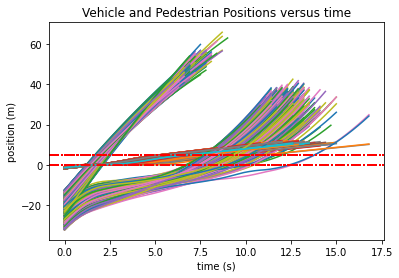

In [105]:

t=0
plt.title("Vehicle and Pedestrian Positions versus time")
plt.xlabel("time (s)")
plt.ylabel("position (m)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    plt.plot(ep_time[t_init:t],ep_pos_car[t_init:t])
    plt.plot(ep_time[t_init:t],ep_pos_ped[t_init:t])
    plt.axhline(y=5, color='r', linestyle='-.')
    plt.axhline(y=0, color='r', linestyle='-.')
    t+=1
_=plt.axhline(y=5, color='r', linestyle='-.')
_=plt.axhline(y=0, color='r', linestyle='-.')

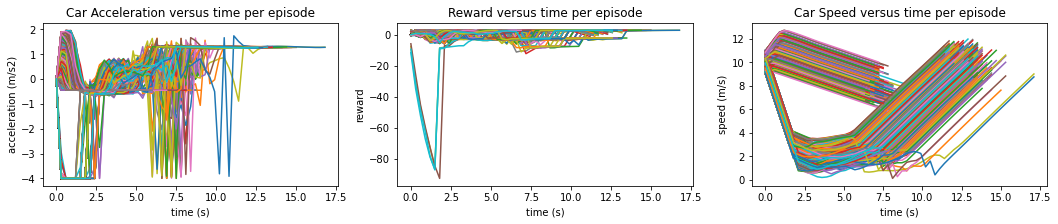

In [106]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18, 3))

t=0
ax1.set_title("Car Acceleration versus time per episode")
ax1.set_xlabel("time (s)")
ax1.set_ylabel("acceleration (m/s2)")

ax2.set_title("Reward versus time per episode")
ax2.set_xlabel("time (s)")
ax2.set_ylabel("reward")

ax3.set_title("Car Speed versus time per episode")
ax3.set_xlabel("time (s)")
ax3.set_ylabel("speed (m/s)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    ax1.plot(ep_time[t_init:t],ep_action[t_init:t])
    ax2.plot(ep_time[t_init:t],ep_reward[t_init:t])
    ax3.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1])
    t+=1


In [107]:
#Seperate the episodes and the different behaviors
t=0
cross_speed=[]
wait_speed=[]
cross_acc=[]
wait_acc=[]
size_wait=20
size_cross=30

while t+1<len(ep_time):
    t_init=t
    choice=False
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        choice=choice+(ep_speed_car[t]<2.0)
        t+=1
    if(choice):
        cross_speed.append(np.array(ep_speed_car[t_init:t_init+size_cross]))
        cross_acc.append(np.array(states[t_init:t_init+size_cross,0]))
    else:
        wait_speed.append(np.array(ep_speed_car[t_init:t_init+size_wait]))
        wait_acc.append(np.array(states[t_init:t_init+size_wait,0]))
    t+=1
    
cross_speed=np.array(cross_speed)
wait_speed=np.array(wait_speed)
cross_acc=np.array(cross_acc)
wait_acc=np.array(wait_acc)

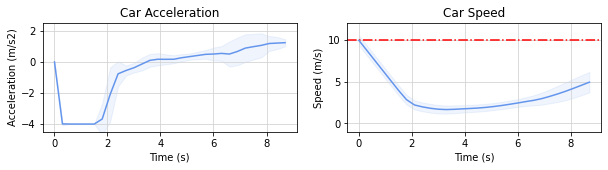

In [108]:
x1=[0.3*i for i in range(size_cross)]
mean_speed=np.mean(cross_speed,axis=0)
std_speed=np.std(cross_speed,axis=0)
mean_acc=np.mean(cross_acc,axis=0)
std_acc=np.std(cross_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x1,mean_acc,color='cornflowerblue')
ax1.fill_between(x1, (mean_acc-std_acc), (mean_acc+std_acc), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed[0], color='r', linestyle='-.')
ax2.plot(x1,mean_speed,color='cornflowerblue')
ax2.fill_between(x1, (mean_speed-std_speed), (mean_speed+std_speed), color='cornflowerblue', alpha=0.1)

ax2.grid(True,color='lightgrey')
#fig.savefig("PDF_results/car_cross_ddpg.pdf")

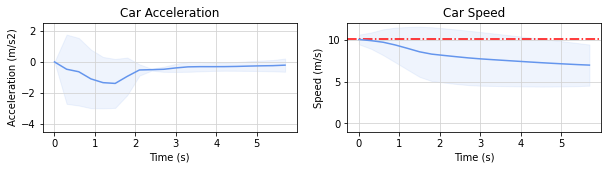

In [109]:
x2=[0.3*i for i in range(size_wait)]

mean_speed2=np.mean(wait_speed,axis=0)
std_speed2=np.std(wait_speed,axis=0)
mean_acc2=np.mean(wait_acc,axis=0)
std_acc2=np.std(wait_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x2,mean_acc2,color='cornflowerblue')
ax1.fill_between(x2, (mean_acc2-std_acc2), (mean_acc2+std_acc2), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed2[0], color='r', linestyle='-.')
ax2.plot(x2,mean_speed2,color='cornflowerblue')
ax2.fill_between(x2, (mean_speed2-std_speed2), (mean_speed2+std_speed2), color='cornflowerblue', alpha=0.1)
ax2.grid(True,color='lightgrey')
#fig.savefig("PDF_results/car_wait_ddpg.pdf")

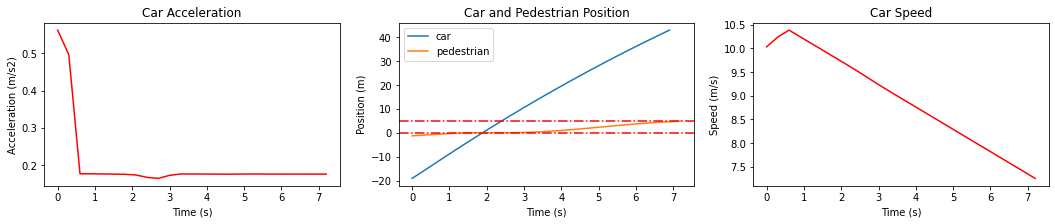

In [102]:
#Showing Vehicle Acceleration Diagram, Vehicle Speed Diagram, Vehicle and Pedestrian Position Diagram
#All three over time in an episode

#t=0
if (t+1>=len(ep_time)):
    t=0
t_init=t
while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
    t+=1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18, 3))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.plot(ep_time[t_init:t+1],actions[t_init:t+1,0],color='r')

ax2.set_title('Car and Pedestrian Position')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Position (m)")
ax2.plot(ep_time[t_init:t],ep_pos_car[t_init:t],label='car')
ax2.plot(ep_time[t_init:t+1],ep_pos_ped[t_init:t+1],label='pedestrian')
ax2.axhline(y=5, color='r', linestyle='-.')
ax2.axhline(y=0, color='r', linestyle='-.')
ax2.legend()

ax3.set_title('Car Speed')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Speed (m/s)")
ax3.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1],color='r')

t+=1